In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import torch.nn as nn
import torch
import itertools

from emnist import get_emnist_data_loaders
from models.crnn.crnn import CRNN
from models.lstm_cnn.lstm_cnn import CNN_LSTM
from training.trainer import Trainer
from hyperparameter import common_hyperparameters, model_specific_hyperparameters
from evaluation.metric import plot_metric, plot_multiple_metrics
from evaluation.evaluations_utils import create_directory_if_not_exists
from torch.optim.lr_scheduler import StepLR, ExponentialLR
from utils import get_dict_from_pkl, save_dict_to_pkl

In [3]:
# Generate all possible combinations of hyperparameters
param_combinations = list(itertools.product(*model_specific_hyperparameters.values()))
print(f"Number of Hyperparameter combinations: {len(param_combinations)}")

Number of Hyperparameter combinations: 12


In [4]:
trainers = {}
for param_combination in param_combinations: 
    
    gru_hidden_size = param_combination[0]
    gru_num_layers = param_combination[1]
    cnn_output_height = param_combination[2]
    cnn_output_width = param_combination[3]
    learning_rate = param_combination[4]
    batch_size = param_combination[5]
    batch_size_val = param_combination[6]

    num_classes = common_hyperparameters["NUM_CLASSES"]   
    blank_label = common_hyperparameters["BLANK_LABEL"]
    image_height = common_hyperparameters["IMAGE_HEIGHT"]
    digits_per_sequence = common_hyperparameters["DIGITS_PER_SEQUENCE"]
    number_of_sequences = common_hyperparameters["NUMBER_OF_SEQUENCES"]
    epochs = common_hyperparameters["EPOCHS"]
    weight_decay = common_hyperparameters["WEIGHT_DECAY"]

    # Load data
    train_loader, val_loader, test_loader = get_emnist_data_loaders(number_of_sequences, digits_per_sequence, batch_size, batch_size_val)


    # Setup model
    models = {
        "lstm_cnn": CNN_LSTM(gru_hidden_size=gru_hidden_size, gru_num_layers=gru_num_layers, num_classes=num_classes, cnn_output_height=cnn_output_height),
        "crnn": CRNN(gru_hidden_size, gru_num_layers, num_classes, cnn_output_height)
    }

    criteria = {
        "crnn": nn.CTCLoss(blank=common_hyperparameters['BLANK_LABEL'], reduction='mean', zero_infinity=True),
        "lstm_cnn": nn.CTCLoss(blank=common_hyperparameters['BLANK_LABEL'], reduction='mean', zero_infinity=True)
    }

    optimizer_configs = {
        "adam_w": torch.optim.AdamW,
        "adam_w_regulise": torch.optim.AdamW
    }

    scheduler_configs = {
        # "step_lr": (StepLR, {"step_size": 2, "gamma": 0.5}),
        "no_scheduler": (None, None),
        "exponential_lr": (ExponentialLR, {"gamma": 0.8}),
    }

    for model_name, model in models.items():
        for optimizer_name, optimizer_class in optimizer_configs.items():
            if optimizer_name == "adam_w_regulise":
                optimizer = optimizer_class(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            else:
                optimizer = optimizer_class(model.parameters(), lr=learning_rate)
            for scheduler_name, (scheduler_class, scheduler_args) in scheduler_configs.items():
                if scheduler_name == "no_scheduler":
                    scheduler = None
                else:
                    scheduler = scheduler_class(optimizer, **scheduler_args)
                criterion = criteria[model_name]

                # Create model name
                abbreviation = f"G{gru_hidden_size}__L{gru_num_layers}__H{cnn_output_height}__W{cnn_output_width}__LR{learning_rate}__BS{batch_size}__BSV{batch_size_val}"
                abbreviation = abbreviation.replace(".", "_")
                main_model_name = model_name.split('-', 1)[0]
                trainer_name = f"{model_name}-{optimizer_name}_{scheduler_name}_{abbreviation}"

                trainer = Trainer(
                    model, model_name, criterion, optimizer, train_loader, val_loader, test_loader,
                    epochs=epochs, args={"blank_label": blank_label, "cnn_output_width": cnn_output_width},
                    scheduler=scheduler
                )
                trainers[trainer_name] = trainer
    
print(f"Prepared {len(trainers)} models for training.")

Prepared 96 models for training.


In [152]:
import time

metrics_global = {}
for model_name, trainer in trainers.items():
    print(f"Training {model_name}")
    start_time = time.time()
    metrics = trainer.train_validate_test()
    end_time = time.time()
    print(f"Finished training {model_name} and took {end_time - start_time} seconds.")
    print("\n" + 100*"#" + "\n")
    
    # Save the trained model with abbreviation and parameter values
    main_model_name = model_name.split('-', 1)[0]
    base_path = f'models/{main_model_name}/{model_name}/'

    # Add metrics to model name
    metrics_global[f"{model_name}"] = metrics
    
    # Save model to disk
    create_directory_if_not_exists(base_path)
    save_path = base_path + "model.pth"
    torch.save(trainer.model.state_dict(), save_path)
    save_dict_to_pkl(metrics_global, "metrics_global")

Training lstm_cnn-adam_w_no_scheduler_G128__L2__H4__W32__LR0_01__BS64__BSV64


100%|██████████| 110/110 [00:34<00:00,  3.22it/s]


Training Epoch: 1/10; Loss: 2.639223575592041; Correct: 0/7000 = 0.0000; Average CER Score: 0.999


100%|██████████| 47/47 [00:07<00:00,  6.61it/s]


Validate Epoch: 1/10; Loss: 2.638977527618408; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 110/110 [00:33<00:00,  3.26it/s]


Training Epoch: 2/10; Loss: 2.5843002796173096; Correct: 0/7000 = 0.0000; Average CER Score: 0.999


100%|██████████| 47/47 [00:07<00:00,  6.60it/s]


Validate Epoch: 2/10; Loss: 2.5744311809539795; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 110/110 [00:34<00:00,  3.23it/s]


Training Epoch: 3/10; Loss: 1.6136550903320312; Correct: 0/7000 = 0.0000; Average CER Score: 0.987


100%|██████████| 47/47 [00:07<00:00,  6.57it/s]


Validate Epoch: 3/10; Loss: 1.5584511756896973; Correct: 7/2999 = 0.0023; Average CER Score: 0.919


100%|██████████| 110/110 [00:34<00:00,  3.20it/s]


Training Epoch: 4/10; Loss: 0.35181427001953125; Correct: 2198/7000 = 0.3140; Average CER Score: 0.823


100%|██████████| 47/47 [00:07<00:00,  6.38it/s]


Validate Epoch: 4/10; Loss: 0.4641872048377991; Correct: 1696/2999 = 0.5655; Average CER Score: 0.723


100%|██████████| 110/110 [00:34<00:00,  3.20it/s]


Training Epoch: 5/10; Loss: 0.19690167903900146; Correct: 4893/7000 = 0.6990; Average CER Score: 0.676


100%|██████████| 47/47 [00:07<00:00,  6.42it/s]


Validate Epoch: 5/10; Loss: 0.15129314363002777; Correct: 2213/2999 = 0.7379; Average CER Score: 0.592


100%|██████████| 110/110 [00:34<00:00,  3.20it/s]


Training Epoch: 6/10; Loss: 0.06925158202648163; Correct: 5663/7000 = 0.8090; Average CER Score: 0.571


100%|██████████| 47/47 [00:07<00:00,  6.40it/s]


Validate Epoch: 6/10; Loss: 0.17441028356552124; Correct: 2469/2999 = 0.8233; Average CER Score: 0.501


100%|██████████| 110/110 [00:34<00:00,  3.20it/s]


Training Epoch: 7/10; Loss: 0.1623808592557907; Correct: 6041/7000 = 0.8630; Average CER Score: 0.495


100%|██████████| 47/47 [00:07<00:00,  6.41it/s]


Validate Epoch: 7/10; Loss: 0.17509302496910095; Correct: 2542/2999 = 0.8476; Average CER Score: 0.434


100%|██████████| 110/110 [00:34<00:00,  3.18it/s]


Training Epoch: 8/10; Loss: 0.023333163931965828; Correct: 6137/7000 = 0.8767; Average CER Score: 0.437


100%|██████████| 47/47 [00:07<00:00,  6.46it/s]


Validate Epoch: 8/10; Loss: 0.03885013237595558; Correct: 2550/2999 = 0.8503; Average CER Score: 0.384


100%|██████████| 110/110 [00:34<00:00,  3.20it/s]


Training Epoch: 9/10; Loss: 0.11954805254936218; Correct: 6309/7000 = 0.9013; Average CER Score: 0.391


100%|██████████| 47/47 [00:07<00:00,  6.52it/s]


Validate Epoch: 9/10; Loss: 0.14364393055438995; Correct: 2429/2999 = 0.8099; Average CER Score: 0.347


100%|██████████| 110/110 [00:33<00:00,  3.25it/s]


Training Epoch: 10/10; Loss: 0.15671347081661224; Correct: 6326/7000 = 0.9037; Average CER Score: 0.354


100%|██████████| 47/47 [00:07<00:00,  6.50it/s]


Validate Epoch: 10/10; Loss: 0.09686765819787979; Correct: 2607/2999 = 0.8693; Average CER Score: 0.315


100%|██████████| 1/1 [00:00<00:00, 84.23it/s]


Test Predictions --> Loss: 0.07078637182712555; Correct: 1/1 = 1.0000; Average CER Score: 0.315
Finished training lstm_cnn-adam_w_no_scheduler_G128__L2__H4__W32__LR0_01__BS64__BSV64 and took 414.8987431526184 seconds.

####################################################################################################

Training lstm_cnn-adam_w_exponential_lr_G128__L2__H4__W32__LR0_01__BS64__BSV64


100%|██████████| 110/110 [00:33<00:00,  3.25it/s]


Training Epoch: 1/10; Loss: 0.02255467139184475; Correct: 6548/7000 = 0.9354; Average CER Score: 0.015


100%|██████████| 47/47 [00:07<00:00,  6.55it/s]


Validate Epoch: 1/10; Loss: 0.23842547833919525; Correct: 2600/2999 = 0.8670; Average CER Score: 0.03


100%|██████████| 110/110 [00:34<00:00,  3.23it/s]


Training Epoch: 2/10; Loss: 0.008006466552615166; Correct: 6676/7000 = 0.9537; Average CER Score: 0.013


100%|██████████| 47/47 [00:07<00:00,  6.52it/s]


Validate Epoch: 2/10; Loss: 0.09977585077285767; Correct: 2654/2999 = 0.8850; Average CER Score: 0.028


100%|██████████| 110/110 [00:34<00:00,  3.21it/s]


Training Epoch: 3/10; Loss: 0.013373828493058681; Correct: 6821/7000 = 0.9744; Average CER Score: 0.011


100%|██████████| 47/47 [00:07<00:00,  6.53it/s]


Validate Epoch: 3/10; Loss: 0.10638836771249771; Correct: 2684/2999 = 0.8950; Average CER Score: 0.027


100%|██████████| 110/110 [00:33<00:00,  3.24it/s]


Training Epoch: 4/10; Loss: 0.0038935260381549597; Correct: 6941/7000 = 0.9916; Average CER Score: 0.008


100%|██████████| 47/47 [00:07<00:00,  6.48it/s]


Validate Epoch: 4/10; Loss: 0.022068385034799576; Correct: 2685/2999 = 0.8953; Average CER Score: 0.026


100%|██████████| 110/110 [00:34<00:00,  3.23it/s]


Training Epoch: 5/10; Loss: 0.01100116316229105; Correct: 6972/7000 = 0.9960; Average CER Score: 0.007


100%|██████████| 47/47 [00:07<00:00,  6.50it/s]


Validate Epoch: 5/10; Loss: 0.0885852500796318; Correct: 2703/2999 = 0.9013; Average CER Score: 0.025


100%|██████████| 110/110 [00:33<00:00,  3.24it/s]


Training Epoch: 6/10; Loss: 0.007308699190616608; Correct: 6984/7000 = 0.9977; Average CER Score: 0.006


100%|██████████| 47/47 [00:07<00:00,  6.48it/s]


Validate Epoch: 6/10; Loss: 0.04883775860071182; Correct: 2708/2999 = 0.9030; Average CER Score: 0.025


100%|██████████| 110/110 [00:34<00:00,  3.23it/s]


Training Epoch: 7/10; Loss: 0.0020490160677582026; Correct: 6990/7000 = 0.9986; Average CER Score: 0.005


100%|██████████| 47/47 [00:07<00:00,  6.47it/s]


Validate Epoch: 7/10; Loss: 0.0886123850941658; Correct: 2710/2999 = 0.9036; Average CER Score: 0.024


100%|██████████| 110/110 [00:34<00:00,  3.23it/s]


Training Epoch: 8/10; Loss: 0.0029635075479745865; Correct: 6993/7000 = 0.9990; Average CER Score: 0.004


100%|██████████| 47/47 [00:07<00:00,  6.48it/s]


Validate Epoch: 8/10; Loss: 0.020260140299797058; Correct: 2708/2999 = 0.9030; Average CER Score: 0.024


100%|██████████| 110/110 [00:34<00:00,  3.23it/s]


Training Epoch: 9/10; Loss: 0.0011476563522592187; Correct: 6994/7000 = 0.9991; Average CER Score: 0.004


100%|██████████| 47/47 [00:07<00:00,  6.50it/s]


Validate Epoch: 9/10; Loss: 0.09858061373233795; Correct: 2714/2999 = 0.9050; Average CER Score: 0.024


100%|██████████| 110/110 [00:34<00:00,  3.23it/s]


Training Epoch: 10/10; Loss: 0.00152147829066962; Correct: 6994/7000 = 0.9991; Average CER Score: 0.004


100%|██████████| 47/47 [00:07<00:00,  6.46it/s]


Validate Epoch: 10/10; Loss: 0.07050823420286179; Correct: 2709/2999 = 0.9033; Average CER Score: 0.024


100%|██████████| 1/1 [00:00<00:00, 177.59it/s]


Test Predictions --> Loss: 0.022814888507127762; Correct: 1/1 = 1.0000; Average CER Score: 0.024
Finished training lstm_cnn-adam_w_exponential_lr_G128__L2__H4__W32__LR0_01__BS64__BSV64 and took 412.76159596443176 seconds.

####################################################################################################

Training lstm_cnn-adam_w_regulise_no_scheduler_G128__L2__H4__W32__LR0_01__BS64__BSV64


100%|██████████| 110/110 [00:34<00:00,  3.23it/s]


Training Epoch: 1/10; Loss: 0.04154662415385246; Correct: 6475/7000 = 0.9250; Average CER Score: 0.017


100%|██████████| 47/47 [00:07<00:00,  6.49it/s]


Validate Epoch: 1/10; Loss: 0.07796701788902283; Correct: 2590/2999 = 0.8636; Average CER Score: 0.033


100%|██████████| 110/110 [00:34<00:00,  3.23it/s]


Training Epoch: 2/10; Loss: 0.05162516236305237; Correct: 6607/7000 = 0.9439; Average CER Score: 0.015


100%|██████████| 47/47 [00:07<00:00,  6.52it/s]


Validate Epoch: 2/10; Loss: 0.18305286765098572; Correct: 2564/2999 = 0.8550; Average CER Score: 0.033


100%|██████████| 110/110 [00:34<00:00,  3.22it/s]


Training Epoch: 3/10; Loss: 0.03963617607951164; Correct: 6610/7000 = 0.9443; Average CER Score: 0.014


100%|██████████| 47/47 [00:07<00:00,  6.44it/s]


Validate Epoch: 3/10; Loss: 0.15322676301002502; Correct: 2558/2999 = 0.8530; Average CER Score: 0.033


100%|██████████| 110/110 [00:34<00:00,  3.22it/s]


Training Epoch: 4/10; Loss: 0.10813745856285095; Correct: 6502/7000 = 0.9289; Average CER Score: 0.015


100%|██████████| 47/47 [00:07<00:00,  6.34it/s]


Validate Epoch: 4/10; Loss: 0.12065491825342178; Correct: 2580/2999 = 0.8603; Average CER Score: 0.033


100%|██████████| 110/110 [00:34<00:00,  3.20it/s]


Training Epoch: 5/10; Loss: 0.03568756952881813; Correct: 6587/7000 = 0.9410; Average CER Score: 0.015


100%|██████████| 47/47 [00:07<00:00,  6.39it/s]


Validate Epoch: 5/10; Loss: 0.13972067832946777; Correct: 2583/2999 = 0.8613; Average CER Score: 0.033


100%|██████████| 110/110 [00:34<00:00,  3.22it/s]


Training Epoch: 6/10; Loss: 0.04681982100009918; Correct: 6717/7000 = 0.9596; Average CER Score: 0.014


100%|██████████| 47/47 [00:07<00:00,  6.46it/s]


Validate Epoch: 6/10; Loss: 0.14656764268875122; Correct: 2572/2999 = 0.8576; Average CER Score: 0.033


100%|██████████| 110/110 [00:34<00:00,  3.23it/s]


Training Epoch: 7/10; Loss: 0.015181362628936768; Correct: 6675/7000 = 0.9536; Average CER Score: 0.013


100%|██████████| 47/47 [00:07<00:00,  6.46it/s]


Validate Epoch: 7/10; Loss: 0.13316892087459564; Correct: 2580/2999 = 0.8603; Average CER Score: 0.032


100%|██████████| 110/110 [00:34<00:00,  3.21it/s]


Training Epoch: 8/10; Loss: 0.03528450056910515; Correct: 6703/7000 = 0.9576; Average CER Score: 0.013


100%|██████████| 47/47 [00:07<00:00,  6.56it/s]


Validate Epoch: 8/10; Loss: 0.14828619360923767; Correct: 2631/2999 = 0.8773; Average CER Score: 0.032


100%|██████████| 110/110 [00:34<00:00,  3.20it/s]


Training Epoch: 9/10; Loss: 0.12446590512990952; Correct: 6780/7000 = 0.9686; Average CER Score: 0.012


100%|██████████| 47/47 [00:07<00:00,  6.37it/s]


Validate Epoch: 9/10; Loss: 0.05553682893514633; Correct: 2575/2999 = 0.8586; Average CER Score: 0.032


100%|██████████| 110/110 [00:34<00:00,  3.19it/s]


Training Epoch: 10/10; Loss: 0.025079676881432533; Correct: 6635/7000 = 0.9479; Average CER Score: 0.012


100%|██████████| 47/47 [00:07<00:00,  6.14it/s]


Validate Epoch: 10/10; Loss: 0.09683211892843246; Correct: 2609/2999 = 0.8700; Average CER Score: 0.032


100%|██████████| 1/1 [00:00<00:00, 163.71it/s]


Test Predictions --> Loss: 0.003186640562489629; Correct: 1/1 = 1.0000; Average CER Score: 0.032
Finished training lstm_cnn-adam_w_regulise_no_scheduler_G128__L2__H4__W32__LR0_01__BS64__BSV64 and took 415.60649609565735 seconds.

####################################################################################################

Training lstm_cnn-adam_w_regulise_exponential_lr_G128__L2__H4__W32__LR0_01__BS64__BSV64


100%|██████████| 110/110 [00:34<00:00,  3.20it/s]


Training Epoch: 1/10; Loss: 0.003230793634429574; Correct: 6694/7000 = 0.9563; Average CER Score: 0.01


100%|██████████| 47/47 [00:07<00:00,  6.19it/s]


Validate Epoch: 1/10; Loss: 0.11217917501926422; Correct: 2614/2999 = 0.8716; Average CER Score: 0.031


100%|██████████| 110/110 [00:34<00:00,  3.20it/s]


Training Epoch: 2/10; Loss: 0.035677626729011536; Correct: 6849/7000 = 0.9784; Average CER Score: 0.008


100%|██████████| 47/47 [00:07<00:00,  6.44it/s]


Validate Epoch: 2/10; Loss: 0.21882088482379913; Correct: 2656/2999 = 0.8856; Average CER Score: 0.029


100%|██████████| 110/110 [00:34<00:00,  3.18it/s]


Training Epoch: 3/10; Loss: 0.00045534377568401396; Correct: 6921/7000 = 0.9887; Average CER Score: 0.006


100%|██████████| 47/47 [00:07<00:00,  6.20it/s]


Validate Epoch: 3/10; Loss: 0.1445319503545761; Correct: 2714/2999 = 0.9050; Average CER Score: 0.026


100%|██████████| 110/110 [00:34<00:00,  3.21it/s]


Training Epoch: 4/10; Loss: 0.0009802172426134348; Correct: 6993/7000 = 0.9990; Average CER Score: 0.005


100%|██████████| 47/47 [00:07<00:00,  6.46it/s]


Validate Epoch: 4/10; Loss: 0.09793917089700699; Correct: 2720/2999 = 0.9070; Average CER Score: 0.024


100%|██████████| 110/110 [00:34<00:00,  3.21it/s]


Training Epoch: 5/10; Loss: 0.00025560116046108305; Correct: 6999/7000 = 0.9999; Average CER Score: 0.004


100%|██████████| 47/47 [00:07<00:00,  6.47it/s]


Validate Epoch: 5/10; Loss: 0.07729008048772812; Correct: 2725/2999 = 0.9086; Average CER Score: 0.023


100%|██████████| 110/110 [00:34<00:00,  3.22it/s]


Training Epoch: 6/10; Loss: 0.00044398641330190003; Correct: 6999/7000 = 0.9999; Average CER Score: 0.003


100%|██████████| 47/47 [00:07<00:00,  6.44it/s]


Validate Epoch: 6/10; Loss: 0.05648653209209442; Correct: 2723/2999 = 0.9080; Average CER Score: 0.023


100%|██████████| 110/110 [00:34<00:00,  3.23it/s]


Training Epoch: 7/10; Loss: 0.0011036604410037398; Correct: 6999/7000 = 0.9999; Average CER Score: 0.003


100%|██████████| 47/47 [00:07<00:00,  6.49it/s]


Validate Epoch: 7/10; Loss: 0.14368000626564026; Correct: 2726/2999 = 0.9090; Average CER Score: 0.022


100%|██████████| 110/110 [00:34<00:00,  3.22it/s]


Training Epoch: 8/10; Loss: 0.00015985163918230683; Correct: 6999/7000 = 0.9999; Average CER Score: 0.002


100%|██████████| 47/47 [00:07<00:00,  6.51it/s]


Validate Epoch: 8/10; Loss: 0.06732332706451416; Correct: 2734/2999 = 0.9116; Average CER Score: 0.022


100%|██████████| 110/110 [00:34<00:00,  3.22it/s]


Training Epoch: 9/10; Loss: 0.00033269074629060924; Correct: 6999/7000 = 0.9999; Average CER Score: 0.002


100%|██████████| 47/47 [00:07<00:00,  6.46it/s]


Validate Epoch: 9/10; Loss: 0.12124564498662949; Correct: 2725/2999 = 0.9086; Average CER Score: 0.022


100%|██████████| 110/110 [00:34<00:00,  3.22it/s]


Training Epoch: 10/10; Loss: 0.0002786669647321105; Correct: 6999/7000 = 0.9999; Average CER Score: 0.002


100%|██████████| 47/47 [00:07<00:00,  6.44it/s]


Validate Epoch: 10/10; Loss: 0.1083969920873642; Correct: 2731/2999 = 0.9106; Average CER Score: 0.021


100%|██████████| 1/1 [00:00<00:00, 184.75it/s]


Test Predictions --> Loss: 0.012868000194430351; Correct: 1/1 = 1.0000; Average CER Score: 0.021
Finished training lstm_cnn-adam_w_regulise_exponential_lr_G128__L2__H4__W32__LR0_01__BS64__BSV64 and took 416.0144782066345 seconds.

####################################################################################################

Training crnn-adam_w_no_scheduler_G128__L2__H4__W32__LR0_01__BS64__BSV64


100%|██████████| 110/110 [00:31<00:00,  3.54it/s]


Training Epoch: 1/10; Loss: 2.624084234237671; Correct: 0/7000 = 0.0000; Average CER Score: 0.986


100%|██████████| 47/47 [00:06<00:00,  7.15it/s]


Validate Epoch: 1/10; Loss: 2.6377997398376465; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 110/110 [00:30<00:00,  3.55it/s]


Training Epoch: 2/10; Loss: 2.6323416233062744; Correct: 0/7000 = 0.0000; Average CER Score: 0.993


100%|██████████| 47/47 [00:06<00:00,  7.09it/s]


Validate Epoch: 2/10; Loss: 2.6442160606384277; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 110/110 [00:31<00:00,  3.54it/s]


Training Epoch: 3/10; Loss: 2.64473032951355; Correct: 0/7000 = 0.0000; Average CER Score: 0.995


100%|██████████| 47/47 [00:06<00:00,  7.12it/s]


Validate Epoch: 3/10; Loss: 2.6407368183135986; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 110/110 [00:30<00:00,  3.57it/s]


Training Epoch: 4/10; Loss: 2.542409896850586; Correct: 0/7000 = 0.0000; Average CER Score: 0.997


100%|██████████| 47/47 [00:06<00:00,  7.00it/s]


Validate Epoch: 4/10; Loss: 2.5422301292419434; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 110/110 [00:30<00:00,  3.57it/s]


Training Epoch: 5/10; Loss: 2.3981359004974365; Correct: 0/7000 = 0.0000; Average CER Score: 0.997


100%|██████████| 47/47 [00:06<00:00,  7.03it/s]


Validate Epoch: 5/10; Loss: 2.3586339950561523; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 110/110 [00:31<00:00,  3.54it/s]


Training Epoch: 6/10; Loss: 1.8970032930374146; Correct: 0/7000 = 0.0000; Average CER Score: 0.997


100%|██████████| 47/47 [00:06<00:00,  7.10it/s]


Validate Epoch: 6/10; Loss: 2.049133777618408; Correct: 0/2999 = 0.0000; Average CER Score: 0.995


100%|██████████| 110/110 [00:31<00:00,  3.53it/s]


Training Epoch: 7/10; Loss: 1.6241995096206665; Correct: 6/7000 = 0.0009; Average CER Score: 0.978


100%|██████████| 47/47 [00:06<00:00,  7.00it/s]


Validate Epoch: 7/10; Loss: 1.766417384147644; Correct: 7/2999 = 0.0023; Average CER Score: 0.966


100%|██████████| 110/110 [00:30<00:00,  3.55it/s]


Training Epoch: 8/10; Loss: 1.1528607606887817; Correct: 176/7000 = 0.0251; Average CER Score: 0.946


100%|██████████| 47/47 [00:06<00:00,  7.00it/s]


Validate Epoch: 8/10; Loss: 1.0866810083389282; Correct: 446/2999 = 0.1487; Average CER Score: 0.893


100%|██████████| 110/110 [00:31<00:00,  3.54it/s]


Training Epoch: 9/10; Loss: 0.5415715575218201; Correct: 2807/7000 = 0.4010; Average CER Score: 0.864


100%|██████████| 47/47 [00:06<00:00,  6.97it/s]


Validate Epoch: 9/10; Loss: 0.6114286780357361; Correct: 1218/2999 = 0.4061; Average CER Score: 0.816


100%|██████████| 110/110 [00:31<00:00,  3.54it/s]


Training Epoch: 10/10; Loss: 0.3025442957878113; Correct: 4074/7000 = 0.5820; Average CER Score: 0.79


100%|██████████| 47/47 [00:06<00:00,  6.99it/s]


Validate Epoch: 10/10; Loss: 0.4425232410430908; Correct: 1651/2999 = 0.5505; Average CER Score: 0.748


100%|██████████| 1/1 [00:00<00:00, 202.36it/s]


Test Predictions --> Loss: 0.22914735972881317; Correct: 1/1 = 1.0000; Average CER Score: 0.748
Finished training crnn-adam_w_no_scheduler_G128__L2__H4__W32__LR0_01__BS64__BSV64 and took 376.94632601737976 seconds.

####################################################################################################

Training crnn-adam_w_exponential_lr_G128__L2__H4__W32__LR0_01__BS64__BSV64


100%|██████████| 110/110 [00:31<00:00,  3.54it/s]


Training Epoch: 1/10; Loss: 0.21814484894275665; Correct: 4645/7000 = 0.6636; Average CER Score: 0.096


100%|██████████| 47/47 [00:06<00:00,  6.99it/s]


Validate Epoch: 1/10; Loss: 0.19870822131633759; Correct: 2106/2999 = 0.7022; Average CER Score: 0.078


100%|██████████| 110/110 [00:31<00:00,  3.55it/s]


Training Epoch: 2/10; Loss: 0.2673359811306; Correct: 5048/7000 = 0.7211; Average CER Score: 0.086


100%|██████████| 47/47 [00:06<00:00,  7.00it/s]


Validate Epoch: 2/10; Loss: 0.23453660309314728; Correct: 2014/2999 = 0.6716; Average CER Score: 0.086


100%|██████████| 110/110 [00:31<00:00,  3.49it/s]


Training Epoch: 3/10; Loss: 0.18321086466312408; Correct: 5458/7000 = 0.7797; Average CER Score: 0.076


100%|██████████| 47/47 [00:06<00:00,  6.82it/s]


Validate Epoch: 3/10; Loss: 0.18301832675933838; Correct: 2345/2999 = 0.7819; Average CER Score: 0.077


100%|██████████| 110/110 [00:31<00:00,  3.49it/s]


Training Epoch: 4/10; Loss: 0.09196088463068008; Correct: 5794/7000 = 0.8277; Average CER Score: 0.068


100%|██████████| 47/47 [00:06<00:00,  6.81it/s]


Validate Epoch: 4/10; Loss: 0.11547526717185974; Correct: 2403/2999 = 0.8013; Average CER Score: 0.07


100%|██████████| 110/110 [00:31<00:00,  3.52it/s]


Training Epoch: 5/10; Loss: 0.08974378556013107; Correct: 6020/7000 = 0.8600; Average CER Score: 0.061


100%|██████████| 47/47 [00:06<00:00,  6.95it/s]


Validate Epoch: 5/10; Loss: 0.08853434771299362; Correct: 2467/2999 = 0.8226; Average CER Score: 0.065


100%|██████████| 110/110 [00:31<00:00,  3.52it/s]


Training Epoch: 6/10; Loss: 0.14798703789710999; Correct: 6299/7000 = 0.8999; Average CER Score: 0.055


100%|██████████| 47/47 [00:06<00:00,  6.97it/s]


Validate Epoch: 6/10; Loss: 0.10758183151483536; Correct: 2468/2999 = 0.8229; Average CER Score: 0.062


100%|██████████| 110/110 [00:31<00:00,  3.52it/s]


Training Epoch: 7/10; Loss: 0.08553590625524521; Correct: 6395/7000 = 0.9136; Average CER Score: 0.05


100%|██████████| 47/47 [00:06<00:00,  6.95it/s]


Validate Epoch: 7/10; Loss: 0.11498073488473892; Correct: 2519/2999 = 0.8399; Average CER Score: 0.058


100%|██████████| 110/110 [00:31<00:00,  3.54it/s]


Training Epoch: 8/10; Loss: 0.04198969528079033; Correct: 6558/7000 = 0.9369; Average CER Score: 0.046


100%|██████████| 47/47 [00:06<00:00,  6.96it/s]


Validate Epoch: 8/10; Loss: 0.14029020071029663; Correct: 2514/2999 = 0.8383; Average CER Score: 0.056


100%|██████████| 110/110 [00:31<00:00,  3.54it/s]


Training Epoch: 9/10; Loss: 0.07091012597084045; Correct: 6588/7000 = 0.9411; Average CER Score: 0.042


100%|██████████| 47/47 [00:06<00:00,  6.99it/s]


Validate Epoch: 9/10; Loss: 0.10447017848491669; Correct: 2522/2999 = 0.8409; Average CER Score: 0.054


100%|██████████| 110/110 [00:31<00:00,  3.52it/s]


Training Epoch: 10/10; Loss: 0.06645340472459793; Correct: 6687/7000 = 0.9553; Average CER Score: 0.039


100%|██████████| 47/47 [00:06<00:00,  6.94it/s]


Validate Epoch: 10/10; Loss: 0.11993025243282318; Correct: 2542/2999 = 0.8476; Average CER Score: 0.052


100%|██████████| 1/1 [00:00<00:00, 174.25it/s]


Test Predictions --> Loss: 0.028400331735610962; Correct: 1/1 = 1.0000; Average CER Score: 0.052
Finished training crnn-adam_w_exponential_lr_G128__L2__H4__W32__LR0_01__BS64__BSV64 and took 380.1234381198883 seconds.

####################################################################################################

Training crnn-adam_w_regulise_no_scheduler_G128__L2__H4__W32__LR0_01__BS64__BSV64


100%|██████████| 110/110 [00:31<00:00,  3.50it/s]


Training Epoch: 1/10; Loss: 0.13285022974014282; Correct: 5620/7000 = 0.8029; Average CER Score: 0.051


100%|██████████| 47/47 [00:06<00:00,  6.93it/s]


Validate Epoch: 1/10; Loss: 0.1738576740026474; Correct: 2349/2999 = 0.7833; Average CER Score: 0.058


100%|██████████| 110/110 [00:31<00:00,  3.51it/s]


Training Epoch: 2/10; Loss: 0.12321392446756363; Correct: 5747/7000 = 0.8210; Average CER Score: 0.049


100%|██████████| 47/47 [00:06<00:00,  6.98it/s]


Validate Epoch: 2/10; Loss: 0.2972453236579895; Correct: 2291/2999 = 0.7639; Average CER Score: 0.059


100%|██████████| 110/110 [00:31<00:00,  3.47it/s]


Training Epoch: 3/10; Loss: 0.17813615500926971; Correct: 5764/7000 = 0.8234; Average CER Score: 0.047


100%|██████████| 47/47 [00:06<00:00,  6.77it/s]


Validate Epoch: 3/10; Loss: 0.15634885430335999; Correct: 2382/2999 = 0.7943; Average CER Score: 0.057


100%|██████████| 110/110 [00:30<00:00,  3.57it/s]


Training Epoch: 4/10; Loss: 0.1341536045074463; Correct: 5836/7000 = 0.8337; Average CER Score: 0.046


100%|██████████| 47/47 [00:06<00:00,  6.89it/s]


Validate Epoch: 4/10; Loss: 0.22908622026443481; Correct: 2168/2999 = 0.7229; Average CER Score: 0.062


100%|██████████| 110/110 [00:30<00:00,  3.59it/s]


Training Epoch: 5/10; Loss: 0.11279358714818954; Correct: 5561/7000 = 0.7944; Average CER Score: 0.048


100%|██████████| 47/47 [00:06<00:00,  6.97it/s]


Validate Epoch: 5/10; Loss: 0.1369958370923996; Correct: 2392/2999 = 0.7976; Average CER Score: 0.059


100%|██████████| 110/110 [00:30<00:00,  3.59it/s]


Training Epoch: 6/10; Loss: 0.14391079545021057; Correct: 5985/7000 = 0.8550; Average CER Score: 0.046


100%|██████████| 47/47 [00:06<00:00,  6.95it/s]


Validate Epoch: 6/10; Loss: 0.12952467799186707; Correct: 2180/2999 = 0.7269; Average CER Score: 0.064


100%|██████████| 110/110 [00:30<00:00,  3.59it/s]


Training Epoch: 7/10; Loss: 0.12276311963796616; Correct: 5790/7000 = 0.8271; Average CER Score: 0.046


100%|██████████| 47/47 [00:06<00:00,  7.02it/s]


Validate Epoch: 7/10; Loss: 0.17977242171764374; Correct: 2369/2999 = 0.7899; Average CER Score: 0.063


100%|██████████| 110/110 [00:30<00:00,  3.59it/s]


Training Epoch: 8/10; Loss: 0.09044194221496582; Correct: 5871/7000 = 0.8387; Average CER Score: 0.045


100%|██████████| 47/47 [00:06<00:00,  7.03it/s]


Validate Epoch: 8/10; Loss: 0.1985132098197937; Correct: 2294/2999 = 0.7649; Average CER Score: 0.062


100%|██████████| 110/110 [00:30<00:00,  3.60it/s]


Training Epoch: 9/10; Loss: 0.11423072963953018; Correct: 6087/7000 = 0.8696; Average CER Score: 0.044


100%|██████████| 47/47 [00:06<00:00,  7.03it/s]


Validate Epoch: 9/10; Loss: 0.18844914436340332; Correct: 2507/2999 = 0.8359; Average CER Score: 0.06


100%|██████████| 110/110 [00:30<00:00,  3.59it/s]


Training Epoch: 10/10; Loss: 0.1839693933725357; Correct: 6122/7000 = 0.8746; Average CER Score: 0.043


100%|██████████| 47/47 [00:06<00:00,  7.03it/s]


Validate Epoch: 10/10; Loss: 0.1890367716550827; Correct: 2419/2999 = 0.8066; Average CER Score: 0.059


100%|██████████| 1/1 [00:00<00:00, 185.50it/s]


Test Predictions --> Loss: 0.06916560232639313; Correct: 1/1 = 1.0000; Average CER Score: 0.059
Finished training crnn-adam_w_regulise_no_scheduler_G128__L2__H4__W32__LR0_01__BS64__BSV64 and took 376.6425290107727 seconds.

####################################################################################################

Training crnn-adam_w_regulise_exponential_lr_G128__L2__H4__W32__LR0_01__BS64__BSV64


100%|██████████| 110/110 [00:30<00:00,  3.59it/s]


Training Epoch: 1/10; Loss: 0.055096521973609924; Correct: 6038/7000 = 0.8626; Average CER Score: 0.035


100%|██████████| 47/47 [00:06<00:00,  7.01it/s]


Validate Epoch: 1/10; Loss: 0.11734732985496521; Correct: 2410/2999 = 0.8036; Average CER Score: 0.049


100%|██████████| 110/110 [00:30<00:00,  3.59it/s]


Training Epoch: 2/10; Loss: 0.21412871778011322; Correct: 6304/7000 = 0.9006; Average CER Score: 0.03


100%|██████████| 47/47 [00:06<00:00,  7.01it/s]


Validate Epoch: 2/10; Loss: 0.11891110241413116; Correct: 2433/2999 = 0.8113; Average CER Score: 0.049


100%|██████████| 110/110 [00:30<00:00,  3.60it/s]


Training Epoch: 3/10; Loss: 0.11096598953008652; Correct: 6243/7000 = 0.8919; Average CER Score: 0.029


100%|██████████| 47/47 [00:06<00:00,  6.99it/s]


Validate Epoch: 3/10; Loss: 0.20963196456432343; Correct: 2514/2999 = 0.8383; Average CER Score: 0.046


100%|██████████| 110/110 [00:30<00:00,  3.59it/s]


Training Epoch: 4/10; Loss: 0.006797709036618471; Correct: 6609/7000 = 0.9441; Average CER Score: 0.025


100%|██████████| 47/47 [00:06<00:00,  7.03it/s]


Validate Epoch: 4/10; Loss: 0.16334739327430725; Correct: 2590/2999 = 0.8636; Average CER Score: 0.043


100%|██████████| 110/110 [00:30<00:00,  3.59it/s]


Training Epoch: 5/10; Loss: 0.014363030903041363; Correct: 6779/7000 = 0.9684; Average CER Score: 0.022


100%|██████████| 47/47 [00:06<00:00,  6.95it/s]


Validate Epoch: 5/10; Loss: 0.16623742878437042; Correct: 2598/2999 = 0.8663; Average CER Score: 0.041


100%|██████████| 110/110 [00:30<00:00,  3.57it/s]


Training Epoch: 6/10; Loss: 0.024190999567508698; Correct: 6778/7000 = 0.9683; Average CER Score: 0.02


100%|██████████| 47/47 [00:06<00:00,  6.97it/s]


Validate Epoch: 6/10; Loss: 0.10353671759366989; Correct: 2594/2999 = 0.8650; Average CER Score: 0.04


100%|██████████| 110/110 [00:30<00:00,  3.57it/s]


Training Epoch: 7/10; Loss: 0.007784682791680098; Correct: 6890/7000 = 0.9843; Average CER Score: 0.017


100%|██████████| 47/47 [00:06<00:00,  7.00it/s]


Validate Epoch: 7/10; Loss: 0.10501740127801895; Correct: 2613/2999 = 0.8713; Average CER Score: 0.039


100%|██████████| 110/110 [00:30<00:00,  3.58it/s]


Training Epoch: 8/10; Loss: 0.027201831340789795; Correct: 6933/7000 = 0.9904; Average CER Score: 0.016


100%|██████████| 47/47 [00:06<00:00,  6.99it/s]


Validate Epoch: 8/10; Loss: 0.10117892175912857; Correct: 2622/2999 = 0.8743; Average CER Score: 0.038


100%|██████████| 110/110 [00:30<00:00,  3.58it/s]


Training Epoch: 9/10; Loss: 0.003928128629922867; Correct: 6955/7000 = 0.9936; Average CER Score: 0.014


100%|██████████| 47/47 [00:06<00:00,  7.01it/s]


Validate Epoch: 9/10; Loss: 0.12938588857650757; Correct: 2625/2999 = 0.8753; Average CER Score: 0.037


100%|██████████| 110/110 [00:30<00:00,  3.58it/s]


Training Epoch: 10/10; Loss: 0.0032216047402471304; Correct: 6966/7000 = 0.9951; Average CER Score: 0.013


100%|██████████| 47/47 [00:06<00:00,  7.02it/s]


Validate Epoch: 10/10; Loss: 0.07274653762578964; Correct: 2630/2999 = 0.8770; Average CER Score: 0.036


100%|██████████| 1/1 [00:00<00:00, 175.13it/s]


Test Predictions --> Loss: 0.012504386715590954; Correct: 1/1 = 1.0000; Average CER Score: 0.036
Finished training crnn-adam_w_regulise_exponential_lr_G128__L2__H4__W32__LR0_01__BS64__BSV64 and took 374.23774909973145 seconds.

####################################################################################################

Training lstm_cnn-adam_w_no_scheduler_G128__L2__H4__W32__LR0_01__BS128__BSV64


100%|██████████| 55/55 [00:30<00:00,  1.79it/s]


Training Epoch: 1/10; Loss: 2.629506826400757; Correct: 0/7000 = 0.0000; Average CER Score: 0.998


100%|██████████| 47/47 [00:06<00:00,  6.89it/s]


Validate Epoch: 1/10; Loss: 2.6256303787231445; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 55/55 [00:31<00:00,  1.77it/s]


Training Epoch: 2/10; Loss: 2.6275739669799805; Correct: 0/7000 = 0.0000; Average CER Score: 0.999


100%|██████████| 47/47 [00:06<00:00,  6.79it/s]


Validate Epoch: 2/10; Loss: 2.6315598487854004; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 55/55 [00:31<00:00,  1.75it/s]


Training Epoch: 3/10; Loss: 2.5268735885620117; Correct: 0/7000 = 0.0000; Average CER Score: 0.999


100%|██████████| 47/47 [00:06<00:00,  6.72it/s]


Validate Epoch: 3/10; Loss: 2.498271942138672; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 55/55 [00:32<00:00,  1.70it/s]


Training Epoch: 4/10; Loss: 2.194345235824585; Correct: 0/7000 = 0.0000; Average CER Score: 1.0


100%|██████████| 47/47 [00:06<00:00,  6.82it/s]


Validate Epoch: 4/10; Loss: 2.1864640712738037; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 55/55 [00:31<00:00,  1.75it/s]


Training Epoch: 5/10; Loss: 1.2042350769042969; Correct: 25/7000 = 0.0036; Average CER Score: 0.975


100%|██████████| 47/47 [00:07<00:00,  6.61it/s]


Validate Epoch: 5/10; Loss: 1.1536352634429932; Correct: 155/2999 = 0.0517; Average CER Score: 0.914


100%|██████████| 55/55 [00:32<00:00,  1.69it/s]


Training Epoch: 6/10; Loss: 0.3305939733982086; Correct: 2600/7000 = 0.3714; Average CER Score: 0.856


100%|██████████| 47/47 [00:07<00:00,  6.55it/s]


Validate Epoch: 6/10; Loss: 0.44634535908699036; Correct: 1817/2999 = 0.6059; Average CER Score: 0.782


100%|██████████| 55/55 [00:32<00:00,  1.70it/s]


Training Epoch: 7/10; Loss: 0.2267085462808609; Correct: 4852/7000 = 0.6931; Average CER Score: 0.746


100%|██████████| 47/47 [00:07<00:00,  6.66it/s]


Validate Epoch: 7/10; Loss: 0.2260417640209198; Correct: 2098/2999 = 0.6996; Average CER Score: 0.683


100%|██████████| 55/55 [00:32<00:00,  1.69it/s]


Training Epoch: 8/10; Loss: 0.17497926950454712; Correct: 5447/7000 = 0.7781; Average CER Score: 0.661


100%|██████████| 47/47 [00:07<00:00,  6.65it/s]


Validate Epoch: 8/10; Loss: 0.17318670451641083; Correct: 2296/2999 = 0.7656; Average CER Score: 0.607


100%|██████████| 55/55 [00:32<00:00,  1.71it/s]


Training Epoch: 9/10; Loss: 0.15838275849819183; Correct: 5848/7000 = 0.8354; Average CER Score: 0.592


100%|██████████| 47/47 [00:07<00:00,  6.66it/s]


Validate Epoch: 9/10; Loss: 0.15262840688228607; Correct: 2463/2999 = 0.8213; Average CER Score: 0.544


100%|██████████| 55/55 [00:33<00:00,  1.65it/s]


Training Epoch: 10/10; Loss: 0.13335692882537842; Correct: 6021/7000 = 0.8601; Average CER Score: 0.536


100%|██████████| 47/47 [00:07<00:00,  6.67it/s]


Validate Epoch: 10/10; Loss: 0.1376160979270935; Correct: 2453/2999 = 0.8179; Average CER Score: 0.495


100%|██████████| 1/1 [00:00<00:00, 187.97it/s]


Test Predictions --> Loss: 0.07337448000907898; Correct: 1/1 = 1.0000; Average CER Score: 0.495
Finished training lstm_cnn-adam_w_no_scheduler_G128__L2__H4__W32__LR0_01__BS128__BSV64 and took 390.1697041988373 seconds.

####################################################################################################

Training lstm_cnn-adam_w_exponential_lr_G128__L2__H4__W32__LR0_01__BS128__BSV64


100%|██████████| 55/55 [00:32<00:00,  1.71it/s]


Training Epoch: 1/10; Loss: 0.04686009883880615; Correct: 6270/7000 = 0.8957; Average CER Score: 0.026


100%|██████████| 47/47 [00:07<00:00,  6.53it/s]


Validate Epoch: 1/10; Loss: 0.05566072091460228; Correct: 2502/2999 = 0.8343; Average CER Score: 0.04


100%|██████████| 55/55 [00:33<00:00,  1.66it/s]


Training Epoch: 2/10; Loss: 0.034314390271902084; Correct: 6418/7000 = 0.9169; Average CER Score: 0.023


100%|██████████| 47/47 [00:07<00:00,  6.57it/s]


Validate Epoch: 2/10; Loss: 0.13485941290855408; Correct: 2536/2999 = 0.8456; Average CER Score: 0.038


100%|██████████| 55/55 [00:32<00:00,  1.71it/s]


Training Epoch: 3/10; Loss: 0.04116113856434822; Correct: 6653/7000 = 0.9504; Average CER Score: 0.019


100%|██████████| 47/47 [00:07<00:00,  6.61it/s]


Validate Epoch: 3/10; Loss: 0.1423373520374298; Correct: 2624/2999 = 0.8750; Average CER Score: 0.035


100%|██████████| 55/55 [00:32<00:00,  1.70it/s]


Training Epoch: 4/10; Loss: 0.02788272686302662; Correct: 6768/7000 = 0.9669; Average CER Score: 0.016


100%|██████████| 47/47 [00:07<00:00,  6.59it/s]


Validate Epoch: 4/10; Loss: 0.1195325255393982; Correct: 2662/2999 = 0.8876; Average CER Score: 0.033


100%|██████████| 55/55 [00:32<00:00,  1.70it/s]


Training Epoch: 5/10; Loss: 0.018974773585796356; Correct: 6876/7000 = 0.9823; Average CER Score: 0.014


100%|██████████| 47/47 [00:07<00:00,  6.64it/s]


Validate Epoch: 5/10; Loss: 0.12902139127254486; Correct: 2665/2999 = 0.8886; Average CER Score: 0.032


100%|██████████| 55/55 [00:32<00:00,  1.70it/s]


Training Epoch: 6/10; Loss: 0.016509080305695534; Correct: 6909/7000 = 0.9870; Average CER Score: 0.012


100%|██████████| 47/47 [00:07<00:00,  6.51it/s]


Validate Epoch: 6/10; Loss: 0.03900996223092079; Correct: 2690/2999 = 0.8970; Average CER Score: 0.03


100%|██████████| 55/55 [00:32<00:00,  1.67it/s]


Training Epoch: 7/10; Loss: 0.0120460893958807; Correct: 6936/7000 = 0.9909; Average CER Score: 0.011


100%|██████████| 47/47 [00:07<00:00,  6.49it/s]


Validate Epoch: 7/10; Loss: 0.13516516983509064; Correct: 2699/2999 = 0.9000; Average CER Score: 0.029


100%|██████████| 55/55 [00:33<00:00,  1.66it/s]


Training Epoch: 8/10; Loss: 0.007780275773257017; Correct: 6964/7000 = 0.9949; Average CER Score: 0.009


100%|██████████| 47/47 [00:07<00:00,  6.51it/s]


Validate Epoch: 8/10; Loss: 0.04305073246359825; Correct: 2695/2999 = 0.8986; Average CER Score: 0.028


100%|██████████| 55/55 [00:33<00:00,  1.66it/s]


Training Epoch: 9/10; Loss: 0.006351760122925043; Correct: 6971/7000 = 0.9959; Average CER Score: 0.008


100%|██████████| 47/47 [00:07<00:00,  6.47it/s]


Validate Epoch: 9/10; Loss: 0.055080074816942215; Correct: 2701/2999 = 0.9006; Average CER Score: 0.028


100%|██████████| 55/55 [00:33<00:00,  1.66it/s]


Training Epoch: 10/10; Loss: 0.00612628785893321; Correct: 6973/7000 = 0.9961; Average CER Score: 0.008


100%|██████████| 47/47 [00:07<00:00,  6.55it/s]


Validate Epoch: 10/10; Loss: 0.040602900087833405; Correct: 2703/2999 = 0.9013; Average CER Score: 0.027


100%|██████████| 1/1 [00:00<00:00, 186.08it/s]


Test Predictions --> Loss: 0.09931222349405289; Correct: 1/1 = 1.0000; Average CER Score: 0.027
Finished training lstm_cnn-adam_w_exponential_lr_G128__L2__H4__W32__LR0_01__BS128__BSV64 and took 399.09866309165955 seconds.

####################################################################################################

Training lstm_cnn-adam_w_regulise_no_scheduler_G128__L2__H4__W32__LR0_01__BS128__BSV64


100%|██████████| 55/55 [00:33<00:00,  1.65it/s]


Training Epoch: 1/10; Loss: 0.0716330036520958; Correct: 5520/7000 = 0.7886; Average CER Score: 0.058


100%|██████████| 47/47 [00:07<00:00,  6.48it/s]


Validate Epoch: 1/10; Loss: 0.07709070295095444; Correct: 2593/2999 = 0.8646; Average CER Score: 0.031


100%|██████████| 55/55 [00:33<00:00,  1.65it/s]


Training Epoch: 2/10; Loss: 0.07543549686670303; Correct: 6620/7000 = 0.9457; Average CER Score: 0.036


100%|██████████| 47/47 [00:07<00:00,  6.43it/s]


Validate Epoch: 2/10; Loss: 0.06555797904729843; Correct: 2617/2999 = 0.8726; Average CER Score: 0.03


100%|██████████| 55/55 [00:33<00:00,  1.65it/s]


Training Epoch: 3/10; Loss: 0.03066529706120491; Correct: 6775/7000 = 0.9679; Average CER Score: 0.026


100%|██████████| 47/47 [00:07<00:00,  6.47it/s]


Validate Epoch: 3/10; Loss: 0.08624671399593353; Correct: 2643/2999 = 0.8813; Average CER Score: 0.029


100%|██████████| 55/55 [00:32<00:00,  1.67it/s]


Training Epoch: 4/10; Loss: 0.044867899268865585; Correct: 6824/7000 = 0.9749; Average CER Score: 0.021


100%|██████████| 47/47 [00:07<00:00,  6.30it/s]


Validate Epoch: 4/10; Loss: 0.034771163016557693; Correct: 2673/2999 = 0.8913; Average CER Score: 0.028


100%|██████████| 55/55 [00:33<00:00,  1.66it/s]


Training Epoch: 5/10; Loss: 0.007360417861491442; Correct: 6847/7000 = 0.9781; Average CER Score: 0.018


100%|██████████| 47/47 [00:07<00:00,  6.49it/s]


Validate Epoch: 5/10; Loss: 0.13595137000083923; Correct: 2652/2999 = 0.8843; Average CER Score: 0.028


100%|██████████| 55/55 [00:33<00:00,  1.65it/s]


Training Epoch: 6/10; Loss: 0.01231351587921381; Correct: 6840/7000 = 0.9771; Average CER Score: 0.016


100%|██████████| 47/47 [00:07<00:00,  6.47it/s]


Validate Epoch: 6/10; Loss: 0.11207719147205353; Correct: 2656/2999 = 0.8856; Average CER Score: 0.027


100%|██████████| 55/55 [00:33<00:00,  1.65it/s]


Training Epoch: 7/10; Loss: 0.0334618054330349; Correct: 6748/7000 = 0.9640; Average CER Score: 0.015


100%|██████████| 47/47 [00:07<00:00,  6.53it/s]


Validate Epoch: 7/10; Loss: 0.10807111114263535; Correct: 2634/2999 = 0.8783; Average CER Score: 0.027


100%|██████████| 55/55 [00:33<00:00,  1.65it/s]


Training Epoch: 8/10; Loss: 0.026413900777697563; Correct: 6781/7000 = 0.9687; Average CER Score: 0.014


100%|██████████| 47/47 [00:07<00:00,  6.52it/s]


Validate Epoch: 8/10; Loss: 0.08070199191570282; Correct: 2602/2999 = 0.8676; Average CER Score: 0.028


100%|██████████| 55/55 [00:33<00:00,  1.64it/s]


Training Epoch: 9/10; Loss: 0.01493492629379034; Correct: 6719/7000 = 0.9599; Average CER Score: 0.013


100%|██████████| 47/47 [00:07<00:00,  6.30it/s]


Validate Epoch: 9/10; Loss: 0.20665602385997772; Correct: 2597/2999 = 0.8660; Average CER Score: 0.028


100%|██████████| 55/55 [00:33<00:00,  1.63it/s]


Training Epoch: 10/10; Loss: 0.014997011981904507; Correct: 6750/7000 = 0.9643; Average CER Score: 0.013


100%|██████████| 47/47 [00:07<00:00,  6.29it/s]


Validate Epoch: 10/10; Loss: 0.17563393712043762; Correct: 2596/2999 = 0.8656; Average CER Score: 0.028


100%|██████████| 1/1 [00:00<00:00, 204.33it/s]


Test Predictions --> Loss: 0.011340123601257801; Correct: 1/1 = 1.0000; Average CER Score: 0.028
Finished training lstm_cnn-adam_w_regulise_no_scheduler_G128__L2__H4__W32__LR0_01__BS128__BSV64 and took 406.5059812068939 seconds.

####################################################################################################

Training lstm_cnn-adam_w_regulise_exponential_lr_G128__L2__H4__W32__LR0_01__BS128__BSV64


100%|██████████| 55/55 [00:33<00:00,  1.65it/s]


Training Epoch: 1/10; Loss: 0.0207599475979805; Correct: 6802/7000 = 0.9717; Average CER Score: 0.006


100%|██████████| 47/47 [00:07<00:00,  6.48it/s]


Validate Epoch: 1/10; Loss: 0.11173641681671143; Correct: 2636/2999 = 0.8790; Average CER Score: 0.027


100%|██████████| 55/55 [00:33<00:00,  1.65it/s]


Training Epoch: 2/10; Loss: 0.016261808574199677; Correct: 6892/7000 = 0.9846; Average CER Score: 0.005


100%|██████████| 47/47 [00:07<00:00,  6.51it/s]


Validate Epoch: 2/10; Loss: 0.12645506858825684; Correct: 2683/2999 = 0.8946; Average CER Score: 0.026


100%|██████████| 55/55 [00:33<00:00,  1.64it/s]


Training Epoch: 3/10; Loss: 0.005579629447311163; Correct: 6976/7000 = 0.9966; Average CER Score: 0.004


100%|██████████| 47/47 [00:07<00:00,  6.48it/s]


Validate Epoch: 3/10; Loss: 0.037180714309215546; Correct: 2701/2999 = 0.9006; Average CER Score: 0.025


100%|██████████| 55/55 [00:33<00:00,  1.64it/s]


Training Epoch: 4/10; Loss: 0.001346882781945169; Correct: 6992/7000 = 0.9989; Average CER Score: 0.003


100%|██████████| 47/47 [00:07<00:00,  6.48it/s]


Validate Epoch: 4/10; Loss: 0.0864831730723381; Correct: 2708/2999 = 0.9030; Average CER Score: 0.024


100%|██████████| 55/55 [00:33<00:00,  1.65it/s]


Training Epoch: 5/10; Loss: 0.0005827218992635608; Correct: 6997/7000 = 0.9996; Average CER Score: 0.002


100%|██████████| 47/47 [00:07<00:00,  6.52it/s]


Validate Epoch: 5/10; Loss: 0.042225271463394165; Correct: 2691/2999 = 0.8973; Average CER Score: 0.024


100%|██████████| 55/55 [00:33<00:00,  1.64it/s]


Training Epoch: 6/10; Loss: 0.0006835346575826406; Correct: 6999/7000 = 0.9999; Average CER Score: 0.002


100%|██████████| 47/47 [00:07<00:00,  6.48it/s]


Validate Epoch: 6/10; Loss: 0.13510483503341675; Correct: 2708/2999 = 0.9030; Average CER Score: 0.023


100%|██████████| 55/55 [00:33<00:00,  1.64it/s]


Training Epoch: 7/10; Loss: 0.00040357795660384; Correct: 6999/7000 = 0.9999; Average CER Score: 0.002


100%|██████████| 47/47 [00:07<00:00,  6.28it/s]


Validate Epoch: 7/10; Loss: 0.03144555538892746; Correct: 2707/2999 = 0.9026; Average CER Score: 0.023


100%|██████████| 55/55 [00:33<00:00,  1.63it/s]


Training Epoch: 8/10; Loss: 0.0004824283823836595; Correct: 6999/7000 = 0.9999; Average CER Score: 0.001


100%|██████████| 47/47 [00:07<00:00,  6.29it/s]


Validate Epoch: 8/10; Loss: 0.12198690325021744; Correct: 2706/2999 = 0.9023; Average CER Score: 0.023


100%|██████████| 55/55 [00:33<00:00,  1.64it/s]


Training Epoch: 9/10; Loss: 0.0003592626890167594; Correct: 6999/7000 = 0.9999; Average CER Score: 0.001


100%|██████████| 47/47 [00:07<00:00,  6.28it/s]


Validate Epoch: 9/10; Loss: 0.052794817835092545; Correct: 2710/2999 = 0.9036; Average CER Score: 0.023


100%|██████████| 55/55 [00:33<00:00,  1.64it/s]


Training Epoch: 10/10; Loss: 0.0003124514187220484; Correct: 7000/7000 = 1.0000; Average CER Score: 0.001


100%|██████████| 47/47 [00:07<00:00,  6.31it/s]


Validate Epoch: 10/10; Loss: 0.09803695976734161; Correct: 2706/2999 = 0.9023; Average CER Score: 0.023


100%|██████████| 1/1 [00:00<00:00, 186.15it/s]


Test Predictions --> Loss: 0.03518228977918625; Correct: 1/1 = 1.0000; Average CER Score: 0.023
Finished training lstm_cnn-adam_w_regulise_exponential_lr_G128__L2__H4__W32__LR0_01__BS128__BSV64 and took 408.46339893341064 seconds.

####################################################################################################

Training crnn-adam_w_no_scheduler_G128__L2__H4__W32__LR0_01__BS128__BSV64


100%|██████████| 55/55 [00:31<00:00,  1.72it/s]


Training Epoch: 1/10; Loss: 2.4906256198883057; Correct: 0/7000 = 0.0000; Average CER Score: 0.936


100%|██████████| 47/47 [00:07<00:00,  6.59it/s]


Validate Epoch: 1/10; Loss: 2.499680280685425; Correct: 0/2999 = 0.0000; Average CER Score: 0.878


100%|██████████| 55/55 [00:32<00:00,  1.72it/s]


Training Epoch: 2/10; Loss: 2.006647825241089; Correct: 5/7000 = 0.0007; Average CER Score: 0.878


100%|██████████| 47/47 [00:06<00:00,  6.80it/s]


Validate Epoch: 2/10; Loss: 1.9725186824798584; Correct: 17/2999 = 0.0057; Average CER Score: 0.789


100%|██████████| 55/55 [00:32<00:00,  1.72it/s]


Training Epoch: 3/10; Loss: 0.7833214402198792; Correct: 809/7000 = 0.1156; Average CER Score: 0.733


100%|██████████| 47/47 [00:06<00:00,  6.72it/s]


Validate Epoch: 3/10; Loss: 0.6977759599685669; Correct: 931/2999 = 0.3104; Average CER Score: 0.601


100%|██████████| 55/55 [00:32<00:00,  1.69it/s]


Training Epoch: 4/10; Loss: 0.4027762711048126; Correct: 3045/7000 = 0.4350; Average CER Score: 0.59


100%|██████████| 47/47 [00:06<00:00,  6.78it/s]


Validate Epoch: 4/10; Loss: 0.44618144631385803; Correct: 1659/2999 = 0.5532; Average CER Score: 0.479


100%|██████████| 55/55 [00:31<00:00,  1.72it/s]


Training Epoch: 5/10; Loss: 0.18471969664096832; Correct: 4543/7000 = 0.6490; Average CER Score: 0.489


100%|██████████| 47/47 [00:06<00:00,  6.77it/s]


Validate Epoch: 5/10; Loss: 0.25010165572166443; Correct: 1971/2999 = 0.6572; Average CER Score: 0.4


100%|██████████| 55/55 [00:31<00:00,  1.73it/s]


Training Epoch: 6/10; Loss: 0.1793351024389267; Correct: 4980/7000 = 0.7114; Average CER Score: 0.419


100%|██████████| 47/47 [00:06<00:00,  6.73it/s]


Validate Epoch: 6/10; Loss: 0.20797143876552582; Correct: 2135/2999 = 0.7119; Average CER Score: 0.345


100%|██████████| 55/55 [00:31<00:00,  1.73it/s]


Training Epoch: 7/10; Loss: 0.1242864802479744; Correct: 5322/7000 = 0.7603; Average CER Score: 0.367


100%|██████████| 47/47 [00:06<00:00,  6.75it/s]


Validate Epoch: 7/10; Loss: 0.17790374159812927; Correct: 2209/2999 = 0.7366; Average CER Score: 0.304


100%|██████████| 55/55 [00:31<00:00,  1.73it/s]


Training Epoch: 8/10; Loss: 0.16634006798267365; Correct: 5646/7000 = 0.8066; Average CER Score: 0.327


100%|██████████| 47/47 [00:06<00:00,  6.79it/s]


Validate Epoch: 8/10; Loss: 0.10847913473844528; Correct: 2363/2999 = 0.7879; Average CER Score: 0.272


100%|██████████| 55/55 [00:31<00:00,  1.73it/s]


Training Epoch: 9/10; Loss: 0.10808031260967255; Correct: 5922/7000 = 0.8460; Average CER Score: 0.294


100%|██████████| 47/47 [00:06<00:00,  6.77it/s]


Validate Epoch: 9/10; Loss: 0.12107598036527634; Correct: 2449/2999 = 0.8166; Average CER Score: 0.246


100%|██████████| 55/55 [00:31<00:00,  1.73it/s]


Training Epoch: 10/10; Loss: 0.10214639455080032; Correct: 6024/7000 = 0.8606; Average CER Score: 0.268


100%|██████████| 47/47 [00:06<00:00,  6.76it/s]


Validate Epoch: 10/10; Loss: 0.11368238925933838; Correct: 2490/2999 = 0.8303; Average CER Score: 0.225


100%|██████████| 1/1 [00:00<00:00, 173.30it/s]


Test Predictions --> Loss: 0.038071997463703156; Correct: 1/1 = 1.0000; Average CER Score: 0.225
Finished training crnn-adam_w_no_scheduler_G128__L2__H4__W32__LR0_01__BS128__BSV64 and took 389.1144790649414 seconds.

####################################################################################################

Training crnn-adam_w_exponential_lr_G128__L2__H4__W32__LR0_01__BS128__BSV64


100%|██████████| 55/55 [00:31<00:00,  1.73it/s]


Training Epoch: 1/10; Loss: 0.11571871489286423; Correct: 6182/7000 = 0.8831; Average CER Score: 0.025


100%|██████████| 47/47 [00:06<00:00,  6.76it/s]


Validate Epoch: 1/10; Loss: 0.10933712869882584; Correct: 2462/2999 = 0.8209; Average CER Score: 0.039


100%|██████████| 55/55 [00:31<00:00,  1.72it/s]


Training Epoch: 2/10; Loss: 0.052716419100761414; Correct: 6294/7000 = 0.8991; Average CER Score: 0.023


100%|██████████| 47/47 [00:06<00:00,  6.74it/s]


Validate Epoch: 2/10; Loss: 0.12270420044660568; Correct: 2472/2999 = 0.8243; Average CER Score: 0.039


100%|██████████| 55/55 [00:31<00:00,  1.72it/s]


Training Epoch: 3/10; Loss: 0.03443530201911926; Correct: 6534/7000 = 0.9334; Average CER Score: 0.02


100%|██████████| 47/47 [00:06<00:00,  6.73it/s]


Validate Epoch: 3/10; Loss: 0.07824787497520447; Correct: 2584/2999 = 0.8616; Average CER Score: 0.036


100%|██████████| 55/55 [00:31<00:00,  1.73it/s]


Training Epoch: 4/10; Loss: 0.020798154175281525; Correct: 6801/7000 = 0.9716; Average CER Score: 0.016


100%|██████████| 47/47 [00:06<00:00,  6.73it/s]


Validate Epoch: 4/10; Loss: 0.14262597262859344; Correct: 2620/2999 = 0.8736; Average CER Score: 0.034


100%|██████████| 55/55 [00:31<00:00,  1.72it/s]


Training Epoch: 5/10; Loss: 0.017062567174434662; Correct: 6912/7000 = 0.9874; Average CER Score: 0.014


100%|██████████| 47/47 [00:06<00:00,  6.73it/s]


Validate Epoch: 5/10; Loss: 0.19303648173809052; Correct: 2630/2999 = 0.8770; Average CER Score: 0.032


100%|██████████| 55/55 [00:31<00:00,  1.72it/s]


Training Epoch: 6/10; Loss: 0.0038876456674188375; Correct: 6962/7000 = 0.9946; Average CER Score: 0.012


100%|██████████| 47/47 [00:07<00:00,  6.50it/s]


Validate Epoch: 6/10; Loss: 0.07379408180713654; Correct: 2646/2999 = 0.8823; Average CER Score: 0.031


100%|██████████| 55/55 [00:32<00:00,  1.70it/s]


Training Epoch: 7/10; Loss: 0.0029038405045866966; Correct: 6987/7000 = 0.9981; Average CER Score: 0.01


100%|██████████| 47/47 [00:07<00:00,  6.58it/s]


Validate Epoch: 7/10; Loss: 0.06659138947725296; Correct: 2651/2999 = 0.8840; Average CER Score: 0.03


100%|██████████| 55/55 [00:31<00:00,  1.72it/s]


Training Epoch: 8/10; Loss: 0.0018712844466790557; Correct: 6994/7000 = 0.9991; Average CER Score: 0.009


100%|██████████| 47/47 [00:06<00:00,  6.74it/s]


Validate Epoch: 8/10; Loss: 0.08571038395166397; Correct: 2648/2999 = 0.8830; Average CER Score: 0.03


100%|██████████| 55/55 [00:31<00:00,  1.72it/s]


Training Epoch: 9/10; Loss: 0.0026718636509031057; Correct: 6998/7000 = 0.9997; Average CER Score: 0.008


100%|██████████| 47/47 [00:06<00:00,  6.75it/s]


Validate Epoch: 9/10; Loss: 0.1464083045721054; Correct: 2647/2999 = 0.8826; Average CER Score: 0.029


100%|██████████| 55/55 [00:31<00:00,  1.72it/s]


Training Epoch: 10/10; Loss: 0.0022350018844008446; Correct: 6999/7000 = 0.9999; Average CER Score: 0.007


100%|██████████| 47/47 [00:06<00:00,  6.74it/s]


Validate Epoch: 10/10; Loss: 0.06917071342468262; Correct: 2655/2999 = 0.8853; Average CER Score: 0.029


100%|██████████| 1/1 [00:00<00:00, 203.91it/s]


Test Predictions --> Loss: 0.0067116147838532925; Correct: 1/1 = 1.0000; Average CER Score: 0.029
Finished training crnn-adam_w_exponential_lr_G128__L2__H4__W32__LR0_01__BS128__BSV64 and took 389.5263171195984 seconds.

####################################################################################################

Training crnn-adam_w_regulise_no_scheduler_G128__L2__H4__W32__LR0_01__BS128__BSV64


100%|██████████| 55/55 [00:31<00:00,  1.72it/s]


Training Epoch: 1/10; Loss: 0.05823126062750816; Correct: 5804/7000 = 0.8291; Average CER Score: 0.039


100%|██████████| 47/47 [00:06<00:00,  6.75it/s]


Validate Epoch: 1/10; Loss: 0.14409856498241425; Correct: 2438/2999 = 0.8129; Average CER Score: 0.041


100%|██████████| 55/55 [00:31<00:00,  1.72it/s]


Training Epoch: 2/10; Loss: 0.049827706068754196; Correct: 6114/7000 = 0.8734; Average CER Score: 0.034


100%|██████████| 47/47 [00:06<00:00,  6.73it/s]


Validate Epoch: 2/10; Loss: 0.14894042909145355; Correct: 2443/2999 = 0.8146; Average CER Score: 0.042


100%|██████████| 55/55 [00:31<00:00,  1.72it/s]


Training Epoch: 3/10; Loss: 0.15861617028713226; Correct: 6099/7000 = 0.8713; Average CER Score: 0.032


100%|██████████| 47/47 [00:06<00:00,  6.74it/s]


Validate Epoch: 3/10; Loss: 0.1295338273048401; Correct: 2403/2999 = 0.8013; Average CER Score: 0.043


100%|██████████| 55/55 [00:31<00:00,  1.72it/s]


Training Epoch: 4/10; Loss: 0.09742879867553711; Correct: 5910/7000 = 0.8443; Average CER Score: 0.032


100%|██████████| 47/47 [00:06<00:00,  6.71it/s]


Validate Epoch: 4/10; Loss: 0.19214870035648346; Correct: 2446/2999 = 0.8156; Average CER Score: 0.043


100%|██████████| 55/55 [00:32<00:00,  1.71it/s]


Training Epoch: 5/10; Loss: 0.1649523675441742; Correct: 6009/7000 = 0.8584; Average CER Score: 0.032


100%|██████████| 47/47 [00:07<00:00,  6.48it/s]


Validate Epoch: 5/10; Loss: 0.13929301500320435; Correct: 2348/2999 = 0.7829; Average CER Score: 0.044


100%|██████████| 55/55 [00:32<00:00,  1.70it/s]


Training Epoch: 6/10; Loss: 0.09232232719659805; Correct: 5915/7000 = 0.8450; Average CER Score: 0.033


100%|██████████| 47/47 [00:07<00:00,  6.44it/s]


Validate Epoch: 6/10; Loss: 0.11947263032197952; Correct: 2397/2999 = 0.7993; Average CER Score: 0.044


100%|██████████| 55/55 [00:32<00:00,  1.70it/s]


Training Epoch: 7/10; Loss: 0.129221573472023; Correct: 6040/7000 = 0.8629; Average CER Score: 0.033


100%|██████████| 47/47 [00:07<00:00,  6.45it/s]


Validate Epoch: 7/10; Loss: 0.1680353581905365; Correct: 2430/2999 = 0.8103; Average CER Score: 0.044


100%|██████████| 55/55 [00:32<00:00,  1.70it/s]


Training Epoch: 8/10; Loss: 0.19642075896263123; Correct: 6196/7000 = 0.8851; Average CER Score: 0.032


100%|██████████| 47/47 [00:07<00:00,  6.50it/s]


Validate Epoch: 8/10; Loss: 0.218245729804039; Correct: 2393/2999 = 0.7979; Average CER Score: 0.044


100%|██████████| 55/55 [00:32<00:00,  1.70it/s]


Training Epoch: 9/10; Loss: 0.16399836540222168; Correct: 6095/7000 = 0.8707; Average CER Score: 0.031


100%|██████████| 47/47 [00:07<00:00,  6.44it/s]


Validate Epoch: 9/10; Loss: 0.1028909683227539; Correct: 2441/2999 = 0.8139; Average CER Score: 0.044


100%|██████████| 55/55 [00:32<00:00,  1.70it/s]


Training Epoch: 10/10; Loss: 0.06584007292985916; Correct: 5948/7000 = 0.8497; Average CER Score: 0.031


100%|██████████| 47/47 [00:07<00:00,  6.42it/s]


Validate Epoch: 10/10; Loss: 0.11834375560283661; Correct: 2406/2999 = 0.8023; Average CER Score: 0.044


100%|██████████| 1/1 [00:00<00:00, 184.98it/s]


Test Predictions --> Loss: 0.010657722130417824; Correct: 1/1 = 1.0000; Average CER Score: 0.044
Finished training crnn-adam_w_regulise_no_scheduler_G128__L2__H4__W32__LR0_01__BS128__BSV64 and took 393.4772319793701 seconds.

####################################################################################################

Training crnn-adam_w_regulise_exponential_lr_G128__L2__H4__W32__LR0_01__BS128__BSV64


100%|██████████| 55/55 [00:32<00:00,  1.70it/s]


Training Epoch: 1/10; Loss: 0.10740780830383301; Correct: 6061/7000 = 0.8659; Average CER Score: 0.029


100%|██████████| 47/47 [00:07<00:00,  6.61it/s]


Validate Epoch: 1/10; Loss: 0.10754631459712982; Correct: 2465/2999 = 0.8219; Average CER Score: 0.04


100%|██████████| 55/55 [00:32<00:00,  1.71it/s]


Training Epoch: 2/10; Loss: 0.06868008524179459; Correct: 6224/7000 = 0.8891; Average CER Score: 0.027


100%|██████████| 47/47 [00:07<00:00,  6.42it/s]


Validate Epoch: 2/10; Loss: 0.11534717679023743; Correct: 2532/2999 = 0.8443; Average CER Score: 0.037


100%|██████████| 55/55 [00:32<00:00,  1.71it/s]


Training Epoch: 3/10; Loss: 0.03996331989765167; Correct: 6481/7000 = 0.9259; Average CER Score: 0.023


100%|██████████| 47/47 [00:07<00:00,  6.66it/s]


Validate Epoch: 3/10; Loss: 0.14954200387001038; Correct: 2602/2999 = 0.8676; Average CER Score: 0.035


100%|██████████| 55/55 [00:32<00:00,  1.72it/s]


Training Epoch: 4/10; Loss: 0.01937074400484562; Correct: 6701/7000 = 0.9573; Average CER Score: 0.019


100%|██████████| 47/47 [00:07<00:00,  6.71it/s]


Validate Epoch: 4/10; Loss: 0.14373822510242462; Correct: 2635/2999 = 0.8786; Average CER Score: 0.032


100%|██████████| 55/55 [00:32<00:00,  1.72it/s]


Training Epoch: 5/10; Loss: 0.00706908293068409; Correct: 6821/7000 = 0.9744; Average CER Score: 0.017


100%|██████████| 47/47 [00:07<00:00,  6.68it/s]


Validate Epoch: 5/10; Loss: 0.09543704241514206; Correct: 2650/2999 = 0.8836; Average CER Score: 0.031


100%|██████████| 55/55 [00:32<00:00,  1.71it/s]


Training Epoch: 6/10; Loss: 0.0033096803817898035; Correct: 6951/7000 = 0.9930; Average CER Score: 0.014


100%|██████████| 47/47 [00:07<00:00,  6.69it/s]


Validate Epoch: 6/10; Loss: 0.08189766854047775; Correct: 2667/2999 = 0.8893; Average CER Score: 0.03


100%|██████████| 55/55 [00:32<00:00,  1.72it/s]


Training Epoch: 7/10; Loss: 0.0008072940981946886; Correct: 6995/7000 = 0.9993; Average CER Score: 0.012


100%|██████████| 47/47 [00:07<00:00,  6.66it/s]


Validate Epoch: 7/10; Loss: 0.06652779877185822; Correct: 2676/2999 = 0.8923; Average CER Score: 0.029


100%|██████████| 55/55 [00:31<00:00,  1.72it/s]


Training Epoch: 8/10; Loss: 0.001544408150948584; Correct: 7000/7000 = 1.0000; Average CER Score: 0.011


100%|██████████| 47/47 [00:07<00:00,  6.68it/s]


Validate Epoch: 8/10; Loss: 0.03793178126215935; Correct: 2686/2999 = 0.8956; Average CER Score: 0.028


100%|██████████| 55/55 [00:31<00:00,  1.72it/s]


Training Epoch: 9/10; Loss: 0.0013586406130343676; Correct: 7000/7000 = 1.0000; Average CER Score: 0.009


100%|██████████| 47/47 [00:06<00:00,  6.71it/s]


Validate Epoch: 9/10; Loss: 0.06533325463533401; Correct: 2679/2999 = 0.8933; Average CER Score: 0.028


100%|██████████| 55/55 [00:31<00:00,  1.72it/s]


Training Epoch: 10/10; Loss: 0.0009489625808782876; Correct: 7000/7000 = 1.0000; Average CER Score: 0.008


100%|██████████| 47/47 [00:07<00:00,  6.41it/s]


Validate Epoch: 10/10; Loss: 0.12408223748207092; Correct: 2678/2999 = 0.8930; Average CER Score: 0.027


100%|██████████| 1/1 [00:00<00:00, 173.13it/s]


Test Predictions --> Loss: 6.797716923756525e-05; Correct: 1/1 = 1.0000; Average CER Score: 0.027
Finished training crnn-adam_w_regulise_exponential_lr_G128__L2__H4__W32__LR0_01__BS128__BSV64 and took 391.7365951538086 seconds.

####################################################################################################

Training lstm_cnn-adam_w_no_scheduler_G128__L2__H4__W32__LR0_001__BS64__BSV64


100%|██████████| 110/110 [00:34<00:00,  3.17it/s]


Training Epoch: 1/10; Loss: 2.6237175464630127; Correct: 0/7000 = 0.0000; Average CER Score: 0.999


100%|██████████| 47/47 [00:07<00:00,  6.56it/s]


Validate Epoch: 1/10; Loss: 2.627197504043579; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 110/110 [00:34<00:00,  3.19it/s]


Training Epoch: 2/10; Loss: 1.985339641571045; Correct: 0/7000 = 0.0000; Average CER Score: 1.0


100%|██████████| 47/47 [00:07<00:00,  6.39it/s]


Validate Epoch: 2/10; Loss: 2.018430471420288; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 110/110 [00:34<00:00,  3.15it/s]


Training Epoch: 3/10; Loss: 0.2714606523513794; Correct: 1574/7000 = 0.2249; Average CER Score: 0.854


100%|██████████| 47/47 [00:07<00:00,  6.33it/s]


Validate Epoch: 3/10; Loss: 0.36604762077331543; Correct: 1918/2999 = 0.6395; Average CER Score: 0.703


100%|██████████| 110/110 [00:35<00:00,  3.14it/s]


Training Epoch: 4/10; Loss: 0.11241453886032104; Correct: 5187/7000 = 0.7410; Average CER Score: 0.659


100%|██████████| 47/47 [00:07<00:00,  6.33it/s]


Validate Epoch: 4/10; Loss: 0.24561309814453125; Correct: 2342/2999 = 0.7809; Average CER Score: 0.542


100%|██████████| 110/110 [00:35<00:00,  3.10it/s]


Training Epoch: 5/10; Loss: 0.09178201109170914; Correct: 5979/7000 = 0.8541; Average CER Score: 0.534


100%|██████████| 47/47 [00:07<00:00,  6.36it/s]


Validate Epoch: 5/10; Loss: 0.12587808072566986; Correct: 2536/2999 = 0.8456; Average CER Score: 0.441


100%|██████████| 110/110 [00:34<00:00,  3.14it/s]


Training Epoch: 6/10; Loss: 0.05707680061459541; Correct: 6259/7000 = 0.8941; Average CER Score: 0.449


100%|██████████| 47/47 [00:07<00:00,  6.35it/s]


Validate Epoch: 6/10; Loss: 0.13296443223953247; Correct: 2522/2999 = 0.8409; Average CER Score: 0.374


100%|██████████| 110/110 [00:34<00:00,  3.15it/s]


Training Epoch: 7/10; Loss: 0.05302340164780617; Correct: 6447/7000 = 0.9210; Average CER Score: 0.388


100%|██████████| 47/47 [00:07<00:00,  6.36it/s]


Validate Epoch: 7/10; Loss: 0.09843408316373825; Correct: 2562/2999 = 0.8543; Average CER Score: 0.326


100%|██████████| 110/110 [00:35<00:00,  3.14it/s]


Training Epoch: 8/10; Loss: 0.028881264850497246; Correct: 6626/7000 = 0.9466; Average CER Score: 0.341


100%|██████████| 47/47 [00:07<00:00,  6.34it/s]


Validate Epoch: 8/10; Loss: 0.08040618151426315; Correct: 2609/2999 = 0.8700; Average CER Score: 0.289


100%|██████████| 110/110 [00:35<00:00,  3.14it/s]


Training Epoch: 9/10; Loss: 0.024080919101834297; Correct: 6688/7000 = 0.9554; Average CER Score: 0.304


100%|██████████| 47/47 [00:07<00:00,  6.30it/s]


Validate Epoch: 9/10; Loss: 0.09267458319664001; Correct: 2605/2999 = 0.8686; Average CER Score: 0.26


100%|██████████| 110/110 [00:35<00:00,  3.12it/s]


Training Epoch: 10/10; Loss: 0.05675170198082924; Correct: 6738/7000 = 0.9626; Average CER Score: 0.274


100%|██████████| 47/47 [00:07<00:00,  6.31it/s]


Validate Epoch: 10/10; Loss: 0.032523151487112045; Correct: 2587/2999 = 0.8626; Average CER Score: 0.237


100%|██████████| 1/1 [00:00<00:00, 166.16it/s]


Test Predictions --> Loss: 0.0023924405686557293; Correct: 1/1 = 1.0000; Average CER Score: 0.237
Finished training lstm_cnn-adam_w_no_scheduler_G128__L2__H4__W32__LR0_001__BS64__BSV64 and took 423.8317220211029 seconds.

####################################################################################################

Training lstm_cnn-adam_w_exponential_lr_G128__L2__H4__W32__LR0_001__BS64__BSV64


100%|██████████| 110/110 [00:35<00:00,  3.12it/s]


Training Epoch: 1/10; Loss: 0.011498521082103252; Correct: 6709/7000 = 0.9584; Average CER Score: 0.009


100%|██████████| 47/47 [00:07<00:00,  6.27it/s]


Validate Epoch: 1/10; Loss: 0.1310524195432663; Correct: 2589/2999 = 0.8633; Average CER Score: 0.032


100%|██████████| 110/110 [00:35<00:00,  3.12it/s]


Training Epoch: 2/10; Loss: 0.010552424937486649; Correct: 6869/7000 = 0.9813; Average CER Score: 0.007


100%|██████████| 47/47 [00:07<00:00,  6.25it/s]


Validate Epoch: 2/10; Loss: 0.06173613667488098; Correct: 2672/2999 = 0.8910; Average CER Score: 0.028


100%|██████████| 110/110 [00:35<00:00,  3.13it/s]


Training Epoch: 3/10; Loss: 0.0030653215944767; Correct: 6959/7000 = 0.9941; Average CER Score: 0.005


100%|██████████| 47/47 [00:07<00:00,  6.25it/s]


Validate Epoch: 3/10; Loss: 0.1534336656332016; Correct: 2698/2999 = 0.8996; Average CER Score: 0.026


100%|██████████| 110/110 [00:35<00:00,  3.13it/s]


Training Epoch: 4/10; Loss: 0.003252654569223523; Correct: 6987/7000 = 0.9981; Average CER Score: 0.004


100%|██████████| 47/47 [00:07<00:00,  6.25it/s]


Validate Epoch: 4/10; Loss: 0.03257635980844498; Correct: 2706/2999 = 0.9023; Average CER Score: 0.025


100%|██████████| 110/110 [00:35<00:00,  3.12it/s]


Training Epoch: 5/10; Loss: 0.0037651341408491135; Correct: 6994/7000 = 0.9991; Average CER Score: 0.003


100%|██████████| 47/47 [00:07<00:00,  6.26it/s]


Validate Epoch: 5/10; Loss: 0.07519228756427765; Correct: 2707/2999 = 0.9026; Average CER Score: 0.025


100%|██████████| 110/110 [00:35<00:00,  3.12it/s]


Training Epoch: 6/10; Loss: 0.0010603502159938216; Correct: 6997/7000 = 0.9996; Average CER Score: 0.003


100%|██████████| 47/47 [00:07<00:00,  6.30it/s]


Validate Epoch: 6/10; Loss: 0.06833578646183014; Correct: 2715/2999 = 0.9053; Average CER Score: 0.024


100%|██████████| 110/110 [00:35<00:00,  3.12it/s]


Training Epoch: 7/10; Loss: 0.0018917188281193376; Correct: 6998/7000 = 0.9997; Average CER Score: 0.002


100%|██████████| 47/47 [00:07<00:00,  6.27it/s]


Validate Epoch: 7/10; Loss: 0.015925021842122078; Correct: 2712/2999 = 0.9043; Average CER Score: 0.024


100%|██████████| 110/110 [00:35<00:00,  3.12it/s]


Training Epoch: 8/10; Loss: 0.004386373329907656; Correct: 6999/7000 = 0.9999; Average CER Score: 0.002


100%|██████████| 47/47 [00:07<00:00,  6.25it/s]


Validate Epoch: 8/10; Loss: 0.060625918209552765; Correct: 2714/2999 = 0.9050; Average CER Score: 0.023


100%|██████████| 110/110 [00:35<00:00,  3.12it/s]


Training Epoch: 9/10; Loss: 0.0015730498125776649; Correct: 6999/7000 = 0.9999; Average CER Score: 0.002


100%|██████████| 47/47 [00:07<00:00,  6.26it/s]


Validate Epoch: 9/10; Loss: 0.01993677020072937; Correct: 2714/2999 = 0.9050; Average CER Score: 0.023


100%|██████████| 110/110 [00:35<00:00,  3.12it/s]


Training Epoch: 10/10; Loss: 0.00449673505499959; Correct: 6999/7000 = 0.9999; Average CER Score: 0.002


100%|██████████| 47/47 [00:07<00:00,  6.28it/s]


Validate Epoch: 10/10; Loss: 0.052589841187000275; Correct: 2714/2999 = 0.9050; Average CER Score: 0.023


100%|██████████| 1/1 [00:00<00:00, 157.21it/s]


Test Predictions --> Loss: 0.0010238941758871078; Correct: 1/1 = 1.0000; Average CER Score: 0.023
Finished training lstm_cnn-adam_w_exponential_lr_G128__L2__H4__W32__LR0_001__BS64__BSV64 and took 427.4376640319824 seconds.

####################################################################################################

Training lstm_cnn-adam_w_regulise_no_scheduler_G128__L2__H4__W32__LR0_001__BS64__BSV64


100%|██████████| 110/110 [00:35<00:00,  3.13it/s]


Training Epoch: 1/10; Loss: 0.008320596069097519; Correct: 6780/7000 = 0.9686; Average CER Score: 0.007


100%|██████████| 47/47 [00:07<00:00,  6.21it/s]


Validate Epoch: 1/10; Loss: 0.08061026781797409; Correct: 2616/2999 = 0.8723; Average CER Score: 0.028


100%|██████████| 110/110 [00:35<00:00,  3.12it/s]


Training Epoch: 2/10; Loss: 0.11555711179971695; Correct: 6684/7000 = 0.9549; Average CER Score: 0.009


100%|██████████| 47/47 [00:07<00:00,  6.20it/s]


Validate Epoch: 2/10; Loss: 0.08684494346380234; Correct: 2610/2999 = 0.8703; Average CER Score: 0.029


100%|██████████| 110/110 [00:35<00:00,  3.11it/s]


Training Epoch: 3/10; Loss: 0.006820842623710632; Correct: 6816/7000 = 0.9737; Average CER Score: 0.008


100%|██████████| 47/47 [00:07<00:00,  6.22it/s]


Validate Epoch: 3/10; Loss: 0.16847586631774902; Correct: 2600/2999 = 0.8670; Average CER Score: 0.029


100%|██████████| 110/110 [00:35<00:00,  3.12it/s]


Training Epoch: 4/10; Loss: 0.03854377195239067; Correct: 6905/7000 = 0.9864; Average CER Score: 0.007


100%|██████████| 47/47 [00:07<00:00,  6.25it/s]


Validate Epoch: 4/10; Loss: 0.19920165836811066; Correct: 2620/2999 = 0.8736; Average CER Score: 0.029


100%|██████████| 110/110 [00:35<00:00,  3.13it/s]


Training Epoch: 5/10; Loss: 0.014045719988644123; Correct: 6861/7000 = 0.9801; Average CER Score: 0.006


100%|██████████| 47/47 [00:07<00:00,  6.22it/s]


Validate Epoch: 5/10; Loss: 0.08036892861127853; Correct: 2647/2999 = 0.8826; Average CER Score: 0.028


100%|██████████| 110/110 [00:35<00:00,  3.12it/s]


Training Epoch: 6/10; Loss: 0.004058789927512407; Correct: 6868/7000 = 0.9811; Average CER Score: 0.006


100%|██████████| 47/47 [00:07<00:00,  6.21it/s]


Validate Epoch: 6/10; Loss: 0.1230294331908226; Correct: 2653/2999 = 0.8846; Average CER Score: 0.028


100%|██████████| 110/110 [00:35<00:00,  3.12it/s]


Training Epoch: 7/10; Loss: 0.00841787550598383; Correct: 6847/7000 = 0.9781; Average CER Score: 0.006


100%|██████████| 47/47 [00:07<00:00,  6.24it/s]


Validate Epoch: 7/10; Loss: 0.16811533272266388; Correct: 2620/2999 = 0.8736; Average CER Score: 0.028


100%|██████████| 110/110 [00:35<00:00,  3.13it/s]


Training Epoch: 8/10; Loss: 0.0026261648163199425; Correct: 6879/7000 = 0.9827; Average CER Score: 0.005


100%|██████████| 47/47 [00:07<00:00,  6.24it/s]


Validate Epoch: 8/10; Loss: 0.12205556780099869; Correct: 2652/2999 = 0.8843; Average CER Score: 0.028


100%|██████████| 110/110 [00:35<00:00,  3.12it/s]


Training Epoch: 9/10; Loss: 0.001253883121535182; Correct: 6873/7000 = 0.9819; Average CER Score: 0.005


100%|██████████| 47/47 [00:07<00:00,  6.23it/s]


Validate Epoch: 9/10; Loss: 0.10505672544240952; Correct: 2666/2999 = 0.8890; Average CER Score: 0.028


100%|██████████| 110/110 [00:35<00:00,  3.10it/s]


Training Epoch: 10/10; Loss: 0.001116738305427134; Correct: 6943/7000 = 0.9919; Average CER Score: 0.005


100%|██████████| 47/47 [00:07<00:00,  6.25it/s]


Validate Epoch: 10/10; Loss: 0.032572995871305466; Correct: 2685/2999 = 0.8953; Average CER Score: 0.027


100%|██████████| 1/1 [00:00<00:00, 178.12it/s]


Test Predictions --> Loss: 0.000189779166248627; Correct: 1/1 = 1.0000; Average CER Score: 0.027
Finished training lstm_cnn-adam_w_regulise_no_scheduler_G128__L2__H4__W32__LR0_001__BS64__BSV64 and took 428.058406829834 seconds.

####################################################################################################

Training lstm_cnn-adam_w_regulise_exponential_lr_G128__L2__H4__W32__LR0_001__BS64__BSV64


100%|██████████| 110/110 [00:35<00:00,  3.11it/s]


Training Epoch: 1/10; Loss: 0.0002418100630166009; Correct: 6969/7000 = 0.9956; Average CER Score: 0.001


100%|██████████| 47/47 [00:07<00:00,  6.22it/s]


Validate Epoch: 1/10; Loss: 0.08258559554815292; Correct: 2692/2999 = 0.8976; Average CER Score: 0.024


100%|██████████| 110/110 [00:35<00:00,  3.11it/s]


Training Epoch: 2/10; Loss: 0.0019927711691707373; Correct: 6994/7000 = 0.9991; Average CER Score: 0.001


100%|██████████| 47/47 [00:07<00:00,  6.23it/s]


Validate Epoch: 2/10; Loss: 0.10492191463708878; Correct: 2725/2999 = 0.9086; Average CER Score: 0.022


100%|██████████| 110/110 [00:35<00:00,  3.12it/s]


Training Epoch: 3/10; Loss: 0.0003363183932378888; Correct: 6999/7000 = 0.9999; Average CER Score: 0.0


100%|██████████| 47/47 [00:07<00:00,  6.23it/s]


Validate Epoch: 3/10; Loss: 0.13745668530464172; Correct: 2731/2999 = 0.9106; Average CER Score: 0.021


100%|██████████| 110/110 [00:35<00:00,  3.12it/s]


Training Epoch: 4/10; Loss: 0.00022084791271481663; Correct: 7000/7000 = 1.0000; Average CER Score: 0.0


100%|██████████| 47/47 [00:07<00:00,  6.23it/s]


Validate Epoch: 4/10; Loss: 0.1146242544054985; Correct: 2730/2999 = 0.9103; Average CER Score: 0.021


100%|██████████| 110/110 [00:35<00:00,  3.11it/s]


Training Epoch: 5/10; Loss: 0.00021587003720924258; Correct: 7000/7000 = 1.0000; Average CER Score: 0.0


100%|██████████| 47/47 [00:07<00:00,  6.12it/s]


Validate Epoch: 5/10; Loss: 0.132999986410141; Correct: 2730/2999 = 0.9103; Average CER Score: 0.021


100%|██████████| 110/110 [00:35<00:00,  3.13it/s]


Training Epoch: 6/10; Loss: 0.00011127083416795358; Correct: 7000/7000 = 1.0000; Average CER Score: 0.0


100%|██████████| 47/47 [00:07<00:00,  6.24it/s]


Validate Epoch: 6/10; Loss: 0.11144658178091049; Correct: 2730/2999 = 0.9103; Average CER Score: 0.021


100%|██████████| 110/110 [00:35<00:00,  3.12it/s]


Training Epoch: 7/10; Loss: 5.787764166598208e-05; Correct: 7000/7000 = 1.0000; Average CER Score: 0.0


100%|██████████| 47/47 [00:07<00:00,  6.23it/s]


Validate Epoch: 7/10; Loss: 0.0929739773273468; Correct: 2731/2999 = 0.9106; Average CER Score: 0.02


100%|██████████| 110/110 [00:35<00:00,  3.12it/s]


Training Epoch: 8/10; Loss: 0.0001902705553220585; Correct: 7000/7000 = 1.0000; Average CER Score: 0.0


100%|██████████| 47/47 [00:07<00:00,  6.14it/s]


Validate Epoch: 8/10; Loss: 0.13960780203342438; Correct: 2733/2999 = 0.9113; Average CER Score: 0.02


100%|██████████| 110/110 [00:35<00:00,  3.11it/s]


Training Epoch: 9/10; Loss: 0.00014119087427388877; Correct: 7000/7000 = 1.0000; Average CER Score: 0.0


100%|██████████| 47/47 [00:07<00:00,  6.08it/s]


Validate Epoch: 9/10; Loss: 0.01848306693136692; Correct: 2734/2999 = 0.9116; Average CER Score: 0.02


100%|██████████| 110/110 [00:35<00:00,  3.09it/s]


Training Epoch: 10/10; Loss: 9.742859401740134e-05; Correct: 7000/7000 = 1.0000; Average CER Score: 0.0


100%|██████████| 47/47 [00:07<00:00,  6.20it/s]


Validate Epoch: 10/10; Loss: 0.03015219047665596; Correct: 2733/2999 = 0.9113; Average CER Score: 0.02


100%|██████████| 1/1 [00:00<00:00, 151.93it/s]


Test Predictions --> Loss: 5.9037985920440406e-05; Correct: 1/1 = 1.0000; Average CER Score: 0.02
Finished training lstm_cnn-adam_w_regulise_exponential_lr_G128__L2__H4__W32__LR0_001__BS64__BSV64 and took 428.965744972229 seconds.

####################################################################################################

Training crnn-adam_w_no_scheduler_G128__L2__H4__W32__LR0_001__BS64__BSV64


100%|██████████| 110/110 [00:32<00:00,  3.41it/s]


Training Epoch: 1/10; Loss: 1.866854190826416; Correct: 0/7000 = 0.0000; Average CER Score: 0.988


100%|██████████| 47/47 [00:06<00:00,  6.90it/s]


Validate Epoch: 1/10; Loss: 1.679510474205017; Correct: 0/2999 = 0.0000; Average CER Score: 0.837


100%|██████████| 110/110 [00:32<00:00,  3.39it/s]


Training Epoch: 2/10; Loss: 0.16681931912899017; Correct: 3314/7000 = 0.4734; Average CER Score: 0.617


100%|██████████| 47/47 [00:06<00:00,  6.80it/s]


Validate Epoch: 2/10; Loss: 0.2105402648448944; Correct: 2169/2999 = 0.7232; Average CER Score: 0.459


100%|██████████| 110/110 [00:32<00:00,  3.38it/s]


Training Epoch: 3/10; Loss: 0.09379883855581284; Correct: 5648/7000 = 0.8069; Average CER Score: 0.428


100%|██████████| 47/47 [00:06<00:00,  6.86it/s]


Validate Epoch: 3/10; Loss: 0.16839581727981567; Correct: 2376/2999 = 0.7923; Average CER Score: 0.323


100%|██████████| 110/110 [00:32<00:00,  3.38it/s]


Training Epoch: 4/10; Loss: 0.10115715116262436; Correct: 6128/7000 = 0.8754; Average CER Score: 0.329


100%|██████████| 47/47 [00:06<00:00,  6.84it/s]


Validate Epoch: 4/10; Loss: 0.1055738627910614; Correct: 2529/2999 = 0.8433; Average CER Score: 0.252


100%|██████████| 110/110 [00:32<00:00,  3.39it/s]


Training Epoch: 5/10; Loss: 0.017672592774033546; Correct: 6426/7000 = 0.9180; Average CER Score: 0.267


100%|██████████| 47/47 [00:06<00:00,  6.81it/s]


Validate Epoch: 5/10; Loss: 0.03152508661150932; Correct: 2601/2999 = 0.8673; Average CER Score: 0.208


100%|██████████| 110/110 [00:32<00:00,  3.38it/s]


Training Epoch: 6/10; Loss: 0.04758565500378609; Correct: 6539/7000 = 0.9341; Average CER Score: 0.225


100%|██████████| 47/47 [00:06<00:00,  6.81it/s]


Validate Epoch: 6/10; Loss: 0.0933305025100708; Correct: 2591/2999 = 0.8640; Average CER Score: 0.179


100%|██████████| 110/110 [00:32<00:00,  3.39it/s]


Training Epoch: 7/10; Loss: 0.040764834731817245; Correct: 6635/7000 = 0.9479; Average CER Score: 0.194


100%|██████████| 47/47 [00:06<00:00,  6.79it/s]


Validate Epoch: 7/10; Loss: 0.06908004730939865; Correct: 2648/2999 = 0.8830; Average CER Score: 0.157


100%|██████████| 110/110 [00:32<00:00,  3.40it/s]


Training Epoch: 8/10; Loss: 0.04204858839511871; Correct: 6719/7000 = 0.9599; Average CER Score: 0.171


100%|██████████| 47/47 [00:06<00:00,  6.74it/s]


Validate Epoch: 8/10; Loss: 0.06897201389074326; Correct: 2655/2999 = 0.8853; Average CER Score: 0.141


100%|██████████| 110/110 [00:32<00:00,  3.38it/s]


Training Epoch: 9/10; Loss: 0.023794857785105705; Correct: 6791/7000 = 0.9701; Average CER Score: 0.153


100%|██████████| 47/47 [00:06<00:00,  6.80it/s]


Validate Epoch: 9/10; Loss: 0.05472004786133766; Correct: 2685/2999 = 0.8953; Average CER Score: 0.128


100%|██████████| 110/110 [00:32<00:00,  3.37it/s]


Training Epoch: 10/10; Loss: 0.029666533693671227; Correct: 6917/7000 = 0.9881; Average CER Score: 0.138


100%|██████████| 47/47 [00:06<00:00,  6.79it/s]


Validate Epoch: 10/10; Loss: 0.19673684239387512; Correct: 2684/2999 = 0.8950; Average CER Score: 0.118


100%|██████████| 1/1 [00:00<00:00, 171.29it/s]


Test Predictions --> Loss: 0.00118161435239017; Correct: 1/1 = 1.0000; Average CER Score: 0.118
Finished training crnn-adam_w_no_scheduler_G128__L2__H4__W32__LR0_001__BS64__BSV64 and took 394.0181849002838 seconds.

####################################################################################################

Training crnn-adam_w_exponential_lr_G128__L2__H4__W32__LR0_001__BS64__BSV64


100%|██████████| 110/110 [00:32<00:00,  3.38it/s]


Training Epoch: 1/10; Loss: 0.019209198653697968; Correct: 6882/7000 = 0.9831; Average CER Score: 0.004


100%|██████████| 47/47 [00:06<00:00,  6.83it/s]


Validate Epoch: 1/10; Loss: 0.06421962380409241; Correct: 2684/2999 = 0.8950; Average CER Score: 0.024


100%|██████████| 110/110 [00:32<00:00,  3.38it/s]


Training Epoch: 2/10; Loss: 0.008564013987779617; Correct: 6953/7000 = 0.9933; Average CER Score: 0.003


100%|██████████| 47/47 [00:06<00:00,  6.79it/s]


Validate Epoch: 2/10; Loss: 0.10579132288694382; Correct: 2710/2999 = 0.9036; Average CER Score: 0.023


100%|██████████| 110/110 [00:32<00:00,  3.40it/s]


Training Epoch: 3/10; Loss: 0.0010506949620321393; Correct: 6994/7000 = 0.9991; Average CER Score: 0.002


100%|██████████| 47/47 [00:06<00:00,  6.84it/s]


Validate Epoch: 3/10; Loss: 0.02751745469868183; Correct: 2744/2999 = 0.9150; Average CER Score: 0.022


100%|██████████| 110/110 [00:32<00:00,  3.38it/s]


Training Epoch: 4/10; Loss: 0.0009881585137918591; Correct: 6999/7000 = 0.9999; Average CER Score: 0.001


100%|██████████| 47/47 [00:06<00:00,  6.82it/s]


Validate Epoch: 4/10; Loss: 0.014340035617351532; Correct: 2748/2999 = 0.9163; Average CER Score: 0.021


100%|██████████| 110/110 [00:32<00:00,  3.39it/s]


Training Epoch: 5/10; Loss: 0.0009855922544375062; Correct: 6999/7000 = 0.9999; Average CER Score: 0.001


100%|██████████| 47/47 [00:06<00:00,  6.79it/s]


Validate Epoch: 5/10; Loss: 0.05449850857257843; Correct: 2753/2999 = 0.9180; Average CER Score: 0.02


100%|██████████| 110/110 [00:32<00:00,  3.42it/s]


Training Epoch: 6/10; Loss: 0.0005743302754126489; Correct: 6999/7000 = 0.9999; Average CER Score: 0.001


100%|██████████| 47/47 [00:06<00:00,  6.84it/s]


Validate Epoch: 6/10; Loss: 0.10314314067363739; Correct: 2750/2999 = 0.9170; Average CER Score: 0.02


100%|██████████| 110/110 [00:32<00:00,  3.40it/s]


Training Epoch: 7/10; Loss: 0.0010036377934738994; Correct: 6999/7000 = 0.9999; Average CER Score: 0.001


100%|██████████| 47/47 [00:06<00:00,  6.80it/s]


Validate Epoch: 7/10; Loss: 0.055778805166482925; Correct: 2753/2999 = 0.9180; Average CER Score: 0.02


100%|██████████| 110/110 [00:32<00:00,  3.40it/s]


Training Epoch: 8/10; Loss: 0.0005428000004030764; Correct: 6999/7000 = 0.9999; Average CER Score: 0.001


100%|██████████| 47/47 [00:06<00:00,  6.81it/s]


Validate Epoch: 8/10; Loss: 0.06211971119046211; Correct: 2750/2999 = 0.9170; Average CER Score: 0.02


100%|██████████| 110/110 [00:32<00:00,  3.38it/s]


Training Epoch: 9/10; Loss: 0.0011455707717686892; Correct: 6999/7000 = 0.9999; Average CER Score: 0.001


100%|██████████| 47/47 [00:06<00:00,  6.80it/s]


Validate Epoch: 9/10; Loss: 0.09619459509849548; Correct: 2752/2999 = 0.9176; Average CER Score: 0.02


100%|██████████| 110/110 [00:32<00:00,  3.43it/s]


Training Epoch: 10/10; Loss: 0.0007239130209200084; Correct: 6999/7000 = 0.9999; Average CER Score: 0.001


100%|██████████| 47/47 [00:06<00:00,  6.80it/s]


Validate Epoch: 10/10; Loss: 0.1110825315117836; Correct: 2750/2999 = 0.9170; Average CER Score: 0.019


100%|██████████| 1/1 [00:00<00:00, 182.22it/s]


Test Predictions --> Loss: 0.00020220279111526906; Correct: 1/1 = 1.0000; Average CER Score: 0.019
Finished training crnn-adam_w_exponential_lr_G128__L2__H4__W32__LR0_001__BS64__BSV64 and took 393.0084009170532 seconds.

####################################################################################################

Training crnn-adam_w_regulise_no_scheduler_G128__L2__H4__W32__LR0_001__BS64__BSV64


100%|██████████| 110/110 [00:32<00:00,  3.43it/s]


Training Epoch: 1/10; Loss: 0.09919875860214233; Correct: 6778/7000 = 0.9683; Average CER Score: 0.007


100%|██████████| 47/47 [00:06<00:00,  6.82it/s]


Validate Epoch: 1/10; Loss: 0.09434112161397934; Correct: 2602/2999 = 0.8676; Average CER Score: 0.029


100%|██████████| 110/110 [00:32<00:00,  3.42it/s]


Training Epoch: 2/10; Loss: 0.05240238830447197; Correct: 6741/7000 = 0.9630; Average CER Score: 0.008


100%|██████████| 47/47 [00:06<00:00,  6.81it/s]


Validate Epoch: 2/10; Loss: 0.16221784055233002; Correct: 2639/2999 = 0.8800; Average CER Score: 0.028


100%|██████████| 110/110 [00:32<00:00,  3.43it/s]


Training Epoch: 3/10; Loss: 0.005721161141991615; Correct: 6785/7000 = 0.9693; Average CER Score: 0.007


100%|██████████| 47/47 [00:06<00:00,  6.82it/s]


Validate Epoch: 3/10; Loss: 0.12862853705883026; Correct: 2699/2999 = 0.9000; Average CER Score: 0.026


100%|██████████| 110/110 [00:31<00:00,  3.45it/s]


Training Epoch: 4/10; Loss: 0.017040548846125603; Correct: 6936/7000 = 0.9909; Average CER Score: 0.006


100%|██████████| 47/47 [00:06<00:00,  6.77it/s]


Validate Epoch: 4/10; Loss: 0.10565561801195145; Correct: 2674/2999 = 0.8916; Average CER Score: 0.026


100%|██████████| 110/110 [00:32<00:00,  3.40it/s]


Training Epoch: 5/10; Loss: 0.023881293833255768; Correct: 6887/7000 = 0.9839; Average CER Score: 0.006


100%|██████████| 47/47 [00:06<00:00,  6.81it/s]


Validate Epoch: 5/10; Loss: 0.1892954409122467; Correct: 2663/2999 = 0.8880; Average CER Score: 0.026


100%|██████████| 110/110 [00:32<00:00,  3.38it/s]


Training Epoch: 6/10; Loss: 0.010120128281414509; Correct: 6895/7000 = 0.9850; Average CER Score: 0.005


100%|██████████| 47/47 [00:06<00:00,  6.81it/s]


Validate Epoch: 6/10; Loss: 0.09700914472341537; Correct: 2634/2999 = 0.8783; Average CER Score: 0.026


100%|██████████| 110/110 [00:32<00:00,  3.39it/s]


Training Epoch: 7/10; Loss: 0.01770944334566593; Correct: 6804/7000 = 0.9720; Average CER Score: 0.005


100%|██████████| 47/47 [00:06<00:00,  6.83it/s]


Validate Epoch: 7/10; Loss: 0.06658205389976501; Correct: 2591/2999 = 0.8640; Average CER Score: 0.027


100%|██████████| 110/110 [00:32<00:00,  3.38it/s]


Training Epoch: 8/10; Loss: 0.02476615458726883; Correct: 6818/7000 = 0.9740; Average CER Score: 0.005


100%|██████████| 47/47 [00:06<00:00,  6.78it/s]


Validate Epoch: 8/10; Loss: 0.047704972326755524; Correct: 2715/2999 = 0.9053; Average CER Score: 0.026


100%|██████████| 110/110 [00:32<00:00,  3.39it/s]


Training Epoch: 9/10; Loss: 0.009436966851353645; Correct: 6868/7000 = 0.9811; Average CER Score: 0.005


100%|██████████| 47/47 [00:06<00:00,  6.76it/s]


Validate Epoch: 9/10; Loss: 0.14146992564201355; Correct: 2706/2999 = 0.9023; Average CER Score: 0.026


100%|██████████| 110/110 [00:32<00:00,  3.41it/s]


Training Epoch: 10/10; Loss: 0.002258508699014783; Correct: 6956/7000 = 0.9937; Average CER Score: 0.005


100%|██████████| 47/47 [00:06<00:00,  6.82it/s]


Validate Epoch: 10/10; Loss: 0.04095713049173355; Correct: 2744/2999 = 0.9150; Average CER Score: 0.025


100%|██████████| 1/1 [00:00<00:00, 198.97it/s]


Test Predictions --> Loss: 6.493134605989326e-06; Correct: 1/1 = 1.0000; Average CER Score: 0.025
Finished training crnn-adam_w_regulise_no_scheduler_G128__L2__H4__W32__LR0_001__BS64__BSV64 and took 391.92872619628906 seconds.

####################################################################################################

Training crnn-adam_w_regulise_exponential_lr_G128__L2__H4__W32__LR0_001__BS64__BSV64


100%|██████████| 110/110 [00:32<00:00,  3.41it/s]


Training Epoch: 1/10; Loss: 0.00015205753152258694; Correct: 6969/7000 = 0.9956; Average CER Score: 0.001


100%|██████████| 47/47 [00:06<00:00,  6.78it/s]


Validate Epoch: 1/10; Loss: 0.04211854189634323; Correct: 2732/2999 = 0.9110; Average CER Score: 0.019


100%|██████████| 110/110 [00:32<00:00,  3.37it/s]


Training Epoch: 2/10; Loss: 0.00036321021616458893; Correct: 6992/7000 = 0.9989; Average CER Score: 0.001


100%|██████████| 47/47 [00:06<00:00,  6.79it/s]


Validate Epoch: 2/10; Loss: 0.06845482438802719; Correct: 2768/2999 = 0.9230; Average CER Score: 0.018


100%|██████████| 110/110 [00:32<00:00,  3.38it/s]


Training Epoch: 3/10; Loss: 0.0006145923980511725; Correct: 6999/7000 = 0.9999; Average CER Score: 0.0


100%|██████████| 47/47 [00:06<00:00,  6.81it/s]


Validate Epoch: 3/10; Loss: 0.06539694964885712; Correct: 2776/2999 = 0.9256; Average CER Score: 0.017


100%|██████████| 110/110 [00:32<00:00,  3.38it/s]


Training Epoch: 4/10; Loss: 0.0002132425579475239; Correct: 7000/7000 = 1.0000; Average CER Score: 0.0


100%|██████████| 47/47 [00:06<00:00,  6.78it/s]


Validate Epoch: 4/10; Loss: 0.15207436680793762; Correct: 2778/2999 = 0.9263; Average CER Score: 0.017


100%|██████████| 110/110 [00:32<00:00,  3.39it/s]


Training Epoch: 5/10; Loss: 0.00013281732390169054; Correct: 7000/7000 = 1.0000; Average CER Score: 0.0


100%|██████████| 47/47 [00:06<00:00,  6.80it/s]


Validate Epoch: 5/10; Loss: 0.05426633730530739; Correct: 2775/2999 = 0.9253; Average CER Score: 0.017


100%|██████████| 110/110 [00:32<00:00,  3.38it/s]


Training Epoch: 6/10; Loss: 0.00017669556837063283; Correct: 7000/7000 = 1.0000; Average CER Score: 0.0


100%|██████████| 47/47 [00:06<00:00,  6.77it/s]


Validate Epoch: 6/10; Loss: 0.012819448485970497; Correct: 2775/2999 = 0.9253; Average CER Score: 0.016


100%|██████████| 110/110 [00:32<00:00,  3.39it/s]


Training Epoch: 7/10; Loss: 0.00015299447113648057; Correct: 7000/7000 = 1.0000; Average CER Score: 0.0


100%|██████████| 47/47 [00:06<00:00,  6.77it/s]


Validate Epoch: 7/10; Loss: 0.14036084711551666; Correct: 2775/2999 = 0.9253; Average CER Score: 0.016


100%|██████████| 110/110 [00:32<00:00,  3.38it/s]


Training Epoch: 8/10; Loss: 9.79964024736546e-05; Correct: 7000/7000 = 1.0000; Average CER Score: 0.0


100%|██████████| 47/47 [00:06<00:00,  6.80it/s]


Validate Epoch: 8/10; Loss: 0.11175886541604996; Correct: 2775/2999 = 0.9253; Average CER Score: 0.016


100%|██████████| 110/110 [00:32<00:00,  3.38it/s]


Training Epoch: 9/10; Loss: 7.055854803184047e-05; Correct: 7000/7000 = 1.0000; Average CER Score: 0.0


100%|██████████| 47/47 [00:06<00:00,  6.77it/s]


Validate Epoch: 9/10; Loss: 0.10912778228521347; Correct: 2775/2999 = 0.9253; Average CER Score: 0.016


100%|██████████| 110/110 [00:32<00:00,  3.40it/s]


Training Epoch: 10/10; Loss: 7.099458889570087e-05; Correct: 7000/7000 = 1.0000; Average CER Score: 0.0


100%|██████████| 47/47 [00:06<00:00,  6.79it/s]


Validate Epoch: 10/10; Loss: 0.09740722179412842; Correct: 2775/2999 = 0.9253; Average CER Score: 0.016


100%|██████████| 1/1 [00:00<00:00, 170.30it/s]


Test Predictions --> Loss: 2.474617303960258e-06; Correct: 1/1 = 1.0000; Average CER Score: 0.016
Finished training crnn-adam_w_regulise_exponential_lr_G128__L2__H4__W32__LR0_001__BS64__BSV64 and took 394.15023589134216 seconds.

####################################################################################################

Training lstm_cnn-adam_w_no_scheduler_G128__L2__H4__W32__LR0_001__BS128__BSV64


100%|██████████| 55/55 [00:32<00:00,  1.71it/s]


Training Epoch: 1/10; Loss: 2.6389737129211426; Correct: 0/7000 = 0.0000; Average CER Score: 0.998


100%|██████████| 47/47 [00:07<00:00,  6.70it/s]


Validate Epoch: 1/10; Loss: 2.6352832317352295; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 55/55 [00:31<00:00,  1.74it/s]


Training Epoch: 2/10; Loss: 2.598627805709839; Correct: 0/7000 = 0.0000; Average CER Score: 0.999


100%|██████████| 47/47 [00:07<00:00,  6.69it/s]


Validate Epoch: 2/10; Loss: 2.5929291248321533; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 55/55 [00:31<00:00,  1.73it/s]


Training Epoch: 3/10; Loss: 2.254086971282959; Correct: 0/7000 = 0.0000; Average CER Score: 0.999


100%|██████████| 47/47 [00:07<00:00,  6.50it/s]


Validate Epoch: 3/10; Loss: 2.240694761276245; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 55/55 [00:32<00:00,  1.71it/s]


Training Epoch: 4/10; Loss: 1.4359432458877563; Correct: 0/7000 = 0.0000; Average CER Score: 0.989


100%|██████████| 47/47 [00:07<00:00,  6.53it/s]


Validate Epoch: 4/10; Loss: 1.4498881101608276; Correct: 1/2999 = 0.0003; Average CER Score: 0.949


100%|██████████| 55/55 [00:32<00:00,  1.71it/s]


Training Epoch: 5/10; Loss: 0.4599609375; Correct: 1598/7000 = 0.2283; Average CER Score: 0.884


100%|██████████| 47/47 [00:07<00:00,  6.46it/s]


Validate Epoch: 5/10; Loss: 0.4999806880950928; Correct: 1759/2999 = 0.5865; Average CER Score: 0.787


100%|██████████| 55/55 [00:32<00:00,  1.69it/s]


Training Epoch: 6/10; Loss: 0.24210602045059204; Correct: 4962/7000 = 0.7089; Average CER Score: 0.751


100%|██████████| 47/47 [00:07<00:00,  6.27it/s]


Validate Epoch: 6/10; Loss: 0.2250426560640335; Correct: 2324/2999 = 0.7749; Average CER Score: 0.666


100%|██████████| 55/55 [00:32<00:00,  1.68it/s]


Training Epoch: 7/10; Loss: 0.1379825472831726; Correct: 5832/7000 = 0.8331; Average CER Score: 0.65


100%|██████████| 47/47 [00:07<00:00,  6.43it/s]


Validate Epoch: 7/10; Loss: 0.18356846272945404; Correct: 2467/2999 = 0.8226; Average CER Score: 0.577


100%|██████████| 55/55 [00:32<00:00,  1.69it/s]


Training Epoch: 8/10; Loss: 0.05550789833068848; Correct: 6128/7000 = 0.8754; Average CER Score: 0.573


100%|██████████| 47/47 [00:07<00:00,  6.41it/s]


Validate Epoch: 8/10; Loss: 0.1179640144109726; Correct: 2566/2999 = 0.8556; Average CER Score: 0.509


100%|██████████| 55/55 [00:32<00:00,  1.67it/s]


Training Epoch: 9/10; Loss: 0.04578863084316254; Correct: 6347/7000 = 0.9067; Average CER Score: 0.512


100%|██████████| 47/47 [00:07<00:00,  6.36it/s]


Validate Epoch: 9/10; Loss: 0.11542551219463348; Correct: 2610/2999 = 0.8703; Average CER Score: 0.456


100%|██████████| 55/55 [00:33<00:00,  1.66it/s]


Training Epoch: 10/10; Loss: 0.06682270020246506; Correct: 6554/7000 = 0.9363; Average CER Score: 0.462


100%|██████████| 47/47 [00:07<00:00,  6.40it/s]


Validate Epoch: 10/10; Loss: 0.06528393924236298; Correct: 2612/2999 = 0.8710; Average CER Score: 0.414


100%|██████████| 1/1 [00:00<00:00, 181.45it/s]


Test Predictions --> Loss: 0.053626738488674164; Correct: 1/1 = 1.0000; Average CER Score: 0.414
Finished training lstm_cnn-adam_w_no_scheduler_G128__L2__H4__W32__LR0_001__BS128__BSV64 and took 396.53599214553833 seconds.

####################################################################################################

Training lstm_cnn-adam_w_exponential_lr_G128__L2__H4__W32__LR0_001__BS128__BSV64


100%|██████████| 55/55 [00:32<00:00,  1.67it/s]


Training Epoch: 1/10; Loss: 0.04167606309056282; Correct: 6648/7000 = 0.9497; Average CER Score: 0.011


100%|██████████| 47/47 [00:07<00:00,  6.41it/s]


Validate Epoch: 1/10; Loss: 0.12341654300689697; Correct: 2638/2999 = 0.8796; Average CER Score: 0.029


100%|██████████| 55/55 [00:33<00:00,  1.67it/s]


Training Epoch: 2/10; Loss: 0.03631797060370445; Correct: 6725/7000 = 0.9607; Average CER Score: 0.01


100%|██████████| 47/47 [00:07<00:00,  6.39it/s]


Validate Epoch: 2/10; Loss: 0.0768665298819542; Correct: 2658/2999 = 0.8863; Average CER Score: 0.028


100%|██████████| 55/55 [00:32<00:00,  1.67it/s]


Training Epoch: 3/10; Loss: 0.02050505392253399; Correct: 6865/7000 = 0.9807; Average CER Score: 0.008


100%|██████████| 47/47 [00:07<00:00,  6.36it/s]


Validate Epoch: 3/10; Loss: 0.12428562343120575; Correct: 2670/2999 = 0.8903; Average CER Score: 0.027


100%|██████████| 55/55 [00:32<00:00,  1.67it/s]


Training Epoch: 4/10; Loss: 0.009889974258840084; Correct: 6929/7000 = 0.9899; Average CER Score: 0.007


100%|██████████| 47/47 [00:07<00:00,  6.42it/s]


Validate Epoch: 4/10; Loss: 0.05588246509432793; Correct: 2694/2999 = 0.8983; Average CER Score: 0.026


100%|██████████| 55/55 [00:33<00:00,  1.67it/s]


Training Epoch: 5/10; Loss: 0.007822837680578232; Correct: 6956/7000 = 0.9937; Average CER Score: 0.006


100%|██████████| 47/47 [00:07<00:00,  6.37it/s]


Validate Epoch: 5/10; Loss: 0.12372890114784241; Correct: 2688/2999 = 0.8963; Average CER Score: 0.025


100%|██████████| 55/55 [00:32<00:00,  1.67it/s]


Training Epoch: 6/10; Loss: 0.01673968881368637; Correct: 6963/7000 = 0.9947; Average CER Score: 0.005


100%|██████████| 47/47 [00:07<00:00,  6.40it/s]


Validate Epoch: 6/10; Loss: 0.0931951254606247; Correct: 2688/2999 = 0.8963; Average CER Score: 0.025


100%|██████████| 55/55 [00:32<00:00,  1.67it/s]


Training Epoch: 7/10; Loss: 0.006389826536178589; Correct: 6971/7000 = 0.9959; Average CER Score: 0.004


100%|██████████| 47/47 [00:07<00:00,  6.19it/s]


Validate Epoch: 7/10; Loss: 0.06297659128904343; Correct: 2695/2999 = 0.8986; Average CER Score: 0.025


100%|██████████| 55/55 [00:32<00:00,  1.68it/s]


Training Epoch: 8/10; Loss: 0.006886548828333616; Correct: 6976/7000 = 0.9966; Average CER Score: 0.004


100%|██████████| 47/47 [00:07<00:00,  6.21it/s]


Validate Epoch: 8/10; Loss: 0.16213154792785645; Correct: 2690/2999 = 0.8970; Average CER Score: 0.025


100%|██████████| 55/55 [00:32<00:00,  1.67it/s]


Training Epoch: 9/10; Loss: 0.016055336222052574; Correct: 6983/7000 = 0.9976; Average CER Score: 0.003


100%|██████████| 47/47 [00:07<00:00,  6.17it/s]


Validate Epoch: 9/10; Loss: 0.11059709638357162; Correct: 2683/2999 = 0.8946; Average CER Score: 0.025


100%|██████████| 55/55 [00:32<00:00,  1.68it/s]


Training Epoch: 10/10; Loss: 0.005882912781089544; Correct: 6987/7000 = 0.9981; Average CER Score: 0.003


100%|██████████| 47/47 [00:07<00:00,  6.15it/s]


Validate Epoch: 10/10; Loss: 0.11864451318979263; Correct: 2690/2999 = 0.8970; Average CER Score: 0.024


100%|██████████| 1/1 [00:00<00:00, 176.18it/s]


Test Predictions --> Loss: 0.0027386017609387636; Correct: 1/1 = 1.0000; Average CER Score: 0.024
Finished training lstm_cnn-adam_w_exponential_lr_G128__L2__H4__W32__LR0_001__BS128__BSV64 and took 403.8758237361908 seconds.

####################################################################################################

Training lstm_cnn-adam_w_regulise_no_scheduler_G128__L2__H4__W32__LR0_001__BS128__BSV64


100%|██████████| 55/55 [00:32<00:00,  1.67it/s]


Training Epoch: 1/10; Loss: 0.025882266461849213; Correct: 6489/7000 = 0.9270; Average CER Score: 0.016


100%|██████████| 47/47 [00:07<00:00,  6.18it/s]


Validate Epoch: 1/10; Loss: 0.15106265246868134; Correct: 2678/2999 = 0.8930; Average CER Score: 0.024


100%|██████████| 55/55 [00:32<00:00,  1.68it/s]


Training Epoch: 2/10; Loss: 0.01620413176715374; Correct: 6934/7000 = 0.9906; Average CER Score: 0.009


100%|██████████| 47/47 [00:07<00:00,  6.17it/s]


Validate Epoch: 2/10; Loss: 0.055823929607868195; Correct: 2686/2999 = 0.8956; Average CER Score: 0.024


100%|██████████| 55/55 [00:32<00:00,  1.68it/s]


Training Epoch: 3/10; Loss: 0.013052355498075485; Correct: 6914/7000 = 0.9877; Average CER Score: 0.007


100%|██████████| 47/47 [00:07<00:00,  6.22it/s]


Validate Epoch: 3/10; Loss: 0.03105759434401989; Correct: 2642/2999 = 0.8810; Average CER Score: 0.025


100%|██████████| 55/55 [00:32<00:00,  1.68it/s]


Training Epoch: 4/10; Loss: 0.01469271257519722; Correct: 6855/7000 = 0.9793; Average CER Score: 0.006


100%|██████████| 47/47 [00:07<00:00,  6.17it/s]


Validate Epoch: 4/10; Loss: 0.08595286309719086; Correct: 2663/2999 = 0.8880; Average CER Score: 0.025


100%|██████████| 55/55 [00:32<00:00,  1.68it/s]


Training Epoch: 5/10; Loss: 0.002827286021783948; Correct: 6904/7000 = 0.9863; Average CER Score: 0.006


100%|██████████| 47/47 [00:07<00:00,  6.15it/s]


Validate Epoch: 5/10; Loss: 0.098592109978199; Correct: 2679/2999 = 0.8933; Average CER Score: 0.025


100%|██████████| 55/55 [00:32<00:00,  1.68it/s]


Training Epoch: 6/10; Loss: 0.013058886863291264; Correct: 6941/7000 = 0.9916; Average CER Score: 0.005


100%|██████████| 47/47 [00:07<00:00,  6.21it/s]


Validate Epoch: 6/10; Loss: 0.10700102150440216; Correct: 2631/2999 = 0.8773; Average CER Score: 0.026


100%|██████████| 55/55 [00:33<00:00,  1.66it/s]


Training Epoch: 7/10; Loss: 0.004460170865058899; Correct: 6825/7000 = 0.9750; Average CER Score: 0.005


100%|██████████| 47/47 [00:07<00:00,  6.45it/s]


Validate Epoch: 7/10; Loss: 0.14574381709098816; Correct: 2659/2999 = 0.8866; Average CER Score: 0.026


100%|██████████| 55/55 [00:33<00:00,  1.66it/s]


Training Epoch: 8/10; Loss: 0.008082684129476547; Correct: 6826/7000 = 0.9751; Average CER Score: 0.005


100%|██████████| 47/47 [00:07<00:00,  6.34it/s]


Validate Epoch: 8/10; Loss: 0.05327695608139038; Correct: 2667/2999 = 0.8893; Average CER Score: 0.026


100%|██████████| 55/55 [00:33<00:00,  1.65it/s]


Training Epoch: 9/10; Loss: 0.003762991866096854; Correct: 6933/7000 = 0.9904; Average CER Score: 0.005


100%|██████████| 47/47 [00:07<00:00,  6.18it/s]


Validate Epoch: 9/10; Loss: 0.08983015269041061; Correct: 2683/2999 = 0.8946; Average CER Score: 0.026


100%|██████████| 55/55 [00:33<00:00,  1.67it/s]


Training Epoch: 10/10; Loss: 0.0034570740535855293; Correct: 6939/7000 = 0.9913; Average CER Score: 0.004


100%|██████████| 47/47 [00:07<00:00,  6.40it/s]


Validate Epoch: 10/10; Loss: 0.01406374853104353; Correct: 2718/2999 = 0.9063; Average CER Score: 0.025


100%|██████████| 1/1 [00:00<00:00, 182.22it/s]


Test Predictions --> Loss: 0.001416540122590959; Correct: 1/1 = 1.0000; Average CER Score: 0.025
Finished training lstm_cnn-adam_w_regulise_no_scheduler_G128__L2__H4__W32__LR0_001__BS128__BSV64 and took 404.4305329322815 seconds.

####################################################################################################

Training lstm_cnn-adam_w_regulise_exponential_lr_G128__L2__H4__W32__LR0_001__BS128__BSV64


100%|██████████| 55/55 [00:32<00:00,  1.69it/s]


Training Epoch: 1/10; Loss: 0.012049496173858643; Correct: 6937/7000 = 0.9910; Average CER Score: 0.002


100%|██████████| 47/47 [00:07<00:00,  6.22it/s]


Validate Epoch: 1/10; Loss: 0.14427661895751953; Correct: 2661/2999 = 0.8873; Average CER Score: 0.027


100%|██████████| 55/55 [00:32<00:00,  1.69it/s]


Training Epoch: 2/10; Loss: 0.0018756475765258074; Correct: 6982/7000 = 0.9974; Average CER Score: 0.001


100%|██████████| 47/47 [00:07<00:00,  6.20it/s]


Validate Epoch: 2/10; Loss: 0.06517195701599121; Correct: 2705/2999 = 0.9020; Average CER Score: 0.025


100%|██████████| 55/55 [00:32<00:00,  1.69it/s]


Training Epoch: 3/10; Loss: 0.0007093755411915481; Correct: 6999/7000 = 0.9999; Average CER Score: 0.001


100%|██████████| 47/47 [00:07<00:00,  6.21it/s]


Validate Epoch: 3/10; Loss: 0.1637326180934906; Correct: 2725/2999 = 0.9086; Average CER Score: 0.023


100%|██████████| 55/55 [00:32<00:00,  1.69it/s]


Training Epoch: 4/10; Loss: 0.0003532665141392499; Correct: 6999/7000 = 0.9999; Average CER Score: 0.001


100%|██████████| 47/47 [00:07<00:00,  6.38it/s]


Validate Epoch: 4/10; Loss: 0.04211727902293205; Correct: 2725/2999 = 0.9086; Average CER Score: 0.023


100%|██████████| 55/55 [00:32<00:00,  1.69it/s]


Training Epoch: 5/10; Loss: 0.0003497833095025271; Correct: 6999/7000 = 0.9999; Average CER Score: 0.0


100%|██████████| 47/47 [00:07<00:00,  6.42it/s]


Validate Epoch: 5/10; Loss: 0.026768803596496582; Correct: 2732/2999 = 0.9110; Average CER Score: 0.022


100%|██████████| 55/55 [00:32<00:00,  1.69it/s]


Training Epoch: 6/10; Loss: 0.00041002000216394663; Correct: 6999/7000 = 0.9999; Average CER Score: 0.0


100%|██████████| 47/47 [00:07<00:00,  6.40it/s]


Validate Epoch: 6/10; Loss: 0.04612172022461891; Correct: 2730/2999 = 0.9103; Average CER Score: 0.022


100%|██████████| 55/55 [00:32<00:00,  1.69it/s]


Training Epoch: 7/10; Loss: 0.0002846203569788486; Correct: 6999/7000 = 0.9999; Average CER Score: 0.0


100%|██████████| 47/47 [00:07<00:00,  6.37it/s]


Validate Epoch: 7/10; Loss: 0.11809790879487991; Correct: 2729/2999 = 0.9100; Average CER Score: 0.021


100%|██████████| 55/55 [00:32<00:00,  1.68it/s]


Training Epoch: 8/10; Loss: 0.0003557236632332206; Correct: 6999/7000 = 0.9999; Average CER Score: 0.0


100%|██████████| 47/47 [00:07<00:00,  6.40it/s]


Validate Epoch: 8/10; Loss: 0.18806923925876617; Correct: 2731/2999 = 0.9106; Average CER Score: 0.021


100%|██████████| 55/55 [00:32<00:00,  1.68it/s]


Training Epoch: 9/10; Loss: 0.00032122404081746936; Correct: 7000/7000 = 1.0000; Average CER Score: 0.0


100%|██████████| 47/47 [00:07<00:00,  6.13it/s]


Validate Epoch: 9/10; Loss: 0.17700251936912537; Correct: 2732/2999 = 0.9110; Average CER Score: 0.021


100%|██████████| 55/55 [00:32<00:00,  1.68it/s]


Training Epoch: 10/10; Loss: 0.00023421458899974823; Correct: 7000/7000 = 1.0000; Average CER Score: 0.0


100%|██████████| 47/47 [00:07<00:00,  6.17it/s]


Validate Epoch: 10/10; Loss: 0.10891211777925491; Correct: 2732/2999 = 0.9110; Average CER Score: 0.021


100%|██████████| 1/1 [00:00<00:00, 184.27it/s]


Test Predictions --> Loss: 0.00012824832811020315; Correct: 1/1 = 1.0000; Average CER Score: 0.021
Finished training lstm_cnn-adam_w_regulise_exponential_lr_G128__L2__H4__W32__LR0_001__BS128__BSV64 and took 401.28852581977844 seconds.

####################################################################################################

Training crnn-adam_w_no_scheduler_G128__L2__H4__W32__LR0_001__BS128__BSV64


100%|██████████| 55/55 [00:30<00:00,  1.78it/s]


Training Epoch: 1/10; Loss: 2.523080587387085; Correct: 0/7000 = 0.0000; Average CER Score: 0.998


100%|██████████| 47/47 [00:06<00:00,  6.74it/s]


Validate Epoch: 1/10; Loss: 2.52944278717041; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 55/55 [00:31<00:00,  1.77it/s]


Training Epoch: 2/10; Loss: 1.5201630592346191; Correct: 0/7000 = 0.0000; Average CER Score: 0.987


100%|██████████| 47/47 [00:07<00:00,  6.69it/s]


Validate Epoch: 2/10; Loss: 1.5208845138549805; Correct: 5/2999 = 0.0017; Average CER Score: 0.871


100%|██████████| 55/55 [00:31<00:00,  1.76it/s]


Training Epoch: 3/10; Loss: 0.3168891668319702; Correct: 2403/7000 = 0.3433; Average CER Score: 0.77


100%|██████████| 47/47 [00:07<00:00,  6.64it/s]


Validate Epoch: 3/10; Loss: 0.4125179052352905; Correct: 1893/2999 = 0.6312; Average CER Score: 0.621


100%|██████████| 55/55 [00:31<00:00,  1.76it/s]


Training Epoch: 4/10; Loss: 0.14727137982845306; Correct: 5175/7000 = 0.7393; Average CER Score: 0.596


100%|██████████| 47/47 [00:07<00:00,  6.61it/s]


Validate Epoch: 4/10; Loss: 0.20230397582054138; Correct: 2397/2999 = 0.7993; Average CER Score: 0.48


100%|██████████| 55/55 [00:31<00:00,  1.76it/s]


Training Epoch: 5/10; Loss: 0.14685127139091492; Correct: 5837/7000 = 0.8339; Average CER Score: 0.486


100%|██████████| 47/47 [00:06<00:00,  6.82it/s]


Validate Epoch: 5/10; Loss: 0.1252327859401703; Correct: 2476/2999 = 0.8256; Average CER Score: 0.392


100%|██████████| 55/55 [00:31<00:00,  1.75it/s]


Training Epoch: 6/10; Loss: 0.09032215178012848; Correct: 6159/7000 = 0.8799; Average CER Score: 0.41


100%|██████████| 47/47 [00:06<00:00,  6.90it/s]


Validate Epoch: 6/10; Loss: 0.17665241658687592; Correct: 2524/2999 = 0.8416; Average CER Score: 0.334


100%|██████████| 55/55 [00:31<00:00,  1.77it/s]


Training Epoch: 7/10; Loss: 0.0912972241640091; Correct: 6403/7000 = 0.9147; Average CER Score: 0.354


100%|██████████| 47/47 [00:06<00:00,  6.90it/s]


Validate Epoch: 7/10; Loss: 0.14331616461277008; Correct: 2602/2999 = 0.8676; Average CER Score: 0.291


100%|██████████| 55/55 [00:31<00:00,  1.77it/s]


Training Epoch: 8/10; Loss: 0.0727861225605011; Correct: 6520/7000 = 0.9314; Average CER Score: 0.312


100%|██████████| 47/47 [00:06<00:00,  6.91it/s]


Validate Epoch: 8/10; Loss: 0.08633429557085037; Correct: 2511/2999 = 0.8373; Average CER Score: 0.26


100%|██████████| 55/55 [00:31<00:00,  1.77it/s]


Training Epoch: 9/10; Loss: 0.038112759590148926; Correct: 6559/7000 = 0.9370; Average CER Score: 0.279


100%|██████████| 47/47 [00:06<00:00,  6.90it/s]


Validate Epoch: 9/10; Loss: 0.06886835396289825; Correct: 2620/2999 = 0.8736; Average CER Score: 0.234


100%|██████████| 55/55 [00:31<00:00,  1.77it/s]


Training Epoch: 10/10; Loss: 0.01726582646369934; Correct: 6779/7000 = 0.9684; Average CER Score: 0.252


100%|██████████| 47/47 [00:06<00:00,  6.92it/s]


Validate Epoch: 10/10; Loss: 0.1652621477842331; Correct: 2600/2999 = 0.8670; Average CER Score: 0.214


100%|██████████| 1/1 [00:00<00:00, 164.56it/s]


Test Predictions --> Loss: 0.011278764344751835; Correct: 1/1 = 1.0000; Average CER Score: 0.214
Finished training crnn-adam_w_no_scheduler_G128__L2__H4__W32__LR0_001__BS128__BSV64 and took 380.56915831565857 seconds.

####################################################################################################

Training crnn-adam_w_exponential_lr_G128__L2__H4__W32__LR0_001__BS128__BSV64


100%|██████████| 55/55 [00:31<00:00,  1.76it/s]


Training Epoch: 1/10; Loss: 0.022513287141919136; Correct: 6786/7000 = 0.9694; Average CER Score: 0.007


100%|██████████| 47/47 [00:06<00:00,  6.89it/s]


Validate Epoch: 1/10; Loss: 0.07778528332710266; Correct: 2613/2999 = 0.8713; Average CER Score: 0.03


100%|██████████| 55/55 [00:31<00:00,  1.77it/s]


Training Epoch: 2/10; Loss: 0.011566183529794216; Correct: 6901/7000 = 0.9859; Average CER Score: 0.005


100%|██████████| 47/47 [00:06<00:00,  6.90it/s]


Validate Epoch: 2/10; Loss: 0.11396893858909607; Correct: 2676/2999 = 0.8923; Average CER Score: 0.028


100%|██████████| 55/55 [00:31<00:00,  1.77it/s]


Training Epoch: 3/10; Loss: 0.00502950232475996; Correct: 6964/7000 = 0.9949; Average CER Score: 0.004


100%|██████████| 47/47 [00:06<00:00,  6.92it/s]


Validate Epoch: 3/10; Loss: 0.026554184034466743; Correct: 2708/2999 = 0.9030; Average CER Score: 0.026


100%|██████████| 55/55 [00:31<00:00,  1.77it/s]


Training Epoch: 4/10; Loss: 0.0048369416035711765; Correct: 6989/7000 = 0.9984; Average CER Score: 0.003


100%|██████████| 47/47 [00:06<00:00,  6.84it/s]


Validate Epoch: 4/10; Loss: 0.09284968674182892; Correct: 2717/2999 = 0.9060; Average CER Score: 0.025


100%|██████████| 55/55 [00:31<00:00,  1.76it/s]


Training Epoch: 5/10; Loss: 0.0034612775780260563; Correct: 6994/7000 = 0.9991; Average CER Score: 0.002


100%|██████████| 47/47 [00:06<00:00,  6.84it/s]


Validate Epoch: 5/10; Loss: 0.023635759949684143; Correct: 2711/2999 = 0.9040; Average CER Score: 0.025


100%|██████████| 55/55 [00:31<00:00,  1.76it/s]


Training Epoch: 6/10; Loss: 0.002979873213917017; Correct: 6994/7000 = 0.9991; Average CER Score: 0.002


100%|██████████| 47/47 [00:06<00:00,  6.86it/s]


Validate Epoch: 6/10; Loss: 0.0931442603468895; Correct: 2722/2999 = 0.9076; Average CER Score: 0.024


100%|██████████| 55/55 [00:31<00:00,  1.77it/s]


Training Epoch: 7/10; Loss: 0.0034777922555804253; Correct: 6997/7000 = 0.9996; Average CER Score: 0.002


100%|██████████| 47/47 [00:06<00:00,  6.84it/s]


Validate Epoch: 7/10; Loss: 0.13158400356769562; Correct: 2721/2999 = 0.9073; Average CER Score: 0.024


100%|██████████| 55/55 [00:31<00:00,  1.76it/s]


Training Epoch: 8/10; Loss: 0.0025296807289123535; Correct: 6997/7000 = 0.9996; Average CER Score: 0.002


100%|██████████| 47/47 [00:06<00:00,  6.87it/s]


Validate Epoch: 8/10; Loss: 0.0900922492146492; Correct: 2719/2999 = 0.9066; Average CER Score: 0.024


100%|██████████| 55/55 [00:31<00:00,  1.77it/s]


Training Epoch: 9/10; Loss: 0.002935882657766342; Correct: 6997/7000 = 0.9996; Average CER Score: 0.001


100%|██████████| 47/47 [00:06<00:00,  6.86it/s]


Validate Epoch: 9/10; Loss: 0.0624476820230484; Correct: 2716/2999 = 0.9056; Average CER Score: 0.024


100%|██████████| 55/55 [00:31<00:00,  1.77it/s]


Training Epoch: 10/10; Loss: 0.0029649557545781136; Correct: 6998/7000 = 0.9997; Average CER Score: 0.001


100%|██████████| 47/47 [00:06<00:00,  6.87it/s]


Validate Epoch: 10/10; Loss: 0.05016029626131058; Correct: 2717/2999 = 0.9060; Average CER Score: 0.024


100%|██████████| 1/1 [00:00<00:00, 180.07it/s]


Test Predictions --> Loss: 0.000982249854132533; Correct: 1/1 = 1.0000; Average CER Score: 0.024
Finished training crnn-adam_w_exponential_lr_G128__L2__H4__W32__LR0_001__BS128__BSV64 and took 379.999605178833 seconds.

####################################################################################################

Training crnn-adam_w_regulise_no_scheduler_G128__L2__H4__W32__LR0_001__BS128__BSV64


100%|██████████| 55/55 [00:31<00:00,  1.76it/s]


Training Epoch: 1/10; Loss: 0.009484360925853252; Correct: 6619/7000 = 0.9456; Average CER Score: 0.013


100%|██████████| 47/47 [00:06<00:00,  6.85it/s]


Validate Epoch: 1/10; Loss: 0.14153824746608734; Correct: 2679/2999 = 0.8933; Average CER Score: 0.026


100%|██████████| 55/55 [00:31<00:00,  1.76it/s]


Training Epoch: 2/10; Loss: 0.013247624970972538; Correct: 6941/7000 = 0.9916; Average CER Score: 0.008


100%|██████████| 47/47 [00:06<00:00,  6.85it/s]


Validate Epoch: 2/10; Loss: 0.06762591004371643; Correct: 2670/2999 = 0.8903; Average CER Score: 0.026


100%|██████████| 55/55 [00:31<00:00,  1.76it/s]


Training Epoch: 3/10; Loss: 0.02675335854291916; Correct: 6961/7000 = 0.9944; Average CER Score: 0.005


100%|██████████| 47/47 [00:06<00:00,  6.81it/s]


Validate Epoch: 3/10; Loss: 0.13275539875030518; Correct: 2684/2999 = 0.8950; Average CER Score: 0.026


100%|██████████| 55/55 [00:31<00:00,  1.75it/s]


Training Epoch: 4/10; Loss: 0.008339119143784046; Correct: 6908/7000 = 0.9869; Average CER Score: 0.005


100%|██████████| 47/47 [00:06<00:00,  6.85it/s]


Validate Epoch: 4/10; Loss: 0.13140735030174255; Correct: 2646/2999 = 0.8823; Average CER Score: 0.026


100%|██████████| 55/55 [00:31<00:00,  1.77it/s]


Training Epoch: 5/10; Loss: 0.018706293776631355; Correct: 6896/7000 = 0.9851; Average CER Score: 0.004


100%|██████████| 47/47 [00:06<00:00,  6.88it/s]


Validate Epoch: 5/10; Loss: 0.055574677884578705; Correct: 2661/2999 = 0.8873; Average CER Score: 0.026


100%|██████████| 55/55 [00:31<00:00,  1.77it/s]


Training Epoch: 6/10; Loss: 0.018690012395381927; Correct: 6815/7000 = 0.9736; Average CER Score: 0.005


100%|██████████| 47/47 [00:06<00:00,  6.89it/s]


Validate Epoch: 6/10; Loss: 0.14623619616031647; Correct: 2641/2999 = 0.8806; Average CER Score: 0.027


100%|██████████| 55/55 [00:31<00:00,  1.77it/s]


Training Epoch: 7/10; Loss: 0.03786329925060272; Correct: 6755/7000 = 0.9650; Average CER Score: 0.005


100%|██████████| 47/47 [00:06<00:00,  6.86it/s]


Validate Epoch: 7/10; Loss: 0.04730897396802902; Correct: 2646/2999 = 0.8823; Average CER Score: 0.027


100%|██████████| 55/55 [00:31<00:00,  1.77it/s]


Training Epoch: 8/10; Loss: 0.0077495453879237175; Correct: 6878/7000 = 0.9826; Average CER Score: 0.005


100%|██████████| 47/47 [00:06<00:00,  6.85it/s]


Validate Epoch: 8/10; Loss: 0.09839192032814026; Correct: 2666/2999 = 0.8890; Average CER Score: 0.027


100%|██████████| 55/55 [00:31<00:00,  1.77it/s]


Training Epoch: 9/10; Loss: 0.01016109436750412; Correct: 6917/7000 = 0.9881; Average CER Score: 0.005


100%|██████████| 47/47 [00:06<00:00,  6.86it/s]


Validate Epoch: 9/10; Loss: 0.08628682792186737; Correct: 2717/2999 = 0.9060; Average CER Score: 0.026


100%|██████████| 55/55 [00:31<00:00,  1.77it/s]


Training Epoch: 10/10; Loss: 0.017833532765507698; Correct: 6895/7000 = 0.9850; Average CER Score: 0.005


100%|██████████| 47/47 [00:06<00:00,  6.84it/s]


Validate Epoch: 10/10; Loss: 0.05709227919578552; Correct: 2677/2999 = 0.8926; Average CER Score: 0.026


100%|██████████| 1/1 [00:00<00:00, 201.38it/s]


Test Predictions --> Loss: 0.0003114929422736168; Correct: 1/1 = 1.0000; Average CER Score: 0.026
Finished training crnn-adam_w_regulise_no_scheduler_G128__L2__H4__W32__LR0_001__BS128__BSV64 and took 380.323105096817 seconds.

####################################################################################################

Training crnn-adam_w_regulise_exponential_lr_G128__L2__H4__W32__LR0_001__BS128__BSV64


100%|██████████| 55/55 [00:31<00:00,  1.77it/s]


Training Epoch: 1/10; Loss: 0.017629073932766914; Correct: 6909/7000 = 0.9870; Average CER Score: 0.003


100%|██████████| 47/47 [00:06<00:00,  6.85it/s]


Validate Epoch: 1/10; Loss: 0.06899808347225189; Correct: 2711/2999 = 0.9040; Average CER Score: 0.022


100%|██████████| 55/55 [00:31<00:00,  1.77it/s]


Training Epoch: 2/10; Loss: 0.002154880901798606; Correct: 6978/7000 = 0.9969; Average CER Score: 0.002


100%|██████████| 47/47 [00:06<00:00,  6.83it/s]


Validate Epoch: 2/10; Loss: 0.09866692125797272; Correct: 2738/2999 = 0.9130; Average CER Score: 0.021


100%|██████████| 55/55 [00:31<00:00,  1.76it/s]


Training Epoch: 3/10; Loss: 0.00022319876006804407; Correct: 7000/7000 = 1.0000; Average CER Score: 0.001


100%|██████████| 47/47 [00:06<00:00,  6.80it/s]


Validate Epoch: 3/10; Loss: 0.03667624667286873; Correct: 2767/2999 = 0.9226; Average CER Score: 0.02


100%|██████████| 55/55 [00:31<00:00,  1.76it/s]


Training Epoch: 4/10; Loss: 0.00018020531570073217; Correct: 7000/7000 = 1.0000; Average CER Score: 0.001


100%|██████████| 47/47 [00:06<00:00,  6.78it/s]


Validate Epoch: 4/10; Loss: 0.10742717236280441; Correct: 2770/2999 = 0.9236; Average CER Score: 0.019


100%|██████████| 55/55 [00:31<00:00,  1.76it/s]


Training Epoch: 5/10; Loss: 0.0002775597386062145; Correct: 7000/7000 = 1.0000; Average CER Score: 0.001


100%|██████████| 47/47 [00:06<00:00,  6.84it/s]


Validate Epoch: 5/10; Loss: 0.06968074291944504; Correct: 2776/2999 = 0.9256; Average CER Score: 0.018


100%|██████████| 55/55 [00:31<00:00,  1.77it/s]


Training Epoch: 6/10; Loss: 0.00016683206195011735; Correct: 7000/7000 = 1.0000; Average CER Score: 0.001


100%|██████████| 47/47 [00:06<00:00,  6.85it/s]


Validate Epoch: 6/10; Loss: 0.029180224984884262; Correct: 2773/2999 = 0.9246; Average CER Score: 0.018


100%|██████████| 55/55 [00:31<00:00,  1.77it/s]


Training Epoch: 7/10; Loss: 0.0001437450118828565; Correct: 7000/7000 = 1.0000; Average CER Score: 0.001


100%|██████████| 47/47 [00:06<00:00,  6.84it/s]


Validate Epoch: 7/10; Loss: 0.037332985550165176; Correct: 2775/2999 = 0.9253; Average CER Score: 0.018


100%|██████████| 55/55 [00:31<00:00,  1.76it/s]


Training Epoch: 8/10; Loss: 0.00012299888476263732; Correct: 7000/7000 = 1.0000; Average CER Score: 0.0


100%|██████████| 47/47 [00:06<00:00,  6.85it/s]


Validate Epoch: 8/10; Loss: 0.015367066487669945; Correct: 2774/2999 = 0.9250; Average CER Score: 0.018


100%|██████████| 55/55 [00:31<00:00,  1.77it/s]


Training Epoch: 9/10; Loss: 0.0001585520221851766; Correct: 7000/7000 = 1.0000; Average CER Score: 0.0


100%|██████████| 47/47 [00:06<00:00,  6.85it/s]


Validate Epoch: 9/10; Loss: 0.042634326964616776; Correct: 2774/2999 = 0.9250; Average CER Score: 0.017


100%|██████████| 55/55 [00:31<00:00,  1.77it/s]


Training Epoch: 10/10; Loss: 0.0001407331437803805; Correct: 7000/7000 = 1.0000; Average CER Score: 0.0


100%|██████████| 47/47 [00:06<00:00,  6.87it/s]


Validate Epoch: 10/10; Loss: 0.1259917914867401; Correct: 2774/2999 = 0.9250; Average CER Score: 0.017


100%|██████████| 1/1 [00:00<00:00, 205.46it/s]


Test Predictions --> Loss: 0.0001009787229122594; Correct: 1/1 = 1.0000; Average CER Score: 0.017
Finished training crnn-adam_w_regulise_exponential_lr_G128__L2__H4__W32__LR0_001__BS128__BSV64 and took 380.62503600120544 seconds.

####################################################################################################

Training lstm_cnn-adam_w_no_scheduler_G128__L2__H4__W32__LR0_0001__BS64__BSV64


100%|██████████| 110/110 [00:34<00:00,  3.22it/s]


Training Epoch: 1/10; Loss: 2.6198768615722656; Correct: 0/7000 = 0.0000; Average CER Score: 0.992


100%|██████████| 47/47 [00:07<00:00,  6.64it/s]


Validate Epoch: 1/10; Loss: 2.6182119846343994; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 110/110 [00:34<00:00,  3.23it/s]


Training Epoch: 2/10; Loss: 2.620892286300659; Correct: 0/7000 = 0.0000; Average CER Score: 0.996


100%|██████████| 47/47 [00:07<00:00,  6.63it/s]


Validate Epoch: 2/10; Loss: 2.619352102279663; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 110/110 [00:34<00:00,  3.22it/s]


Training Epoch: 3/10; Loss: 2.5290379524230957; Correct: 0/7000 = 0.0000; Average CER Score: 0.997


100%|██████████| 47/47 [00:07<00:00,  6.56it/s]


Validate Epoch: 3/10; Loss: 2.529754638671875; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 110/110 [00:34<00:00,  3.21it/s]


Training Epoch: 4/10; Loss: 2.370187997817993; Correct: 0/7000 = 0.0000; Average CER Score: 0.998


100%|██████████| 47/47 [00:07<00:00,  6.51it/s]


Validate Epoch: 4/10; Loss: 2.3001179695129395; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 110/110 [00:34<00:00,  3.16it/s]


Training Epoch: 5/10; Loss: 1.919373631477356; Correct: 0/7000 = 0.0000; Average CER Score: 0.998


100%|██████████| 47/47 [00:07<00:00,  6.51it/s]


Validate Epoch: 5/10; Loss: 1.9487920999526978; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 110/110 [00:34<00:00,  3.20it/s]


Training Epoch: 6/10; Loss: 1.4772545099258423; Correct: 0/7000 = 0.0000; Average CER Score: 0.998


100%|██████████| 47/47 [00:07<00:00,  6.56it/s]


Validate Epoch: 6/10; Loss: 1.4143929481506348; Correct: 0/2999 = 0.0000; Average CER Score: 0.991


100%|██████████| 110/110 [00:34<00:00,  3.20it/s]


Training Epoch: 7/10; Loss: 0.8116044402122498; Correct: 84/7000 = 0.0120; Average CER Score: 0.963


100%|██████████| 47/47 [00:07<00:00,  6.45it/s]


Validate Epoch: 7/10; Loss: 0.9057174921035767; Correct: 324/2999 = 0.1080; Average CER Score: 0.923


100%|██████████| 110/110 [00:34<00:00,  3.18it/s]


Training Epoch: 8/10; Loss: 0.4233492910861969; Correct: 2521/7000 = 0.3601; Average CER Score: 0.883


100%|██████████| 47/47 [00:07<00:00,  6.41it/s]


Validate Epoch: 8/10; Loss: 0.46393004059791565; Correct: 1612/2999 = 0.5375; Average CER Score: 0.831


100%|██████████| 110/110 [00:34<00:00,  3.18it/s]


Training Epoch: 9/10; Loss: 0.32486534118652344; Correct: 4434/7000 = 0.6334; Average CER Score: 0.8


100%|██████████| 47/47 [00:07<00:00,  6.44it/s]


Validate Epoch: 9/10; Loss: 0.3682984709739685; Correct: 1962/2999 = 0.6542; Average CER Score: 0.753


100%|██████████| 110/110 [00:34<00:00,  3.18it/s]


Training Epoch: 10/10; Loss: 0.33585166931152344; Correct: 5150/7000 = 0.7357; Average CER Score: 0.729


100%|██████████| 47/47 [00:07<00:00,  6.42it/s]


Validate Epoch: 10/10; Loss: 0.2617683708667755; Correct: 2178/2999 = 0.7262; Average CER Score: 0.686


100%|██████████| 1/1 [00:00<00:00, 173.67it/s]


Test Predictions --> Loss: 0.1569949984550476; Correct: 1/1 = 1.0000; Average CER Score: 0.686
Finished training lstm_cnn-adam_w_no_scheduler_G128__L2__H4__W32__LR0_0001__BS64__BSV64 and took 416.2931110858917 seconds.

####################################################################################################

Training lstm_cnn-adam_w_exponential_lr_G128__L2__H4__W32__LR0_0001__BS64__BSV64


100%|██████████| 110/110 [00:34<00:00,  3.18it/s]


Training Epoch: 1/10; Loss: 0.23309725522994995; Correct: 5506/7000 = 0.7866; Average CER Score: 0.068


100%|██████████| 47/47 [00:07<00:00,  6.43it/s]


Validate Epoch: 1/10; Loss: 0.25986453890800476; Correct: 2281/2999 = 0.7606; Average CER Score: 0.072


100%|██████████| 110/110 [00:34<00:00,  3.18it/s]


Training Epoch: 2/10; Loss: 0.27873289585113525; Correct: 5752/7000 = 0.8217; Average CER Score: 0.062


100%|██████████| 47/47 [00:07<00:00,  6.44it/s]


Validate Epoch: 2/10; Loss: 0.21474307775497437; Correct: 2331/2999 = 0.7773; Average CER Score: 0.068


100%|██████████| 110/110 [00:34<00:00,  3.18it/s]


Training Epoch: 3/10; Loss: 0.18951594829559326; Correct: 5956/7000 = 0.8509; Average CER Score: 0.056


100%|██████████| 47/47 [00:07<00:00,  6.41it/s]


Validate Epoch: 3/10; Loss: 0.2121097594499588; Correct: 2378/2999 = 0.7929; Average CER Score: 0.065


100%|██████████| 110/110 [00:34<00:00,  3.18it/s]


Training Epoch: 4/10; Loss: 0.25725507736206055; Correct: 6108/7000 = 0.8726; Average CER Score: 0.052


100%|██████████| 47/47 [00:07<00:00,  6.45it/s]


Validate Epoch: 4/10; Loss: 0.2138926386833191; Correct: 2417/2999 = 0.8059; Average CER Score: 0.062


100%|██████████| 110/110 [00:34<00:00,  3.18it/s]


Training Epoch: 5/10; Loss: 0.1924082189798355; Correct: 6181/7000 = 0.8830; Average CER Score: 0.048


100%|██████████| 47/47 [00:07<00:00,  6.46it/s]


Validate Epoch: 5/10; Loss: 0.1437324434518814; Correct: 2426/2999 = 0.8089; Average CER Score: 0.06


100%|██████████| 110/110 [00:34<00:00,  3.18it/s]


Training Epoch: 6/10; Loss: 0.12940876185894012; Correct: 6262/7000 = 0.8946; Average CER Score: 0.045


100%|██████████| 47/47 [00:07<00:00,  6.45it/s]


Validate Epoch: 6/10; Loss: 0.1391049325466156; Correct: 2423/2999 = 0.8079; Average CER Score: 0.059


100%|██████████| 110/110 [00:34<00:00,  3.18it/s]


Training Epoch: 7/10; Loss: 0.13474641740322113; Correct: 6317/7000 = 0.9024; Average CER Score: 0.043


100%|██████████| 47/47 [00:07<00:00,  6.43it/s]


Validate Epoch: 7/10; Loss: 0.16243477165699005; Correct: 2439/2999 = 0.8133; Average CER Score: 0.058


100%|██████████| 110/110 [00:34<00:00,  3.18it/s]


Training Epoch: 8/10; Loss: 0.1334342062473297; Correct: 6360/7000 = 0.9086; Average CER Score: 0.041


100%|██████████| 47/47 [00:07<00:00,  6.42it/s]


Validate Epoch: 8/10; Loss: 0.12784580886363983; Correct: 2443/2999 = 0.8146; Average CER Score: 0.057


100%|██████████| 110/110 [00:34<00:00,  3.19it/s]


Training Epoch: 9/10; Loss: 0.15004390478134155; Correct: 6398/7000 = 0.9140; Average CER Score: 0.039


100%|██████████| 47/47 [00:07<00:00,  6.44it/s]


Validate Epoch: 9/10; Loss: 0.20330959558486938; Correct: 2452/2999 = 0.8176; Average CER Score: 0.056


100%|██████████| 110/110 [00:34<00:00,  3.19it/s]


Training Epoch: 10/10; Loss: 0.10082051903009415; Correct: 6424/7000 = 0.9177; Average CER Score: 0.038


100%|██████████| 47/47 [00:07<00:00,  6.41it/s]


Validate Epoch: 10/10; Loss: 0.14187587797641754; Correct: 2446/2999 = 0.8156; Average CER Score: 0.056


100%|██████████| 1/1 [00:00<00:00, 192.79it/s]


Test Predictions --> Loss: 0.04772387817502022; Correct: 1/1 = 1.0000; Average CER Score: 0.056
Finished training lstm_cnn-adam_w_exponential_lr_G128__L2__H4__W32__LR0_0001__BS64__BSV64 and took 418.83928990364075 seconds.

####################################################################################################

Training lstm_cnn-adam_w_regulise_no_scheduler_G128__L2__H4__W32__LR0_0001__BS64__BSV64


100%|██████████| 110/110 [00:34<00:00,  3.17it/s]


Training Epoch: 1/10; Loss: 0.09076640009880066; Correct: 6292/7000 = 0.8989; Average CER Score: 0.029


100%|██████████| 47/47 [00:07<00:00,  6.37it/s]


Validate Epoch: 1/10; Loss: 0.2255919873714447; Correct: 2470/2999 = 0.8236; Average CER Score: 0.047


100%|██████████| 110/110 [00:34<00:00,  3.20it/s]


Training Epoch: 2/10; Loss: 0.07309842854738235; Correct: 6410/7000 = 0.9157; Average CER Score: 0.027


100%|██████████| 47/47 [00:07<00:00,  6.39it/s]


Validate Epoch: 2/10; Loss: 0.16778360307216644; Correct: 2473/2999 = 0.8246; Average CER Score: 0.046


100%|██████████| 110/110 [00:34<00:00,  3.20it/s]


Training Epoch: 3/10; Loss: 0.11171075701713562; Correct: 6491/7000 = 0.9273; Average CER Score: 0.024


100%|██████████| 47/47 [00:07<00:00,  6.42it/s]


Validate Epoch: 3/10; Loss: 0.13217078149318695; Correct: 2491/2999 = 0.8306; Average CER Score: 0.045


100%|██████████| 110/110 [00:34<00:00,  3.19it/s]


Training Epoch: 4/10; Loss: 0.0642445757985115; Correct: 6586/7000 = 0.9409; Average CER Score: 0.022


100%|██████████| 47/47 [00:07<00:00,  6.41it/s]


Validate Epoch: 4/10; Loss: 0.09072120487689972; Correct: 2500/2999 = 0.8336; Average CER Score: 0.045


100%|██████████| 110/110 [00:34<00:00,  3.19it/s]


Training Epoch: 5/10; Loss: 0.11092665046453476; Correct: 6688/7000 = 0.9554; Average CER Score: 0.02


100%|██████████| 47/47 [00:07<00:00,  6.41it/s]


Validate Epoch: 5/10; Loss: 0.11273659020662308; Correct: 2498/2999 = 0.8329; Average CER Score: 0.044


100%|██████████| 110/110 [00:34<00:00,  3.19it/s]


Training Epoch: 6/10; Loss: 0.03357463330030441; Correct: 6719/7000 = 0.9599; Average CER Score: 0.018


100%|██████████| 47/47 [00:07<00:00,  6.41it/s]


Validate Epoch: 6/10; Loss: 0.06282296031713486; Correct: 2539/2999 = 0.8466; Average CER Score: 0.043


100%|██████████| 110/110 [00:34<00:00,  3.19it/s]


Training Epoch: 7/10; Loss: 0.009890470653772354; Correct: 6804/7000 = 0.9720; Average CER Score: 0.017


100%|██████████| 47/47 [00:07<00:00,  6.41it/s]


Validate Epoch: 7/10; Loss: 0.2251995950937271; Correct: 2529/2999 = 0.8433; Average CER Score: 0.043


100%|██████████| 110/110 [00:34<00:00,  3.20it/s]


Training Epoch: 8/10; Loss: 0.06377054005861282; Correct: 6852/7000 = 0.9789; Average CER Score: 0.015


100%|██████████| 47/47 [00:07<00:00,  6.40it/s]


Validate Epoch: 8/10; Loss: 0.16318854689598083; Correct: 2545/2999 = 0.8486; Average CER Score: 0.042


100%|██████████| 110/110 [00:34<00:00,  3.19it/s]


Training Epoch: 9/10; Loss: 0.009716039523482323; Correct: 6888/7000 = 0.9840; Average CER Score: 0.014


100%|██████████| 47/47 [00:07<00:00,  6.37it/s]


Validate Epoch: 9/10; Loss: 0.17653384804725647; Correct: 2556/2999 = 0.8523; Average CER Score: 0.042


100%|██████████| 110/110 [00:34<00:00,  3.20it/s]


Training Epoch: 10/10; Loss: 0.011670556850731373; Correct: 6916/7000 = 0.9880; Average CER Score: 0.013


100%|██████████| 47/47 [00:07<00:00,  6.41it/s]


Validate Epoch: 10/10; Loss: 0.11722110956907272; Correct: 2550/2999 = 0.8503; Average CER Score: 0.041


100%|██████████| 1/1 [00:00<00:00, 179.17it/s]


Test Predictions --> Loss: 0.00348155340179801; Correct: 1/1 = 1.0000; Average CER Score: 0.041
Finished training lstm_cnn-adam_w_regulise_no_scheduler_G128__L2__H4__W32__LR0_0001__BS64__BSV64 and took 418.2448959350586 seconds.

####################################################################################################

Training lstm_cnn-adam_w_regulise_exponential_lr_G128__L2__H4__W32__LR0_0001__BS64__BSV64


100%|██████████| 110/110 [00:34<00:00,  3.19it/s]


Training Epoch: 1/10; Loss: 0.02000279538333416; Correct: 6939/7000 = 0.9913; Average CER Score: 0.002


100%|██████████| 47/47 [00:07<00:00,  6.37it/s]


Validate Epoch: 1/10; Loss: 0.1812615841627121; Correct: 2509/2999 = 0.8366; Average CER Score: 0.041


100%|██████████| 110/110 [00:34<00:00,  3.17it/s]


Training Epoch: 2/10; Loss: 0.007446661591529846; Correct: 6955/7000 = 0.9936; Average CER Score: 0.002


100%|██████████| 47/47 [00:07<00:00,  6.35it/s]


Validate Epoch: 2/10; Loss: 0.11715810000896454; Correct: 2534/2999 = 0.8449; Average CER Score: 0.04


100%|██████████| 110/110 [00:34<00:00,  3.18it/s]


Training Epoch: 3/10; Loss: 0.005308195482939482; Correct: 6969/7000 = 0.9956; Average CER Score: 0.001


100%|██████████| 47/47 [00:07<00:00,  6.35it/s]


Validate Epoch: 3/10; Loss: 0.14760911464691162; Correct: 2551/2999 = 0.8506; Average CER Score: 0.039


100%|██████████| 110/110 [00:34<00:00,  3.17it/s]


Training Epoch: 4/10; Loss: 0.00698464410379529; Correct: 6979/7000 = 0.9970; Average CER Score: 0.001


100%|██████████| 47/47 [00:07<00:00,  6.39it/s]


Validate Epoch: 4/10; Loss: 0.18268461525440216; Correct: 2555/2999 = 0.8520; Average CER Score: 0.039


100%|██████████| 110/110 [00:34<00:00,  3.18it/s]


Training Epoch: 5/10; Loss: 0.009510697796940804; Correct: 6985/7000 = 0.9979; Average CER Score: 0.001


100%|██████████| 47/47 [00:07<00:00,  6.38it/s]


Validate Epoch: 5/10; Loss: 0.13610579073429108; Correct: 2554/2999 = 0.8516; Average CER Score: 0.038


100%|██████████| 110/110 [00:34<00:00,  3.18it/s]


Training Epoch: 6/10; Loss: 0.00483786640688777; Correct: 6988/7000 = 0.9983; Average CER Score: 0.001


100%|██████████| 47/47 [00:07<00:00,  6.37it/s]


Validate Epoch: 6/10; Loss: 0.08553832769393921; Correct: 2557/2999 = 0.8526; Average CER Score: 0.038


100%|██████████| 110/110 [00:34<00:00,  3.18it/s]


Training Epoch: 7/10; Loss: 0.004856808576732874; Correct: 6986/7000 = 0.9980; Average CER Score: 0.001


100%|██████████| 47/47 [00:07<00:00,  6.34it/s]


Validate Epoch: 7/10; Loss: 0.19535374641418457; Correct: 2556/2999 = 0.8523; Average CER Score: 0.038


100%|██████████| 110/110 [00:34<00:00,  3.18it/s]


Training Epoch: 8/10; Loss: 0.002972859190776944; Correct: 6989/7000 = 0.9984; Average CER Score: 0.001


100%|██████████| 47/47 [00:07<00:00,  6.37it/s]


Validate Epoch: 8/10; Loss: 0.06589101999998093; Correct: 2560/2999 = 0.8536; Average CER Score: 0.038


100%|██████████| 110/110 [00:34<00:00,  3.18it/s]


Training Epoch: 9/10; Loss: 0.0040825349278748035; Correct: 6990/7000 = 0.9986; Average CER Score: 0.001


100%|██████████| 47/47 [00:07<00:00,  6.36it/s]


Validate Epoch: 9/10; Loss: 0.14201423525810242; Correct: 2562/2999 = 0.8543; Average CER Score: 0.038


100%|██████████| 110/110 [00:34<00:00,  3.18it/s]


Training Epoch: 10/10; Loss: 0.0032528871670365334; Correct: 6991/7000 = 0.9987; Average CER Score: 0.001


100%|██████████| 47/47 [00:07<00:00,  6.35it/s]


Validate Epoch: 10/10; Loss: 0.11032892018556595; Correct: 2556/2999 = 0.8523; Average CER Score: 0.038


100%|██████████| 1/1 [00:00<00:00, 157.81it/s]


Test Predictions --> Loss: 0.0016948481788858771; Correct: 1/1 = 1.0000; Average CER Score: 0.038
Finished training lstm_cnn-adam_w_regulise_exponential_lr_G128__L2__H4__W32__LR0_0001__BS64__BSV64 and took 419.83419489860535 seconds.

####################################################################################################

Training crnn-adam_w_no_scheduler_G128__L2__H4__W32__LR0_0001__BS64__BSV64


100%|██████████| 110/110 [00:31<00:00,  3.46it/s]


Training Epoch: 1/10; Loss: 2.6022512912750244; Correct: 0/7000 = 0.0000; Average CER Score: 0.995


100%|██████████| 47/47 [00:06<00:00,  6.93it/s]


Validate Epoch: 1/10; Loss: 2.592974901199341; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 110/110 [00:31<00:00,  3.46it/s]


Training Epoch: 2/10; Loss: 2.5243184566497803; Correct: 0/7000 = 0.0000; Average CER Score: 0.998


100%|██████████| 47/47 [00:06<00:00,  6.96it/s]


Validate Epoch: 2/10; Loss: 2.535266160964966; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 110/110 [00:31<00:00,  3.46it/s]


Training Epoch: 3/10; Loss: 2.3167147636413574; Correct: 0/7000 = 0.0000; Average CER Score: 0.998


100%|██████████| 47/47 [00:06<00:00,  6.95it/s]


Validate Epoch: 3/10; Loss: 2.321399211883545; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 110/110 [00:31<00:00,  3.46it/s]


Training Epoch: 4/10; Loss: 1.9080142974853516; Correct: 0/7000 = 0.0000; Average CER Score: 0.995


100%|██████████| 47/47 [00:06<00:00,  6.94it/s]


Validate Epoch: 4/10; Loss: 1.8343675136566162; Correct: 0/2999 = 0.0000; Average CER Score: 0.979


100%|██████████| 110/110 [00:31<00:00,  3.47it/s]


Training Epoch: 5/10; Loss: 1.1348477602005005; Correct: 205/7000 = 0.0293; Average CER Score: 0.941


100%|██████████| 47/47 [00:06<00:00,  6.96it/s]


Validate Epoch: 5/10; Loss: 1.028339147567749; Correct: 512/2999 = 0.1707; Average CER Score: 0.877


100%|██████████| 110/110 [00:31<00:00,  3.46it/s]


Training Epoch: 6/10; Loss: 0.5427181124687195; Correct: 2618/7000 = 0.3740; Average CER Score: 0.833


100%|██████████| 47/47 [00:06<00:00,  6.94it/s]


Validate Epoch: 6/10; Loss: 0.49739959836006165; Correct: 1579/2999 = 0.5265; Average CER Score: 0.762


100%|██████████| 110/110 [00:31<00:00,  3.46it/s]


Training Epoch: 7/10; Loss: 0.39343002438545227; Correct: 4224/7000 = 0.6034; Average CER Score: 0.735


100%|██████████| 47/47 [00:06<00:00,  6.93it/s]


Validate Epoch: 7/10; Loss: 0.4101332724094391; Correct: 1973/2999 = 0.6579; Average CER Score: 0.669


100%|██████████| 110/110 [00:31<00:00,  3.47it/s]


Training Epoch: 8/10; Loss: 0.25495243072509766; Correct: 4886/7000 = 0.6980; Average CER Score: 0.655


100%|██████████| 47/47 [00:06<00:00,  6.95it/s]


Validate Epoch: 8/10; Loss: 0.3305511474609375; Correct: 2170/2999 = 0.7236; Average CER Score: 0.596


100%|██████████| 110/110 [00:31<00:00,  3.47it/s]


Training Epoch: 9/10; Loss: 0.32164332270622253; Correct: 5274/7000 = 0.7534; Average CER Score: 0.591


100%|██████████| 47/47 [00:06<00:00,  6.89it/s]


Validate Epoch: 9/10; Loss: 0.2120434194803238; Correct: 2196/2999 = 0.7322; Average CER Score: 0.539


100%|██████████| 110/110 [00:31<00:00,  3.46it/s]


Training Epoch: 10/10; Loss: 0.09427303820848465; Correct: 5566/7000 = 0.7951; Average CER Score: 0.538


100%|██████████| 47/47 [00:06<00:00,  6.93it/s]


Validate Epoch: 10/10; Loss: 0.19465816020965576; Correct: 2353/2999 = 0.7846; Average CER Score: 0.491


100%|██████████| 1/1 [00:00<00:00, 176.86it/s]


Test Predictions --> Loss: 0.03978017345070839; Correct: 1/1 = 1.0000; Average CER Score: 0.491
Finished training crnn-adam_w_no_scheduler_G128__L2__H4__W32__LR0_0001__BS64__BSV64 and took 385.45271611213684 seconds.

####################################################################################################

Training crnn-adam_w_exponential_lr_G128__L2__H4__W32__LR0_0001__BS64__BSV64


100%|██████████| 110/110 [00:31<00:00,  3.47it/s]


Training Epoch: 1/10; Loss: 0.12367206811904907; Correct: 5716/7000 = 0.8166; Average CER Score: 0.051


100%|██████████| 47/47 [00:06<00:00,  6.94it/s]


Validate Epoch: 1/10; Loss: 0.2244729995727539; Correct: 2416/2999 = 0.8056; Average CER Score: 0.053


100%|██████████| 110/110 [00:31<00:00,  3.46it/s]


Training Epoch: 2/10; Loss: 0.12365472316741943; Correct: 5990/7000 = 0.8557; Average CER Score: 0.045


100%|██████████| 47/47 [00:06<00:00,  6.92it/s]


Validate Epoch: 2/10; Loss: 0.1129324734210968; Correct: 2437/2999 = 0.8126; Average CER Score: 0.052


100%|██████████| 110/110 [00:31<00:00,  3.44it/s]


Training Epoch: 3/10; Loss: 0.17884333431720734; Correct: 6089/7000 = 0.8699; Average CER Score: 0.042


100%|██████████| 47/47 [00:06<00:00,  6.89it/s]


Validate Epoch: 3/10; Loss: 0.14127925038337708; Correct: 2464/2999 = 0.8216; Average CER Score: 0.051


100%|██████████| 110/110 [00:31<00:00,  3.47it/s]


Training Epoch: 4/10; Loss: 0.05851566791534424; Correct: 6189/7000 = 0.8841; Average CER Score: 0.04


100%|██████████| 47/47 [00:06<00:00,  6.94it/s]


Validate Epoch: 4/10; Loss: 0.1399330198764801; Correct: 2467/2999 = 0.8226; Average CER Score: 0.05


100%|██████████| 110/110 [00:31<00:00,  3.46it/s]


Training Epoch: 5/10; Loss: 0.07339420169591904; Correct: 6243/7000 = 0.8919; Average CER Score: 0.037


100%|██████████| 47/47 [00:06<00:00,  6.88it/s]


Validate Epoch: 5/10; Loss: 0.11888684332370758; Correct: 2502/2999 = 0.8343; Average CER Score: 0.049


100%|██████████| 110/110 [00:31<00:00,  3.46it/s]


Training Epoch: 6/10; Loss: 0.09131094068288803; Correct: 6332/7000 = 0.9046; Average CER Score: 0.035


100%|██████████| 47/47 [00:06<00:00,  6.95it/s]


Validate Epoch: 6/10; Loss: 0.1290893256664276; Correct: 2496/2999 = 0.8323; Average CER Score: 0.048


100%|██████████| 110/110 [00:31<00:00,  3.45it/s]


Training Epoch: 7/10; Loss: 0.0848977193236351; Correct: 6368/7000 = 0.9097; Average CER Score: 0.034


100%|██████████| 47/47 [00:06<00:00,  6.89it/s]


Validate Epoch: 7/10; Loss: 0.11920904368162155; Correct: 2500/2999 = 0.8336; Average CER Score: 0.048


100%|██████████| 110/110 [00:31<00:00,  3.45it/s]


Training Epoch: 8/10; Loss: 0.06716796010732651; Correct: 6394/7000 = 0.9134; Average CER Score: 0.032


100%|██████████| 47/47 [00:06<00:00,  6.93it/s]


Validate Epoch: 8/10; Loss: 0.0942406877875328; Correct: 2512/2999 = 0.8376; Average CER Score: 0.047


100%|██████████| 110/110 [00:31<00:00,  3.46it/s]


Training Epoch: 9/10; Loss: 0.068755142390728; Correct: 6429/7000 = 0.9184; Average CER Score: 0.031


100%|██████████| 47/47 [00:06<00:00,  6.92it/s]


Validate Epoch: 9/10; Loss: 0.09783266484737396; Correct: 2520/2999 = 0.8403; Average CER Score: 0.047


100%|██████████| 110/110 [00:31<00:00,  3.47it/s]


Training Epoch: 10/10; Loss: 0.07485645264387131; Correct: 6460/7000 = 0.9229; Average CER Score: 0.03


100%|██████████| 47/47 [00:06<00:00,  6.93it/s]


Validate Epoch: 10/10; Loss: 0.17487967014312744; Correct: 2525/2999 = 0.8419; Average CER Score: 0.046


100%|██████████| 1/1 [00:00<00:00, 154.20it/s]


Test Predictions --> Loss: 0.01209375262260437; Correct: 1/1 = 1.0000; Average CER Score: 0.046
Finished training crnn-adam_w_exponential_lr_G128__L2__H4__W32__LR0_0001__BS64__BSV64 and took 385.86947417259216 seconds.

####################################################################################################

Training crnn-adam_w_regulise_no_scheduler_G128__L2__H4__W32__LR0_0001__BS64__BSV64


100%|██████████| 110/110 [00:31<00:00,  3.46it/s]


Training Epoch: 1/10; Loss: 0.0462743304669857; Correct: 6351/7000 = 0.9073; Average CER Score: 0.024


100%|██████████| 47/47 [00:06<00:00,  6.93it/s]


Validate Epoch: 1/10; Loss: 0.0854480192065239; Correct: 2531/2999 = 0.8439; Average CER Score: 0.041


100%|██████████| 110/110 [00:31<00:00,  3.46it/s]


Training Epoch: 2/10; Loss: 0.14633886516094208; Correct: 6478/7000 = 0.9254; Average CER Score: 0.022


100%|██████████| 47/47 [00:06<00:00,  6.93it/s]


Validate Epoch: 2/10; Loss: 0.09088755398988724; Correct: 2556/2999 = 0.8523; Average CER Score: 0.039


100%|██████████| 110/110 [00:31<00:00,  3.46it/s]


Training Epoch: 3/10; Loss: 0.01675834320485592; Correct: 6581/7000 = 0.9401; Average CER Score: 0.02


100%|██████████| 47/47 [00:06<00:00,  6.94it/s]


Validate Epoch: 3/10; Loss: 0.1605837047100067; Correct: 2573/2999 = 0.8580; Average CER Score: 0.038


100%|██████████| 110/110 [00:32<00:00,  3.42it/s]


Training Epoch: 4/10; Loss: 0.06899606436491013; Correct: 6665/7000 = 0.9521; Average CER Score: 0.018


100%|██████████| 47/47 [00:06<00:00,  6.92it/s]


Validate Epoch: 4/10; Loss: 0.06353358179330826; Correct: 2564/2999 = 0.8550; Average CER Score: 0.038


100%|██████████| 110/110 [00:31<00:00,  3.47it/s]


Training Epoch: 5/10; Loss: 0.028434993699193; Correct: 6701/7000 = 0.9573; Average CER Score: 0.016


100%|██████████| 47/47 [00:06<00:00,  6.92it/s]


Validate Epoch: 5/10; Loss: 0.07948452234268188; Correct: 2564/2999 = 0.8550; Average CER Score: 0.037


100%|██████████| 110/110 [00:31<00:00,  3.46it/s]


Training Epoch: 6/10; Loss: 0.02643204666674137; Correct: 6758/7000 = 0.9654; Average CER Score: 0.015


100%|██████████| 47/47 [00:06<00:00,  6.90it/s]


Validate Epoch: 6/10; Loss: 0.19599805772304535; Correct: 2586/2999 = 0.8623; Average CER Score: 0.037


100%|██████████| 110/110 [00:31<00:00,  3.46it/s]


Training Epoch: 7/10; Loss: 0.02260545827448368; Correct: 6823/7000 = 0.9747; Average CER Score: 0.014


100%|██████████| 47/47 [00:06<00:00,  6.92it/s]


Validate Epoch: 7/10; Loss: 0.15843771398067474; Correct: 2598/2999 = 0.8663; Average CER Score: 0.036


100%|██████████| 110/110 [00:31<00:00,  3.46it/s]


Training Epoch: 8/10; Loss: 0.058021415024995804; Correct: 6849/7000 = 0.9784; Average CER Score: 0.013


100%|██████████| 47/47 [00:06<00:00,  6.93it/s]


Validate Epoch: 8/10; Loss: 0.12305125594139099; Correct: 2598/2999 = 0.8663; Average CER Score: 0.036


100%|██████████| 110/110 [00:31<00:00,  3.46it/s]


Training Epoch: 9/10; Loss: 0.007863135077059269; Correct: 6886/7000 = 0.9837; Average CER Score: 0.012


100%|██████████| 47/47 [00:06<00:00,  6.89it/s]


Validate Epoch: 9/10; Loss: 0.14340558648109436; Correct: 2609/2999 = 0.8700; Average CER Score: 0.036


100%|██████████| 110/110 [00:31<00:00,  3.46it/s]


Training Epoch: 10/10; Loss: 0.010611121542751789; Correct: 6919/7000 = 0.9884; Average CER Score: 0.011


100%|██████████| 47/47 [00:06<00:00,  6.95it/s]


Validate Epoch: 10/10; Loss: 0.11908632516860962; Correct: 2592/2999 = 0.8643; Average CER Score: 0.035


100%|██████████| 1/1 [00:00<00:00, 195.92it/s]


Test Predictions --> Loss: 0.0006328193703666329; Correct: 1/1 = 1.0000; Average CER Score: 0.035
Finished training crnn-adam_w_regulise_no_scheduler_G128__L2__H4__W32__LR0_0001__BS64__BSV64 and took 386.1109800338745 seconds.

####################################################################################################

Training crnn-adam_w_regulise_exponential_lr_G128__L2__H4__W32__LR0_0001__BS64__BSV64


100%|██████████| 110/110 [00:31<00:00,  3.46it/s]


Training Epoch: 1/10; Loss: 0.019410820677876472; Correct: 6944/7000 = 0.9920; Average CER Score: 0.002


100%|██████████| 47/47 [00:06<00:00,  6.90it/s]


Validate Epoch: 1/10; Loss: 0.05459541827440262; Correct: 2618/2999 = 0.8730; Average CER Score: 0.03


100%|██████████| 110/110 [00:31<00:00,  3.45it/s]


Training Epoch: 2/10; Loss: 0.0027156660798937082; Correct: 6962/7000 = 0.9946; Average CER Score: 0.002


100%|██████████| 47/47 [00:06<00:00,  6.88it/s]


Validate Epoch: 2/10; Loss: 0.09679251909255981; Correct: 2627/2999 = 0.8760; Average CER Score: 0.03


100%|██████████| 110/110 [00:31<00:00,  3.45it/s]


Training Epoch: 3/10; Loss: 0.0076345461420714855; Correct: 6978/7000 = 0.9969; Average CER Score: 0.001


100%|██████████| 47/47 [00:06<00:00,  6.87it/s]


Validate Epoch: 3/10; Loss: 0.1394885778427124; Correct: 2620/2999 = 0.8736; Average CER Score: 0.031


100%|██████████| 110/110 [00:31<00:00,  3.46it/s]


Training Epoch: 4/10; Loss: 0.0039521497674286366; Correct: 6983/7000 = 0.9976; Average CER Score: 0.001


100%|██████████| 47/47 [00:06<00:00,  6.88it/s]


Validate Epoch: 4/10; Loss: 0.0991569235920906; Correct: 2625/2999 = 0.8753; Average CER Score: 0.031


100%|██████████| 110/110 [00:31<00:00,  3.45it/s]


Training Epoch: 5/10; Loss: 0.010252409614622593; Correct: 6989/7000 = 0.9984; Average CER Score: 0.001


100%|██████████| 47/47 [00:06<00:00,  6.94it/s]


Validate Epoch: 5/10; Loss: 0.07362523674964905; Correct: 2625/2999 = 0.8753; Average CER Score: 0.031


100%|██████████| 110/110 [00:31<00:00,  3.47it/s]


Training Epoch: 6/10; Loss: 0.008649888448417187; Correct: 6991/7000 = 0.9987; Average CER Score: 0.001


100%|██████████| 47/47 [00:06<00:00,  6.90it/s]


Validate Epoch: 6/10; Loss: 0.17655783891677856; Correct: 2631/2999 = 0.8773; Average CER Score: 0.03


100%|██████████| 110/110 [00:31<00:00,  3.46it/s]


Training Epoch: 7/10; Loss: 0.0027550365775823593; Correct: 6992/7000 = 0.9989; Average CER Score: 0.001


100%|██████████| 47/47 [00:06<00:00,  6.88it/s]


Validate Epoch: 7/10; Loss: 0.18237480521202087; Correct: 2627/2999 = 0.8760; Average CER Score: 0.031


100%|██████████| 110/110 [00:31<00:00,  3.47it/s]


Training Epoch: 8/10; Loss: 0.00915414560586214; Correct: 6993/7000 = 0.9990; Average CER Score: 0.001


100%|██████████| 47/47 [00:06<00:00,  6.87it/s]


Validate Epoch: 8/10; Loss: 0.08382083475589752; Correct: 2628/2999 = 0.8763; Average CER Score: 0.031


100%|██████████| 110/110 [00:31<00:00,  3.45it/s]


Training Epoch: 9/10; Loss: 0.004024594556540251; Correct: 6993/7000 = 0.9990; Average CER Score: 0.001


100%|██████████| 47/47 [00:06<00:00,  6.89it/s]


Validate Epoch: 9/10; Loss: 0.07650276273488998; Correct: 2630/2999 = 0.8770; Average CER Score: 0.031


100%|██████████| 110/110 [00:31<00:00,  3.46it/s]


Training Epoch: 10/10; Loss: 0.0040403506718575954; Correct: 6994/7000 = 0.9991; Average CER Score: 0.001


100%|██████████| 47/47 [00:06<00:00,  6.89it/s]


Validate Epoch: 10/10; Loss: 0.0748143196105957; Correct: 2627/2999 = 0.8760; Average CER Score: 0.031


100%|██████████| 1/1 [00:00<00:00, 195.05it/s]


Test Predictions --> Loss: 0.00021447725885082036; Correct: 1/1 = 1.0000; Average CER Score: 0.031
Finished training crnn-adam_w_regulise_exponential_lr_G128__L2__H4__W32__LR0_0001__BS64__BSV64 and took 386.3182849884033 seconds.

####################################################################################################

Training lstm_cnn-adam_w_no_scheduler_G128__L2__H4__W32__LR0_0001__BS128__BSV64


100%|██████████| 55/55 [00:32<00:00,  1.71it/s]


Training Epoch: 1/10; Loss: 2.7176156044006348; Correct: 0/7000 = 0.0000; Average CER Score: 0.996


100%|██████████| 47/47 [00:07<00:00,  6.53it/s]


Validate Epoch: 1/10; Loss: 2.707221269607544; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 55/55 [00:31<00:00,  1.73it/s]


Training Epoch: 2/10; Loss: 2.6235010623931885; Correct: 0/7000 = 0.0000; Average CER Score: 0.998


100%|██████████| 47/47 [00:07<00:00,  6.52it/s]


Validate Epoch: 2/10; Loss: 2.631182909011841; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 55/55 [00:31<00:00,  1.72it/s]


Training Epoch: 3/10; Loss: 2.6211485862731934; Correct: 0/7000 = 0.0000; Average CER Score: 0.999


100%|██████████| 47/47 [00:07<00:00,  6.62it/s]


Validate Epoch: 3/10; Loss: 2.6146738529205322; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 55/55 [00:31<00:00,  1.72it/s]


Training Epoch: 4/10; Loss: 2.6121954917907715; Correct: 0/7000 = 0.0000; Average CER Score: 0.999


100%|██████████| 47/47 [00:07<00:00,  6.58it/s]


Validate Epoch: 4/10; Loss: 2.5998787879943848; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 55/55 [00:32<00:00,  1.72it/s]


Training Epoch: 5/10; Loss: 2.5534627437591553; Correct: 0/7000 = 0.0000; Average CER Score: 0.999


100%|██████████| 47/47 [00:07<00:00,  6.51it/s]


Validate Epoch: 5/10; Loss: 2.564087390899658; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 55/55 [00:32<00:00,  1.72it/s]


Training Epoch: 6/10; Loss: 2.443730115890503; Correct: 0/7000 = 0.0000; Average CER Score: 0.999


100%|██████████| 47/47 [00:07<00:00,  6.43it/s]


Validate Epoch: 6/10; Loss: 2.4678397178649902; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 55/55 [00:32<00:00,  1.70it/s]


Training Epoch: 7/10; Loss: 2.323695659637451; Correct: 0/7000 = 0.0000; Average CER Score: 0.999


100%|██████████| 47/47 [00:07<00:00,  6.47it/s]


Validate Epoch: 7/10; Loss: 2.3678176403045654; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 55/55 [00:32<00:00,  1.71it/s]


Training Epoch: 8/10; Loss: 2.126657247543335; Correct: 0/7000 = 0.0000; Average CER Score: 0.999


100%|██████████| 47/47 [00:07<00:00,  6.43it/s]


Validate Epoch: 8/10; Loss: 2.163039445877075; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 55/55 [00:32<00:00,  1.70it/s]


Training Epoch: 9/10; Loss: 1.9036674499511719; Correct: 0/7000 = 0.0000; Average CER Score: 1.0


100%|██████████| 47/47 [00:07<00:00,  6.42it/s]


Validate Epoch: 9/10; Loss: 1.9418118000030518; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 55/55 [00:32<00:00,  1.70it/s]


Training Epoch: 10/10; Loss: 1.6668522357940674; Correct: 0/7000 = 0.0000; Average CER Score: 0.999


100%|██████████| 47/47 [00:07<00:00,  6.16it/s]


Validate Epoch: 10/10; Loss: 1.672610878944397; Correct: 0/2999 = 0.0000; Average CER Score: 0.998


100%|██████████| 1/1 [00:00<00:00, 174.82it/s]


Test Predictions --> Loss: 1.5584743022918701; Correct: 0/1 = 0.0000; Average CER Score: 0.998
Finished training lstm_cnn-adam_w_no_scheduler_G128__L2__H4__W32__LR0_0001__BS128__BSV64 and took 393.8931579589844 seconds.

####################################################################################################

Training lstm_cnn-adam_w_exponential_lr_G128__L2__H4__W32__LR0_0001__BS128__BSV64


100%|██████████| 55/55 [00:32<00:00,  1.70it/s]


Training Epoch: 1/10; Loss: 1.3001173734664917; Correct: 0/7000 = 0.0000; Average CER Score: 0.936


100%|██████████| 47/47 [00:07<00:00,  6.46it/s]


Validate Epoch: 1/10; Loss: 1.3196109533309937; Correct: 0/2999 = 0.0000; Average CER Score: 0.858


100%|██████████| 55/55 [00:32<00:00,  1.70it/s]


Training Epoch: 2/10; Loss: 1.168370246887207; Correct: 0/7000 = 0.0000; Average CER Score: 0.843


100%|██████████| 47/47 [00:07<00:00,  6.41it/s]


Validate Epoch: 2/10; Loss: 1.068000078201294; Correct: 2/2999 = 0.0007; Average CER Score: 0.751


100%|██████████| 55/55 [00:32<00:00,  1.70it/s]


Training Epoch: 3/10; Loss: 0.8558260202407837; Correct: 158/7000 = 0.0226; Average CER Score: 0.749


100%|██████████| 47/47 [00:07<00:00,  6.38it/s]


Validate Epoch: 3/10; Loss: 0.8939467668533325; Correct: 255/2999 = 0.0850; Average CER Score: 0.661


100%|██████████| 55/55 [00:32<00:00,  1.70it/s]


Training Epoch: 4/10; Loss: 0.7551026940345764; Correct: 1137/7000 = 0.1624; Average CER Score: 0.667


100%|██████████| 47/47 [00:07<00:00,  6.28it/s]


Validate Epoch: 4/10; Loss: 0.7073089480400085; Correct: 757/2999 = 0.2524; Average CER Score: 0.584


100%|██████████| 55/55 [00:32<00:00,  1.69it/s]


Training Epoch: 5/10; Loss: 0.5797054171562195; Correct: 2301/7000 = 0.3287; Average CER Score: 0.595


100%|██████████| 47/47 [00:07<00:00,  6.34it/s]


Validate Epoch: 5/10; Loss: 0.6451029777526855; Correct: 1110/2999 = 0.3701; Average CER Score: 0.522


100%|██████████| 55/55 [00:32<00:00,  1.69it/s]


Training Epoch: 6/10; Loss: 0.6019905209541321; Correct: 3072/7000 = 0.4389; Average CER Score: 0.536


100%|██████████| 47/47 [00:07<00:00,  6.31it/s]


Validate Epoch: 6/10; Loss: 0.5594415068626404; Correct: 1334/2999 = 0.4448; Average CER Score: 0.474


100%|██████████| 55/55 [00:33<00:00,  1.66it/s]


Training Epoch: 7/10; Loss: 0.4739935100078583; Correct: 3538/7000 = 0.5054; Average CER Score: 0.488


100%|██████████| 47/47 [00:07<00:00,  6.26it/s]


Validate Epoch: 7/10; Loss: 0.5867429375648499; Correct: 1475/2999 = 0.4918; Average CER Score: 0.436


100%|██████████| 55/55 [00:33<00:00,  1.64it/s]


Training Epoch: 8/10; Loss: 0.480143666267395; Correct: 3817/7000 = 0.5453; Average CER Score: 0.45


100%|██████████| 47/47 [00:08<00:00,  5.76it/s]


Validate Epoch: 8/10; Loss: 0.5211600661277771; Correct: 1580/2999 = 0.5268; Average CER Score: 0.405


100%|██████████| 55/55 [00:34<00:00,  1.61it/s]


Training Epoch: 9/10; Loss: 0.4431702494621277; Correct: 3997/7000 = 0.5710; Average CER Score: 0.418


100%|██████████| 47/47 [00:07<00:00,  6.37it/s]


Validate Epoch: 9/10; Loss: 0.42083871364593506; Correct: 1643/2999 = 0.5478; Average CER Score: 0.38


100%|██████████| 55/55 [00:32<00:00,  1.68it/s]


Training Epoch: 10/10; Loss: 0.4368607699871063; Correct: 4170/7000 = 0.5957; Average CER Score: 0.392


100%|██████████| 47/47 [00:07<00:00,  6.31it/s]


Validate Epoch: 10/10; Loss: 0.46274256706237793; Correct: 1707/2999 = 0.5692; Average CER Score: 0.359


100%|██████████| 1/1 [00:00<00:00, 166.01it/s]


Test Predictions --> Loss: 0.4184134900569916; Correct: 1/1 = 1.0000; Average CER Score: 0.359
Finished training lstm_cnn-adam_w_exponential_lr_G128__L2__H4__W32__LR0_0001__BS128__BSV64 and took 402.80522203445435 seconds.

####################################################################################################

Training lstm_cnn-adam_w_regulise_no_scheduler_G128__L2__H4__W32__LR0_0001__BS128__BSV64


100%|██████████| 55/55 [00:32<00:00,  1.69it/s]


Training Epoch: 1/10; Loss: 0.34616291522979736; Correct: 4511/7000 = 0.6444; Average CER Score: 0.128


100%|██████████| 47/47 [00:07<00:00,  6.42it/s]


Validate Epoch: 1/10; Loss: 0.35681796073913574; Correct: 1971/2999 = 0.6572; Average CER Score: 0.124


100%|██████████| 55/55 [00:32<00:00,  1.69it/s]


Training Epoch: 2/10; Loss: 0.3454885184764862; Correct: 5100/7000 = 0.7286; Average CER Score: 0.109


100%|██████████| 47/47 [00:07<00:00,  6.44it/s]


Validate Epoch: 2/10; Loss: 0.33269593119621277; Correct: 2120/2999 = 0.7069; Average CER Score: 0.11


100%|██████████| 55/55 [00:32<00:00,  1.68it/s]


Training Epoch: 3/10; Loss: 0.2112279087305069; Correct: 5393/7000 = 0.7704; Average CER Score: 0.097


100%|██████████| 47/47 [00:07<00:00,  6.17it/s]


Validate Epoch: 3/10; Loss: 0.26018333435058594; Correct: 2261/2999 = 0.7539; Average CER Score: 0.098


100%|██████████| 55/55 [00:32<00:00,  1.68it/s]


Training Epoch: 4/10; Loss: 0.191433385014534; Correct: 5665/7000 = 0.8093; Average CER Score: 0.087


100%|██████████| 47/47 [00:07<00:00,  6.20it/s]


Validate Epoch: 4/10; Loss: 0.21258100867271423; Correct: 2309/2999 = 0.7699; Average CER Score: 0.091


100%|██████████| 55/55 [00:32<00:00,  1.68it/s]


Training Epoch: 5/10; Loss: 0.1550946831703186; Correct: 5819/7000 = 0.8313; Average CER Score: 0.079


100%|██████████| 47/47 [00:07<00:00,  6.45it/s]


Validate Epoch: 5/10; Loss: 0.17345723509788513; Correct: 2353/2999 = 0.7846; Average CER Score: 0.085


100%|██████████| 55/55 [00:32<00:00,  1.68it/s]


Training Epoch: 6/10; Loss: 0.13867346942424774; Correct: 5972/7000 = 0.8531; Average CER Score: 0.073


100%|██████████| 47/47 [00:07<00:00,  6.14it/s]


Validate Epoch: 6/10; Loss: 0.21618756651878357; Correct: 2381/2999 = 0.7939; Average CER Score: 0.08


100%|██████████| 55/55 [00:32<00:00,  1.68it/s]


Training Epoch: 7/10; Loss: 0.09377305954694748; Correct: 6127/7000 = 0.8753; Average CER Score: 0.067


100%|██████████| 47/47 [00:07<00:00,  6.14it/s]


Validate Epoch: 7/10; Loss: 0.23344986140727997; Correct: 2411/2999 = 0.8039; Average CER Score: 0.076


100%|██████████| 55/55 [00:32<00:00,  1.70it/s]


Training Epoch: 8/10; Loss: 0.11758261173963547; Correct: 6228/7000 = 0.8897; Average CER Score: 0.062


100%|██████████| 47/47 [00:07<00:00,  6.21it/s]


Validate Epoch: 8/10; Loss: 0.17981594800949097; Correct: 2418/2999 = 0.8063; Average CER Score: 0.073


100%|██████████| 55/55 [00:32<00:00,  1.70it/s]


Training Epoch: 9/10; Loss: 0.19186730682849884; Correct: 6326/7000 = 0.9037; Average CER Score: 0.058


100%|██████████| 47/47 [00:07<00:00,  6.21it/s]


Validate Epoch: 9/10; Loss: 0.16836073994636536; Correct: 2437/2999 = 0.8126; Average CER Score: 0.071


100%|██████████| 55/55 [00:32<00:00,  1.70it/s]


Training Epoch: 10/10; Loss: 0.06661011278629303; Correct: 6425/7000 = 0.9179; Average CER Score: 0.054


100%|██████████| 47/47 [00:07<00:00,  6.14it/s]


Validate Epoch: 10/10; Loss: 0.1772877275943756; Correct: 2480/2999 = 0.8269; Average CER Score: 0.068


100%|██████████| 1/1 [00:00<00:00, 157.30it/s]


Test Predictions --> Loss: 0.03142010420560837; Correct: 1/1 = 1.0000; Average CER Score: 0.068
Finished training lstm_cnn-adam_w_regulise_no_scheduler_G128__L2__H4__W32__LR0_0001__BS128__BSV64 and took 401.0615072250366 seconds.

####################################################################################################

Training lstm_cnn-adam_w_regulise_exponential_lr_G128__L2__H4__W32__LR0_0001__BS128__BSV64


100%|██████████| 55/55 [00:32<00:00,  1.68it/s]


Training Epoch: 1/10; Loss: 0.08329977095127106; Correct: 6480/7000 = 0.9257; Average CER Score: 0.019


100%|██████████| 47/47 [00:07<00:00,  6.14it/s]


Validate Epoch: 1/10; Loss: 0.20930936932563782; Correct: 2476/2999 = 0.8256; Average CER Score: 0.046


100%|██████████| 55/55 [00:32<00:00,  1.68it/s]


Training Epoch: 2/10; Loss: 0.08236736804246902; Correct: 6558/7000 = 0.9369; Average CER Score: 0.018


100%|██████████| 47/47 [00:07<00:00,  6.14it/s]


Validate Epoch: 2/10; Loss: 0.20281264185905457; Correct: 2495/2999 = 0.8319; Average CER Score: 0.045


100%|██████████| 55/55 [00:32<00:00,  1.68it/s]


Training Epoch: 3/10; Loss: 0.04818498715758324; Correct: 6648/7000 = 0.9497; Average CER Score: 0.016


100%|██████████| 47/47 [00:07<00:00,  6.16it/s]


Validate Epoch: 3/10; Loss: 0.08745113015174866; Correct: 2504/2999 = 0.8349; Average CER Score: 0.044


100%|██████████| 55/55 [00:32<00:00,  1.67it/s]


Training Epoch: 4/10; Loss: 0.0503808818757534; Correct: 6702/7000 = 0.9574; Average CER Score: 0.015


100%|██████████| 47/47 [00:07<00:00,  6.40it/s]


Validate Epoch: 4/10; Loss: 0.12847347557544708; Correct: 2506/2999 = 0.8356; Average CER Score: 0.044


100%|██████████| 55/55 [00:33<00:00,  1.65it/s]


Training Epoch: 5/10; Loss: 0.08326006680727005; Correct: 6713/7000 = 0.9590; Average CER Score: 0.014


100%|██████████| 47/47 [00:07<00:00,  6.35it/s]


Validate Epoch: 5/10; Loss: 0.16837525367736816; Correct: 2507/2999 = 0.8359; Average CER Score: 0.043


100%|██████████| 55/55 [00:33<00:00,  1.65it/s]


Training Epoch: 6/10; Loss: 0.044914960861206055; Correct: 6753/7000 = 0.9647; Average CER Score: 0.013


100%|██████████| 47/47 [00:07<00:00,  6.31it/s]


Validate Epoch: 6/10; Loss: 0.21255093812942505; Correct: 2516/2999 = 0.8389; Average CER Score: 0.043


100%|██████████| 55/55 [00:33<00:00,  1.64it/s]


Training Epoch: 7/10; Loss: 0.0564979650080204; Correct: 6767/7000 = 0.9667; Average CER Score: 0.013


100%|██████████| 47/47 [00:07<00:00,  6.34it/s]


Validate Epoch: 7/10; Loss: 0.11720702797174454; Correct: 2510/2999 = 0.8369; Average CER Score: 0.043


100%|██████████| 55/55 [00:33<00:00,  1.65it/s]


Training Epoch: 8/10; Loss: 0.038988396525382996; Correct: 6790/7000 = 0.9700; Average CER Score: 0.012


100%|██████████| 47/47 [00:07<00:00,  6.37it/s]


Validate Epoch: 8/10; Loss: 0.13587342202663422; Correct: 2508/2999 = 0.8363; Average CER Score: 0.042


100%|██████████| 55/55 [00:33<00:00,  1.66it/s]


Training Epoch: 9/10; Loss: 0.041420307010412216; Correct: 6791/7000 = 0.9701; Average CER Score: 0.012


100%|██████████| 47/47 [00:07<00:00,  6.36it/s]


Validate Epoch: 9/10; Loss: 0.1850147545337677; Correct: 2510/2999 = 0.8369; Average CER Score: 0.042


100%|██████████| 55/55 [00:32<00:00,  1.68it/s]


Training Epoch: 10/10; Loss: 0.02728898450732231; Correct: 6802/7000 = 0.9717; Average CER Score: 0.011


100%|██████████| 47/47 [00:07<00:00,  6.39it/s]


Validate Epoch: 10/10; Loss: 0.1377144753932953; Correct: 2516/2999 = 0.8389; Average CER Score: 0.042


100%|██████████| 1/1 [00:00<00:00, 164.39it/s]


Test Predictions --> Loss: 0.013116538524627686; Correct: 1/1 = 1.0000; Average CER Score: 0.042
Finished training lstm_cnn-adam_w_regulise_exponential_lr_G128__L2__H4__W32__LR0_0001__BS128__BSV64 and took 405.3197908401489 seconds.

####################################################################################################

Training crnn-adam_w_no_scheduler_G128__L2__H4__W32__LR0_0001__BS128__BSV64


100%|██████████| 55/55 [00:31<00:00,  1.76it/s]


Training Epoch: 1/10; Loss: 2.6441547870635986; Correct: 0/7000 = 0.0000; Average CER Score: 0.995


100%|██████████| 47/47 [00:06<00:00,  6.73it/s]


Validate Epoch: 1/10; Loss: 2.6297104358673096; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 55/55 [00:31<00:00,  1.77it/s]


Training Epoch: 2/10; Loss: 2.6006529331207275; Correct: 0/7000 = 0.0000; Average CER Score: 0.997


100%|██████████| 47/47 [00:07<00:00,  6.68it/s]


Validate Epoch: 2/10; Loss: 2.59238338470459; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 55/55 [00:31<00:00,  1.77it/s]


Training Epoch: 3/10; Loss: 2.563610076904297; Correct: 0/7000 = 0.0000; Average CER Score: 0.998


100%|██████████| 47/47 [00:07<00:00,  6.61it/s]


Validate Epoch: 3/10; Loss: 2.5627896785736084; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 55/55 [00:31<00:00,  1.73it/s]


Training Epoch: 4/10; Loss: 2.5064826011657715; Correct: 0/7000 = 0.0000; Average CER Score: 0.999


100%|██████████| 47/47 [00:07<00:00,  6.50it/s]


Validate Epoch: 4/10; Loss: 2.506805896759033; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 55/55 [00:31<00:00,  1.73it/s]


Training Epoch: 5/10; Loss: 2.408021926879883; Correct: 0/7000 = 0.0000; Average CER Score: 0.999


100%|██████████| 47/47 [00:07<00:00,  6.50it/s]


Validate Epoch: 5/10; Loss: 2.412294387817383; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 55/55 [00:31<00:00,  1.76it/s]


Training Epoch: 6/10; Loss: 2.2264435291290283; Correct: 0/7000 = 0.0000; Average CER Score: 0.999


100%|██████████| 47/47 [00:07<00:00,  6.69it/s]


Validate Epoch: 6/10; Loss: 2.2202911376953125; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 55/55 [00:31<00:00,  1.74it/s]


Training Epoch: 7/10; Loss: 1.9159973859786987; Correct: 0/7000 = 0.0000; Average CER Score: 0.998


100%|██████████| 47/47 [00:07<00:00,  6.64it/s]


Validate Epoch: 7/10; Loss: 1.904920220375061; Correct: 0/2999 = 0.0000; Average CER Score: 0.994


100%|██████████| 55/55 [00:31<00:00,  1.74it/s]


Training Epoch: 8/10; Loss: 1.5274749994277954; Correct: 0/7000 = 0.0000; Average CER Score: 0.985


100%|██████████| 47/47 [00:07<00:00,  6.58it/s]


Validate Epoch: 8/10; Loss: 1.578454613685608; Correct: 1/2999 = 0.0003; Average CER Score: 0.97


100%|██████████| 55/55 [00:31<00:00,  1.73it/s]


Training Epoch: 9/10; Loss: 1.060070276260376; Correct: 158/7000 = 0.0226; Average CER Score: 0.95


100%|██████████| 47/47 [00:07<00:00,  6.50it/s]


Validate Epoch: 9/10; Loss: 1.0085477828979492; Correct: 308/2999 = 0.1027; Average CER Score: 0.919


100%|██████████| 55/55 [00:31<00:00,  1.72it/s]


Training Epoch: 10/10; Loss: 0.7167202234268188; Correct: 1697/7000 = 0.2424; Average CER Score: 0.892


100%|██████████| 47/47 [00:07<00:00,  6.49it/s]


Validate Epoch: 10/10; Loss: 0.7844886183738708; Correct: 1128/2999 = 0.3761; Average CER Score: 0.853


100%|██████████| 1/1 [00:00<00:00, 204.59it/s]


Test Predictions --> Loss: 0.8545457720756531; Correct: 0/1 = 0.0000; Average CER Score: 0.853
Finished training crnn-adam_w_no_scheduler_G128__L2__H4__W32__LR0_0001__BS128__BSV64 and took 386.4587938785553 seconds.

####################################################################################################

Training crnn-adam_w_exponential_lr_G128__L2__H4__W32__LR0_0001__BS128__BSV64


100%|██████████| 55/55 [00:31<00:00,  1.72it/s]


Training Epoch: 1/10; Loss: 0.5411388874053955; Correct: 3263/7000 = 0.4661; Average CER Score: 0.219


100%|██████████| 47/47 [00:07<00:00,  6.56it/s]


Validate Epoch: 1/10; Loss: 0.4888308346271515; Correct: 1542/2999 = 0.5142; Average CER Score: 0.185


100%|██████████| 55/55 [00:31<00:00,  1.72it/s]


Training Epoch: 2/10; Loss: 0.43870604038238525; Correct: 4124/7000 = 0.5891; Average CER Score: 0.186


100%|██████████| 47/47 [00:07<00:00,  6.42it/s]


Validate Epoch: 2/10; Loss: 0.4150875508785248; Correct: 1800/2999 = 0.6002; Average CER Score: 0.161


100%|██████████| 55/55 [00:31<00:00,  1.73it/s]


Training Epoch: 3/10; Loss: 0.3248152434825897; Correct: 4537/7000 = 0.6481; Average CER Score: 0.165


100%|██████████| 47/47 [00:07<00:00,  6.61it/s]


Validate Epoch: 3/10; Loss: 0.4357679784297943; Correct: 1946/2999 = 0.6489; Average CER Score: 0.147


100%|██████████| 55/55 [00:31<00:00,  1.72it/s]


Training Epoch: 4/10; Loss: 0.3472942113876343; Correct: 4807/7000 = 0.6867; Average CER Score: 0.151


100%|██████████| 47/47 [00:07<00:00,  6.51it/s]


Validate Epoch: 4/10; Loss: 0.2688446342945099; Correct: 2025/2999 = 0.6752; Average CER Score: 0.136


100%|██████████| 55/55 [00:31<00:00,  1.73it/s]


Training Epoch: 5/10; Loss: 0.32776978611946106; Correct: 5000/7000 = 0.7143; Average CER Score: 0.14


100%|██████████| 47/47 [00:07<00:00,  6.55it/s]


Validate Epoch: 5/10; Loss: 0.31502291560173035; Correct: 2085/2999 = 0.6952; Average CER Score: 0.129


100%|██████████| 55/55 [00:31<00:00,  1.72it/s]


Training Epoch: 6/10; Loss: 0.2765464782714844; Correct: 5128/7000 = 0.7326; Average CER Score: 0.132


100%|██████████| 47/47 [00:07<00:00,  6.54it/s]


Validate Epoch: 6/10; Loss: 0.2815743088722229; Correct: 2129/2999 = 0.7099; Average CER Score: 0.122


100%|██████████| 55/55 [00:31<00:00,  1.72it/s]


Training Epoch: 7/10; Loss: 0.24952736496925354; Correct: 5213/7000 = 0.7447; Average CER Score: 0.125


100%|██████████| 47/47 [00:07<00:00,  6.48it/s]


Validate Epoch: 7/10; Loss: 0.34623852372169495; Correct: 2148/2999 = 0.7162; Average CER Score: 0.117


100%|██████████| 55/55 [00:31<00:00,  1.73it/s]


Training Epoch: 8/10; Loss: 0.2972404360771179; Correct: 5291/7000 = 0.7559; Average CER Score: 0.119


100%|██████████| 47/47 [00:07<00:00,  6.48it/s]


Validate Epoch: 8/10; Loss: 0.2841187119483948; Correct: 2183/2999 = 0.7279; Average CER Score: 0.113


100%|██████████| 55/55 [00:31<00:00,  1.72it/s]


Training Epoch: 9/10; Loss: 0.23619414865970612; Correct: 5332/7000 = 0.7617; Average CER Score: 0.115


100%|██████████| 47/47 [00:07<00:00,  6.49it/s]


Validate Epoch: 9/10; Loss: 0.27527424693107605; Correct: 2205/2999 = 0.7352; Average CER Score: 0.11


100%|██████████| 55/55 [00:31<00:00,  1.73it/s]


Training Epoch: 10/10; Loss: 0.2452314794063568; Correct: 5377/7000 = 0.7681; Average CER Score: 0.111


100%|██████████| 47/47 [00:07<00:00,  6.48it/s]


Validate Epoch: 10/10; Loss: 0.2790697515010834; Correct: 2212/2999 = 0.7376; Average CER Score: 0.107


100%|██████████| 1/1 [00:00<00:00, 192.05it/s]


Test Predictions --> Loss: 0.416816383600235; Correct: 0/1 = 0.0000; Average CER Score: 0.107
Finished training crnn-adam_w_exponential_lr_G128__L2__H4__W32__LR0_0001__BS128__BSV64 and took 391.09969091415405 seconds.

####################################################################################################

Training crnn-adam_w_regulise_no_scheduler_G128__L2__H4__W32__LR0_0001__BS128__BSV64


100%|██████████| 55/55 [00:31<00:00,  1.73it/s]


Training Epoch: 1/10; Loss: 0.14684441685676575; Correct: 5423/7000 = 0.7747; Average CER Score: 0.072


100%|██████████| 47/47 [00:07<00:00,  6.56it/s]


Validate Epoch: 1/10; Loss: 0.17229144275188446; Correct: 2304/2999 = 0.7683; Average CER Score: 0.067


100%|██████████| 55/55 [00:31<00:00,  1.73it/s]


Training Epoch: 2/10; Loss: 0.14851509034633636; Correct: 5703/7000 = 0.8147; Average CER Score: 0.063


100%|██████████| 47/47 [00:07<00:00,  6.57it/s]


Validate Epoch: 2/10; Loss: 0.23825086653232574; Correct: 2358/2999 = 0.7863; Average CER Score: 0.064


100%|██████████| 55/55 [00:31<00:00,  1.73it/s]


Training Epoch: 3/10; Loss: 0.1209835335612297; Correct: 5887/7000 = 0.8410; Average CER Score: 0.057


100%|██████████| 47/47 [00:07<00:00,  6.57it/s]


Validate Epoch: 3/10; Loss: 0.19940198957920074; Correct: 2415/2999 = 0.8053; Average CER Score: 0.06


100%|██████████| 55/55 [00:31<00:00,  1.73it/s]


Training Epoch: 4/10; Loss: 0.15085066854953766; Correct: 6054/7000 = 0.8649; Average CER Score: 0.052


100%|██████████| 47/47 [00:07<00:00,  6.55it/s]


Validate Epoch: 4/10; Loss: 0.25035789608955383; Correct: 2436/2999 = 0.8123; Average CER Score: 0.058


100%|██████████| 55/55 [00:31<00:00,  1.73it/s]


Training Epoch: 5/10; Loss: 0.06812730431556702; Correct: 6192/7000 = 0.8846; Average CER Score: 0.048


100%|██████████| 47/47 [00:07<00:00,  6.49it/s]


Validate Epoch: 5/10; Loss: 0.155626580119133; Correct: 2470/2999 = 0.8236; Average CER Score: 0.056


100%|██████████| 55/55 [00:31<00:00,  1.74it/s]


Training Epoch: 6/10; Loss: 0.09189998358488083; Correct: 6284/7000 = 0.8977; Average CER Score: 0.045


100%|██████████| 47/47 [00:07<00:00,  6.52it/s]


Validate Epoch: 6/10; Loss: 0.13701847195625305; Correct: 2497/2999 = 0.8326; Average CER Score: 0.054


100%|██████████| 55/55 [00:31<00:00,  1.74it/s]


Training Epoch: 7/10; Loss: 0.06837306916713715; Correct: 6370/7000 = 0.9100; Average CER Score: 0.042


100%|██████████| 47/47 [00:07<00:00,  6.61it/s]


Validate Epoch: 7/10; Loss: 0.14206895232200623; Correct: 2520/2999 = 0.8403; Average CER Score: 0.052


100%|██████████| 55/55 [00:31<00:00,  1.72it/s]


Training Epoch: 8/10; Loss: 0.07116805762052536; Correct: 6458/7000 = 0.9226; Average CER Score: 0.039


100%|██████████| 47/47 [00:07<00:00,  6.63it/s]


Validate Epoch: 8/10; Loss: 0.16845472157001495; Correct: 2533/2999 = 0.8446; Average CER Score: 0.051


100%|██████████| 55/55 [00:31<00:00,  1.73it/s]


Training Epoch: 9/10; Loss: 0.05578269064426422; Correct: 6527/7000 = 0.9324; Average CER Score: 0.037


100%|██████████| 47/47 [00:07<00:00,  6.46it/s]


Validate Epoch: 9/10; Loss: 0.11862744390964508; Correct: 2543/2999 = 0.8479; Average CER Score: 0.05


100%|██████████| 55/55 [00:31<00:00,  1.73it/s]


Training Epoch: 10/10; Loss: 0.0530548058450222; Correct: 6612/7000 = 0.9446; Average CER Score: 0.034


100%|██████████| 47/47 [00:07<00:00,  6.60it/s]


Validate Epoch: 10/10; Loss: 0.11169915646314621; Correct: 2546/2999 = 0.8489; Average CER Score: 0.049


100%|██████████| 1/1 [00:00<00:00, 141.32it/s]


Test Predictions --> Loss: 0.2575175166130066; Correct: 0/1 = 0.0000; Average CER Score: 0.049
Finished training crnn-adam_w_regulise_no_scheduler_G128__L2__H4__W32__LR0_0001__BS128__BSV64 and took 389.4764790534973 seconds.

####################################################################################################

Training crnn-adam_w_regulise_exponential_lr_G128__L2__H4__W32__LR0_0001__BS128__BSV64


100%|██████████| 55/55 [00:31<00:00,  1.73it/s]


Training Epoch: 1/10; Loss: 0.05825801193714142; Correct: 6673/7000 = 0.9533; Average CER Score: 0.012


100%|██████████| 47/47 [00:07<00:00,  6.59it/s]


Validate Epoch: 1/10; Loss: 0.10165988653898239; Correct: 2569/2999 = 0.8566; Average CER Score: 0.038


100%|██████████| 55/55 [00:31<00:00,  1.73it/s]


Training Epoch: 2/10; Loss: 0.03212646767497063; Correct: 6747/7000 = 0.9639; Average CER Score: 0.01


100%|██████████| 47/47 [00:07<00:00,  6.52it/s]


Validate Epoch: 2/10; Loss: 0.11277073621749878; Correct: 2574/2999 = 0.8583; Average CER Score: 0.038


100%|██████████| 55/55 [00:31<00:00,  1.73it/s]


Training Epoch: 3/10; Loss: 0.023868262767791748; Correct: 6804/7000 = 0.9720; Average CER Score: 0.009


100%|██████████| 47/47 [00:07<00:00,  6.61it/s]


Validate Epoch: 3/10; Loss: 0.13054189085960388; Correct: 2574/2999 = 0.8583; Average CER Score: 0.038


100%|██████████| 55/55 [00:31<00:00,  1.74it/s]


Training Epoch: 4/10; Loss: 0.027380255982279778; Correct: 6836/7000 = 0.9766; Average CER Score: 0.008


100%|██████████| 47/47 [00:07<00:00,  6.59it/s]


Validate Epoch: 4/10; Loss: 0.1580829918384552; Correct: 2577/2999 = 0.8593; Average CER Score: 0.038


100%|██████████| 55/55 [00:31<00:00,  1.74it/s]


Training Epoch: 5/10; Loss: 0.01705191843211651; Correct: 6853/7000 = 0.9790; Average CER Score: 0.007


100%|██████████| 47/47 [00:07<00:00,  6.64it/s]


Validate Epoch: 5/10; Loss: 0.11458194255828857; Correct: 2589/2999 = 0.8633; Average CER Score: 0.037


100%|██████████| 55/55 [00:31<00:00,  1.73it/s]


Training Epoch: 6/10; Loss: 0.03863663598895073; Correct: 6873/7000 = 0.9819; Average CER Score: 0.007


100%|██████████| 47/47 [00:07<00:00,  6.57it/s]


Validate Epoch: 6/10; Loss: 0.1239500492811203; Correct: 2586/2999 = 0.8623; Average CER Score: 0.037


100%|██████████| 55/55 [00:31<00:00,  1.74it/s]


Training Epoch: 7/10; Loss: 0.030652033165097237; Correct: 6888/7000 = 0.9840; Average CER Score: 0.006


100%|██████████| 47/47 [00:07<00:00,  6.65it/s]


Validate Epoch: 7/10; Loss: 0.07952534407377243; Correct: 2582/2999 = 0.8610; Average CER Score: 0.037


100%|██████████| 55/55 [00:31<00:00,  1.73it/s]


Training Epoch: 8/10; Loss: 0.03315215930342674; Correct: 6898/7000 = 0.9854; Average CER Score: 0.006


100%|██████████| 47/47 [00:07<00:00,  6.60it/s]


Validate Epoch: 8/10; Loss: 0.07725973427295685; Correct: 2593/2999 = 0.8646; Average CER Score: 0.036


100%|██████████| 55/55 [00:31<00:00,  1.73it/s]


Training Epoch: 9/10; Loss: 0.022077031433582306; Correct: 6901/7000 = 0.9859; Average CER Score: 0.006


100%|██████████| 47/47 [00:07<00:00,  6.61it/s]


Validate Epoch: 9/10; Loss: 0.09455417841672897; Correct: 2583/2999 = 0.8613; Average CER Score: 0.036


100%|██████████| 55/55 [00:31<00:00,  1.74it/s]


Training Epoch: 10/10; Loss: 0.025349313393235207; Correct: 6906/7000 = 0.9866; Average CER Score: 0.005


100%|██████████| 47/47 [00:07<00:00,  6.61it/s]


Validate Epoch: 10/10; Loss: 0.10884781926870346; Correct: 2590/2999 = 0.8636; Average CER Score: 0.036


100%|██████████| 1/1 [00:00<00:00, 181.91it/s]


Test Predictions --> Loss: 0.15801377594470978; Correct: 1/1 = 1.0000; Average CER Score: 0.036
Finished training crnn-adam_w_regulise_exponential_lr_G128__L2__H4__W32__LR0_0001__BS128__BSV64 and took 388.37091088294983 seconds.

####################################################################################################

Training lstm_cnn-adam_w_no_scheduler_G256__L2__H4__W32__LR0_01__BS64__BSV64


100%|██████████| 110/110 [00:42<00:00,  2.57it/s]


Training Epoch: 1/10; Loss: 2.6365184783935547; Correct: 0/7000 = 0.0000; Average CER Score: 0.999


100%|██████████| 47/47 [00:08<00:00,  5.57it/s]


Validate Epoch: 1/10; Loss: 2.710444450378418; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 110/110 [00:43<00:00,  2.56it/s]


Training Epoch: 2/10; Loss: 2.5120046138763428; Correct: 0/7000 = 0.0000; Average CER Score: 1.0


100%|██████████| 47/47 [00:08<00:00,  5.44it/s]


Validate Epoch: 2/10; Loss: 2.6169416904449463; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 110/110 [00:43<00:00,  2.53it/s]


Training Epoch: 3/10; Loss: 2.1908161640167236; Correct: 0/7000 = 0.0000; Average CER Score: 1.0


100%|██████████| 47/47 [00:08<00:00,  5.38it/s]


Validate Epoch: 3/10; Loss: 2.229799270629883; Correct: 0/2999 = 0.0000; Average CER Score: 0.996


100%|██████████| 110/110 [00:43<00:00,  2.52it/s]


Training Epoch: 4/10; Loss: 1.692395806312561; Correct: 0/7000 = 0.0000; Average CER Score: 0.984


100%|██████████| 47/47 [00:08<00:00,  5.38it/s]


Validate Epoch: 4/10; Loss: 1.6554192304611206; Correct: 1/2999 = 0.0003; Average CER Score: 0.953


100%|██████████| 110/110 [00:43<00:00,  2.55it/s]


Training Epoch: 5/10; Loss: 0.8157115578651428; Correct: 916/7000 = 0.1309; Average CER Score: 0.89


100%|██████████| 47/47 [00:08<00:00,  5.36it/s]


Validate Epoch: 5/10; Loss: 0.8566874265670776; Correct: 571/2999 = 0.1904; Average CER Score: 0.838


100%|██████████| 110/110 [00:43<00:00,  2.53it/s]


Training Epoch: 6/10; Loss: 0.3786710500717163; Correct: 3161/7000 = 0.4516; Average CER Score: 0.773


100%|██████████| 47/47 [00:08<00:00,  5.32it/s]


Validate Epoch: 6/10; Loss: 0.45312803983688354; Correct: 1760/2999 = 0.5869; Average CER Score: 0.721


100%|██████████| 110/110 [00:44<00:00,  2.48it/s]


Training Epoch: 7/10; Loss: 0.18199481070041656; Correct: 4550/7000 = 0.6500; Average CER Score: 0.678


100%|██████████| 47/47 [00:08<00:00,  5.33it/s]


Validate Epoch: 7/10; Loss: 0.27717119455337524; Correct: 2063/2999 = 0.6879; Average CER Score: 0.631


100%|██████████| 110/110 [00:44<00:00,  2.48it/s]


Training Epoch: 8/10; Loss: 0.07243141531944275; Correct: 5307/7000 = 0.7581; Average CER Score: 0.602


100%|██████████| 47/47 [00:08<00:00,  5.31it/s]


Validate Epoch: 8/10; Loss: 0.16890570521354675; Correct: 2293/2999 = 0.7646; Average CER Score: 0.561


100%|██████████| 110/110 [00:44<00:00,  2.48it/s]


Training Epoch: 9/10; Loss: 0.22235111892223358; Correct: 5746/7000 = 0.8209; Average CER Score: 0.54


100%|██████████| 47/47 [00:08<00:00,  5.32it/s]


Validate Epoch: 9/10; Loss: 0.19404800236225128; Correct: 2432/2999 = 0.8109; Average CER Score: 0.504


100%|██████████| 110/110 [00:44<00:00,  2.48it/s]


Training Epoch: 10/10; Loss: 0.14061175286769867; Correct: 5935/7000 = 0.8479; Average CER Score: 0.49


100%|██████████| 47/47 [00:08<00:00,  5.25it/s]


Validate Epoch: 10/10; Loss: 0.16635675728321075; Correct: 2357/2999 = 0.7859; Average CER Score: 0.459


100%|██████████| 1/1 [00:00<00:00, 138.29it/s]


Test Predictions --> Loss: 0.08984364569187164; Correct: 1/1 = 1.0000; Average CER Score: 0.459
Finished training lstm_cnn-adam_w_no_scheduler_G256__L2__H4__W32__LR0_01__BS64__BSV64 and took 524.7105400562286 seconds.

####################################################################################################

Training lstm_cnn-adam_w_exponential_lr_G256__L2__H4__W32__LR0_01__BS64__BSV64


100%|██████████| 110/110 [00:44<00:00,  2.49it/s]


Training Epoch: 1/10; Loss: 0.022203536704182625; Correct: 6136/7000 = 0.8766; Average CER Score: 0.03


100%|██████████| 47/47 [00:08<00:00,  5.28it/s]


Validate Epoch: 1/10; Loss: 0.15563884377479553; Correct: 2446/2999 = 0.8156; Average CER Score: 0.048


100%|██████████| 110/110 [00:44<00:00,  2.48it/s]


Training Epoch: 2/10; Loss: 0.08456311374902725; Correct: 6213/7000 = 0.8876; Average CER Score: 0.029


100%|██████████| 47/47 [00:08<00:00,  5.31it/s]


Validate Epoch: 2/10; Loss: 0.12453286349773407; Correct: 2489/2999 = 0.8299; Average CER Score: 0.044


100%|██████████| 110/110 [00:44<00:00,  2.47it/s]


Training Epoch: 3/10; Loss: 0.020145198330283165; Correct: 6466/7000 = 0.9237; Average CER Score: 0.026


100%|██████████| 47/47 [00:09<00:00,  5.20it/s]


Validate Epoch: 3/10; Loss: 0.06599999964237213; Correct: 2591/2999 = 0.8640; Average CER Score: 0.041


100%|██████████| 110/110 [00:44<00:00,  2.46it/s]


Training Epoch: 4/10; Loss: 0.0661778524518013; Correct: 6680/7000 = 0.9543; Average CER Score: 0.022


100%|██████████| 47/47 [00:08<00:00,  5.23it/s]


Validate Epoch: 4/10; Loss: 0.08756143599748611; Correct: 2576/2999 = 0.8590; Average CER Score: 0.039


100%|██████████| 110/110 [00:44<00:00,  2.46it/s]


Training Epoch: 5/10; Loss: 0.01942680962383747; Correct: 6806/7000 = 0.9723; Average CER Score: 0.019


100%|██████████| 47/47 [00:09<00:00,  5.19it/s]


Validate Epoch: 5/10; Loss: 0.08101499825716019; Correct: 2632/2999 = 0.8776; Average CER Score: 0.037


100%|██████████| 110/110 [00:44<00:00,  2.46it/s]


Training Epoch: 6/10; Loss: 0.02254125475883484; Correct: 6880/7000 = 0.9829; Average CER Score: 0.017


100%|██████████| 47/47 [00:09<00:00,  5.20it/s]


Validate Epoch: 6/10; Loss: 0.07125281542539597; Correct: 2668/2999 = 0.8896; Average CER Score: 0.035


100%|██████████| 110/110 [00:44<00:00,  2.46it/s]


Training Epoch: 7/10; Loss: 0.020988687872886658; Correct: 6920/7000 = 0.9886; Average CER Score: 0.015


100%|██████████| 47/47 [00:09<00:00,  5.21it/s]


Validate Epoch: 7/10; Loss: 0.08662296086549759; Correct: 2655/2999 = 0.8853; Average CER Score: 0.034


100%|██████████| 110/110 [00:44<00:00,  2.46it/s]


Training Epoch: 8/10; Loss: 0.004899363964796066; Correct: 6952/7000 = 0.9931; Average CER Score: 0.013


100%|██████████| 47/47 [00:09<00:00,  5.20it/s]


Validate Epoch: 8/10; Loss: 0.041214361786842346; Correct: 2660/2999 = 0.8870; Average CER Score: 0.033


100%|██████████| 110/110 [00:45<00:00,  2.44it/s]


Training Epoch: 9/10; Loss: 0.008101915009319782; Correct: 6960/7000 = 0.9943; Average CER Score: 0.012


100%|██████████| 47/47 [00:09<00:00,  5.20it/s]


Validate Epoch: 9/10; Loss: 0.07289334386587143; Correct: 2653/2999 = 0.8846; Average CER Score: 0.032


100%|██████████| 110/110 [00:44<00:00,  2.45it/s]


Training Epoch: 10/10; Loss: 0.00504114618524909; Correct: 6964/7000 = 0.9949; Average CER Score: 0.011


100%|██████████| 47/47 [00:09<00:00,  5.19it/s]


Validate Epoch: 10/10; Loss: 0.04324398189783096; Correct: 2658/2999 = 0.8863; Average CER Score: 0.032


100%|██████████| 1/1 [00:00<00:00, 158.45it/s]


Test Predictions --> Loss: 0.003992173355072737; Correct: 1/1 = 1.0000; Average CER Score: 0.032
Finished training lstm_cnn-adam_w_exponential_lr_G256__L2__H4__W32__LR0_01__BS64__BSV64 and took 536.9370691776276 seconds.

####################################################################################################

Training lstm_cnn-adam_w_regulise_no_scheduler_G256__L2__H4__W32__LR0_01__BS64__BSV64


100%|██████████| 110/110 [00:44<00:00,  2.45it/s]


Training Epoch: 1/10; Loss: 0.05978524312376976; Correct: 6213/7000 = 0.8876; Average CER Score: 0.029


100%|██████████| 47/47 [00:09<00:00,  5.13it/s]


Validate Epoch: 1/10; Loss: 0.08924572914838791; Correct: 2586/2999 = 0.8623; Average CER Score: 0.033


100%|██████████| 110/110 [00:44<00:00,  2.45it/s]


Training Epoch: 2/10; Loss: 0.06561141461133957; Correct: 6496/7000 = 0.9280; Average CER Score: 0.023


100%|██████████| 47/47 [00:09<00:00,  5.15it/s]


Validate Epoch: 2/10; Loss: 0.09490273892879486; Correct: 2572/2999 = 0.8576; Average CER Score: 0.033


100%|██████████| 110/110 [00:45<00:00,  2.44it/s]


Training Epoch: 3/10; Loss: 0.1194685772061348; Correct: 6404/7000 = 0.9149; Average CER Score: 0.022


100%|██████████| 47/47 [00:09<00:00,  5.14it/s]


Validate Epoch: 3/10; Loss: 0.24997618794441223; Correct: 2360/2999 = 0.7869; Average CER Score: 0.04


100%|██████████| 110/110 [00:45<00:00,  2.44it/s]


Training Epoch: 4/10; Loss: 0.020794590935111046; Correct: 6372/7000 = 0.9103; Average CER Score: 0.022


100%|██████████| 47/47 [00:09<00:00,  5.12it/s]


Validate Epoch: 4/10; Loss: 0.3125745952129364; Correct: 2473/2999 = 0.8246; Average CER Score: 0.04


100%|██████████| 110/110 [00:45<00:00,  2.42it/s]


Training Epoch: 5/10; Loss: 0.008056004531681538; Correct: 6512/7000 = 0.9303; Average CER Score: 0.021


100%|██████████| 47/47 [00:09<00:00,  5.00it/s]


Validate Epoch: 5/10; Loss: 0.1490677446126938; Correct: 2509/2999 = 0.8366; Average CER Score: 0.04


100%|██████████| 110/110 [00:45<00:00,  2.41it/s]


Training Epoch: 6/10; Loss: 0.008747348561882973; Correct: 6489/7000 = 0.9270; Average CER Score: 0.021


100%|██████████| 47/47 [00:09<00:00,  4.97it/s]


Validate Epoch: 6/10; Loss: 0.12048736214637756; Correct: 2528/2999 = 0.8429; Average CER Score: 0.039


100%|██████████| 110/110 [00:45<00:00,  2.40it/s]


Training Epoch: 7/10; Loss: 0.07503309845924377; Correct: 6627/7000 = 0.9467; Average CER Score: 0.019


100%|██████████| 47/47 [00:09<00:00,  4.95it/s]


Validate Epoch: 7/10; Loss: 0.13953986763954163; Correct: 2556/2999 = 0.8523; Average CER Score: 0.039


100%|██████████| 110/110 [00:45<00:00,  2.41it/s]


Training Epoch: 8/10; Loss: 0.05508005619049072; Correct: 6586/7000 = 0.9409; Average CER Score: 0.019


100%|██████████| 47/47 [00:09<00:00,  4.96it/s]


Validate Epoch: 8/10; Loss: 0.1331704556941986; Correct: 2537/2999 = 0.8459; Average CER Score: 0.039


100%|██████████| 110/110 [00:45<00:00,  2.40it/s]


Training Epoch: 9/10; Loss: 0.004707339685410261; Correct: 6642/7000 = 0.9489; Average CER Score: 0.018


100%|██████████| 47/47 [00:09<00:00,  4.96it/s]


Validate Epoch: 9/10; Loss: 0.22989657521247864; Correct: 2496/2999 = 0.8323; Average CER Score: 0.039


100%|██████████| 110/110 [00:45<00:00,  2.40it/s]


Training Epoch: 10/10; Loss: 0.027489984408020973; Correct: 6702/7000 = 0.9574; Average CER Score: 0.017


100%|██████████| 47/47 [00:09<00:00,  4.97it/s]


Validate Epoch: 10/10; Loss: 0.12041400372982025; Correct: 2530/2999 = 0.8436; Average CER Score: 0.038


100%|██████████| 1/1 [00:00<00:00, 116.66it/s]


Test Predictions --> Loss: 0.5997809171676636; Correct: 0/1 = 0.0000; Average CER Score: 0.038
Finished training lstm_cnn-adam_w_regulise_no_scheduler_G256__L2__H4__W32__LR0_01__BS64__BSV64 and took 547.6521992683411 seconds.

####################################################################################################

Training lstm_cnn-adam_w_regulise_exponential_lr_G256__L2__H4__W32__LR0_01__BS64__BSV64


100%|██████████| 110/110 [00:45<00:00,  2.40it/s]


Training Epoch: 1/10; Loss: 0.08766896277666092; Correct: 6650/7000 = 0.9500; Average CER Score: 0.012


100%|██████████| 47/47 [00:09<00:00,  4.94it/s]


Validate Epoch: 1/10; Loss: 0.14371609687805176; Correct: 2570/2999 = 0.8570; Average CER Score: 0.035


100%|██████████| 110/110 [00:46<00:00,  2.38it/s]


Training Epoch: 2/10; Loss: 0.025292905047535896; Correct: 6753/7000 = 0.9647; Average CER Score: 0.01


100%|██████████| 47/47 [00:09<00:00,  4.97it/s]


Validate Epoch: 2/10; Loss: 0.3063351809978485; Correct: 2548/2999 = 0.8496; Average CER Score: 0.035


100%|██████████| 110/110 [00:45<00:00,  2.39it/s]


Training Epoch: 3/10; Loss: 0.0007610348984599113; Correct: 6860/7000 = 0.9800; Average CER Score: 0.008


100%|██████████| 47/47 [00:09<00:00,  4.94it/s]


Validate Epoch: 3/10; Loss: 0.022757645696401596; Correct: 2694/2999 = 0.8983; Average CER Score: 0.031


100%|██████████| 110/110 [00:45<00:00,  2.40it/s]


Training Epoch: 4/10; Loss: 0.00035813168506138027; Correct: 6959/7000 = 0.9941; Average CER Score: 0.007


100%|██████████| 47/47 [00:09<00:00,  4.90it/s]


Validate Epoch: 4/10; Loss: 0.0436391644179821; Correct: 2698/2999 = 0.8996; Average CER Score: 0.029


100%|██████████| 110/110 [00:45<00:00,  2.40it/s]


Training Epoch: 5/10; Loss: 0.002067913766950369; Correct: 6992/7000 = 0.9989; Average CER Score: 0.005


100%|██████████| 47/47 [00:09<00:00,  4.88it/s]


Validate Epoch: 5/10; Loss: 0.10198783129453659; Correct: 2727/2999 = 0.9093; Average CER Score: 0.027


100%|██████████| 110/110 [00:46<00:00,  2.39it/s]


Training Epoch: 6/10; Loss: 0.0004146319115534425; Correct: 6995/7000 = 0.9993; Average CER Score: 0.004


100%|██████████| 47/47 [00:09<00:00,  4.90it/s]


Validate Epoch: 6/10; Loss: 0.11741691827774048; Correct: 2712/2999 = 0.9043; Average CER Score: 0.026


100%|██████████| 110/110 [00:46<00:00,  2.39it/s]


Training Epoch: 7/10; Loss: 0.0004819979367312044; Correct: 6997/7000 = 0.9996; Average CER Score: 0.004


100%|██████████| 47/47 [00:09<00:00,  5.01it/s]


Validate Epoch: 7/10; Loss: 0.16391657292842865; Correct: 2727/2999 = 0.9093; Average CER Score: 0.026


100%|██████████| 110/110 [00:45<00:00,  2.44it/s]


Training Epoch: 8/10; Loss: 0.000295384757919237; Correct: 6997/7000 = 0.9996; Average CER Score: 0.003


100%|██████████| 47/47 [00:09<00:00,  5.04it/s]


Validate Epoch: 8/10; Loss: 0.10804291069507599; Correct: 2726/2999 = 0.9090; Average CER Score: 0.025


100%|██████████| 110/110 [00:44<00:00,  2.45it/s]


Training Epoch: 9/10; Loss: 0.0002754685701802373; Correct: 6997/7000 = 0.9996; Average CER Score: 0.003


100%|██████████| 47/47 [00:09<00:00,  5.08it/s]


Validate Epoch: 9/10; Loss: 0.057514458894729614; Correct: 2726/2999 = 0.9090; Average CER Score: 0.024


100%|██████████| 110/110 [00:44<00:00,  2.45it/s]


Training Epoch: 10/10; Loss: 0.00017994923109654337; Correct: 6997/7000 = 0.9996; Average CER Score: 0.003


100%|██████████| 47/47 [00:09<00:00,  5.06it/s]


Validate Epoch: 10/10; Loss: 0.08528172969818115; Correct: 2731/2999 = 0.9106; Average CER Score: 0.024


100%|██████████| 1/1 [00:00<00:00, 110.93it/s]


Test Predictions --> Loss: 0.0007335355621762574; Correct: 1/1 = 1.0000; Average CER Score: 0.024
Finished training lstm_cnn-adam_w_regulise_exponential_lr_G256__L2__H4__W32__LR0_01__BS64__BSV64 and took 551.207319021225 seconds.

####################################################################################################

Training crnn-adam_w_no_scheduler_G256__L2__H4__W32__LR0_01__BS64__BSV64


100%|██████████| 110/110 [00:40<00:00,  2.71it/s]


Training Epoch: 1/10; Loss: 2.5303401947021484; Correct: 0/7000 = 0.0000; Average CER Score: 0.997


100%|██████████| 47/47 [00:08<00:00,  5.71it/s]


Validate Epoch: 1/10; Loss: 2.6971192359924316; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 110/110 [00:41<00:00,  2.68it/s]


Training Epoch: 2/10; Loss: 1.4948090314865112; Correct: 2/7000 = 0.0003; Average CER Score: 0.957


100%|██████████| 47/47 [00:08<00:00,  5.71it/s]


Validate Epoch: 2/10; Loss: 1.619752049446106; Correct: 31/2999 = 0.0103; Average CER Score: 0.853


100%|██████████| 110/110 [00:40<00:00,  2.69it/s]


Training Epoch: 3/10; Loss: 0.6689033508300781; Correct: 1497/7000 = 0.2139; Average CER Score: 0.755


100%|██████████| 47/47 [00:08<00:00,  5.84it/s]


Validate Epoch: 3/10; Loss: 0.5979546308517456; Correct: 1197/2999 = 0.3991; Average CER Score: 0.63


100%|██████████| 110/110 [00:40<00:00,  2.72it/s]


Training Epoch: 4/10; Loss: 0.4183250963687897; Correct: 3861/7000 = 0.5516; Average CER Score: 0.597


100%|██████████| 47/47 [00:07<00:00,  5.91it/s]


Validate Epoch: 4/10; Loss: 0.299989253282547; Correct: 1871/2999 = 0.6239; Average CER Score: 0.497


100%|██████████| 110/110 [00:39<00:00,  2.76it/s]


Training Epoch: 5/10; Loss: 0.30094611644744873; Correct: 4467/7000 = 0.6381; Average CER Score: 0.497


100%|██████████| 47/47 [00:07<00:00,  6.04it/s]


Validate Epoch: 5/10; Loss: 0.2909117043018341; Correct: 1995/2999 = 0.6652; Average CER Score: 0.415


100%|██████████| 110/110 [00:39<00:00,  2.76it/s]


Training Epoch: 6/10; Loss: 0.14516155421733856; Correct: 4963/7000 = 0.7090; Average CER Score: 0.426


100%|██████████| 47/47 [00:07<00:00,  6.03it/s]


Validate Epoch: 6/10; Loss: 0.2910156548023224; Correct: 2170/2999 = 0.7236; Average CER Score: 0.358


100%|██████████| 110/110 [00:40<00:00,  2.75it/s]


Training Epoch: 7/10; Loss: 0.24539810419082642; Correct: 5215/7000 = 0.7450; Average CER Score: 0.374


100%|██████████| 47/47 [00:08<00:00,  5.86it/s]


Validate Epoch: 7/10; Loss: 0.2680791914463043; Correct: 2140/2999 = 0.7136; Average CER Score: 0.317


100%|██████████| 110/110 [00:39<00:00,  2.75it/s]


Training Epoch: 8/10; Loss: 0.1689954251050949; Correct: 5535/7000 = 0.7907; Average CER Score: 0.334


100%|██████████| 47/47 [00:07<00:00,  6.05it/s]


Validate Epoch: 8/10; Loss: 0.11788488924503326; Correct: 2358/2999 = 0.7863; Average CER Score: 0.283


100%|██████████| 110/110 [00:40<00:00,  2.75it/s]


Training Epoch: 9/10; Loss: 0.27145686745643616; Correct: 5639/7000 = 0.8056; Average CER Score: 0.302


100%|██████████| 47/47 [00:07<00:00,  6.04it/s]


Validate Epoch: 9/10; Loss: 0.17116543650627136; Correct: 2301/2999 = 0.7673; Average CER Score: 0.258


100%|██████████| 110/110 [00:40<00:00,  2.75it/s]


Training Epoch: 10/10; Loss: 0.15234209597110748; Correct: 5627/7000 = 0.8039; Average CER Score: 0.276


100%|██████████| 47/47 [00:07<00:00,  6.04it/s]


Validate Epoch: 10/10; Loss: 0.17201150953769684; Correct: 2376/2999 = 0.7923; Average CER Score: 0.237


100%|██████████| 1/1 [00:00<00:00, 163.24it/s]


Test Predictions --> Loss: 0.006948781665414572; Correct: 1/1 = 1.0000; Average CER Score: 0.237
Finished training crnn-adam_w_no_scheduler_G256__L2__H4__W32__LR0_01__BS64__BSV64 and took 482.26950669288635 seconds.

####################################################################################################

Training crnn-adam_w_exponential_lr_G256__L2__H4__W32__LR0_01__BS64__BSV64


100%|██████████| 110/110 [00:39<00:00,  2.75it/s]


Training Epoch: 1/10; Loss: 0.2520354986190796; Correct: 5713/7000 = 0.8161; Average CER Score: 0.044


100%|██████████| 47/47 [00:07<00:00,  6.00it/s]


Validate Epoch: 1/10; Loss: 0.198265939950943; Correct: 2342/2999 = 0.7809; Average CER Score: 0.054


100%|██████████| 110/110 [00:39<00:00,  2.75it/s]


Training Epoch: 2/10; Loss: 0.03592177852988243; Correct: 5903/7000 = 0.8433; Average CER Score: 0.04


100%|██████████| 47/47 [00:07<00:00,  6.02it/s]


Validate Epoch: 2/10; Loss: 0.16530799865722656; Correct: 2335/2999 = 0.7786; Average CER Score: 0.054


100%|██████████| 110/110 [00:39<00:00,  2.75it/s]


Training Epoch: 3/10; Loss: 0.029739588499069214; Correct: 5900/7000 = 0.8429; Average CER Score: 0.039


100%|██████████| 47/47 [00:07<00:00,  6.07it/s]


Validate Epoch: 3/10; Loss: 0.11062062531709671; Correct: 2494/2999 = 0.8316; Average CER Score: 0.049


100%|██████████| 110/110 [00:39<00:00,  2.75it/s]


Training Epoch: 4/10; Loss: 0.061696868389844894; Correct: 6312/7000 = 0.9017; Average CER Score: 0.035


100%|██████████| 47/47 [00:07<00:00,  5.88it/s]


Validate Epoch: 4/10; Loss: 0.14428627490997314; Correct: 2536/2999 = 0.8456; Average CER Score: 0.046


100%|██████████| 110/110 [00:40<00:00,  2.75it/s]


Training Epoch: 5/10; Loss: 0.031153446063399315; Correct: 6470/7000 = 0.9243; Average CER Score: 0.031


100%|██████████| 47/47 [00:07<00:00,  6.03it/s]


Validate Epoch: 5/10; Loss: 0.09863301366567612; Correct: 2565/2999 = 0.8553; Average CER Score: 0.043


100%|██████████| 110/110 [00:39<00:00,  2.75it/s]


Training Epoch: 6/10; Loss: 0.1275467723608017; Correct: 6594/7000 = 0.9420; Average CER Score: 0.028


100%|██████████| 47/47 [00:07<00:00,  6.02it/s]


Validate Epoch: 6/10; Loss: 0.07379405200481415; Correct: 2606/2999 = 0.8690; Average CER Score: 0.041


100%|██████████| 110/110 [00:40<00:00,  2.75it/s]


Training Epoch: 7/10; Loss: 0.005323308985680342; Correct: 6715/7000 = 0.9593; Average CER Score: 0.025


100%|██████████| 47/47 [00:07<00:00,  6.01it/s]


Validate Epoch: 7/10; Loss: 0.13887235522270203; Correct: 2642/2999 = 0.8810; Average CER Score: 0.039


100%|██████████| 110/110 [00:39<00:00,  2.77it/s]


Training Epoch: 8/10; Loss: 0.03570617362856865; Correct: 6856/7000 = 0.9794; Average CER Score: 0.023


100%|██████████| 47/47 [00:07<00:00,  6.02it/s]


Validate Epoch: 8/10; Loss: 0.14650806784629822; Correct: 2653/2999 = 0.8846; Average CER Score: 0.037


100%|██████████| 110/110 [00:40<00:00,  2.75it/s]


Training Epoch: 9/10; Loss: 0.007435830309987068; Correct: 6923/7000 = 0.9890; Average CER Score: 0.021


100%|██████████| 47/47 [00:07<00:00,  6.01it/s]


Validate Epoch: 9/10; Loss: 0.01873902976512909; Correct: 2657/2999 = 0.8860; Average CER Score: 0.036


100%|██████████| 110/110 [00:40<00:00,  2.71it/s]


Training Epoch: 10/10; Loss: 0.004596520680934191; Correct: 6954/7000 = 0.9934; Average CER Score: 0.019


100%|██████████| 47/47 [00:07<00:00,  6.02it/s]


Validate Epoch: 10/10; Loss: 0.07850006967782974; Correct: 2674/2999 = 0.8916; Average CER Score: 0.035


100%|██████████| 1/1 [00:00<00:00, 169.40it/s]


Test Predictions --> Loss: 0.001088250195607543; Correct: 1/1 = 1.0000; Average CER Score: 0.035
Finished training crnn-adam_w_exponential_lr_G256__L2__H4__W32__LR0_01__BS64__BSV64 and took 478.48853826522827 seconds.

####################################################################################################

Training crnn-adam_w_regulise_no_scheduler_G256__L2__H4__W32__LR0_01__BS64__BSV64


100%|██████████| 110/110 [00:40<00:00,  2.74it/s]


Training Epoch: 1/10; Loss: 0.1285216361284256; Correct: 5718/7000 = 0.8169; Average CER Score: 0.045


100%|██████████| 47/47 [00:08<00:00,  5.86it/s]


Validate Epoch: 1/10; Loss: 0.1862017661333084; Correct: 2290/2999 = 0.7636; Average CER Score: 0.06


100%|██████████| 110/110 [00:40<00:00,  2.74it/s]


Training Epoch: 2/10; Loss: 0.16680385172367096; Correct: 5668/7000 = 0.8097; Average CER Score: 0.047


100%|██████████| 47/47 [00:07<00:00,  5.90it/s]


Validate Epoch: 2/10; Loss: 0.40011510252952576; Correct: 1943/2999 = 0.6479; Average CER Score: 0.074


100%|██████████| 110/110 [00:40<00:00,  2.75it/s]


Training Epoch: 3/10; Loss: 0.13238881528377533; Correct: 5534/7000 = 0.7906; Average CER Score: 0.048


100%|██████████| 47/47 [00:08<00:00,  5.85it/s]


Validate Epoch: 3/10; Loss: 0.18669041991233826; Correct: 2352/2999 = 0.7843; Average CER Score: 0.067


100%|██████████| 110/110 [00:40<00:00,  2.75it/s]


Training Epoch: 4/10; Loss: 0.11579900234937668; Correct: 5743/7000 = 0.8204; Average CER Score: 0.047


100%|██████████| 47/47 [00:08<00:00,  5.83it/s]


Validate Epoch: 4/10; Loss: 0.22156789898872375; Correct: 2354/2999 = 0.7849; Average CER Score: 0.064


100%|██████████| 110/110 [00:40<00:00,  2.74it/s]


Training Epoch: 5/10; Loss: 0.4636493921279907; Correct: 5572/7000 = 0.7960; Average CER Score: 0.048


100%|██████████| 47/47 [00:07<00:00,  5.88it/s]


Validate Epoch: 5/10; Loss: 0.20145884156227112; Correct: 2189/2999 = 0.7299; Average CER Score: 0.064


100%|██████████| 110/110 [00:40<00:00,  2.75it/s]


Training Epoch: 6/10; Loss: 0.14200057089328766; Correct: 5502/7000 = 0.7860; Average CER Score: 0.049


100%|██████████| 47/47 [00:08<00:00,  5.84it/s]


Validate Epoch: 6/10; Loss: 0.13932904601097107; Correct: 2341/2999 = 0.7806; Average CER Score: 0.063


100%|██████████| 110/110 [00:40<00:00,  2.75it/s]


Training Epoch: 7/10; Loss: 0.12946473062038422; Correct: 5605/7000 = 0.8007; Average CER Score: 0.049


100%|██████████| 47/47 [00:08<00:00,  5.87it/s]


Validate Epoch: 7/10; Loss: 0.19401021301746368; Correct: 2245/2999 = 0.7486; Average CER Score: 0.063


100%|██████████| 110/110 [00:40<00:00,  2.75it/s]


Training Epoch: 8/10; Loss: 0.2871541678905487; Correct: 5629/7000 = 0.8041; Average CER Score: 0.049


100%|██████████| 47/47 [00:08<00:00,  5.86it/s]


Validate Epoch: 8/10; Loss: 0.17385266721248627; Correct: 2238/2999 = 0.7462; Average CER Score: 0.063


100%|██████████| 110/110 [00:40<00:00,  2.74it/s]


Training Epoch: 9/10; Loss: 0.08653610199689865; Correct: 5589/7000 = 0.7984; Average CER Score: 0.05


100%|██████████| 47/47 [00:07<00:00,  5.88it/s]


Validate Epoch: 9/10; Loss: 0.17323409020900726; Correct: 2168/2999 = 0.7229; Average CER Score: 0.065


100%|██████████| 110/110 [00:40<00:00,  2.75it/s]


Training Epoch: 10/10; Loss: 0.19639845192432404; Correct: 5376/7000 = 0.7680; Average CER Score: 0.051


100%|██████████| 47/47 [00:07<00:00,  5.88it/s]


Validate Epoch: 10/10; Loss: 0.20126520097255707; Correct: 2185/2999 = 0.7286; Average CER Score: 0.066


100%|██████████| 1/1 [00:00<00:00, 152.30it/s]


Test Predictions --> Loss: 0.003343608696013689; Correct: 1/1 = 1.0000; Average CER Score: 0.066
Finished training crnn-adam_w_regulise_no_scheduler_G256__L2__H4__W32__LR0_01__BS64__BSV64 and took 481.18155813217163 seconds.

####################################################################################################

Training crnn-adam_w_regulise_exponential_lr_G256__L2__H4__W32__LR0_01__BS64__BSV64


100%|██████████| 110/110 [00:40<00:00,  2.74it/s]


Training Epoch: 1/10; Loss: 0.3005005717277527; Correct: 5037/7000 = 0.7196; Average CER Score: 0.076


100%|██████████| 47/47 [00:08<00:00,  5.69it/s]


Validate Epoch: 1/10; Loss: 0.22745834290981293; Correct: 2187/2999 = 0.7292; Average CER Score: 0.074


100%|██████████| 110/110 [00:40<00:00,  2.73it/s]


Training Epoch: 2/10; Loss: 0.12851324677467346; Correct: 5554/7000 = 0.7934; Average CER Score: 0.065


100%|██████████| 47/47 [00:08<00:00,  5.87it/s]


Validate Epoch: 2/10; Loss: 0.2552310824394226; Correct: 2331/2999 = 0.7773; Average CER Score: 0.065


100%|██████████| 110/110 [00:40<00:00,  2.74it/s]


Training Epoch: 3/10; Loss: 0.14684654772281647; Correct: 5848/7000 = 0.8354; Average CER Score: 0.056


100%|██████████| 47/47 [00:08<00:00,  5.84it/s]


Validate Epoch: 3/10; Loss: 0.10462071001529694; Correct: 2447/2999 = 0.8159; Average CER Score: 0.057


100%|██████████| 110/110 [00:40<00:00,  2.74it/s]


Training Epoch: 4/10; Loss: 0.09106142073869705; Correct: 6108/7000 = 0.8726; Average CER Score: 0.05


100%|██████████| 47/47 [00:07<00:00,  5.91it/s]


Validate Epoch: 4/10; Loss: 0.07550254464149475; Correct: 2481/2999 = 0.8273; Average CER Score: 0.053


100%|██████████| 110/110 [00:40<00:00,  2.73it/s]


Training Epoch: 5/10; Loss: 0.11965689063072205; Correct: 6248/7000 = 0.8926; Average CER Score: 0.045


100%|██████████| 47/47 [00:07<00:00,  5.92it/s]


Validate Epoch: 5/10; Loss: 0.18905647099018097; Correct: 2492/2999 = 0.8309; Average CER Score: 0.05


100%|██████████| 110/110 [00:40<00:00,  2.74it/s]


Training Epoch: 6/10; Loss: 0.06631359457969666; Correct: 6294/7000 = 0.8991; Average CER Score: 0.041


100%|██████████| 47/47 [00:08<00:00,  5.86it/s]


Validate Epoch: 6/10; Loss: 0.10216397047042847; Correct: 2591/2999 = 0.8640; Average CER Score: 0.047


100%|██████████| 110/110 [00:40<00:00,  2.74it/s]


Training Epoch: 7/10; Loss: 0.1011756882071495; Correct: 6461/7000 = 0.9230; Average CER Score: 0.038


100%|██████████| 47/47 [00:07<00:00,  5.88it/s]


Validate Epoch: 7/10; Loss: 0.11692999303340912; Correct: 2611/2999 = 0.8706; Average CER Score: 0.044


100%|██████████| 110/110 [00:40<00:00,  2.74it/s]


Training Epoch: 8/10; Loss: 0.007027540355920792; Correct: 6606/7000 = 0.9437; Average CER Score: 0.035


100%|██████████| 47/47 [00:07<00:00,  5.90it/s]


Validate Epoch: 8/10; Loss: 0.15536120533943176; Correct: 2639/2999 = 0.8800; Average CER Score: 0.042


100%|██████████| 110/110 [00:40<00:00,  2.74it/s]


Training Epoch: 9/10; Loss: 0.09094423055648804; Correct: 6698/7000 = 0.9569; Average CER Score: 0.032


100%|██████████| 47/47 [00:08<00:00,  5.85it/s]


Validate Epoch: 9/10; Loss: 0.035985250025987625; Correct: 2640/2999 = 0.8803; Average CER Score: 0.041


100%|██████████| 110/110 [00:40<00:00,  2.75it/s]


Training Epoch: 10/10; Loss: 0.025348320603370667; Correct: 6804/7000 = 0.9720; Average CER Score: 0.029


100%|██████████| 47/47 [00:07<00:00,  5.88it/s]


Validate Epoch: 10/10; Loss: 0.1104920357465744; Correct: 2654/2999 = 0.8850; Average CER Score: 0.039


100%|██████████| 1/1 [00:00<00:00, 154.75it/s]


Test Predictions --> Loss: 0.0011032094480469823; Correct: 1/1 = 1.0000; Average CER Score: 0.039
Finished training crnn-adam_w_regulise_exponential_lr_G256__L2__H4__W32__LR0_01__BS64__BSV64 and took 481.7790710926056 seconds.

####################################################################################################

Training lstm_cnn-adam_w_no_scheduler_G256__L2__H4__W32__LR0_01__BS128__BSV64


100%|██████████| 55/55 [00:40<00:00,  1.37it/s]


Training Epoch: 1/10; Loss: 2.635282278060913; Correct: 0/7000 = 0.0000; Average CER Score: 0.997


100%|██████████| 47/47 [00:09<00:00,  5.06it/s]


Validate Epoch: 1/10; Loss: 2.6502578258514404; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 55/55 [00:40<00:00,  1.35it/s]


Training Epoch: 2/10; Loss: 2.634498357772827; Correct: 0/7000 = 0.0000; Average CER Score: 0.999


100%|██████████| 47/47 [00:09<00:00,  5.03it/s]


Validate Epoch: 2/10; Loss: 2.6359167098999023; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 55/55 [00:40<00:00,  1.34it/s]


Training Epoch: 3/10; Loss: 2.5826642513275146; Correct: 0/7000 = 0.0000; Average CER Score: 0.999


100%|██████████| 47/47 [00:09<00:00,  4.89it/s]


Validate Epoch: 3/10; Loss: 2.5501182079315186; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 55/55 [00:41<00:00,  1.34it/s]


Training Epoch: 4/10; Loss: 2.3598220348358154; Correct: 0/7000 = 0.0000; Average CER Score: 0.999


100%|██████████| 47/47 [00:09<00:00,  4.95it/s]


Validate Epoch: 4/10; Loss: 2.3828258514404297; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 55/55 [00:41<00:00,  1.34it/s]


Training Epoch: 5/10; Loss: 2.230069875717163; Correct: 0/7000 = 0.0000; Average CER Score: 0.999


100%|██████████| 47/47 [00:09<00:00,  4.88it/s]


Validate Epoch: 5/10; Loss: 2.1458804607391357; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 55/55 [00:41<00:00,  1.33it/s]


Training Epoch: 6/10; Loss: 1.539402723312378; Correct: 1/7000 = 0.0001; Average CER Score: 0.99


100%|██████████| 47/47 [00:09<00:00,  4.88it/s]


Validate Epoch: 6/10; Loss: 1.5088213682174683; Correct: 6/2999 = 0.0020; Average CER Score: 0.964


100%|██████████| 55/55 [00:41<00:00,  1.33it/s]


Training Epoch: 7/10; Loss: 0.673374354839325; Correct: 634/7000 = 0.0906; Average CER Score: 0.934


100%|██████████| 47/47 [00:09<00:00,  4.76it/s]


Validate Epoch: 7/10; Loss: 0.6124886870384216; Correct: 1267/2999 = 0.4225; Average CER Score: 0.86


100%|██████████| 55/55 [00:41<00:00,  1.31it/s]


Training Epoch: 8/10; Loss: 0.28193747997283936; Correct: 4056/7000 = 0.5794; Average CER Score: 0.838


100%|██████████| 47/47 [00:09<00:00,  4.80it/s]


Validate Epoch: 8/10; Loss: 0.41419553756713867; Correct: 1771/2999 = 0.5905; Average CER Score: 0.771


100%|██████████| 55/55 [00:41<00:00,  1.32it/s]


Training Epoch: 9/10; Loss: 0.2716057002544403; Correct: 5035/7000 = 0.7193; Average CER Score: 0.755


100%|██████████| 47/47 [00:09<00:00,  4.82it/s]


Validate Epoch: 9/10; Loss: 0.3175486624240875; Correct: 2206/2999 = 0.7356; Average CER Score: 0.695


100%|██████████| 55/55 [00:42<00:00,  1.31it/s]


Training Epoch: 10/10; Loss: 0.22397127747535706; Correct: 5602/7000 = 0.8003; Average CER Score: 0.686


100%|██████████| 47/47 [00:10<00:00,  4.69it/s]


Validate Epoch: 10/10; Loss: 0.2876124978065491; Correct: 2221/2999 = 0.7406; Average CER Score: 0.634


100%|██████████| 1/1 [00:00<00:00, 134.67it/s]


Test Predictions --> Loss: 0.4516856074333191; Correct: 0/1 = 0.0000; Average CER Score: 0.634
Finished training lstm_cnn-adam_w_no_scheduler_G256__L2__H4__W32__LR0_01__BS128__BSV64 and took 508.7055490016937 seconds.

####################################################################################################

Training lstm_cnn-adam_w_exponential_lr_G256__L2__H4__W32__LR0_01__BS128__BSV64


100%|██████████| 55/55 [00:42<00:00,  1.31it/s]


Training Epoch: 1/10; Loss: 0.1185152530670166; Correct: 5849/7000 = 0.8356; Average CER Score: 0.047


100%|██████████| 47/47 [00:09<00:00,  4.83it/s]


Validate Epoch: 1/10; Loss: 0.15546013414859772; Correct: 2339/2999 = 0.7799; Average CER Score: 0.065


100%|██████████| 55/55 [00:41<00:00,  1.31it/s]


Training Epoch: 2/10; Loss: 0.10841638594865799; Correct: 6237/7000 = 0.8910; Average CER Score: 0.039


100%|██████████| 47/47 [00:09<00:00,  4.88it/s]


Validate Epoch: 2/10; Loss: 0.20777083933353424; Correct: 2470/2999 = 0.8236; Average CER Score: 0.059


100%|██████████| 55/55 [00:41<00:00,  1.31it/s]


Training Epoch: 3/10; Loss: 0.09100420773029327; Correct: 6397/7000 = 0.9139; Average CER Score: 0.034


100%|██████████| 47/47 [00:09<00:00,  4.74it/s]


Validate Epoch: 3/10; Loss: 0.12580974400043488; Correct: 2542/2999 = 0.8476; Average CER Score: 0.054


100%|██████████| 55/55 [00:42<00:00,  1.30it/s]


Training Epoch: 4/10; Loss: 0.05756847932934761; Correct: 6615/7000 = 0.9450; Average CER Score: 0.029


100%|██████████| 47/47 [00:09<00:00,  4.72it/s]


Validate Epoch: 4/10; Loss: 0.11676031351089478; Correct: 2584/2999 = 0.8616; Average CER Score: 0.05


100%|██████████| 55/55 [00:42<00:00,  1.31it/s]


Training Epoch: 5/10; Loss: 0.0392984040081501; Correct: 6749/7000 = 0.9641; Average CER Score: 0.025


100%|██████████| 47/47 [00:09<00:00,  4.78it/s]


Validate Epoch: 5/10; Loss: 0.19643202424049377; Correct: 2619/2999 = 0.8733; Average CER Score: 0.046


100%|██████████| 55/55 [00:41<00:00,  1.31it/s]


Training Epoch: 6/10; Loss: 0.03043729066848755; Correct: 6843/7000 = 0.9776; Average CER Score: 0.022


100%|██████████| 47/47 [00:09<00:00,  4.76it/s]


Validate Epoch: 6/10; Loss: 0.07912131398916245; Correct: 2608/2999 = 0.8696; Average CER Score: 0.045


100%|██████████| 55/55 [00:41<00:00,  1.32it/s]


Training Epoch: 7/10; Loss: 0.01859123818576336; Correct: 6899/7000 = 0.9856; Average CER Score: 0.019


100%|██████████| 47/47 [00:09<00:00,  4.84it/s]


Validate Epoch: 7/10; Loss: 0.10331825166940689; Correct: 2610/2999 = 0.8703; Average CER Score: 0.043


100%|██████████| 55/55 [00:41<00:00,  1.32it/s]


Training Epoch: 8/10; Loss: 0.01989232376217842; Correct: 6927/7000 = 0.9896; Average CER Score: 0.017


100%|██████████| 47/47 [00:09<00:00,  4.75it/s]


Validate Epoch: 8/10; Loss: 0.2072119414806366; Correct: 2625/2999 = 0.8753; Average CER Score: 0.042


100%|██████████| 55/55 [00:42<00:00,  1.31it/s]


Training Epoch: 9/10; Loss: 0.013864514417946339; Correct: 6940/7000 = 0.9914; Average CER Score: 0.015


100%|██████████| 47/47 [00:09<00:00,  4.79it/s]


Validate Epoch: 9/10; Loss: 0.09946553409099579; Correct: 2613/2999 = 0.8713; Average CER Score: 0.042


100%|██████████| 55/55 [00:42<00:00,  1.30it/s]


Training Epoch: 10/10; Loss: 0.034101493656635284; Correct: 6949/7000 = 0.9927; Average CER Score: 0.014


100%|██████████| 47/47 [00:09<00:00,  4.76it/s]


Validate Epoch: 10/10; Loss: 0.13406865298748016; Correct: 2615/2999 = 0.8720; Average CER Score: 0.041


100%|██████████| 1/1 [00:00<00:00, 151.26it/s]


Test Predictions --> Loss: 0.003170234616845846; Correct: 1/1 = 1.0000; Average CER Score: 0.041
Finished training lstm_cnn-adam_w_exponential_lr_G256__L2__H4__W32__LR0_01__BS128__BSV64 and took 518.4403419494629 seconds.

####################################################################################################

Training lstm_cnn-adam_w_regulise_no_scheduler_G256__L2__H4__W32__LR0_01__BS128__BSV64


100%|██████████| 55/55 [00:42<00:00,  1.31it/s]


Training Epoch: 1/10; Loss: 0.06842803210020065; Correct: 5529/7000 = 0.7899; Average CER Score: 0.074


100%|██████████| 47/47 [00:09<00:00,  4.77it/s]


Validate Epoch: 1/10; Loss: 0.0700748860836029; Correct: 2553/2999 = 0.8513; Average CER Score: 0.041


100%|██████████| 55/55 [00:41<00:00,  1.32it/s]


Training Epoch: 2/10; Loss: 0.04058997333049774; Correct: 6652/7000 = 0.9503; Average CER Score: 0.043


100%|██████████| 47/47 [00:09<00:00,  4.86it/s]


Validate Epoch: 2/10; Loss: 0.098993681371212; Correct: 2587/2999 = 0.8626; Average CER Score: 0.039


100%|██████████| 55/55 [00:41<00:00,  1.32it/s]


Training Epoch: 3/10; Loss: 0.02570553869009018; Correct: 6793/7000 = 0.9704; Average CER Score: 0.031


100%|██████████| 47/47 [00:09<00:00,  4.86it/s]


Validate Epoch: 3/10; Loss: 0.09966962039470673; Correct: 2614/2999 = 0.8716; Average CER Score: 0.037


100%|██████████| 55/55 [00:42<00:00,  1.31it/s]


Training Epoch: 4/10; Loss: 0.014240679331123829; Correct: 6839/7000 = 0.9770; Average CER Score: 0.025


100%|██████████| 47/47 [00:09<00:00,  4.90it/s]


Validate Epoch: 4/10; Loss: 0.07283256202936172; Correct: 2595/2999 = 0.8653; Average CER Score: 0.037


100%|██████████| 55/55 [00:41<00:00,  1.31it/s]


Training Epoch: 5/10; Loss: 0.01698223687708378; Correct: 6909/7000 = 0.9870; Average CER Score: 0.021


100%|██████████| 47/47 [00:09<00:00,  4.90it/s]


Validate Epoch: 5/10; Loss: 0.1191147193312645; Correct: 2607/2999 = 0.8693; Average CER Score: 0.037


100%|██████████| 55/55 [00:43<00:00,  1.27it/s]


Training Epoch: 6/10; Loss: 0.03769823908805847; Correct: 6851/7000 = 0.9787; Average CER Score: 0.018


100%|██████████| 47/47 [00:09<00:00,  4.91it/s]


Validate Epoch: 6/10; Loss: 0.035551514476537704; Correct: 2594/2999 = 0.8650; Average CER Score: 0.036


100%|██████████| 55/55 [00:42<00:00,  1.31it/s]


Training Epoch: 7/10; Loss: 0.03138522803783417; Correct: 6715/7000 = 0.9593; Average CER Score: 0.017


100%|██████████| 47/47 [00:09<00:00,  4.92it/s]


Validate Epoch: 7/10; Loss: 0.11700218915939331; Correct: 2599/2999 = 0.8666; Average CER Score: 0.036


100%|██████████| 55/55 [00:42<00:00,  1.31it/s]


Training Epoch: 8/10; Loss: 0.04580637067556381; Correct: 6567/7000 = 0.9381; Average CER Score: 0.017


100%|██████████| 47/47 [00:09<00:00,  4.88it/s]


Validate Epoch: 8/10; Loss: 0.23343336582183838; Correct: 2578/2999 = 0.8596; Average CER Score: 0.036


100%|██████████| 55/55 [00:42<00:00,  1.30it/s]


Training Epoch: 9/10; Loss: 0.01356583833694458; Correct: 6680/7000 = 0.9543; Average CER Score: 0.016


100%|██████████| 47/47 [00:09<00:00,  4.77it/s]


Validate Epoch: 9/10; Loss: 0.09822878241539001; Correct: 2581/2999 = 0.8606; Average CER Score: 0.036


100%|██████████| 55/55 [00:41<00:00,  1.31it/s]


Training Epoch: 10/10; Loss: 0.01490826066583395; Correct: 6779/7000 = 0.9684; Average CER Score: 0.016


100%|██████████| 47/47 [00:09<00:00,  4.89it/s]


Validate Epoch: 10/10; Loss: 0.04664535075426102; Correct: 2618/2999 = 0.8730; Average CER Score: 0.035


100%|██████████| 1/1 [00:00<00:00, 140.60it/s]


Test Predictions --> Loss: 0.0008524121949449182; Correct: 1/1 = 1.0000; Average CER Score: 0.035
Finished training lstm_cnn-adam_w_regulise_no_scheduler_G256__L2__H4__W32__LR0_01__BS128__BSV64 and took 517.456255197525 seconds.

####################################################################################################

Training lstm_cnn-adam_w_regulise_exponential_lr_G256__L2__H4__W32__LR0_01__BS128__BSV64


100%|██████████| 55/55 [00:40<00:00,  1.35it/s]


Training Epoch: 1/10; Loss: 0.00854456052184105; Correct: 6871/7000 = 0.9816; Average CER Score: 0.004


100%|██████████| 47/47 [00:09<00:00,  4.91it/s]


Validate Epoch: 1/10; Loss: 0.09807445853948593; Correct: 2619/2999 = 0.8733; Average CER Score: 0.032


100%|██████████| 55/55 [00:41<00:00,  1.33it/s]


Training Epoch: 2/10; Loss: 0.028656544163823128; Correct: 6938/7000 = 0.9911; Average CER Score: 0.003


100%|██████████| 47/47 [00:09<00:00,  4.76it/s]


Validate Epoch: 2/10; Loss: 0.07818307727575302; Correct: 2634/2999 = 0.8783; Average CER Score: 0.031


100%|██████████| 55/55 [00:41<00:00,  1.34it/s]


Training Epoch: 3/10; Loss: 0.0014764330117031932; Correct: 6974/7000 = 0.9963; Average CER Score: 0.003


100%|██████████| 47/47 [00:09<00:00,  4.82it/s]


Validate Epoch: 3/10; Loss: 0.20091022551059723; Correct: 2652/2999 = 0.8843; Average CER Score: 0.03


100%|██████████| 55/55 [00:41<00:00,  1.33it/s]


Training Epoch: 4/10; Loss: 0.0009201796492561698; Correct: 6989/7000 = 0.9984; Average CER Score: 0.002


100%|██████████| 47/47 [00:09<00:00,  4.81it/s]


Validate Epoch: 4/10; Loss: 0.11490267515182495; Correct: 2668/2999 = 0.8896; Average CER Score: 0.029


100%|██████████| 55/55 [00:41<00:00,  1.31it/s]


Training Epoch: 5/10; Loss: 0.0006862820591777563; Correct: 6992/7000 = 0.9989; Average CER Score: 0.002


100%|██████████| 47/47 [00:09<00:00,  4.89it/s]


Validate Epoch: 5/10; Loss: 0.10495316982269287; Correct: 2671/2999 = 0.8906; Average CER Score: 0.029


100%|██████████| 55/55 [00:42<00:00,  1.30it/s]


Training Epoch: 6/10; Loss: 0.0008326513925567269; Correct: 6993/7000 = 0.9990; Average CER Score: 0.001


100%|██████████| 47/47 [00:10<00:00,  4.64it/s]


Validate Epoch: 6/10; Loss: 0.05361562594771385; Correct: 2673/2999 = 0.8913; Average CER Score: 0.028


100%|██████████| 55/55 [00:42<00:00,  1.31it/s]


Training Epoch: 7/10; Loss: 0.000874545774422586; Correct: 6994/7000 = 0.9991; Average CER Score: 0.001


100%|██████████| 47/47 [00:09<00:00,  4.82it/s]


Validate Epoch: 7/10; Loss: 0.19424892961978912; Correct: 2678/2999 = 0.8930; Average CER Score: 0.028


100%|██████████| 55/55 [00:42<00:00,  1.31it/s]


Training Epoch: 8/10; Loss: 0.0016510835848748684; Correct: 6994/7000 = 0.9991; Average CER Score: 0.001


100%|██████████| 47/47 [00:09<00:00,  4.80it/s]


Validate Epoch: 8/10; Loss: 0.0723460242152214; Correct: 2673/2999 = 0.8913; Average CER Score: 0.028


100%|██████████| 55/55 [00:42<00:00,  1.31it/s]


Training Epoch: 9/10; Loss: 0.000534705410245806; Correct: 6994/7000 = 0.9991; Average CER Score: 0.001


100%|██████████| 47/47 [00:09<00:00,  4.78it/s]


Validate Epoch: 9/10; Loss: 0.14441978931427002; Correct: 2675/2999 = 0.8920; Average CER Score: 0.028


100%|██████████| 55/55 [00:42<00:00,  1.31it/s]


Training Epoch: 10/10; Loss: 0.00068467459641397; Correct: 6994/7000 = 0.9991; Average CER Score: 0.001


100%|██████████| 47/47 [00:09<00:00,  4.80it/s]


Validate Epoch: 10/10; Loss: 0.154613196849823; Correct: 2672/2999 = 0.8910; Average CER Score: 0.027


100%|██████████| 1/1 [00:00<00:00, 140.06it/s]


Test Predictions --> Loss: 0.00016716365644242615; Correct: 1/1 = 1.0000; Average CER Score: 0.027
Finished training lstm_cnn-adam_w_regulise_exponential_lr_G256__L2__H4__W32__LR0_01__BS128__BSV64 and took 515.1701421737671 seconds.

####################################################################################################

Training crnn-adam_w_no_scheduler_G256__L2__H4__W32__LR0_01__BS128__BSV64


100%|██████████| 55/55 [00:39<00:00,  1.39it/s]


Training Epoch: 1/10; Loss: 2.5459253787994385; Correct: 0/7000 = 0.0000; Average CER Score: 0.899


100%|██████████| 47/47 [00:09<00:00,  5.15it/s]


Validate Epoch: 1/10; Loss: 2.4904208183288574; Correct: 0/2999 = 0.0000; Average CER Score: 0.889


100%|██████████| 55/55 [00:39<00:00,  1.39it/s]


Training Epoch: 2/10; Loss: 2.454500436782837; Correct: 0/7000 = 0.0000; Average CER Score: 0.888


100%|██████████| 47/47 [00:09<00:00,  5.08it/s]


Validate Epoch: 2/10; Loss: 2.5427181720733643; Correct: 0/2999 = 0.0000; Average CER Score: 0.888


100%|██████████| 55/55 [00:39<00:00,  1.40it/s]


Training Epoch: 3/10; Loss: 2.1155624389648438; Correct: 2/7000 = 0.0003; Average CER Score: 0.86


100%|██████████| 47/47 [00:09<00:00,  5.20it/s]


Validate Epoch: 3/10; Loss: 2.0428431034088135; Correct: 2/2999 = 0.0007; Average CER Score: 0.832


100%|██████████| 55/55 [00:39<00:00,  1.39it/s]


Training Epoch: 4/10; Loss: 1.3972259759902954; Correct: 71/7000 = 0.0101; Average CER Score: 0.797


100%|██████████| 47/47 [00:09<00:00,  5.10it/s]


Validate Epoch: 4/10; Loss: 1.2555030584335327; Correct: 151/2999 = 0.0504; Average CER Score: 0.733


100%|██████████| 55/55 [00:39<00:00,  1.38it/s]


Training Epoch: 5/10; Loss: 0.736851155757904; Correct: 960/7000 = 0.1371; Average CER Score: 0.703


100%|██████████| 47/47 [00:09<00:00,  5.12it/s]


Validate Epoch: 5/10; Loss: 0.9256532788276672; Correct: 658/2999 = 0.2194; Average CER Score: 0.638


100%|██████████| 55/55 [00:39<00:00,  1.38it/s]


Training Epoch: 6/10; Loss: 0.3613196611404419; Correct: 2687/7000 = 0.3839; Average CER Score: 0.616


100%|██████████| 47/47 [00:08<00:00,  5.25it/s]


Validate Epoch: 6/10; Loss: 0.47120991349220276; Correct: 1563/2999 = 0.5212; Average CER Score: 0.554


100%|██████████| 55/55 [00:39<00:00,  1.38it/s]


Training Epoch: 7/10; Loss: 0.34927356243133545; Correct: 4065/7000 = 0.5807; Average CER Score: 0.543


100%|██████████| 47/47 [00:08<00:00,  5.36it/s]


Validate Epoch: 7/10; Loss: 0.3007320761680603; Correct: 1772/2999 = 0.5909; Average CER Score: 0.49


100%|██████████| 55/55 [00:39<00:00,  1.38it/s]


Training Epoch: 8/10; Loss: 0.18966740369796753; Correct: 4679/7000 = 0.6684; Average CER Score: 0.486


100%|██████████| 47/47 [00:09<00:00,  5.14it/s]


Validate Epoch: 8/10; Loss: 0.31934061646461487; Correct: 2123/2999 = 0.7079; Average CER Score: 0.438


100%|██████████| 55/55 [00:39<00:00,  1.39it/s]


Training Epoch: 9/10; Loss: 0.22829493880271912; Correct: 5139/7000 = 0.7341; Average CER Score: 0.439


100%|██████████| 47/47 [00:09<00:00,  5.11it/s]


Validate Epoch: 9/10; Loss: 0.1679583489894867; Correct: 2143/2999 = 0.7146; Average CER Score: 0.397


100%|██████████| 55/55 [00:39<00:00,  1.40it/s]


Training Epoch: 10/10; Loss: 0.20171798765659332; Correct: 5371/7000 = 0.7673; Average CER Score: 0.4


100%|██████████| 47/47 [00:09<00:00,  5.11it/s]


Validate Epoch: 10/10; Loss: 0.13337036967277527; Correct: 2136/2999 = 0.7122; Average CER Score: 0.364


100%|██████████| 1/1 [00:00<00:00, 126.09it/s]


Test Predictions --> Loss: 0.01744339056313038; Correct: 1/1 = 1.0000; Average CER Score: 0.364
Finished training crnn-adam_w_no_scheduler_G256__L2__H4__W32__LR0_01__BS128__BSV64 and took 487.76700019836426 seconds.

####################################################################################################

Training crnn-adam_w_exponential_lr_G256__L2__H4__W32__LR0_01__BS128__BSV64


100%|██████████| 55/55 [00:39<00:00,  1.40it/s]


Training Epoch: 1/10; Loss: 0.09495702385902405; Correct: 5599/7000 = 0.7999; Average CER Score: 0.046


100%|██████████| 47/47 [00:09<00:00,  4.94it/s]


Validate Epoch: 1/10; Loss: 0.22872133553028107; Correct: 2359/2999 = 0.7866; Average CER Score: 0.048


100%|██████████| 55/55 [00:40<00:00,  1.37it/s]


Training Epoch: 2/10; Loss: 0.13757795095443726; Correct: 5922/7000 = 0.8460; Average CER Score: 0.04


100%|██████████| 47/47 [00:09<00:00,  5.03it/s]


Validate Epoch: 2/10; Loss: 0.10409942269325256; Correct: 2371/2999 = 0.7906; Average CER Score: 0.048


100%|██████████| 55/55 [00:39<00:00,  1.38it/s]


Training Epoch: 3/10; Loss: 0.11081492900848389; Correct: 6281/7000 = 0.8973; Average CER Score: 0.034


100%|██████████| 47/47 [00:09<00:00,  5.03it/s]


Validate Epoch: 3/10; Loss: 0.1317814290523529; Correct: 2511/2999 = 0.8373; Average CER Score: 0.044


100%|██████████| 55/55 [00:40<00:00,  1.37it/s]


Training Epoch: 4/10; Loss: 0.06252150982618332; Correct: 6640/7000 = 0.9486; Average CER Score: 0.028


100%|██████████| 47/47 [00:09<00:00,  5.14it/s]


Validate Epoch: 4/10; Loss: 0.05715809389948845; Correct: 2559/2999 = 0.8533; Average CER Score: 0.041


100%|██████████| 55/55 [00:39<00:00,  1.38it/s]


Training Epoch: 5/10; Loss: 0.011178419925272465; Correct: 6837/7000 = 0.9767; Average CER Score: 0.024


100%|██████████| 47/47 [00:09<00:00,  5.13it/s]


Validate Epoch: 5/10; Loss: 0.07995540648698807; Correct: 2571/2999 = 0.8573; Average CER Score: 0.039


100%|██████████| 55/55 [00:40<00:00,  1.37it/s]


Training Epoch: 6/10; Loss: 0.017917830497026443; Correct: 6951/7000 = 0.9930; Average CER Score: 0.02


100%|██████████| 47/47 [00:09<00:00,  5.05it/s]


Validate Epoch: 6/10; Loss: 0.12326478958129883; Correct: 2593/2999 = 0.8646; Average CER Score: 0.038


100%|██████████| 55/55 [00:39<00:00,  1.38it/s]


Training Epoch: 7/10; Loss: 0.005384130869060755; Correct: 6979/7000 = 0.9970; Average CER Score: 0.017


100%|██████████| 47/47 [00:09<00:00,  5.09it/s]


Validate Epoch: 7/10; Loss: 0.08215782046318054; Correct: 2608/2999 = 0.8696; Average CER Score: 0.036


100%|██████████| 55/55 [00:39<00:00,  1.38it/s]


Training Epoch: 8/10; Loss: 0.0071877348236739635; Correct: 6987/7000 = 0.9981; Average CER Score: 0.015


100%|██████████| 47/47 [00:09<00:00,  5.00it/s]


Validate Epoch: 8/10; Loss: 0.15989179909229279; Correct: 2614/2999 = 0.8716; Average CER Score: 0.035


100%|██████████| 55/55 [00:39<00:00,  1.38it/s]


Training Epoch: 9/10; Loss: 0.004231465980410576; Correct: 6987/7000 = 0.9981; Average CER Score: 0.013


100%|██████████| 47/47 [00:09<00:00,  5.03it/s]


Validate Epoch: 9/10; Loss: 0.13479793071746826; Correct: 2608/2999 = 0.8696; Average CER Score: 0.035


100%|██████████| 55/55 [00:40<00:00,  1.37it/s]


Training Epoch: 10/10; Loss: 0.0027897246181964874; Correct: 6988/7000 = 0.9983; Average CER Score: 0.012


100%|██████████| 47/47 [00:09<00:00,  4.97it/s]


Validate Epoch: 10/10; Loss: 0.10875869542360306; Correct: 2615/2999 = 0.8720; Average CER Score: 0.034


100%|██████████| 1/1 [00:00<00:00, 116.32it/s]


Test Predictions --> Loss: 0.0012207597028464079; Correct: 1/1 = 1.0000; Average CER Score: 0.034
Finished training crnn-adam_w_exponential_lr_G256__L2__H4__W32__LR0_01__BS128__BSV64 and took 491.94318199157715 seconds.

####################################################################################################

Training crnn-adam_w_regulise_no_scheduler_G256__L2__H4__W32__LR0_01__BS128__BSV64


100%|██████████| 55/55 [00:39<00:00,  1.40it/s]


Training Epoch: 1/10; Loss: 0.1540868878364563; Correct: 5035/7000 = 0.7193; Average CER Score: 0.073


100%|██████████| 47/47 [00:09<00:00,  5.09it/s]


Validate Epoch: 1/10; Loss: 0.19284173846244812; Correct: 2381/2999 = 0.7939; Average CER Score: 0.049


100%|██████████| 55/55 [00:39<00:00,  1.38it/s]


Training Epoch: 2/10; Loss: 0.1002899631857872; Correct: 5902/7000 = 0.8431; Average CER Score: 0.054


100%|██████████| 47/47 [00:09<00:00,  5.16it/s]


Validate Epoch: 2/10; Loss: 0.22025223076343536; Correct: 2241/2999 = 0.7472; Average CER Score: 0.054


100%|██████████| 55/55 [00:40<00:00,  1.37it/s]


Training Epoch: 3/10; Loss: 0.1277540773153305; Correct: 5794/7000 = 0.8277; Average CER Score: 0.049


100%|██████████| 47/47 [00:09<00:00,  5.12it/s]


Validate Epoch: 3/10; Loss: 0.1868707239627838; Correct: 2386/2999 = 0.7956; Average CER Score: 0.052


100%|██████████| 55/55 [00:40<00:00,  1.37it/s]


Training Epoch: 4/10; Loss: 0.11673049628734589; Correct: 5833/7000 = 0.8333; Average CER Score: 0.047


100%|██████████| 47/47 [00:09<00:00,  5.11it/s]


Validate Epoch: 4/10; Loss: 0.05728328973054886; Correct: 2377/2999 = 0.7926; Average CER Score: 0.051


100%|██████████| 55/55 [00:39<00:00,  1.39it/s]


Training Epoch: 5/10; Loss: 0.13274385035037994; Correct: 5894/7000 = 0.8420; Average CER Score: 0.045


100%|██████████| 47/47 [00:09<00:00,  5.00it/s]


Validate Epoch: 5/10; Loss: 0.2850855886936188; Correct: 2374/2999 = 0.7916; Average CER Score: 0.051


100%|██████████| 55/55 [00:40<00:00,  1.37it/s]


Training Epoch: 6/10; Loss: 0.14188240468502045; Correct: 5828/7000 = 0.8326; Average CER Score: 0.044


100%|██████████| 47/47 [00:09<00:00,  5.01it/s]


Validate Epoch: 6/10; Loss: 0.1530950516462326; Correct: 2309/2999 = 0.7699; Average CER Score: 0.052


100%|██████████| 55/55 [00:39<00:00,  1.38it/s]


Training Epoch: 7/10; Loss: 0.16948936879634857; Correct: 5641/7000 = 0.8059; Average CER Score: 0.044


100%|██████████| 47/47 [00:09<00:00,  5.11it/s]


Validate Epoch: 7/10; Loss: 0.1550939530134201; Correct: 2348/2999 = 0.7829; Average CER Score: 0.052


100%|██████████| 55/55 [00:40<00:00,  1.37it/s]


Training Epoch: 8/10; Loss: 0.2234751582145691; Correct: 5522/7000 = 0.7889; Average CER Score: 0.045


100%|██████████| 47/47 [00:09<00:00,  5.08it/s]


Validate Epoch: 8/10; Loss: 0.20420682430267334; Correct: 2246/2999 = 0.7489; Average CER Score: 0.053


100%|██████████| 55/55 [00:40<00:00,  1.37it/s]


Training Epoch: 9/10; Loss: 0.16489475965499878; Correct: 5486/7000 = 0.7837; Average CER Score: 0.046


100%|██████████| 47/47 [00:09<00:00,  5.04it/s]


Validate Epoch: 9/10; Loss: 0.11844882369041443; Correct: 2208/2999 = 0.7362; Average CER Score: 0.055


100%|██████████| 55/55 [00:40<00:00,  1.36it/s]


Training Epoch: 10/10; Loss: 0.18822191655635834; Correct: 5541/7000 = 0.7916; Average CER Score: 0.046


100%|██████████| 47/47 [00:09<00:00,  5.02it/s]


Validate Epoch: 10/10; Loss: 0.07599040120840073; Correct: 2343/2999 = 0.7813; Average CER Score: 0.055


100%|██████████| 1/1 [00:00<00:00, 146.33it/s]


Test Predictions --> Loss: 0.00022202171385288239; Correct: 1/1 = 1.0000; Average CER Score: 0.055
Finished training crnn-adam_w_regulise_no_scheduler_G256__L2__H4__W32__LR0_01__BS128__BSV64 and took 492.6542999744415 seconds.

####################################################################################################

Training crnn-adam_w_regulise_exponential_lr_G256__L2__H4__W32__LR0_01__BS128__BSV64


100%|██████████| 55/55 [00:40<00:00,  1.37it/s]


Training Epoch: 1/10; Loss: 0.1586015224456787; Correct: 5559/7000 = 0.7941; Average CER Score: 0.051


100%|██████████| 47/47 [00:09<00:00,  5.08it/s]


Validate Epoch: 1/10; Loss: 0.19438418745994568; Correct: 2265/2999 = 0.7553; Average CER Score: 0.061


100%|██████████| 55/55 [00:39<00:00,  1.38it/s]


Training Epoch: 2/10; Loss: 0.15795812010765076; Correct: 5671/7000 = 0.8101; Average CER Score: 0.048


100%|██████████| 47/47 [00:09<00:00,  5.01it/s]


Validate Epoch: 2/10; Loss: 0.2382115125656128; Correct: 2346/2999 = 0.7823; Average CER Score: 0.057


100%|██████████| 55/55 [00:40<00:00,  1.37it/s]


Training Epoch: 3/10; Loss: 0.10283973067998886; Correct: 5942/7000 = 0.8489; Average CER Score: 0.044


100%|██████████| 47/47 [00:09<00:00,  5.09it/s]


Validate Epoch: 3/10; Loss: 0.1495402455329895; Correct: 2448/2999 = 0.8163; Average CER Score: 0.052


100%|██████████| 55/55 [00:39<00:00,  1.39it/s]


Training Epoch: 4/10; Loss: 0.11525750160217285; Correct: 6149/7000 = 0.8784; Average CER Score: 0.04


100%|██████████| 47/47 [00:09<00:00,  5.14it/s]


Validate Epoch: 4/10; Loss: 0.0945226401090622; Correct: 2483/2999 = 0.8279; Average CER Score: 0.049


100%|██████████| 55/55 [00:39<00:00,  1.40it/s]


Training Epoch: 5/10; Loss: 0.0673547089099884; Correct: 6401/7000 = 0.9144; Average CER Score: 0.035


100%|██████████| 47/47 [00:09<00:00,  5.06it/s]


Validate Epoch: 5/10; Loss: 0.08858928084373474; Correct: 2540/2999 = 0.8469; Average CER Score: 0.046


100%|██████████| 55/55 [00:40<00:00,  1.36it/s]


Training Epoch: 6/10; Loss: 0.03043028898537159; Correct: 6645/7000 = 0.9493; Average CER Score: 0.031


100%|██████████| 47/47 [00:09<00:00,  5.10it/s]


Validate Epoch: 6/10; Loss: 0.14952608942985535; Correct: 2603/2999 = 0.8680; Average CER Score: 0.043


100%|██████████| 55/55 [00:40<00:00,  1.37it/s]


Training Epoch: 7/10; Loss: 0.05001537874341011; Correct: 6801/7000 = 0.9716; Average CER Score: 0.028


100%|██████████| 47/47 [00:08<00:00,  5.37it/s]


Validate Epoch: 7/10; Loss: 0.09588386118412018; Correct: 2620/2999 = 0.8736; Average CER Score: 0.041


100%|██████████| 55/55 [00:39<00:00,  1.39it/s]


Training Epoch: 8/10; Loss: 0.004313088487833738; Correct: 6947/7000 = 0.9924; Average CER Score: 0.025


100%|██████████| 47/47 [00:08<00:00,  5.37it/s]


Validate Epoch: 8/10; Loss: 0.08232033252716064; Correct: 2637/2999 = 0.8793; Average CER Score: 0.039


100%|██████████| 55/55 [00:40<00:00,  1.37it/s]


Training Epoch: 9/10; Loss: 0.003163477871567011; Correct: 6987/7000 = 0.9981; Average CER Score: 0.022


100%|██████████| 47/47 [00:08<00:00,  5.30it/s]


Validate Epoch: 9/10; Loss: 0.10031038522720337; Correct: 2628/2999 = 0.8763; Average CER Score: 0.038


100%|██████████| 55/55 [00:39<00:00,  1.38it/s]


Training Epoch: 10/10; Loss: 0.0016088549746200442; Correct: 6992/7000 = 0.9989; Average CER Score: 0.02


100%|██████████| 47/47 [00:08<00:00,  5.30it/s]


Validate Epoch: 10/10; Loss: 0.1430182009935379; Correct: 2625/2999 = 0.8753; Average CER Score: 0.037


100%|██████████| 1/1 [00:00<00:00, 145.50it/s]


Test Predictions --> Loss: 0.0009769633179530501; Correct: 1/1 = 1.0000; Average CER Score: 0.037
Finished training crnn-adam_w_regulise_exponential_lr_G256__L2__H4__W32__LR0_01__BS128__BSV64 and took 490.1490800380707 seconds.

####################################################################################################

Training lstm_cnn-adam_w_no_scheduler_G256__L2__H4__W32__LR0_001__BS64__BSV64


100%|██████████| 110/110 [00:45<00:00,  2.40it/s]


Training Epoch: 1/10; Loss: 2.5473997592926025; Correct: 0/7000 = 0.0000; Average CER Score: 0.999


100%|██████████| 47/47 [00:09<00:00,  5.00it/s]


Validate Epoch: 1/10; Loss: 2.5629665851593018; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 110/110 [00:46<00:00,  2.36it/s]


Training Epoch: 2/10; Loss: 0.2851972281932831; Correct: 702/7000 = 0.1003; Average CER Score: 0.861


100%|██████████| 47/47 [00:09<00:00,  4.70it/s]


Validate Epoch: 2/10; Loss: 0.3660765290260315; Correct: 1740/2999 = 0.5802; Average CER Score: 0.571


100%|██████████| 110/110 [00:46<00:00,  2.35it/s]


Training Epoch: 3/10; Loss: 0.21503587067127228; Correct: 5049/7000 = 0.7213; Average CER Score: 0.6


100%|██████████| 47/47 [00:10<00:00,  4.67it/s]


Validate Epoch: 3/10; Loss: 0.13686025142669678; Correct: 2431/2999 = 0.8106; Average CER Score: 0.396


100%|██████████| 110/110 [00:47<00:00,  2.34it/s]


Training Epoch: 4/10; Loss: 0.053617995232343674; Correct: 5952/7000 = 0.8503; Average CER Score: 0.459


100%|██████████| 47/47 [00:09<00:00,  4.71it/s]


Validate Epoch: 4/10; Loss: 0.10749488323926926; Correct: 2465/2999 = 0.8219; Average CER Score: 0.307


100%|██████████| 110/110 [00:47<00:00,  2.33it/s]


Training Epoch: 5/10; Loss: 0.07155641913414001; Correct: 6327/7000 = 0.9039; Average CER Score: 0.372


100%|██████████| 47/47 [00:10<00:00,  4.69it/s]


Validate Epoch: 5/10; Loss: 0.1320589780807495; Correct: 2603/2999 = 0.8680; Average CER Score: 0.252


100%|██████████| 110/110 [00:47<00:00,  2.31it/s]


Training Epoch: 6/10; Loss: 0.06835781037807465; Correct: 6442/7000 = 0.9203; Average CER Score: 0.313


100%|██████████| 47/47 [00:10<00:00,  4.68it/s]


Validate Epoch: 6/10; Loss: 0.0814845860004425; Correct: 2570/2999 = 0.8570; Average CER Score: 0.215


100%|██████████| 110/110 [00:46<00:00,  2.35it/s]


Training Epoch: 7/10; Loss: 0.008484287187457085; Correct: 6609/7000 = 0.9441; Average CER Score: 0.27


100%|██████████| 47/47 [00:10<00:00,  4.68it/s]


Validate Epoch: 7/10; Loss: 0.06484133750200272; Correct: 2625/2999 = 0.8753; Average CER Score: 0.188


100%|██████████| 110/110 [00:47<00:00,  2.32it/s]


Training Epoch: 8/10; Loss: 0.02628704346716404; Correct: 6694/7000 = 0.9563; Average CER Score: 0.237


100%|██████████| 47/47 [00:10<00:00,  4.68it/s]


Validate Epoch: 8/10; Loss: 0.09964761883020401; Correct: 2616/2999 = 0.8723; Average CER Score: 0.168


100%|██████████| 110/110 [00:47<00:00,  2.33it/s]


Training Epoch: 9/10; Loss: 0.0803549736738205; Correct: 6713/7000 = 0.9590; Average CER Score: 0.212


100%|██████████| 47/47 [00:10<00:00,  4.68it/s]


Validate Epoch: 9/10; Loss: 0.06940934807062149; Correct: 2612/2999 = 0.8710; Average CER Score: 0.152


100%|██████████| 110/110 [00:47<00:00,  2.33it/s]


Training Epoch: 10/10; Loss: 0.026499802246689796; Correct: 6815/7000 = 0.9736; Average CER Score: 0.191


100%|██████████| 47/47 [00:10<00:00,  4.66it/s]


Validate Epoch: 10/10; Loss: 0.031527262181043625; Correct: 2690/2999 = 0.8970; Average CER Score: 0.139


100%|██████████| 1/1 [00:00<00:00, 131.23it/s]


Test Predictions --> Loss: 0.9993771314620972; Correct: 0/1 = 0.0000; Average CER Score: 0.139
Finished training lstm_cnn-adam_w_no_scheduler_G256__L2__H4__W32__LR0_001__BS64__BSV64 and took 569.4699659347534 seconds.

####################################################################################################

Training lstm_cnn-adam_w_exponential_lr_G256__L2__H4__W32__LR0_001__BS64__BSV64


100%|██████████| 110/110 [00:47<00:00,  2.32it/s]


Training Epoch: 1/10; Loss: 0.002263736678287387; Correct: 6849/7000 = 0.9784; Average CER Score: 0.005


100%|██████████| 47/47 [00:10<00:00,  4.66it/s]


Validate Epoch: 1/10; Loss: 0.24442079663276672; Correct: 2632/2999 = 0.8776; Average CER Score: 0.026


100%|██████████| 110/110 [00:47<00:00,  2.32it/s]


Training Epoch: 2/10; Loss: 0.0016040675109252334; Correct: 6939/7000 = 0.9913; Average CER Score: 0.003


100%|██████████| 47/47 [00:10<00:00,  4.65it/s]


Validate Epoch: 2/10; Loss: 0.0644589439034462; Correct: 2723/2999 = 0.9080; Average CER Score: 0.023


100%|██████████| 110/110 [00:47<00:00,  2.33it/s]


Training Epoch: 3/10; Loss: 0.003404707880690694; Correct: 6987/7000 = 0.9981; Average CER Score: 0.002


100%|██████████| 47/47 [00:10<00:00,  4.66it/s]


Validate Epoch: 3/10; Loss: 0.11319813877344131; Correct: 2735/2999 = 0.9120; Average CER Score: 0.021


100%|██████████| 110/110 [00:47<00:00,  2.34it/s]


Training Epoch: 4/10; Loss: 0.0006731259636580944; Correct: 6997/7000 = 0.9996; Average CER Score: 0.002


100%|██████████| 47/47 [00:10<00:00,  4.59it/s]


Validate Epoch: 4/10; Loss: 0.07225705683231354; Correct: 2745/2999 = 0.9153; Average CER Score: 0.02


100%|██████████| 110/110 [00:47<00:00,  2.33it/s]


Training Epoch: 5/10; Loss: 0.000506875803694129; Correct: 6997/7000 = 0.9996; Average CER Score: 0.001


100%|██████████| 47/47 [00:10<00:00,  4.61it/s]


Validate Epoch: 5/10; Loss: 0.06314994394779205; Correct: 2747/2999 = 0.9160; Average CER Score: 0.02


100%|██████████| 110/110 [00:47<00:00,  2.32it/s]


Training Epoch: 6/10; Loss: 0.00043139036279171705; Correct: 6997/7000 = 0.9996; Average CER Score: 0.001


100%|██████████| 47/47 [00:10<00:00,  4.57it/s]


Validate Epoch: 6/10; Loss: 0.1002216562628746; Correct: 2747/2999 = 0.9160; Average CER Score: 0.019


100%|██████████| 110/110 [00:47<00:00,  2.32it/s]


Training Epoch: 7/10; Loss: 0.0005285084480419755; Correct: 6998/7000 = 0.9997; Average CER Score: 0.001


100%|██████████| 47/47 [00:10<00:00,  4.61it/s]


Validate Epoch: 7/10; Loss: 0.014924537390470505; Correct: 2748/2999 = 0.9163; Average CER Score: 0.019


100%|██████████| 110/110 [00:46<00:00,  2.34it/s]


Training Epoch: 8/10; Loss: 0.00053648796165362; Correct: 6998/7000 = 0.9997; Average CER Score: 0.001


100%|██████████| 47/47 [00:10<00:00,  4.57it/s]


Validate Epoch: 8/10; Loss: 0.0996260792016983; Correct: 2748/2999 = 0.9163; Average CER Score: 0.019


100%|██████████| 110/110 [00:47<00:00,  2.33it/s]


Training Epoch: 9/10; Loss: 0.00033706100657582283; Correct: 6998/7000 = 0.9997; Average CER Score: 0.001


100%|██████████| 47/47 [00:10<00:00,  4.57it/s]


Validate Epoch: 9/10; Loss: 0.16099750995635986; Correct: 2748/2999 = 0.9163; Average CER Score: 0.019


100%|██████████| 110/110 [00:47<00:00,  2.32it/s]


Training Epoch: 10/10; Loss: 0.0012454093666747212; Correct: 6999/7000 = 0.9999; Average CER Score: 0.001


100%|██████████| 47/47 [00:10<00:00,  4.58it/s]


Validate Epoch: 10/10; Loss: 0.18773557245731354; Correct: 2746/2999 = 0.9156; Average CER Score: 0.019


100%|██████████| 1/1 [00:00<00:00, 127.44it/s]


Test Predictions --> Loss: 0.9499678611755371; Correct: 0/1 = 0.0000; Average CER Score: 0.019
Finished training lstm_cnn-adam_w_exponential_lr_G256__L2__H4__W32__LR0_001__BS64__BSV64 and took 574.6933951377869 seconds.

####################################################################################################

Training lstm_cnn-adam_w_regulise_no_scheduler_G256__L2__H4__W32__LR0_001__BS64__BSV64


100%|██████████| 110/110 [00:47<00:00,  2.34it/s]


Training Epoch: 1/10; Loss: 0.0008101544808596373; Correct: 6751/7000 = 0.9644; Average CER Score: 0.008


100%|██████████| 47/47 [00:10<00:00,  4.64it/s]


Validate Epoch: 1/10; Loss: 0.09658399224281311; Correct: 2686/2999 = 0.8956; Average CER Score: 0.022


100%|██████████| 110/110 [00:46<00:00,  2.37it/s]


Training Epoch: 2/10; Loss: 0.03689863905310631; Correct: 6891/7000 = 0.9844; Average CER Score: 0.005


100%|██████████| 47/47 [00:10<00:00,  4.70it/s]


Validate Epoch: 2/10; Loss: 0.21980014443397522; Correct: 2674/2999 = 0.8916; Average CER Score: 0.022


100%|██████████| 110/110 [00:46<00:00,  2.39it/s]


Training Epoch: 3/10; Loss: 0.012534675188362598; Correct: 6716/7000 = 0.9594; Average CER Score: 0.007


100%|██████████| 47/47 [00:10<00:00,  4.70it/s]


Validate Epoch: 3/10; Loss: 0.07384638488292694; Correct: 2659/2999 = 0.8866; Average CER Score: 0.023


100%|██████████| 110/110 [00:45<00:00,  2.39it/s]


Training Epoch: 4/10; Loss: 0.0035659978166222572; Correct: 6889/7000 = 0.9841; Average CER Score: 0.006


100%|██████████| 47/47 [00:09<00:00,  4.73it/s]


Validate Epoch: 4/10; Loss: 0.088246189057827; Correct: 2695/2999 = 0.8986; Average CER Score: 0.023


100%|██████████| 110/110 [00:45<00:00,  2.40it/s]


Training Epoch: 5/10; Loss: 0.0018876808462664485; Correct: 6909/7000 = 0.9870; Average CER Score: 0.005


100%|██████████| 47/47 [00:10<00:00,  4.68it/s]


Validate Epoch: 5/10; Loss: 0.07949134707450867; Correct: 2702/2999 = 0.9010; Average CER Score: 0.022


100%|██████████| 110/110 [00:47<00:00,  2.34it/s]


Training Epoch: 6/10; Loss: 0.011257901787757874; Correct: 6947/7000 = 0.9924; Average CER Score: 0.005


100%|██████████| 47/47 [00:10<00:00,  4.63it/s]


Validate Epoch: 6/10; Loss: 0.1672677844762802; Correct: 2675/2999 = 0.8920; Average CER Score: 0.022


100%|██████████| 110/110 [00:47<00:00,  2.33it/s]


Training Epoch: 7/10; Loss: 0.002709742868319154; Correct: 6787/7000 = 0.9696; Average CER Score: 0.005


100%|██████████| 47/47 [00:10<00:00,  4.65it/s]


Validate Epoch: 7/10; Loss: 0.11861759424209595; Correct: 2651/2999 = 0.8840; Average CER Score: 0.023


100%|██████████| 110/110 [00:47<00:00,  2.33it/s]


Training Epoch: 8/10; Loss: 0.00058905960759148; Correct: 6883/7000 = 0.9833; Average CER Score: 0.005


100%|██████████| 47/47 [00:10<00:00,  4.68it/s]


Validate Epoch: 8/10; Loss: 0.052451156079769135; Correct: 2650/2999 = 0.8836; Average CER Score: 0.023


100%|██████████| 110/110 [00:47<00:00,  2.33it/s]


Training Epoch: 9/10; Loss: 0.015576258301734924; Correct: 6885/7000 = 0.9836; Average CER Score: 0.005


100%|██████████| 47/47 [00:10<00:00,  4.62it/s]


Validate Epoch: 9/10; Loss: 0.08281531184911728; Correct: 2668/2999 = 0.8896; Average CER Score: 0.023


100%|██████████| 110/110 [00:47<00:00,  2.34it/s]


Training Epoch: 10/10; Loss: 0.0008912800694815814; Correct: 6883/7000 = 0.9833; Average CER Score: 0.004


100%|██████████| 47/47 [00:10<00:00,  4.66it/s]


Validate Epoch: 10/10; Loss: 0.10655544698238373; Correct: 2697/2999 = 0.8993; Average CER Score: 0.023


100%|██████████| 1/1 [00:00<00:00, 132.40it/s]


Test Predictions --> Loss: 1.120396375656128; Correct: 0/1 = 0.0000; Average CER Score: 0.023
Finished training lstm_cnn-adam_w_regulise_no_scheduler_G256__L2__H4__W32__LR0_001__BS64__BSV64 and took 567.6831738948822 seconds.

####################################################################################################

Training lstm_cnn-adam_w_regulise_exponential_lr_G256__L2__H4__W32__LR0_001__BS64__BSV64


100%|██████████| 110/110 [00:47<00:00,  2.34it/s]


Training Epoch: 1/10; Loss: 0.0016045380616560578; Correct: 6957/7000 = 0.9939; Average CER Score: 0.001


100%|██████████| 47/47 [00:10<00:00,  4.65it/s]


Validate Epoch: 1/10; Loss: 0.16626858711242676; Correct: 2718/2999 = 0.9063; Average CER Score: 0.019


100%|██████████| 110/110 [00:47<00:00,  2.34it/s]


Training Epoch: 2/10; Loss: 0.000605941575486213; Correct: 6966/7000 = 0.9951; Average CER Score: 0.001


100%|██████████| 47/47 [00:10<00:00,  4.64it/s]


Validate Epoch: 2/10; Loss: 0.1524645835161209; Correct: 2753/2999 = 0.9180; Average CER Score: 0.018


100%|██████████| 110/110 [00:47<00:00,  2.33it/s]


Training Epoch: 3/10; Loss: 0.0004430238623172045; Correct: 6996/7000 = 0.9994; Average CER Score: 0.001


100%|██████████| 47/47 [00:10<00:00,  4.66it/s]


Validate Epoch: 3/10; Loss: 0.15975520014762878; Correct: 2760/2999 = 0.9203; Average CER Score: 0.018


100%|██████████| 110/110 [00:47<00:00,  2.34it/s]


Training Epoch: 4/10; Loss: 0.0002562844310887158; Correct: 6999/7000 = 0.9999; Average CER Score: 0.001


100%|██████████| 47/47 [00:10<00:00,  4.64it/s]


Validate Epoch: 4/10; Loss: 0.08495797216892242; Correct: 2762/2999 = 0.9210; Average CER Score: 0.017


100%|██████████| 110/110 [00:47<00:00,  2.33it/s]


Training Epoch: 5/10; Loss: 0.0001363355986541137; Correct: 7000/7000 = 1.0000; Average CER Score: 0.001


100%|██████████| 47/47 [00:10<00:00,  4.60it/s]


Validate Epoch: 5/10; Loss: 0.06568140536546707; Correct: 2763/2999 = 0.9213; Average CER Score: 0.017


100%|██████████| 110/110 [00:47<00:00,  2.33it/s]


Training Epoch: 6/10; Loss: 0.00029073882615193725; Correct: 7000/7000 = 1.0000; Average CER Score: 0.0


100%|██████████| 47/47 [00:10<00:00,  4.62it/s]


Validate Epoch: 6/10; Loss: 0.014656446874141693; Correct: 2766/2999 = 0.9223; Average CER Score: 0.017


100%|██████████| 110/110 [00:47<00:00,  2.33it/s]


Training Epoch: 7/10; Loss: 5.506728120963089e-05; Correct: 7000/7000 = 1.0000; Average CER Score: 0.0


100%|██████████| 47/47 [00:10<00:00,  4.64it/s]


Validate Epoch: 7/10; Loss: 0.029256796464323997; Correct: 2765/2999 = 0.9220; Average CER Score: 0.017


100%|██████████| 110/110 [00:47<00:00,  2.33it/s]


Training Epoch: 8/10; Loss: 0.00010655532241798937; Correct: 7000/7000 = 1.0000; Average CER Score: 0.0


100%|██████████| 47/47 [00:10<00:00,  4.64it/s]


Validate Epoch: 8/10; Loss: 0.09527700394392014; Correct: 2766/2999 = 0.9223; Average CER Score: 0.017


100%|██████████| 110/110 [00:47<00:00,  2.33it/s]


Training Epoch: 9/10; Loss: 5.786340989288874e-05; Correct: 7000/7000 = 1.0000; Average CER Score: 0.0


100%|██████████| 47/47 [00:10<00:00,  4.64it/s]


Validate Epoch: 9/10; Loss: 0.05178138613700867; Correct: 2766/2999 = 0.9223; Average CER Score: 0.017


100%|██████████| 110/110 [00:47<00:00,  2.33it/s]


Training Epoch: 10/10; Loss: 5.651230094372295e-05; Correct: 7000/7000 = 1.0000; Average CER Score: 0.0


100%|██████████| 47/47 [00:10<00:00,  4.64it/s]


Validate Epoch: 10/10; Loss: 0.07548964768648148; Correct: 2769/2999 = 0.9233; Average CER Score: 0.017


100%|██████████| 1/1 [00:00<00:00, 94.29it/s]


Test Predictions --> Loss: 0.8739490509033203; Correct: 0/1 = 0.0000; Average CER Score: 0.017
Finished training lstm_cnn-adam_w_regulise_exponential_lr_G256__L2__H4__W32__LR0_001__BS64__BSV64 and took 573.2179613113403 seconds.

####################################################################################################

Training crnn-adam_w_no_scheduler_G256__L2__H4__W32__LR0_001__BS64__BSV64


100%|██████████| 110/110 [00:41<00:00,  2.65it/s]


Training Epoch: 1/10; Loss: 0.37210962176322937; Correct: 636/7000 = 0.0909; Average CER Score: 0.761


100%|██████████| 47/47 [00:08<00:00,  5.40it/s]


Validate Epoch: 1/10; Loss: 0.41418513655662537; Correct: 1507/2999 = 0.5025; Average CER Score: 0.164


100%|██████████| 110/110 [00:41<00:00,  2.63it/s]


Training Epoch: 2/10; Loss: 0.16630129516124725; Correct: 4931/7000 = 0.7044; Average CER Score: 0.423


100%|██████████| 47/47 [00:08<00:00,  5.39it/s]


Validate Epoch: 2/10; Loss: 0.12866605818271637; Correct: 2346/2999 = 0.7823; Average CER Score: 0.109


100%|██████████| 110/110 [00:41<00:00,  2.64it/s]


Training Epoch: 3/10; Loss: 0.19551657140254974; Correct: 5904/7000 = 0.8434; Average CER Score: 0.294


100%|██████████| 47/47 [00:08<00:00,  5.44it/s]


Validate Epoch: 3/10; Loss: 0.12586340308189392; Correct: 2476/2999 = 0.8256; Average CER Score: 0.086


100%|██████████| 110/110 [00:40<00:00,  2.70it/s]


Training Epoch: 4/10; Loss: 0.09036294370889664; Correct: 6267/7000 = 0.8953; Average CER Score: 0.227


100%|██████████| 47/47 [00:08<00:00,  5.63it/s]


Validate Epoch: 4/10; Loss: 0.09377496689558029; Correct: 2506/2999 = 0.8356; Average CER Score: 0.074


100%|██████████| 110/110 [00:40<00:00,  2.72it/s]


Training Epoch: 5/10; Loss: 0.04402538016438484; Correct: 6496/7000 = 0.9280; Average CER Score: 0.185


100%|██████████| 47/47 [00:08<00:00,  5.71it/s]


Validate Epoch: 5/10; Loss: 0.1022074893116951; Correct: 2578/2999 = 0.8596; Average CER Score: 0.065


100%|██████████| 110/110 [00:39<00:00,  2.78it/s]


Training Epoch: 6/10; Loss: 0.04783356189727783; Correct: 6606/7000 = 0.9437; Average CER Score: 0.156


100%|██████████| 47/47 [00:07<00:00,  5.88it/s]


Validate Epoch: 6/10; Loss: 0.06675578653812408; Correct: 2624/2999 = 0.8750; Average CER Score: 0.059


100%|██████████| 110/110 [00:39<00:00,  2.75it/s]


Training Epoch: 7/10; Loss: 0.015628300607204437; Correct: 6769/7000 = 0.9670; Average CER Score: 0.135


100%|██████████| 47/47 [00:08<00:00,  5.78it/s]


Validate Epoch: 7/10; Loss: 0.16433846950531006; Correct: 2680/2999 = 0.8936; Average CER Score: 0.054


100%|██████████| 110/110 [00:40<00:00,  2.72it/s]


Training Epoch: 8/10; Loss: 0.02167477458715439; Correct: 6816/7000 = 0.9737; Average CER Score: 0.119


100%|██████████| 47/47 [00:08<00:00,  5.76it/s]


Validate Epoch: 8/10; Loss: 0.07655078917741776; Correct: 2673/2999 = 0.8913; Average CER Score: 0.05


100%|██████████| 110/110 [00:40<00:00,  2.72it/s]


Training Epoch: 9/10; Loss: 0.023692691698670387; Correct: 6852/7000 = 0.9789; Average CER Score: 0.106


100%|██████████| 47/47 [00:08<00:00,  5.74it/s]


Validate Epoch: 9/10; Loss: 0.1417669951915741; Correct: 2657/2999 = 0.8860; Average CER Score: 0.047


100%|██████████| 110/110 [00:41<00:00,  2.66it/s]


Training Epoch: 10/10; Loss: 0.027093149721622467; Correct: 6848/7000 = 0.9783; Average CER Score: 0.096


100%|██████████| 47/47 [00:08<00:00,  5.75it/s]


Validate Epoch: 10/10; Loss: 0.028953392058610916; Correct: 2654/2999 = 0.8850; Average CER Score: 0.045


100%|██████████| 1/1 [00:00<00:00, 150.24it/s]


Test Predictions --> Loss: 0.016517747193574905; Correct: 1/1 = 1.0000; Average CER Score: 0.045
Finished training crnn-adam_w_no_scheduler_G256__L2__H4__W32__LR0_001__BS64__BSV64 and took 491.55530285835266 seconds.

####################################################################################################

Training crnn-adam_w_exponential_lr_G256__L2__H4__W32__LR0_001__BS64__BSV64


100%|██████████| 110/110 [00:40<00:00,  2.70it/s]


Training Epoch: 1/10; Loss: 0.0012736842036247253; Correct: 6875/7000 = 0.9821; Average CER Score: 0.004


100%|██████████| 47/47 [00:08<00:00,  5.76it/s]


Validate Epoch: 1/10; Loss: 0.07892456650733948; Correct: 2684/2999 = 0.8950; Average CER Score: 0.024


100%|██████████| 110/110 [00:40<00:00,  2.71it/s]


Training Epoch: 2/10; Loss: 0.0006702971295453608; Correct: 6969/7000 = 0.9956; Average CER Score: 0.002


100%|██████████| 47/47 [00:08<00:00,  5.76it/s]


Validate Epoch: 2/10; Loss: 0.06497199088335037; Correct: 2704/2999 = 0.9016; Average CER Score: 0.023


100%|██████████| 110/110 [00:40<00:00,  2.71it/s]


Training Epoch: 3/10; Loss: 0.0008897280204109848; Correct: 6996/7000 = 0.9994; Average CER Score: 0.002


100%|██████████| 47/47 [00:08<00:00,  5.72it/s]


Validate Epoch: 3/10; Loss: 0.10232847183942795; Correct: 2728/2999 = 0.9096; Average CER Score: 0.022


100%|██████████| 110/110 [00:40<00:00,  2.71it/s]


Training Epoch: 4/10; Loss: 0.00067976611899212; Correct: 6998/7000 = 0.9997; Average CER Score: 0.001


100%|██████████| 47/47 [00:08<00:00,  5.73it/s]


Validate Epoch: 4/10; Loss: 0.06398731470108032; Correct: 2729/2999 = 0.9100; Average CER Score: 0.021


100%|██████████| 110/110 [00:40<00:00,  2.70it/s]


Training Epoch: 5/10; Loss: 0.00035763136111199856; Correct: 7000/7000 = 1.0000; Average CER Score: 0.001


100%|██████████| 47/47 [00:08<00:00,  5.70it/s]


Validate Epoch: 5/10; Loss: 0.058305151760578156; Correct: 2726/2999 = 0.9090; Average CER Score: 0.021


100%|██████████| 110/110 [00:40<00:00,  2.75it/s]


Training Epoch: 6/10; Loss: 0.0007810736424289644; Correct: 7000/7000 = 1.0000; Average CER Score: 0.001


100%|██████████| 47/47 [00:08<00:00,  5.84it/s]


Validate Epoch: 6/10; Loss: 0.04437011480331421; Correct: 2728/2999 = 0.9096; Average CER Score: 0.021


100%|██████████| 110/110 [00:39<00:00,  2.77it/s]


Training Epoch: 7/10; Loss: 0.00033377771615050733; Correct: 7000/7000 = 1.0000; Average CER Score: 0.001


100%|██████████| 47/47 [00:07<00:00,  5.90it/s]


Validate Epoch: 7/10; Loss: 0.0435422845184803; Correct: 2728/2999 = 0.9096; Average CER Score: 0.021


100%|██████████| 110/110 [00:39<00:00,  2.77it/s]


Training Epoch: 8/10; Loss: 0.00016331450024154037; Correct: 7000/7000 = 1.0000; Average CER Score: 0.001


100%|██████████| 47/47 [00:08<00:00,  5.87it/s]


Validate Epoch: 8/10; Loss: 0.03183315694332123; Correct: 2726/2999 = 0.9090; Average CER Score: 0.021


100%|██████████| 110/110 [00:39<00:00,  2.77it/s]


Training Epoch: 9/10; Loss: 0.00025018383166752756; Correct: 7000/7000 = 1.0000; Average CER Score: 0.001


100%|██████████| 47/47 [00:08<00:00,  5.86it/s]


Validate Epoch: 9/10; Loss: 0.09277026355266571; Correct: 2729/2999 = 0.9100; Average CER Score: 0.02


100%|██████████| 110/110 [00:40<00:00,  2.72it/s]


Training Epoch: 10/10; Loss: 0.0002038339589489624; Correct: 7000/7000 = 1.0000; Average CER Score: 0.001


100%|██████████| 47/47 [00:08<00:00,  5.71it/s]


Validate Epoch: 10/10; Loss: 0.13075868785381317; Correct: 2734/2999 = 0.9116; Average CER Score: 0.02


100%|██████████| 1/1 [00:00<00:00, 138.20it/s]


Test Predictions --> Loss: 0.05107635259628296; Correct: 1/1 = 1.0000; Average CER Score: 0.02
Finished training crnn-adam_w_exponential_lr_G256__L2__H4__W32__LR0_001__BS64__BSV64 and took 484.21214604377747 seconds.

####################################################################################################

Training crnn-adam_w_regulise_no_scheduler_G256__L2__H4__W32__LR0_001__BS64__BSV64


100%|██████████| 110/110 [00:40<00:00,  2.74it/s]


Training Epoch: 1/10; Loss: 0.03327900171279907; Correct: 6723/7000 = 0.9604; Average CER Score: 0.009


100%|██████████| 47/47 [00:08<00:00,  5.84it/s]


Validate Epoch: 1/10; Loss: 0.09543109685182571; Correct: 2567/2999 = 0.8560; Average CER Score: 0.032


100%|██████████| 110/110 [00:40<00:00,  2.73it/s]


Training Epoch: 2/10; Loss: 0.05434152111411095; Correct: 6778/7000 = 0.9683; Average CER Score: 0.008


100%|██████████| 47/47 [00:07<00:00,  5.88it/s]


Validate Epoch: 2/10; Loss: 0.04180679842829704; Correct: 2619/2999 = 0.8733; Average CER Score: 0.03


100%|██████████| 110/110 [00:39<00:00,  2.78it/s]


Training Epoch: 3/10; Loss: 0.004573112819343805; Correct: 6819/7000 = 0.9741; Average CER Score: 0.007


100%|██████████| 47/47 [00:08<00:00,  5.87it/s]


Validate Epoch: 3/10; Loss: 0.16967304050922394; Correct: 2616/2999 = 0.8723; Average CER Score: 0.029


100%|██████████| 110/110 [00:39<00:00,  2.75it/s]


Training Epoch: 4/10; Loss: 0.002263219328597188; Correct: 6811/7000 = 0.9730; Average CER Score: 0.007


100%|██████████| 47/47 [00:08<00:00,  5.87it/s]


Validate Epoch: 4/10; Loss: 0.10300783812999725; Correct: 2661/2999 = 0.8873; Average CER Score: 0.029


100%|██████████| 110/110 [00:39<00:00,  2.77it/s]


Training Epoch: 5/10; Loss: 0.0034886393696069717; Correct: 6834/7000 = 0.9763; Average CER Score: 0.007


100%|██████████| 47/47 [00:08<00:00,  5.86it/s]


Validate Epoch: 5/10; Loss: 0.11238877475261688; Correct: 2619/2999 = 0.8733; Average CER Score: 0.028


100%|██████████| 110/110 [00:39<00:00,  2.76it/s]


Training Epoch: 6/10; Loss: 0.00033678498584777117; Correct: 6866/7000 = 0.9809; Average CER Score: 0.006


100%|██████████| 47/47 [00:08<00:00,  5.79it/s]


Validate Epoch: 6/10; Loss: 0.17031535506248474; Correct: 2499/2999 = 0.8333; Average CER Score: 0.03


100%|██████████| 110/110 [00:40<00:00,  2.72it/s]


Training Epoch: 7/10; Loss: 0.032995011657476425; Correct: 6709/7000 = 0.9584; Average CER Score: 0.007


100%|██████████| 47/47 [00:08<00:00,  5.85it/s]


Validate Epoch: 7/10; Loss: 0.09605734050273895; Correct: 2672/2999 = 0.8910; Average CER Score: 0.029


100%|██████████| 110/110 [00:40<00:00,  2.72it/s]


Training Epoch: 8/10; Loss: 0.0017161889700219035; Correct: 6927/7000 = 0.9896; Average CER Score: 0.006


100%|██████████| 47/47 [00:08<00:00,  5.65it/s]


Validate Epoch: 8/10; Loss: 0.2106458693742752; Correct: 2703/2999 = 0.9013; Average CER Score: 0.028


100%|██████████| 110/110 [00:40<00:00,  2.72it/s]


Training Epoch: 9/10; Loss: 0.0016467856476083398; Correct: 6979/7000 = 0.9970; Average CER Score: 0.006


100%|██████████| 47/47 [00:08<00:00,  5.83it/s]


Validate Epoch: 9/10; Loss: 0.0779840275645256; Correct: 2722/2999 = 0.9076; Average CER Score: 0.027


100%|██████████| 110/110 [00:40<00:00,  2.71it/s]


Training Epoch: 10/10; Loss: 0.00022048415848985314; Correct: 6979/7000 = 0.9970; Average CER Score: 0.005


100%|██████████| 47/47 [00:08<00:00,  5.82it/s]


Validate Epoch: 10/10; Loss: 0.06620793044567108; Correct: 2738/2999 = 0.9130; Average CER Score: 0.026


100%|██████████| 1/1 [00:00<00:00, 157.92it/s]


Test Predictions --> Loss: 0.053130097687244415; Correct: 1/1 = 1.0000; Average CER Score: 0.026
Finished training crnn-adam_w_regulise_no_scheduler_G256__L2__H4__W32__LR0_001__BS64__BSV64 and took 482.04732370376587 seconds.

####################################################################################################

Training crnn-adam_w_regulise_exponential_lr_G256__L2__H4__W32__LR0_001__BS64__BSV64


100%|██████████| 110/110 [00:40<00:00,  2.72it/s]


Training Epoch: 1/10; Loss: 0.001420146320015192; Correct: 6990/7000 = 0.9986; Average CER Score: 0.0


100%|██████████| 47/47 [00:08<00:00,  5.82it/s]


Validate Epoch: 1/10; Loss: 0.06297173351049423; Correct: 2736/2999 = 0.9123; Average CER Score: 0.018


100%|██████████| 110/110 [00:40<00:00,  2.74it/s]


Training Epoch: 2/10; Loss: 2.948802830360364e-05; Correct: 6997/7000 = 0.9996; Average CER Score: 0.0


100%|██████████| 47/47 [00:08<00:00,  5.85it/s]


Validate Epoch: 2/10; Loss: 0.06752503663301468; Correct: 2757/2999 = 0.9193; Average CER Score: 0.018


100%|██████████| 110/110 [00:39<00:00,  2.75it/s]


Training Epoch: 3/10; Loss: 0.00011508372699609026; Correct: 7000/7000 = 1.0000; Average CER Score: 0.0


100%|██████████| 47/47 [00:08<00:00,  5.84it/s]


Validate Epoch: 3/10; Loss: 0.14065144956111908; Correct: 2761/2999 = 0.9206; Average CER Score: 0.017


100%|██████████| 110/110 [00:39<00:00,  2.77it/s]


Training Epoch: 4/10; Loss: 6.387300527421758e-05; Correct: 7000/7000 = 1.0000; Average CER Score: 0.0


100%|██████████| 47/47 [00:08<00:00,  5.86it/s]


Validate Epoch: 4/10; Loss: 0.17699037492275238; Correct: 2759/2999 = 0.9200; Average CER Score: 0.017


100%|██████████| 110/110 [00:40<00:00,  2.74it/s]


Training Epoch: 5/10; Loss: 8.780639473116025e-05; Correct: 7000/7000 = 1.0000; Average CER Score: 0.0


100%|██████████| 47/47 [00:08<00:00,  5.84it/s]


Validate Epoch: 5/10; Loss: 0.11635181307792664; Correct: 2764/2999 = 0.9216; Average CER Score: 0.017


100%|██████████| 110/110 [00:40<00:00,  2.73it/s]


Training Epoch: 6/10; Loss: 6.826325261499733e-06; Correct: 7000/7000 = 1.0000; Average CER Score: 0.0


100%|██████████| 47/47 [00:08<00:00,  5.85it/s]


Validate Epoch: 6/10; Loss: 0.12173955142498016; Correct: 2767/2999 = 0.9226; Average CER Score: 0.017


100%|██████████| 110/110 [00:39<00:00,  2.76it/s]


Training Epoch: 7/10; Loss: 5.135074025020003e-05; Correct: 7000/7000 = 1.0000; Average CER Score: 0.0


100%|██████████| 47/47 [00:08<00:00,  5.81it/s]


Validate Epoch: 7/10; Loss: 0.03396201506257057; Correct: 2764/2999 = 0.9216; Average CER Score: 0.017


100%|██████████| 110/110 [00:40<00:00,  2.74it/s]


Training Epoch: 8/10; Loss: 2.7256959583610296e-05; Correct: 7000/7000 = 1.0000; Average CER Score: 0.0


100%|██████████| 47/47 [00:08<00:00,  5.84it/s]


Validate Epoch: 8/10; Loss: 0.06346727162599564; Correct: 2764/2999 = 0.9216; Average CER Score: 0.017


100%|██████████| 110/110 [00:39<00:00,  2.78it/s]


Training Epoch: 9/10; Loss: 2.275976112287026e-05; Correct: 7000/7000 = 1.0000; Average CER Score: 0.0


100%|██████████| 47/47 [00:08<00:00,  5.87it/s]


Validate Epoch: 9/10; Loss: 0.12567773461341858; Correct: 2765/2999 = 0.9220; Average CER Score: 0.017


100%|██████████| 110/110 [00:39<00:00,  2.77it/s]


Training Epoch: 10/10; Loss: 1.9228837118134834e-05; Correct: 7000/7000 = 1.0000; Average CER Score: 0.0


100%|██████████| 47/47 [00:08<00:00,  5.81it/s]


Validate Epoch: 10/10; Loss: 0.117243193089962; Correct: 2765/2999 = 0.9220; Average CER Score: 0.017


100%|██████████| 1/1 [00:00<00:00, 151.61it/s]


Test Predictions --> Loss: 0.48620039224624634; Correct: 0/1 = 0.0000; Average CER Score: 0.017
Finished training crnn-adam_w_regulise_exponential_lr_G256__L2__H4__W32__LR0_001__BS64__BSV64 and took 480.52511978149414 seconds.

####################################################################################################

Training lstm_cnn-adam_w_no_scheduler_G256__L2__H4__W32__LR0_001__BS128__BSV64


100%|██████████| 55/55 [00:40<00:00,  1.34it/s]


Training Epoch: 1/10; Loss: 2.63065242767334; Correct: 0/7000 = 0.0000; Average CER Score: 0.999


100%|██████████| 47/47 [00:09<00:00,  4.95it/s]


Validate Epoch: 1/10; Loss: 2.627955198287964; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 55/55 [00:41<00:00,  1.32it/s]


Training Epoch: 2/10; Loss: 2.448538303375244; Correct: 0/7000 = 0.0000; Average CER Score: 1.0


100%|██████████| 47/47 [00:09<00:00,  4.76it/s]


Validate Epoch: 2/10; Loss: 2.494825601577759; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 55/55 [00:42<00:00,  1.31it/s]


Training Epoch: 3/10; Loss: 1.4086657762527466; Correct: 0/7000 = 0.0000; Average CER Score: 0.992


100%|██████████| 47/47 [00:10<00:00,  4.60it/s]


Validate Epoch: 3/10; Loss: 1.403366208076477; Correct: 1/2999 = 0.0003; Average CER Score: 0.932


100%|██████████| 55/55 [00:42<00:00,  1.28it/s]


Training Epoch: 4/10; Loss: 0.3723394274711609; Correct: 2478/7000 = 0.3540; Average CER Score: 0.83


100%|██████████| 47/47 [00:10<00:00,  4.50it/s]


Validate Epoch: 4/10; Loss: 0.31096622347831726; Correct: 2008/2999 = 0.6696; Average CER Score: 0.724


100%|██████████| 55/55 [00:43<00:00,  1.27it/s]


Training Epoch: 5/10; Loss: 0.25310805439949036; Correct: 5300/7000 = 0.7571; Average CER Score: 0.678


100%|██████████| 47/47 [00:10<00:00,  4.53it/s]


Validate Epoch: 5/10; Loss: 0.17292657494544983; Correct: 2427/2999 = 0.8093; Average CER Score: 0.588


100%|██████████| 55/55 [00:42<00:00,  1.28it/s]


Training Epoch: 6/10; Loss: 0.08506781607866287; Correct: 5981/7000 = 0.8544; Average CER Score: 0.571


100%|██████████| 47/47 [00:10<00:00,  4.51it/s]


Validate Epoch: 6/10; Loss: 0.1739431619644165; Correct: 2392/2999 = 0.7976; Average CER Score: 0.498


100%|██████████| 55/55 [00:43<00:00,  1.27it/s]


Training Epoch: 7/10; Loss: 0.04748576506972313; Correct: 6272/7000 = 0.8960; Average CER Score: 0.493


100%|██████████| 47/47 [00:10<00:00,  4.48it/s]


Validate Epoch: 7/10; Loss: 0.07449169456958771; Correct: 2588/2999 = 0.8630; Average CER Score: 0.432


100%|██████████| 55/55 [00:43<00:00,  1.25it/s]


Training Epoch: 8/10; Loss: 0.0818793997168541; Correct: 6468/7000 = 0.9240; Average CER Score: 0.433


100%|██████████| 47/47 [00:10<00:00,  4.60it/s]


Validate Epoch: 8/10; Loss: 0.14161664247512817; Correct: 2444/2999 = 0.8149; Average CER Score: 0.383


100%|██████████| 55/55 [00:43<00:00,  1.25it/s]


Training Epoch: 9/10; Loss: 0.04317440092563629; Correct: 6566/7000 = 0.9380; Average CER Score: 0.387


100%|██████████| 47/47 [00:10<00:00,  4.66it/s]


Validate Epoch: 9/10; Loss: 0.059799060225486755; Correct: 2644/2999 = 0.8816; Average CER Score: 0.343


100%|██████████| 55/55 [00:43<00:00,  1.25it/s]


Training Epoch: 10/10; Loss: 0.01365730445832014; Correct: 6723/7000 = 0.9604; Average CER Score: 0.349


100%|██████████| 47/47 [00:10<00:00,  4.70it/s]


Validate Epoch: 10/10; Loss: 0.08960616588592529; Correct: 2698/2999 = 0.8996; Average CER Score: 0.311


100%|██████████| 1/1 [00:00<00:00, 143.95it/s]


Test Predictions --> Loss: 0.0011249938979744911; Correct: 1/1 = 1.0000; Average CER Score: 0.311
Finished training lstm_cnn-adam_w_no_scheduler_G256__L2__H4__W32__LR0_001__BS128__BSV64 and took 530.5603201389313 seconds.

####################################################################################################

Training lstm_cnn-adam_w_exponential_lr_G256__L2__H4__W32__LR0_001__BS128__BSV64


100%|██████████| 55/55 [00:44<00:00,  1.24it/s]


Training Epoch: 1/10; Loss: 0.03634503856301308; Correct: 6781/7000 = 0.9687; Average CER Score: 0.007


100%|██████████| 47/47 [00:10<00:00,  4.65it/s]


Validate Epoch: 1/10; Loss: 0.10953371226787567; Correct: 2659/2999 = 0.8866; Average CER Score: 0.024


100%|██████████| 55/55 [00:43<00:00,  1.25it/s]


Training Epoch: 2/10; Loss: 0.015427675098180771; Correct: 6867/7000 = 0.9810; Average CER Score: 0.006


100%|██████████| 47/47 [00:09<00:00,  4.76it/s]


Validate Epoch: 2/10; Loss: 0.13398471474647522; Correct: 2679/2999 = 0.8933; Average CER Score: 0.024


100%|██████████| 55/55 [00:43<00:00,  1.28it/s]


Training Epoch: 3/10; Loss: 0.0037404389586299658; Correct: 6955/7000 = 0.9936; Average CER Score: 0.004


100%|██████████| 47/47 [00:09<00:00,  4.76it/s]


Validate Epoch: 3/10; Loss: 0.014427435584366322; Correct: 2709/2999 = 0.9033; Average CER Score: 0.023


100%|██████████| 55/55 [00:42<00:00,  1.28it/s]


Training Epoch: 4/10; Loss: 0.00598806282505393; Correct: 6980/7000 = 0.9971; Average CER Score: 0.003


100%|██████████| 47/47 [00:09<00:00,  4.72it/s]


Validate Epoch: 4/10; Loss: 0.004098524339497089; Correct: 2713/2999 = 0.9046; Average CER Score: 0.023


100%|██████████| 55/55 [00:42<00:00,  1.29it/s]


Training Epoch: 5/10; Loss: 0.0020072590559720993; Correct: 6991/7000 = 0.9987; Average CER Score: 0.003


100%|██████████| 47/47 [00:09<00:00,  4.75it/s]


Validate Epoch: 5/10; Loss: 0.07576534897089005; Correct: 2710/2999 = 0.9036; Average CER Score: 0.022


100%|██████████| 55/55 [00:43<00:00,  1.27it/s]


Training Epoch: 6/10; Loss: 0.0020445669069886208; Correct: 6993/7000 = 0.9990; Average CER Score: 0.002


100%|██████████| 47/47 [00:10<00:00,  4.66it/s]


Validate Epoch: 6/10; Loss: 0.0591573640704155; Correct: 2714/2999 = 0.9050; Average CER Score: 0.022


100%|██████████| 55/55 [00:43<00:00,  1.26it/s]


Training Epoch: 7/10; Loss: 0.0015590447001159191; Correct: 6996/7000 = 0.9994; Average CER Score: 0.002


100%|██████████| 47/47 [00:10<00:00,  4.51it/s]


Validate Epoch: 7/10; Loss: 0.08161110430955887; Correct: 2714/2999 = 0.9050; Average CER Score: 0.022


100%|██████████| 55/55 [00:44<00:00,  1.25it/s]


Training Epoch: 8/10; Loss: 0.001493300893343985; Correct: 6999/7000 = 0.9999; Average CER Score: 0.002


100%|██████████| 47/47 [00:10<00:00,  4.61it/s]


Validate Epoch: 8/10; Loss: 0.05432136729359627; Correct: 2715/2999 = 0.9053; Average CER Score: 0.022


100%|██████████| 55/55 [00:44<00:00,  1.24it/s]


Training Epoch: 9/10; Loss: 0.0018332790350541472; Correct: 6998/7000 = 0.9997; Average CER Score: 0.002


100%|██████████| 47/47 [00:10<00:00,  4.57it/s]


Validate Epoch: 9/10; Loss: 0.02822115644812584; Correct: 2710/2999 = 0.9036; Average CER Score: 0.022


100%|██████████| 55/55 [00:44<00:00,  1.25it/s]


Training Epoch: 10/10; Loss: 0.001524894731119275; Correct: 6999/7000 = 0.9999; Average CER Score: 0.001


100%|██████████| 47/47 [00:10<00:00,  4.63it/s]


Validate Epoch: 10/10; Loss: 0.05026611313223839; Correct: 2710/2999 = 0.9036; Average CER Score: 0.022


100%|██████████| 1/1 [00:00<00:00, 154.54it/s]


Test Predictions --> Loss: 0.00036406275467015803; Correct: 1/1 = 1.0000; Average CER Score: 0.022
Finished training lstm_cnn-adam_w_exponential_lr_G256__L2__H4__W32__LR0_001__BS128__BSV64 and took 537.5081341266632 seconds.

####################################################################################################

Training lstm_cnn-adam_w_regulise_no_scheduler_G256__L2__H4__W32__LR0_001__BS128__BSV64


100%|██████████| 55/55 [00:44<00:00,  1.24it/s]


Training Epoch: 1/10; Loss: 0.02336445450782776; Correct: 6576/7000 = 0.9394; Average CER Score: 0.015


100%|██████████| 47/47 [00:10<00:00,  4.47it/s]


Validate Epoch: 1/10; Loss: 0.09901866316795349; Correct: 2704/2999 = 0.9016; Average CER Score: 0.021


100%|██████████| 55/55 [00:44<00:00,  1.25it/s]


Training Epoch: 2/10; Loss: 0.003077285597100854; Correct: 6957/7000 = 0.9939; Average CER Score: 0.008


100%|██████████| 47/47 [00:10<00:00,  4.41it/s]


Validate Epoch: 2/10; Loss: 0.050810717046260834; Correct: 2721/2999 = 0.9073; Average CER Score: 0.021


100%|██████████| 55/55 [00:44<00:00,  1.25it/s]


Training Epoch: 3/10; Loss: 0.0027148767840117216; Correct: 6983/7000 = 0.9976; Average CER Score: 0.005


100%|██████████| 47/47 [00:10<00:00,  4.50it/s]


Validate Epoch: 3/10; Loss: 0.024665355682373047; Correct: 2718/2999 = 0.9063; Average CER Score: 0.021


100%|██████████| 55/55 [00:44<00:00,  1.24it/s]


Training Epoch: 4/10; Loss: 0.002099847188219428; Correct: 6975/7000 = 0.9964; Average CER Score: 0.004


100%|██████████| 47/47 [00:10<00:00,  4.50it/s]


Validate Epoch: 4/10; Loss: 0.12447601556777954; Correct: 2664/2999 = 0.8883; Average CER Score: 0.022


100%|██████████| 55/55 [00:44<00:00,  1.25it/s]


Training Epoch: 5/10; Loss: 0.06998132914304733; Correct: 6671/7000 = 0.9530; Average CER Score: 0.006


100%|██████████| 47/47 [00:10<00:00,  4.52it/s]


Validate Epoch: 5/10; Loss: 0.20166943967342377; Correct: 2612/2999 = 0.8710; Average CER Score: 0.024


100%|██████████| 55/55 [00:44<00:00,  1.24it/s]


Training Epoch: 6/10; Loss: 0.019225722178816795; Correct: 6733/7000 = 0.9619; Average CER Score: 0.006


100%|██████████| 47/47 [00:10<00:00,  4.33it/s]


Validate Epoch: 6/10; Loss: 0.1331864595413208; Correct: 2673/2999 = 0.8913; Average CER Score: 0.024


100%|██████████| 55/55 [00:44<00:00,  1.25it/s]


Training Epoch: 7/10; Loss: 0.013753497041761875; Correct: 6908/7000 = 0.9869; Average CER Score: 0.006


100%|██████████| 47/47 [00:10<00:00,  4.40it/s]


Validate Epoch: 7/10; Loss: 0.011631705798208714; Correct: 2687/2999 = 0.8960; Average CER Score: 0.023


100%|██████████| 55/55 [00:44<00:00,  1.24it/s]


Training Epoch: 8/10; Loss: 0.0021040274295955896; Correct: 6956/7000 = 0.9937; Average CER Score: 0.005


100%|██████████| 47/47 [00:10<00:00,  4.36it/s]


Validate Epoch: 8/10; Loss: 0.1449042707681656; Correct: 2720/2999 = 0.9070; Average CER Score: 0.023


100%|██████████| 55/55 [00:44<00:00,  1.24it/s]


Training Epoch: 9/10; Loss: 0.017633657902479172; Correct: 6952/7000 = 0.9931; Average CER Score: 0.005


100%|██████████| 47/47 [00:10<00:00,  4.40it/s]


Validate Epoch: 9/10; Loss: 0.1170821338891983; Correct: 2694/2999 = 0.8983; Average CER Score: 0.023


100%|██████████| 55/55 [00:43<00:00,  1.25it/s]


Training Epoch: 10/10; Loss: 0.001333908410742879; Correct: 6899/7000 = 0.9856; Average CER Score: 0.004


100%|██████████| 47/47 [00:10<00:00,  4.42it/s]


Validate Epoch: 10/10; Loss: 0.12477891147136688; Correct: 2694/2999 = 0.8983; Average CER Score: 0.023


100%|██████████| 1/1 [00:00<00:00, 116.85it/s]


Test Predictions --> Loss: 0.0001013725996017456; Correct: 1/1 = 1.0000; Average CER Score: 0.023
Finished training lstm_cnn-adam_w_regulise_no_scheduler_G256__L2__H4__W32__LR0_001__BS128__BSV64 and took 547.7032330036163 seconds.

####################################################################################################

Training lstm_cnn-adam_w_regulise_exponential_lr_G256__L2__H4__W32__LR0_001__BS128__BSV64


100%|██████████| 55/55 [00:44<00:00,  1.25it/s]


Training Epoch: 1/10; Loss: 0.004549382720142603; Correct: 6814/7000 = 0.9734; Average CER Score: 0.006


100%|██████████| 47/47 [00:10<00:00,  4.36it/s]


Validate Epoch: 1/10; Loss: 0.10939251631498337; Correct: 2692/2999 = 0.8976; Average CER Score: 0.022


100%|██████████| 55/55 [00:44<00:00,  1.23it/s]


Training Epoch: 2/10; Loss: 0.00616553146392107; Correct: 6969/7000 = 0.9956; Average CER Score: 0.003


100%|██████████| 47/47 [00:10<00:00,  4.38it/s]


Validate Epoch: 2/10; Loss: 0.08733906596899033; Correct: 2735/2999 = 0.9120; Average CER Score: 0.021


100%|██████████| 55/55 [00:44<00:00,  1.25it/s]


Training Epoch: 3/10; Loss: 0.00047394458670169115; Correct: 6989/7000 = 0.9984; Average CER Score: 0.002


100%|██████████| 47/47 [00:10<00:00,  4.43it/s]


Validate Epoch: 3/10; Loss: 0.08387931436300278; Correct: 2747/2999 = 0.9160; Average CER Score: 0.02


100%|██████████| 55/55 [00:44<00:00,  1.24it/s]


Training Epoch: 4/10; Loss: 0.00027248557307757437; Correct: 7000/7000 = 1.0000; Average CER Score: 0.002


100%|██████████| 47/47 [00:10<00:00,  4.45it/s]


Validate Epoch: 4/10; Loss: 0.08562765270471573; Correct: 2754/2999 = 0.9183; Average CER Score: 0.019


100%|██████████| 55/55 [00:44<00:00,  1.25it/s]


Training Epoch: 5/10; Loss: 0.00020374385348986834; Correct: 7000/7000 = 1.0000; Average CER Score: 0.001


100%|██████████| 47/47 [00:10<00:00,  4.47it/s]


Validate Epoch: 5/10; Loss: 0.06446772068738937; Correct: 2752/2999 = 0.9176; Average CER Score: 0.019


100%|██████████| 55/55 [00:44<00:00,  1.24it/s]


Training Epoch: 6/10; Loss: 0.00015085471386555582; Correct: 7000/7000 = 1.0000; Average CER Score: 0.001


100%|██████████| 47/47 [00:10<00:00,  4.40it/s]


Validate Epoch: 6/10; Loss: 0.010298915207386017; Correct: 2752/2999 = 0.9176; Average CER Score: 0.019


100%|██████████| 55/55 [00:44<00:00,  1.24it/s]


Training Epoch: 7/10; Loss: 6.91493769409135e-05; Correct: 7000/7000 = 1.0000; Average CER Score: 0.001


100%|██████████| 47/47 [00:10<00:00,  4.44it/s]


Validate Epoch: 7/10; Loss: 0.06737471371889114; Correct: 2755/2999 = 0.9186; Average CER Score: 0.018


100%|██████████| 55/55 [00:44<00:00,  1.24it/s]


Training Epoch: 8/10; Loss: 0.0001099425062420778; Correct: 7000/7000 = 1.0000; Average CER Score: 0.001


100%|██████████| 47/47 [00:10<00:00,  4.47it/s]


Validate Epoch: 8/10; Loss: 0.10477771610021591; Correct: 2754/2999 = 0.9183; Average CER Score: 0.018


100%|██████████| 55/55 [00:44<00:00,  1.24it/s]


Training Epoch: 9/10; Loss: 0.00013677176320925355; Correct: 7000/7000 = 1.0000; Average CER Score: 0.001


100%|██████████| 47/47 [00:10<00:00,  4.30it/s]


Validate Epoch: 9/10; Loss: 0.1357584148645401; Correct: 2754/2999 = 0.9183; Average CER Score: 0.018


100%|██████████| 55/55 [00:44<00:00,  1.25it/s]


Training Epoch: 10/10; Loss: 0.0001661201094975695; Correct: 7000/7000 = 1.0000; Average CER Score: 0.001


100%|██████████| 47/47 [00:10<00:00,  4.38it/s]


Validate Epoch: 10/10; Loss: 0.051850058138370514; Correct: 2755/2999 = 0.9186; Average CER Score: 0.018


100%|██████████| 1/1 [00:00<00:00, 123.21it/s]


Test Predictions --> Loss: 1.8190592527389526e-05; Correct: 1/1 = 1.0000; Average CER Score: 0.018
Finished training lstm_cnn-adam_w_regulise_exponential_lr_G256__L2__H4__W32__LR0_001__BS128__BSV64 and took 549.1658346652985 seconds.

####################################################################################################

Training crnn-adam_w_no_scheduler_G256__L2__H4__W32__LR0_001__BS128__BSV64


100%|██████████| 55/55 [00:39<00:00,  1.41it/s]


Training Epoch: 1/10; Loss: 1.959044337272644; Correct: 0/7000 = 0.0000; Average CER Score: 0.989


100%|██████████| 47/47 [00:08<00:00,  5.24it/s]


Validate Epoch: 1/10; Loss: 1.960114598274231; Correct: 0/2999 = 0.0000; Average CER Score: 0.867


100%|██████████| 55/55 [00:38<00:00,  1.42it/s]


Training Epoch: 2/10; Loss: 0.39777451753616333; Correct: 1601/7000 = 0.2287; Average CER Score: 0.715


100%|██████████| 47/47 [00:08<00:00,  5.32it/s]


Validate Epoch: 2/10; Loss: 0.31264927983283997; Correct: 1801/2999 = 0.6005; Average CER Score: 0.499


100%|██████████| 55/55 [00:38<00:00,  1.41it/s]


Training Epoch: 3/10; Loss: 0.14739114046096802; Correct: 4949/7000 = 0.7070; Average CER Score: 0.505


100%|██████████| 47/47 [00:08<00:00,  5.33it/s]


Validate Epoch: 3/10; Loss: 0.2049342691898346; Correct: 2329/2999 = 0.7766; Average CER Score: 0.352


100%|██████████| 55/55 [00:39<00:00,  1.40it/s]


Training Epoch: 4/10; Loss: 0.09736371785402298; Correct: 5816/7000 = 0.8309; Average CER Score: 0.389


100%|██████████| 47/47 [00:09<00:00,  5.12it/s]


Validate Epoch: 4/10; Loss: 0.14302685856819153; Correct: 2473/2999 = 0.8246; Average CER Score: 0.274


100%|██████████| 55/55 [00:39<00:00,  1.39it/s]


Training Epoch: 5/10; Loss: 0.12892918288707733; Correct: 6163/7000 = 0.8804; Average CER Score: 0.317


100%|██████████| 47/47 [00:09<00:00,  5.09it/s]


Validate Epoch: 5/10; Loss: 0.20345516502857208; Correct: 2570/2999 = 0.8570; Average CER Score: 0.226


100%|██████████| 55/55 [00:39<00:00,  1.39it/s]


Training Epoch: 6/10; Loss: 0.08442668616771698; Correct: 6392/7000 = 0.9131; Average CER Score: 0.267


100%|██████████| 47/47 [00:09<00:00,  5.18it/s]


Validate Epoch: 6/10; Loss: 0.10203887522220612; Correct: 2607/2999 = 0.8693; Average CER Score: 0.194


100%|██████████| 55/55 [00:39<00:00,  1.38it/s]


Training Epoch: 7/10; Loss: 0.03737819194793701; Correct: 6500/7000 = 0.9286; Average CER Score: 0.231


100%|██████████| 47/47 [00:09<00:00,  5.12it/s]


Validate Epoch: 7/10; Loss: 0.07795949280261993; Correct: 2674/2999 = 0.8916; Average CER Score: 0.169


100%|██████████| 55/55 [00:39<00:00,  1.38it/s]


Training Epoch: 8/10; Loss: 0.027252381667494774; Correct: 6740/7000 = 0.9629; Average CER Score: 0.203


100%|██████████| 47/47 [00:09<00:00,  5.03it/s]


Validate Epoch: 8/10; Loss: 0.103031225502491; Correct: 2671/2999 = 0.8906; Average CER Score: 0.151


100%|██████████| 55/55 [00:39<00:00,  1.39it/s]


Training Epoch: 9/10; Loss: 0.022088157013058662; Correct: 6808/7000 = 0.9726; Average CER Score: 0.182


100%|██████████| 47/47 [00:09<00:00,  5.04it/s]


Validate Epoch: 9/10; Loss: 0.0722656175494194; Correct: 2684/2999 = 0.8950; Average CER Score: 0.137


100%|██████████| 55/55 [00:39<00:00,  1.39it/s]


Training Epoch: 10/10; Loss: 0.010782673954963684; Correct: 6854/7000 = 0.9791; Average CER Score: 0.164


100%|██████████| 47/47 [00:09<00:00,  5.14it/s]


Validate Epoch: 10/10; Loss: 0.1445678323507309; Correct: 2611/2999 = 0.8706; Average CER Score: 0.126


100%|██████████| 1/1 [00:00<00:00, 150.40it/s]


Test Predictions --> Loss: 0.0005513128126040101; Correct: 1/1 = 1.0000; Average CER Score: 0.126
Finished training crnn-adam_w_no_scheduler_G256__L2__H4__W32__LR0_001__BS128__BSV64 and took 484.99602007865906 seconds.

####################################################################################################

Training crnn-adam_w_exponential_lr_G256__L2__H4__W32__LR0_001__BS128__BSV64


100%|██████████| 55/55 [00:39<00:00,  1.38it/s]


Training Epoch: 1/10; Loss: 0.009736708365380764; Correct: 6848/7000 = 0.9783; Average CER Score: 0.005


100%|██████████| 47/47 [00:09<00:00,  5.03it/s]


Validate Epoch: 1/10; Loss: 0.09717223793268204; Correct: 2695/2999 = 0.8986; Average CER Score: 0.022


100%|██████████| 55/55 [00:39<00:00,  1.39it/s]


Training Epoch: 2/10; Loss: 0.00615974934771657; Correct: 6931/7000 = 0.9901; Average CER Score: 0.004


100%|██████████| 47/47 [00:09<00:00,  5.13it/s]


Validate Epoch: 2/10; Loss: 0.05461989715695381; Correct: 2678/2999 = 0.8930; Average CER Score: 0.023


100%|██████████| 55/55 [00:39<00:00,  1.39it/s]


Training Epoch: 3/10; Loss: 0.00478983111679554; Correct: 6986/7000 = 0.9980; Average CER Score: 0.003


100%|██████████| 47/47 [00:09<00:00,  5.19it/s]


Validate Epoch: 3/10; Loss: 0.08773165941238403; Correct: 2714/2999 = 0.9050; Average CER Score: 0.023


100%|██████████| 55/55 [00:39<00:00,  1.39it/s]


Training Epoch: 4/10; Loss: 0.0029979145620018244; Correct: 6993/7000 = 0.9990; Average CER Score: 0.002


100%|██████████| 47/47 [00:09<00:00,  5.16it/s]


Validate Epoch: 4/10; Loss: 0.055142346769571304; Correct: 2724/2999 = 0.9083; Average CER Score: 0.022


100%|██████████| 55/55 [00:39<00:00,  1.40it/s]


Training Epoch: 5/10; Loss: 0.0017281008185818791; Correct: 6997/7000 = 0.9996; Average CER Score: 0.002


100%|██████████| 47/47 [00:09<00:00,  5.16it/s]


Validate Epoch: 5/10; Loss: 0.05192813277244568; Correct: 2727/2999 = 0.9093; Average CER Score: 0.022


100%|██████████| 55/55 [00:39<00:00,  1.38it/s]


Training Epoch: 6/10; Loss: 0.001163024571724236; Correct: 6999/7000 = 0.9999; Average CER Score: 0.001


100%|██████████| 47/47 [00:09<00:00,  5.08it/s]


Validate Epoch: 6/10; Loss: 0.05570479482412338; Correct: 2724/2999 = 0.9083; Average CER Score: 0.022


100%|██████████| 55/55 [00:39<00:00,  1.39it/s]


Training Epoch: 7/10; Loss: 0.0013388454681262374; Correct: 7000/7000 = 1.0000; Average CER Score: 0.001


100%|██████████| 47/47 [00:09<00:00,  5.03it/s]


Validate Epoch: 7/10; Loss: 0.025218166410923004; Correct: 2731/2999 = 0.9106; Average CER Score: 0.021


100%|██████████| 55/55 [00:39<00:00,  1.39it/s]


Training Epoch: 8/10; Loss: 0.0009216493344865739; Correct: 7000/7000 = 1.0000; Average CER Score: 0.001


100%|██████████| 47/47 [00:08<00:00,  5.36it/s]


Validate Epoch: 8/10; Loss: 0.0869462788105011; Correct: 2728/2999 = 0.9096; Average CER Score: 0.021


100%|██████████| 55/55 [00:39<00:00,  1.39it/s]


Training Epoch: 9/10; Loss: 0.0014188523637130857; Correct: 7000/7000 = 1.0000; Average CER Score: 0.001


100%|██████████| 47/47 [00:08<00:00,  5.25it/s]


Validate Epoch: 9/10; Loss: 0.06962019950151443; Correct: 2728/2999 = 0.9096; Average CER Score: 0.021


100%|██████████| 55/55 [00:39<00:00,  1.40it/s]


Training Epoch: 10/10; Loss: 0.0014822975499555469; Correct: 7000/7000 = 1.0000; Average CER Score: 0.001


100%|██████████| 47/47 [00:08<00:00,  5.35it/s]


Validate Epoch: 10/10; Loss: 0.08905449509620667; Correct: 2733/2999 = 0.9113; Average CER Score: 0.021


100%|██████████| 1/1 [00:00<00:00, 156.27it/s]


Test Predictions --> Loss: 0.0002087451284751296; Correct: 1/1 = 1.0000; Average CER Score: 0.021
Finished training crnn-adam_w_exponential_lr_G256__L2__H4__W32__LR0_001__BS128__BSV64 and took 486.662006855011 seconds.

####################################################################################################

Training crnn-adam_w_regulise_no_scheduler_G256__L2__H4__W32__LR0_001__BS128__BSV64


100%|██████████| 55/55 [00:39<00:00,  1.39it/s]


Training Epoch: 1/10; Loss: 0.02989376150071621; Correct: 6369/7000 = 0.9099; Average CER Score: 0.021


100%|██████████| 47/47 [00:09<00:00,  5.20it/s]


Validate Epoch: 1/10; Loss: 0.08390811830759048; Correct: 2653/2999 = 0.8846; Average CER Score: 0.025


100%|██████████| 55/55 [00:39<00:00,  1.40it/s]


Training Epoch: 2/10; Loss: 0.0075251092202961445; Correct: 6949/7000 = 0.9927; Average CER Score: 0.011


100%|██████████| 47/47 [00:09<00:00,  5.18it/s]


Validate Epoch: 2/10; Loss: 0.09489531069993973; Correct: 2689/2999 = 0.8966; Average CER Score: 0.024


100%|██████████| 55/55 [00:39<00:00,  1.40it/s]


Training Epoch: 3/10; Loss: 0.0011008145520463586; Correct: 6993/7000 = 0.9990; Average CER Score: 0.008


100%|██████████| 47/47 [00:09<00:00,  5.15it/s]


Validate Epoch: 3/10; Loss: 0.060296595096588135; Correct: 2715/2999 = 0.9053; Average CER Score: 0.023


100%|██████████| 55/55 [00:39<00:00,  1.39it/s]


Training Epoch: 4/10; Loss: 0.0014393051387742162; Correct: 6998/7000 = 0.9997; Average CER Score: 0.006


100%|██████████| 47/47 [00:08<00:00,  5.24it/s]


Validate Epoch: 4/10; Loss: 0.05885707959532738; Correct: 2710/2999 = 0.9036; Average CER Score: 0.023


100%|██████████| 55/55 [00:39<00:00,  1.40it/s]


Training Epoch: 5/10; Loss: 0.0005474015488289297; Correct: 6999/7000 = 0.9999; Average CER Score: 0.005


100%|██████████| 47/47 [00:08<00:00,  5.29it/s]


Validate Epoch: 5/10; Loss: 0.15090031921863556; Correct: 2724/2999 = 0.9083; Average CER Score: 0.022


100%|██████████| 55/55 [00:39<00:00,  1.40it/s]


Training Epoch: 6/10; Loss: 0.0007115090847946703; Correct: 6998/7000 = 0.9997; Average CER Score: 0.004


100%|██████████| 47/47 [00:09<00:00,  5.20it/s]


Validate Epoch: 6/10; Loss: 0.022821130231022835; Correct: 2717/2999 = 0.9060; Average CER Score: 0.022


100%|██████████| 55/55 [00:39<00:00,  1.39it/s]


Training Epoch: 7/10; Loss: 0.00040944747161120176; Correct: 6999/7000 = 0.9999; Average CER Score: 0.003


100%|██████████| 47/47 [00:09<00:00,  5.12it/s]


Validate Epoch: 7/10; Loss: 0.16280819475650787; Correct: 2725/2999 = 0.9086; Average CER Score: 0.022


100%|██████████| 55/55 [00:39<00:00,  1.39it/s]


Training Epoch: 8/10; Loss: 0.0003784839063882828; Correct: 7000/7000 = 1.0000; Average CER Score: 0.003


100%|██████████| 47/47 [00:09<00:00,  5.16it/s]


Validate Epoch: 8/10; Loss: 0.12624384462833405; Correct: 2728/2999 = 0.9096; Average CER Score: 0.021


100%|██████████| 55/55 [00:40<00:00,  1.36it/s]


Training Epoch: 9/10; Loss: 0.00019619752129074186; Correct: 7000/7000 = 1.0000; Average CER Score: 0.003


100%|██████████| 47/47 [00:09<00:00,  5.18it/s]


Validate Epoch: 9/10; Loss: 0.09794477373361588; Correct: 2727/2999 = 0.9093; Average CER Score: 0.021


100%|██████████| 55/55 [00:39<00:00,  1.40it/s]


Training Epoch: 10/10; Loss: 0.00016932700236793607; Correct: 7000/7000 = 1.0000; Average CER Score: 0.002


100%|██████████| 47/47 [00:09<00:00,  5.08it/s]


Validate Epoch: 10/10; Loss: 0.09794053435325623; Correct: 2732/2999 = 0.9110; Average CER Score: 0.021


100%|██████████| 1/1 [00:00<00:00, 126.13it/s]


Test Predictions --> Loss: 1.2886268450529315e-05; Correct: 1/1 = 1.0000; Average CER Score: 0.021
Finished training crnn-adam_w_regulise_no_scheduler_G256__L2__H4__W32__LR0_001__BS128__BSV64 and took 485.793683052063 seconds.

####################################################################################################

Training crnn-adam_w_regulise_exponential_lr_G256__L2__H4__W32__LR0_001__BS128__BSV64


100%|██████████| 55/55 [00:39<00:00,  1.40it/s]


Training Epoch: 1/10; Loss: 0.00014521229604724795; Correct: 7000/7000 = 1.0000; Average CER Score: 0.0


100%|██████████| 47/47 [00:09<00:00,  5.10it/s]


Validate Epoch: 1/10; Loss: 0.08079272508621216; Correct: 2734/2999 = 0.9116; Average CER Score: 0.02


100%|██████████| 55/55 [00:39<00:00,  1.39it/s]


Training Epoch: 2/10; Loss: 0.00019310618517920375; Correct: 7000/7000 = 1.0000; Average CER Score: 0.0


100%|██████████| 47/47 [00:08<00:00,  5.31it/s]


Validate Epoch: 2/10; Loss: 0.1504393368959427; Correct: 2726/2999 = 0.9090; Average CER Score: 0.02


100%|██████████| 55/55 [00:39<00:00,  1.40it/s]


Training Epoch: 3/10; Loss: 0.00015153124695643783; Correct: 7000/7000 = 1.0000; Average CER Score: 0.0


100%|██████████| 47/47 [00:09<00:00,  5.15it/s]


Validate Epoch: 3/10; Loss: 0.12095867842435837; Correct: 2727/2999 = 0.9093; Average CER Score: 0.02


100%|██████████| 55/55 [00:39<00:00,  1.39it/s]


Training Epoch: 4/10; Loss: 0.00012177983444416896; Correct: 7000/7000 = 1.0000; Average CER Score: 0.0


100%|██████████| 47/47 [00:09<00:00,  5.18it/s]


Validate Epoch: 4/10; Loss: 0.0452941432595253; Correct: 2734/2999 = 0.9116; Average CER Score: 0.02


100%|██████████| 55/55 [00:39<00:00,  1.39it/s]


Training Epoch: 5/10; Loss: 9.907094499794766e-05; Correct: 7000/7000 = 1.0000; Average CER Score: 0.0


100%|██████████| 47/47 [00:09<00:00,  5.12it/s]


Validate Epoch: 5/10; Loss: 0.06782030314207077; Correct: 2733/2999 = 0.9113; Average CER Score: 0.02


100%|██████████| 55/55 [00:39<00:00,  1.39it/s]


Training Epoch: 6/10; Loss: 9.330783359473571e-05; Correct: 7000/7000 = 1.0000; Average CER Score: 0.0


100%|██████████| 47/47 [00:09<00:00,  5.09it/s]


Validate Epoch: 6/10; Loss: 0.016970902681350708; Correct: 2733/2999 = 0.9113; Average CER Score: 0.019


100%|██████████| 55/55 [00:39<00:00,  1.40it/s]


Training Epoch: 7/10; Loss: 0.00011125665332656354; Correct: 7000/7000 = 1.0000; Average CER Score: 0.0


100%|██████████| 47/47 [00:09<00:00,  5.20it/s]


Validate Epoch: 7/10; Loss: 0.03592836484313011; Correct: 2731/2999 = 0.9106; Average CER Score: 0.019


100%|██████████| 55/55 [00:39<00:00,  1.39it/s]


Training Epoch: 8/10; Loss: 9.145010699285194e-05; Correct: 7000/7000 = 1.0000; Average CER Score: 0.0


100%|██████████| 47/47 [00:09<00:00,  5.06it/s]


Validate Epoch: 8/10; Loss: 0.1048821359872818; Correct: 2734/2999 = 0.9116; Average CER Score: 0.019


100%|██████████| 55/55 [00:39<00:00,  1.40it/s]


Training Epoch: 9/10; Loss: 0.00012866804900113493; Correct: 7000/7000 = 1.0000; Average CER Score: 0.0


100%|██████████| 47/47 [00:09<00:00,  5.14it/s]


Validate Epoch: 9/10; Loss: 0.06894361227750778; Correct: 2732/2999 = 0.9110; Average CER Score: 0.019


100%|██████████| 55/55 [00:39<00:00,  1.39it/s]


Training Epoch: 10/10; Loss: 0.0001116288112825714; Correct: 7000/7000 = 1.0000; Average CER Score: 0.0


100%|██████████| 47/47 [00:09<00:00,  5.15it/s]


Validate Epoch: 10/10; Loss: 0.06964334845542908; Correct: 2734/2999 = 0.9116; Average CER Score: 0.019


100%|██████████| 1/1 [00:00<00:00, 137.08it/s]


Test Predictions --> Loss: 6.413374649127945e-06; Correct: 1/1 = 1.0000; Average CER Score: 0.019
Finished training crnn-adam_w_regulise_exponential_lr_G256__L2__H4__W32__LR0_001__BS128__BSV64 and took 485.86687111854553 seconds.

####################################################################################################

Training lstm_cnn-adam_w_no_scheduler_G256__L2__H4__W32__LR0_0001__BS64__BSV64


100%|██████████| 110/110 [00:45<00:00,  2.40it/s]


Training Epoch: 1/10; Loss: 2.6114959716796875; Correct: 0/7000 = 0.0000; Average CER Score: 0.998


100%|██████████| 47/47 [00:09<00:00,  4.87it/s]


Validate Epoch: 1/10; Loss: 2.6250219345092773; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 110/110 [00:45<00:00,  2.41it/s]


Training Epoch: 2/10; Loss: 2.5250766277313232; Correct: 0/7000 = 0.0000; Average CER Score: 0.999


100%|██████████| 47/47 [00:09<00:00,  4.79it/s]


Validate Epoch: 2/10; Loss: 2.517451524734497; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 110/110 [00:45<00:00,  2.41it/s]


Training Epoch: 3/10; Loss: 2.125263214111328; Correct: 0/7000 = 0.0000; Average CER Score: 0.999


100%|██████████| 47/47 [00:09<00:00,  4.81it/s]


Validate Epoch: 3/10; Loss: 2.156308174133301; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 110/110 [00:45<00:00,  2.40it/s]


Training Epoch: 4/10; Loss: 1.4685821533203125; Correct: 0/7000 = 0.0000; Average CER Score: 0.995


100%|██████████| 47/47 [00:09<00:00,  4.79it/s]


Validate Epoch: 4/10; Loss: 1.4523839950561523; Correct: 0/2999 = 0.0000; Average CER Score: 0.966


100%|██████████| 110/110 [00:45<00:00,  2.42it/s]


Training Epoch: 5/10; Loss: 0.6620927453041077; Correct: 738/7000 = 0.1054; Average CER Score: 0.909


100%|██████████| 47/47 [00:09<00:00,  4.79it/s]


Validate Epoch: 5/10; Loss: 0.6824417114257812; Correct: 1200/2999 = 0.4001; Average CER Score: 0.825


100%|██████████| 110/110 [00:45<00:00,  2.41it/s]


Training Epoch: 6/10; Loss: 0.3224623203277588; Correct: 3670/7000 = 0.5243; Average CER Score: 0.789


100%|██████████| 47/47 [00:09<00:00,  4.80it/s]


Validate Epoch: 6/10; Loss: 0.35806378722190857; Correct: 1865/2999 = 0.6219; Average CER Score: 0.709


100%|██████████| 110/110 [00:45<00:00,  2.40it/s]


Training Epoch: 7/10; Loss: 0.31600239872932434; Correct: 4779/7000 = 0.6827; Average CER Score: 0.691


100%|██████████| 47/47 [00:09<00:00,  4.78it/s]


Validate Epoch: 7/10; Loss: 0.23152269423007965; Correct: 2121/2999 = 0.7072; Average CER Score: 0.621


100%|██████████| 110/110 [00:45<00:00,  2.40it/s]


Training Epoch: 8/10; Loss: 0.16014648973941803; Correct: 5335/7000 = 0.7621; Average CER Score: 0.614


100%|██████████| 47/47 [00:09<00:00,  4.81it/s]


Validate Epoch: 8/10; Loss: 0.19048413634300232; Correct: 2193/2999 = 0.7312; Average CER Score: 0.554


100%|██████████| 110/110 [00:46<00:00,  2.37it/s]


Training Epoch: 9/10; Loss: 0.16672301292419434; Correct: 5680/7000 = 0.8114; Average CER Score: 0.552


100%|██████████| 47/47 [00:09<00:00,  4.77it/s]


Validate Epoch: 9/10; Loss: 0.2593962848186493; Correct: 2217/2999 = 0.7392; Average CER Score: 0.501


100%|██████████| 110/110 [00:45<00:00,  2.39it/s]


Training Epoch: 10/10; Loss: 0.12681955099105835; Correct: 5865/7000 = 0.8379; Average CER Score: 0.502


100%|██████████| 47/47 [00:09<00:00,  4.79it/s]


Validate Epoch: 10/10; Loss: 0.29271823167800903; Correct: 2386/2999 = 0.7956; Average CER Score: 0.456


100%|██████████| 1/1 [00:00<00:00, 138.91it/s]


Test Predictions --> Loss: 0.8136591911315918; Correct: 0/1 = 0.0000; Average CER Score: 0.456
Finished training lstm_cnn-adam_w_no_scheduler_G256__L2__H4__W32__LR0_0001__BS64__BSV64 and took 556.2026507854462 seconds.

####################################################################################################

Training lstm_cnn-adam_w_exponential_lr_G256__L2__H4__W32__LR0_0001__BS64__BSV64


100%|██████████| 110/110 [00:46<00:00,  2.38it/s]


Training Epoch: 1/10; Loss: 0.11528852581977844; Correct: 6106/7000 = 0.8723; Average CER Score: 0.036


100%|██████████| 47/47 [00:09<00:00,  4.77it/s]


Validate Epoch: 1/10; Loss: 0.1257665604352951; Correct: 2403/2999 = 0.8013; Average CER Score: 0.053


100%|██████████| 110/110 [00:45<00:00,  2.41it/s]


Training Epoch: 2/10; Loss: 0.07663103193044662; Correct: 6292/7000 = 0.8989; Average CER Score: 0.032


100%|██████████| 47/47 [00:09<00:00,  4.79it/s]


Validate Epoch: 2/10; Loss: 0.10433473438024521; Correct: 2453/2999 = 0.8179; Average CER Score: 0.05


100%|██████████| 110/110 [00:45<00:00,  2.39it/s]


Training Epoch: 3/10; Loss: 0.08945309370756149; Correct: 6414/7000 = 0.9163; Average CER Score: 0.028


100%|██████████| 47/47 [00:09<00:00,  4.73it/s]


Validate Epoch: 3/10; Loss: 0.19932398200035095; Correct: 2454/2999 = 0.8183; Average CER Score: 0.05


100%|██████████| 110/110 [00:46<00:00,  2.39it/s]


Training Epoch: 4/10; Loss: 0.07497397810220718; Correct: 6495/7000 = 0.9279; Average CER Score: 0.026


100%|██████████| 47/47 [00:09<00:00,  4.75it/s]


Validate Epoch: 4/10; Loss: 0.20527705550193787; Correct: 2487/2999 = 0.8293; Average CER Score: 0.048


100%|██████████| 110/110 [00:45<00:00,  2.41it/s]


Training Epoch: 5/10; Loss: 0.06720925122499466; Correct: 6605/7000 = 0.9436; Average CER Score: 0.024


100%|██████████| 47/47 [00:09<00:00,  4.79it/s]


Validate Epoch: 5/10; Loss: 0.2422996461391449; Correct: 2488/2999 = 0.8296; Average CER Score: 0.047


100%|██████████| 110/110 [00:45<00:00,  2.43it/s]


Training Epoch: 6/10; Loss: 0.09501323103904724; Correct: 6635/7000 = 0.9479; Average CER Score: 0.022


100%|██████████| 47/47 [00:09<00:00,  4.76it/s]


Validate Epoch: 6/10; Loss: 0.15982064604759216; Correct: 2501/2999 = 0.8339; Average CER Score: 0.046


100%|██████████| 110/110 [00:46<00:00,  2.38it/s]


Training Epoch: 7/10; Loss: 0.02536986581981182; Correct: 6712/7000 = 0.9589; Average CER Score: 0.02


100%|██████████| 47/47 [00:09<00:00,  4.79it/s]


Validate Epoch: 7/10; Loss: 0.1250072717666626; Correct: 2498/2999 = 0.8329; Average CER Score: 0.046


100%|██████████| 110/110 [00:45<00:00,  2.41it/s]


Training Epoch: 8/10; Loss: 0.03725825622677803; Correct: 6725/7000 = 0.9607; Average CER Score: 0.019


100%|██████████| 47/47 [00:09<00:00,  4.80it/s]


Validate Epoch: 8/10; Loss: 0.11986259371042252; Correct: 2500/2999 = 0.8336; Average CER Score: 0.046


100%|██████████| 110/110 [00:45<00:00,  2.40it/s]


Training Epoch: 9/10; Loss: 0.05196775496006012; Correct: 6756/7000 = 0.9651; Average CER Score: 0.018


100%|██████████| 47/47 [00:09<00:00,  4.83it/s]


Validate Epoch: 9/10; Loss: 0.11115694791078568; Correct: 2505/2999 = 0.8353; Average CER Score: 0.045


100%|██████████| 110/110 [00:45<00:00,  2.40it/s]


Training Epoch: 10/10; Loss: 0.0718064084649086; Correct: 6770/7000 = 0.9671; Average CER Score: 0.017


100%|██████████| 47/47 [00:09<00:00,  4.81it/s]


Validate Epoch: 10/10; Loss: 0.17886137962341309; Correct: 2498/2999 = 0.8329; Average CER Score: 0.045


100%|██████████| 1/1 [00:00<00:00, 129.89it/s]


Test Predictions --> Loss: 0.7497760057449341; Correct: 0/1 = 0.0000; Average CER Score: 0.045
Finished training lstm_cnn-adam_w_exponential_lr_G256__L2__H4__W32__LR0_0001__BS64__BSV64 and took 556.7314760684967 seconds.

####################################################################################################

Training lstm_cnn-adam_w_regulise_no_scheduler_G256__L2__H4__W32__LR0_0001__BS64__BSV64


100%|██████████| 110/110 [00:46<00:00,  2.39it/s]


Training Epoch: 1/10; Loss: 0.07847597450017929; Correct: 6565/7000 = 0.9379; Average CER Score: 0.015


100%|██████████| 47/47 [00:10<00:00,  4.64it/s]


Validate Epoch: 1/10; Loss: 0.09531282633543015; Correct: 2509/2999 = 0.8366; Average CER Score: 0.043


100%|██████████| 110/110 [00:46<00:00,  2.38it/s]


Training Epoch: 2/10; Loss: 0.05156610906124115; Correct: 6699/7000 = 0.9570; Average CER Score: 0.013


100%|██████████| 47/47 [00:09<00:00,  4.80it/s]


Validate Epoch: 2/10; Loss: 0.1473771631717682; Correct: 2486/2999 = 0.8289; Average CER Score: 0.043


100%|██████████| 110/110 [00:46<00:00,  2.38it/s]


Training Epoch: 3/10; Loss: 0.11170797795057297; Correct: 6748/7000 = 0.9640; Average CER Score: 0.012


100%|██████████| 47/47 [00:09<00:00,  4.78it/s]


Validate Epoch: 3/10; Loss: 0.09848865866661072; Correct: 2530/2999 = 0.8436; Average CER Score: 0.042


100%|██████████| 110/110 [00:46<00:00,  2.39it/s]


Training Epoch: 4/10; Loss: 0.019961178302764893; Correct: 6803/7000 = 0.9719; Average CER Score: 0.01


100%|██████████| 47/47 [00:09<00:00,  4.80it/s]


Validate Epoch: 4/10; Loss: 0.09827692806720734; Correct: 2526/2999 = 0.8423; Average CER Score: 0.041


100%|██████████| 110/110 [00:46<00:00,  2.38it/s]


Training Epoch: 5/10; Loss: 0.02268408238887787; Correct: 6881/7000 = 0.9830; Average CER Score: 0.009


100%|██████████| 47/47 [00:10<00:00,  4.60it/s]


Validate Epoch: 5/10; Loss: 0.04397490248084068; Correct: 2546/2999 = 0.8489; Average CER Score: 0.041


100%|██████████| 110/110 [00:46<00:00,  2.39it/s]


Training Epoch: 6/10; Loss: 0.06906240433454514; Correct: 6879/7000 = 0.9827; Average CER Score: 0.008


100%|██████████| 47/47 [00:10<00:00,  4.67it/s]


Validate Epoch: 6/10; Loss: 0.1211797297000885; Correct: 2539/2999 = 0.8466; Average CER Score: 0.04


100%|██████████| 110/110 [00:46<00:00,  2.37it/s]


Training Epoch: 7/10; Loss: 0.009776072576642036; Correct: 6926/7000 = 0.9894; Average CER Score: 0.008


100%|██████████| 47/47 [00:10<00:00,  4.68it/s]


Validate Epoch: 7/10; Loss: 0.10912402719259262; Correct: 2508/2999 = 0.8363; Average CER Score: 0.04


100%|██████████| 110/110 [00:46<00:00,  2.37it/s]


Training Epoch: 8/10; Loss: 0.026536041870713234; Correct: 6916/7000 = 0.9880; Average CER Score: 0.007


100%|██████████| 47/47 [00:10<00:00,  4.62it/s]


Validate Epoch: 8/10; Loss: 0.13296155631542206; Correct: 2515/2999 = 0.8386; Average CER Score: 0.04


100%|██████████| 110/110 [00:46<00:00,  2.37it/s]


Training Epoch: 9/10; Loss: 0.0033753684256225824; Correct: 6970/7000 = 0.9957; Average CER Score: 0.006


100%|██████████| 47/47 [00:10<00:00,  4.59it/s]


Validate Epoch: 9/10; Loss: 0.14427624642848969; Correct: 2560/2999 = 0.8536; Average CER Score: 0.039


100%|██████████| 110/110 [00:46<00:00,  2.38it/s]


Training Epoch: 10/10; Loss: 0.0020945065189152956; Correct: 6989/7000 = 0.9984; Average CER Score: 0.006


100%|██████████| 47/47 [00:09<00:00,  4.77it/s]


Validate Epoch: 10/10; Loss: 0.19875645637512207; Correct: 2579/2999 = 0.8600; Average CER Score: 0.039


100%|██████████| 1/1 [00:00<00:00, 134.03it/s]


Test Predictions --> Loss: 0.7216126918792725; Correct: 0/1 = 0.0000; Average CER Score: 0.039
Finished training lstm_cnn-adam_w_regulise_no_scheduler_G256__L2__H4__W32__LR0_0001__BS64__BSV64 and took 562.7574419975281 seconds.

####################################################################################################

Training lstm_cnn-adam_w_regulise_exponential_lr_G256__L2__H4__W32__LR0_0001__BS64__BSV64


100%|██████████| 110/110 [00:45<00:00,  2.39it/s]


Training Epoch: 1/10; Loss: 0.0025932190474122763; Correct: 6995/7000 = 0.9993; Average CER Score: 0.0


100%|██████████| 47/47 [00:09<00:00,  4.75it/s]


Validate Epoch: 1/10; Loss: 0.0900912955403328; Correct: 2559/2999 = 0.8533; Average CER Score: 0.035


100%|██████████| 110/110 [00:46<00:00,  2.39it/s]


Training Epoch: 2/10; Loss: 0.0020096939988434315; Correct: 6997/7000 = 0.9996; Average CER Score: 0.0


100%|██████████| 47/47 [00:09<00:00,  4.75it/s]


Validate Epoch: 2/10; Loss: 0.20305027067661285; Correct: 2580/2999 = 0.8603; Average CER Score: 0.034


100%|██████████| 110/110 [00:46<00:00,  2.37it/s]


Training Epoch: 3/10; Loss: 0.0015772593906149268; Correct: 6998/7000 = 0.9997; Average CER Score: 0.0


100%|██████████| 47/47 [00:10<00:00,  4.61it/s]


Validate Epoch: 3/10; Loss: 0.23076996207237244; Correct: 2592/2999 = 0.8643; Average CER Score: 0.033


100%|██████████| 110/110 [00:46<00:00,  2.38it/s]


Training Epoch: 4/10; Loss: 0.0015891193179413676; Correct: 6999/7000 = 0.9999; Average CER Score: 0.0


100%|██████████| 47/47 [00:09<00:00,  4.70it/s]


Validate Epoch: 4/10; Loss: 0.1278357207775116; Correct: 2575/2999 = 0.8586; Average CER Score: 0.033


100%|██████████| 110/110 [00:45<00:00,  2.40it/s]


Training Epoch: 5/10; Loss: 0.0011945165460929275; Correct: 6999/7000 = 0.9999; Average CER Score: 0.0


100%|██████████| 47/47 [00:09<00:00,  4.74it/s]


Validate Epoch: 5/10; Loss: 0.09858375042676926; Correct: 2573/2999 = 0.8580; Average CER Score: 0.033


100%|██████████| 110/110 [00:45<00:00,  2.40it/s]


Training Epoch: 6/10; Loss: 0.0021188415121287107; Correct: 7000/7000 = 1.0000; Average CER Score: 0.0


100%|██████████| 47/47 [00:10<00:00,  4.69it/s]


Validate Epoch: 6/10; Loss: 0.14051227271556854; Correct: 2574/2999 = 0.8583; Average CER Score: 0.034


100%|██████████| 110/110 [00:46<00:00,  2.37it/s]


Training Epoch: 7/10; Loss: 0.0017454527551308274; Correct: 7000/7000 = 1.0000; Average CER Score: 0.0


100%|██████████| 47/47 [00:09<00:00,  4.71it/s]


Validate Epoch: 7/10; Loss: 0.11266818642616272; Correct: 2568/2999 = 0.8563; Average CER Score: 0.034


100%|██████████| 110/110 [00:46<00:00,  2.39it/s]


Training Epoch: 8/10; Loss: 0.0013451442355290055; Correct: 7000/7000 = 1.0000; Average CER Score: 0.0


100%|██████████| 47/47 [00:10<00:00,  4.69it/s]


Validate Epoch: 8/10; Loss: 0.2706697881221771; Correct: 2578/2999 = 0.8596; Average CER Score: 0.034


100%|██████████| 110/110 [00:46<00:00,  2.38it/s]


Training Epoch: 9/10; Loss: 0.001298765535466373; Correct: 7000/7000 = 1.0000; Average CER Score: 0.0


100%|██████████| 47/47 [00:10<00:00,  4.64it/s]


Validate Epoch: 9/10; Loss: 0.15436331927776337; Correct: 2571/2999 = 0.8573; Average CER Score: 0.034


100%|██████████| 110/110 [00:46<00:00,  2.37it/s]


Training Epoch: 10/10; Loss: 0.0012401830172166228; Correct: 7000/7000 = 1.0000; Average CER Score: 0.0


100%|██████████| 47/47 [00:09<00:00,  4.74it/s]


Validate Epoch: 10/10; Loss: 0.20680545270442963; Correct: 2573/2999 = 0.8580; Average CER Score: 0.034


100%|██████████| 1/1 [00:00<00:00, 130.07it/s]


Test Predictions --> Loss: 0.9663216471672058; Correct: 0/1 = 0.0000; Average CER Score: 0.034
Finished training lstm_cnn-adam_w_regulise_exponential_lr_G256__L2__H4__W32__LR0_0001__BS64__BSV64 and took 561.3665962219238 seconds.

####################################################################################################

Training crnn-adam_w_no_scheduler_G256__L2__H4__W32__LR0_0001__BS64__BSV64


100%|██████████| 110/110 [00:41<00:00,  2.64it/s]


Training Epoch: 1/10; Loss: 2.5847294330596924; Correct: 0/7000 = 0.0000; Average CER Score: 0.998


100%|██████████| 47/47 [00:08<00:00,  5.51it/s]


Validate Epoch: 1/10; Loss: 2.566887140274048; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 110/110 [00:41<00:00,  2.67it/s]


Training Epoch: 2/10; Loss: 2.2819485664367676; Correct: 0/7000 = 0.0000; Average CER Score: 0.999


100%|██████████| 47/47 [00:08<00:00,  5.60it/s]


Validate Epoch: 2/10; Loss: 2.2591872215270996; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 110/110 [00:40<00:00,  2.74it/s]


Training Epoch: 3/10; Loss: 1.4628969430923462; Correct: 2/7000 = 0.0003; Average CER Score: 0.964


100%|██████████| 47/47 [00:08<00:00,  5.83it/s]


Validate Epoch: 3/10; Loss: 1.333719253540039; Correct: 62/2999 = 0.0207; Average CER Score: 0.892


100%|██████████| 110/110 [00:39<00:00,  2.78it/s]


Training Epoch: 4/10; Loss: 0.5770637392997742; Correct: 1657/7000 = 0.2367; Average CER Score: 0.823


100%|██████████| 47/47 [00:07<00:00,  6.02it/s]


Validate Epoch: 4/10; Loss: 0.5229067206382751; Correct: 1375/2999 = 0.4585; Average CER Score: 0.722


100%|██████████| 110/110 [00:39<00:00,  2.79it/s]


Training Epoch: 5/10; Loss: 0.3152633309364319; Correct: 3911/7000 = 0.5587; Average CER Score: 0.69


100%|██████████| 47/47 [00:07<00:00,  6.02it/s]


Validate Epoch: 5/10; Loss: 0.352664053440094; Correct: 1873/2999 = 0.6245; Average CER Score: 0.602


100%|██████████| 110/110 [00:39<00:00,  2.76it/s]


Training Epoch: 6/10; Loss: 0.25492891669273376; Correct: 4813/7000 = 0.6876; Average CER Score: 0.591


100%|██████████| 47/47 [00:07<00:00,  5.98it/s]


Validate Epoch: 6/10; Loss: 0.26682671904563904; Correct: 2107/2999 = 0.7026; Average CER Score: 0.517


100%|██████████| 110/110 [00:39<00:00,  2.77it/s]


Training Epoch: 7/10; Loss: 0.154861181974411; Correct: 5341/7000 = 0.7630; Average CER Score: 0.516


100%|██████████| 47/47 [00:07<00:00,  6.04it/s]


Validate Epoch: 7/10; Loss: 0.2263149917125702; Correct: 2283/2999 = 0.7613; Average CER Score: 0.453


100%|██████████| 110/110 [00:40<00:00,  2.75it/s]


Training Epoch: 8/10; Loss: 0.2054252177476883; Correct: 5640/7000 = 0.8057; Average CER Score: 0.459


100%|██████████| 47/47 [00:07<00:00,  6.01it/s]


Validate Epoch: 8/10; Loss: 0.21726904809474945; Correct: 2338/2999 = 0.7796; Average CER Score: 0.404


100%|██████████| 110/110 [00:39<00:00,  2.78it/s]


Training Epoch: 9/10; Loss: 0.1734432429075241; Correct: 5882/7000 = 0.8403; Average CER Score: 0.413


100%|██████████| 47/47 [00:07<00:00,  5.97it/s]


Validate Epoch: 9/10; Loss: 0.20229358971118927; Correct: 2419/2999 = 0.8066; Average CER Score: 0.365


100%|██████████| 110/110 [00:39<00:00,  2.79it/s]


Training Epoch: 10/10; Loss: 0.056924376636743546; Correct: 6079/7000 = 0.8684; Average CER Score: 0.375


100%|██████████| 47/47 [00:07<00:00,  6.00it/s]


Validate Epoch: 10/10; Loss: 0.16650746762752533; Correct: 2428/2999 = 0.8096; Average CER Score: 0.333


100%|██████████| 1/1 [00:00<00:00, 161.00it/s]


Test Predictions --> Loss: 0.9131730794906616; Correct: 0/1 = 0.0000; Average CER Score: 0.333
Finished training crnn-adam_w_no_scheduler_G256__L2__H4__W32__LR0_0001__BS64__BSV64 and took 480.4032208919525 seconds.

####################################################################################################

Training crnn-adam_w_exponential_lr_G256__L2__H4__W32__LR0_0001__BS64__BSV64


100%|██████████| 110/110 [00:39<00:00,  2.78it/s]


Training Epoch: 1/10; Loss: 0.05127009376883507; Correct: 6180/7000 = 0.8829; Average CER Score: 0.029


100%|██████████| 47/47 [00:07<00:00,  5.98it/s]


Validate Epoch: 1/10; Loss: 0.215976744890213; Correct: 2481/2999 = 0.8273; Average CER Score: 0.046


100%|██████████| 110/110 [00:39<00:00,  2.78it/s]


Training Epoch: 2/10; Loss: 0.05449947714805603; Correct: 6366/7000 = 0.9094; Average CER Score: 0.026


100%|██████████| 47/47 [00:07<00:00,  5.97it/s]


Validate Epoch: 2/10; Loss: 0.10053758323192596; Correct: 2496/2999 = 0.8323; Average CER Score: 0.044


100%|██████████| 110/110 [00:39<00:00,  2.78it/s]


Training Epoch: 3/10; Loss: 0.13567975163459778; Correct: 6476/7000 = 0.9251; Average CER Score: 0.023


100%|██████████| 47/47 [00:07<00:00,  5.97it/s]


Validate Epoch: 3/10; Loss: 0.07446956634521484; Correct: 2519/2999 = 0.8399; Average CER Score: 0.043


100%|██████████| 110/110 [00:39<00:00,  2.77it/s]


Training Epoch: 4/10; Loss: 0.04077177122235298; Correct: 6553/7000 = 0.9361; Average CER Score: 0.021


100%|██████████| 47/47 [00:07<00:00,  5.95it/s]


Validate Epoch: 4/10; Loss: 0.10921435803174973; Correct: 2530/2999 = 0.8436; Average CER Score: 0.042


100%|██████████| 110/110 [00:39<00:00,  2.79it/s]


Training Epoch: 5/10; Loss: 0.04464707896113396; Correct: 6602/7000 = 0.9431; Average CER Score: 0.02


100%|██████████| 47/47 [00:07<00:00,  5.97it/s]


Validate Epoch: 5/10; Loss: 0.17547467350959778; Correct: 2534/2999 = 0.8449; Average CER Score: 0.042


100%|██████████| 110/110 [00:39<00:00,  2.76it/s]


Training Epoch: 6/10; Loss: 0.044713664799928665; Correct: 6643/7000 = 0.9490; Average CER Score: 0.018


100%|██████████| 47/47 [00:08<00:00,  5.87it/s]


Validate Epoch: 6/10; Loss: 0.16131961345672607; Correct: 2536/2999 = 0.8456; Average CER Score: 0.042


100%|██████████| 110/110 [00:40<00:00,  2.72it/s]


Training Epoch: 7/10; Loss: 0.04147572070360184; Correct: 6670/7000 = 0.9529; Average CER Score: 0.017


100%|██████████| 47/47 [00:07<00:00,  5.93it/s]


Validate Epoch: 7/10; Loss: 0.08976422250270844; Correct: 2554/2999 = 0.8516; Average CER Score: 0.041


100%|██████████| 110/110 [00:39<00:00,  2.77it/s]


Training Epoch: 8/10; Loss: 0.022836679592728615; Correct: 6705/7000 = 0.9579; Average CER Score: 0.016


100%|██████████| 47/47 [00:07<00:00,  5.98it/s]


Validate Epoch: 8/10; Loss: 0.17914266884326935; Correct: 2553/2999 = 0.8513; Average CER Score: 0.041


100%|██████████| 110/110 [00:39<00:00,  2.77it/s]


Training Epoch: 9/10; Loss: 0.10967575758695602; Correct: 6724/7000 = 0.9606; Average CER Score: 0.015


100%|██████████| 47/47 [00:07<00:00,  6.04it/s]


Validate Epoch: 9/10; Loss: 0.15404435992240906; Correct: 2549/2999 = 0.8499; Average CER Score: 0.041


100%|██████████| 110/110 [00:39<00:00,  2.76it/s]


Training Epoch: 10/10; Loss: 0.02186659909784794; Correct: 6749/7000 = 0.9641; Average CER Score: 0.015


100%|██████████| 47/47 [00:07<00:00,  5.95it/s]


Validate Epoch: 10/10; Loss: 0.09498091787099838; Correct: 2547/2999 = 0.8493; Average CER Score: 0.041


100%|██████████| 1/1 [00:00<00:00, 147.82it/s]


Test Predictions --> Loss: 0.9099785089492798; Correct: 0/1 = 0.0000; Average CER Score: 0.041
Finished training crnn-adam_w_exponential_lr_G256__L2__H4__W32__LR0_0001__BS64__BSV64 and took 476.415415763855 seconds.

####################################################################################################

Training crnn-adam_w_regulise_no_scheduler_G256__L2__H4__W32__LR0_0001__BS64__BSV64


100%|██████████| 110/110 [00:39<00:00,  2.76it/s]


Training Epoch: 1/10; Loss: 0.15189018845558167; Correct: 6623/7000 = 0.9461; Average CER Score: 0.013


100%|██████████| 47/47 [00:08<00:00,  5.75it/s]


Validate Epoch: 1/10; Loss: 0.15233460068702698; Correct: 2534/2999 = 0.8449; Average CER Score: 0.039


100%|██████████| 110/110 [00:39<00:00,  2.77it/s]


Training Epoch: 2/10; Loss: 0.059732768684625626; Correct: 6700/7000 = 0.9571; Average CER Score: 0.011


100%|██████████| 47/47 [00:07<00:00,  5.90it/s]


Validate Epoch: 2/10; Loss: 0.12565121054649353; Correct: 2554/2999 = 0.8516; Average CER Score: 0.038


100%|██████████| 110/110 [00:39<00:00,  2.76it/s]


Training Epoch: 3/10; Loss: 0.06198936700820923; Correct: 6762/7000 = 0.9660; Average CER Score: 0.01


100%|██████████| 47/47 [00:08<00:00,  5.82it/s]


Validate Epoch: 3/10; Loss: 0.12320303171873093; Correct: 2561/2999 = 0.8540; Average CER Score: 0.038


100%|██████████| 110/110 [00:39<00:00,  2.75it/s]


Training Epoch: 4/10; Loss: 0.03268188610672951; Correct: 6832/7000 = 0.9760; Average CER Score: 0.009


100%|██████████| 47/47 [00:08<00:00,  5.78it/s]


Validate Epoch: 4/10; Loss: 0.05428377911448479; Correct: 2554/2999 = 0.8516; Average CER Score: 0.037


100%|██████████| 110/110 [00:40<00:00,  2.75it/s]


Training Epoch: 5/10; Loss: 0.005560243036597967; Correct: 6881/7000 = 0.9830; Average CER Score: 0.008


100%|██████████| 47/47 [00:08<00:00,  5.81it/s]


Validate Epoch: 5/10; Loss: 0.1308840960264206; Correct: 2557/2999 = 0.8526; Average CER Score: 0.037


100%|██████████| 110/110 [00:39<00:00,  2.75it/s]


Training Epoch: 6/10; Loss: 0.02145422250032425; Correct: 6915/7000 = 0.9879; Average CER Score: 0.007


100%|██████████| 47/47 [00:08<00:00,  5.82it/s]


Validate Epoch: 6/10; Loss: 0.10763522982597351; Correct: 2555/2999 = 0.8520; Average CER Score: 0.037


100%|██████████| 110/110 [00:40<00:00,  2.75it/s]


Training Epoch: 7/10; Loss: 0.0027048892807215452; Correct: 6940/7000 = 0.9914; Average CER Score: 0.006


100%|██████████| 47/47 [00:08<00:00,  5.82it/s]


Validate Epoch: 7/10; Loss: 0.07928632199764252; Correct: 2571/2999 = 0.8573; Average CER Score: 0.036


100%|██████████| 110/110 [00:40<00:00,  2.74it/s]


Training Epoch: 8/10; Loss: 0.014366365037858486; Correct: 6964/7000 = 0.9949; Average CER Score: 0.006


100%|██████████| 47/47 [00:08<00:00,  5.82it/s]


Validate Epoch: 8/10; Loss: 0.08951250463724136; Correct: 2584/2999 = 0.8616; Average CER Score: 0.036


100%|██████████| 110/110 [00:40<00:00,  2.74it/s]


Training Epoch: 9/10; Loss: 0.006696008611470461; Correct: 6984/7000 = 0.9977; Average CER Score: 0.005


100%|██████████| 47/47 [00:08<00:00,  5.79it/s]


Validate Epoch: 9/10; Loss: 0.12355035543441772; Correct: 2589/2999 = 0.8633; Average CER Score: 0.036


100%|██████████| 110/110 [00:40<00:00,  2.73it/s]


Training Epoch: 10/10; Loss: 0.0023377358447760344; Correct: 6992/7000 = 0.9989; Average CER Score: 0.005


100%|██████████| 47/47 [00:08<00:00,  5.75it/s]


Validate Epoch: 10/10; Loss: 0.12938730418682098; Correct: 2598/2999 = 0.8663; Average CER Score: 0.035


100%|██████████| 1/1 [00:00<00:00, 147.80it/s]


Test Predictions --> Loss: 1.079009771347046; Correct: 0/1 = 0.0000; Average CER Score: 0.035
Finished training crnn-adam_w_regulise_no_scheduler_G256__L2__H4__W32__LR0_0001__BS64__BSV64 and took 481.0346381664276 seconds.

####################################################################################################

Training crnn-adam_w_regulise_exponential_lr_G256__L2__H4__W32__LR0_0001__BS64__BSV64


100%|██████████| 110/110 [00:40<00:00,  2.74it/s]


Training Epoch: 1/10; Loss: 0.0025070030242204666; Correct: 6994/7000 = 0.9991; Average CER Score: 0.0


100%|██████████| 47/47 [00:08<00:00,  5.74it/s]


Validate Epoch: 1/10; Loss: 0.12973876297473907; Correct: 2609/2999 = 0.8700; Average CER Score: 0.032


100%|██████████| 110/110 [00:39<00:00,  2.77it/s]


Training Epoch: 2/10; Loss: 0.0018437899416312575; Correct: 6997/7000 = 0.9996; Average CER Score: 0.0


100%|██████████| 47/47 [00:08<00:00,  5.87it/s]


Validate Epoch: 2/10; Loss: 0.18423882126808167; Correct: 2584/2999 = 0.8616; Average CER Score: 0.032


100%|██████████| 110/110 [00:39<00:00,  2.81it/s]


Training Epoch: 3/10; Loss: 0.0017370114801451564; Correct: 6999/7000 = 0.9999; Average CER Score: 0.0


100%|██████████| 47/47 [00:07<00:00,  5.88it/s]


Validate Epoch: 3/10; Loss: 0.10262344032526016; Correct: 2606/2999 = 0.8690; Average CER Score: 0.032


100%|██████████| 110/110 [00:39<00:00,  2.80it/s]


Training Epoch: 4/10; Loss: 0.0019104595994576812; Correct: 6998/7000 = 0.9997; Average CER Score: 0.0


100%|██████████| 47/47 [00:07<00:00,  5.88it/s]


Validate Epoch: 4/10; Loss: 0.22975172102451324; Correct: 2610/2999 = 0.8703; Average CER Score: 0.032


100%|██████████| 110/110 [00:39<00:00,  2.81it/s]


Training Epoch: 5/10; Loss: 0.0011917689116671681; Correct: 6998/7000 = 0.9997; Average CER Score: 0.0


100%|██████████| 47/47 [00:07<00:00,  5.89it/s]


Validate Epoch: 5/10; Loss: 0.1583252251148224; Correct: 2602/2999 = 0.8676; Average CER Score: 0.032


100%|██████████| 110/110 [00:39<00:00,  2.76it/s]


Training Epoch: 6/10; Loss: 0.0009704262483865023; Correct: 7000/7000 = 1.0000; Average CER Score: 0.0


100%|██████████| 47/47 [00:08<00:00,  5.82it/s]


Validate Epoch: 6/10; Loss: 0.1962774395942688; Correct: 2606/2999 = 0.8690; Average CER Score: 0.032


100%|██████████| 110/110 [00:40<00:00,  2.73it/s]


Training Epoch: 7/10; Loss: 0.0016842446057125926; Correct: 7000/7000 = 1.0000; Average CER Score: 0.0


100%|██████████| 47/47 [00:08<00:00,  5.78it/s]


Validate Epoch: 7/10; Loss: 0.06182609871029854; Correct: 2602/2999 = 0.8676; Average CER Score: 0.031


100%|██████████| 110/110 [00:40<00:00,  2.73it/s]


Training Epoch: 8/10; Loss: 0.0033791998866945505; Correct: 7000/7000 = 1.0000; Average CER Score: 0.0


100%|██████████| 47/47 [00:08<00:00,  5.78it/s]


Validate Epoch: 8/10; Loss: 0.13221217691898346; Correct: 2596/2999 = 0.8656; Average CER Score: 0.032


100%|██████████| 110/110 [00:40<00:00,  2.75it/s]


Training Epoch: 9/10; Loss: 0.0020064625423401594; Correct: 7000/7000 = 1.0000; Average CER Score: 0.0


100%|██████████| 47/47 [00:08<00:00,  5.79it/s]


Validate Epoch: 9/10; Loss: 0.1386498212814331; Correct: 2601/2999 = 0.8673; Average CER Score: 0.031


100%|██████████| 110/110 [00:40<00:00,  2.75it/s]


Training Epoch: 10/10; Loss: 0.0024095147382467985; Correct: 7000/7000 = 1.0000; Average CER Score: 0.0


100%|██████████| 47/47 [00:08<00:00,  5.80it/s]


Validate Epoch: 10/10; Loss: 0.23683792352676392; Correct: 2601/2999 = 0.8673; Average CER Score: 0.031


100%|██████████| 1/1 [00:00<00:00, 159.54it/s]


Test Predictions --> Loss: 0.987453818321228; Correct: 0/1 = 0.0000; Average CER Score: 0.031
Finished training crnn-adam_w_regulise_exponential_lr_G256__L2__H4__W32__LR0_0001__BS64__BSV64 and took 478.7972569465637 seconds.

####################################################################################################

Training lstm_cnn-adam_w_no_scheduler_G256__L2__H4__W32__LR0_0001__BS128__BSV64


100%|██████████| 55/55 [00:41<00:00,  1.32it/s]


Training Epoch: 1/10; Loss: 2.656867027282715; Correct: 0/7000 = 0.0000; Average CER Score: 0.995


100%|██████████| 47/47 [00:10<00:00,  4.66it/s]


Validate Epoch: 1/10; Loss: 2.6518948078155518; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 55/55 [00:41<00:00,  1.31it/s]


Training Epoch: 2/10; Loss: 2.6233787536621094; Correct: 0/7000 = 0.0000; Average CER Score: 0.998


100%|██████████| 47/47 [00:10<00:00,  4.60it/s]


Validate Epoch: 2/10; Loss: 2.619473934173584; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 55/55 [00:42<00:00,  1.30it/s]


Training Epoch: 3/10; Loss: 2.5962400436401367; Correct: 0/7000 = 0.0000; Average CER Score: 0.998


100%|██████████| 47/47 [00:10<00:00,  4.64it/s]


Validate Epoch: 3/10; Loss: 2.5977303981781006; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 55/55 [00:42<00:00,  1.29it/s]


Training Epoch: 4/10; Loss: 2.4993696212768555; Correct: 0/7000 = 0.0000; Average CER Score: 0.999


100%|██████████| 47/47 [00:10<00:00,  4.53it/s]


Validate Epoch: 4/10; Loss: 2.4708940982818604; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 55/55 [00:42<00:00,  1.29it/s]


Training Epoch: 5/10; Loss: 2.276179313659668; Correct: 0/7000 = 0.0000; Average CER Score: 0.999


100%|██████████| 47/47 [00:10<00:00,  4.54it/s]


Validate Epoch: 5/10; Loss: 2.2939319610595703; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 55/55 [00:42<00:00,  1.28it/s]


Training Epoch: 6/10; Loss: 2.0480289459228516; Correct: 0/7000 = 0.0000; Average CER Score: 0.999


100%|██████████| 47/47 [00:10<00:00,  4.58it/s]


Validate Epoch: 6/10; Loss: 2.0381410121917725; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 55/55 [00:43<00:00,  1.28it/s]


Training Epoch: 7/10; Loss: 1.6419440507888794; Correct: 0/7000 = 0.0000; Average CER Score: 0.999


100%|██████████| 47/47 [00:10<00:00,  4.58it/s]


Validate Epoch: 7/10; Loss: 1.6167223453521729; Correct: 0/2999 = 0.0000; Average CER Score: 0.998


100%|██████████| 55/55 [00:43<00:00,  1.28it/s]


Training Epoch: 8/10; Loss: 1.1430152654647827; Correct: 5/7000 = 0.0007; Average CER Score: 0.982


100%|██████████| 47/47 [00:10<00:00,  4.55it/s]


Validate Epoch: 8/10; Loss: 1.1951215267181396; Correct: 20/2999 = 0.0067; Average CER Score: 0.964


100%|██████████| 55/55 [00:42<00:00,  1.28it/s]


Training Epoch: 9/10; Loss: 0.6556829810142517; Correct: 1033/7000 = 0.1476; Average CER Score: 0.932


100%|██████████| 47/47 [00:10<00:00,  4.50it/s]


Validate Epoch: 9/10; Loss: 0.6082283854484558; Correct: 961/2999 = 0.3204; Average CER Score: 0.895


100%|██████████| 55/55 [00:43<00:00,  1.27it/s]


Training Epoch: 10/10; Loss: 0.4016909897327423; Correct: 3309/7000 = 0.4727; Average CER Score: 0.863


100%|██████████| 47/47 [00:10<00:00,  4.54it/s]


Validate Epoch: 10/10; Loss: 0.49111542105674744; Correct: 1612/2999 = 0.5375; Average CER Score: 0.825


100%|██████████| 1/1 [00:00<00:00, 115.55it/s]


Test Predictions --> Loss: 0.270327627658844; Correct: 1/1 = 1.0000; Average CER Score: 0.825
Finished training lstm_cnn-adam_w_no_scheduler_G256__L2__H4__W32__LR0_0001__BS128__BSV64 and took 529.0428459644318 seconds.

####################################################################################################

Training lstm_cnn-adam_w_exponential_lr_G256__L2__H4__W32__LR0_0001__BS128__BSV64


100%|██████████| 55/55 [00:43<00:00,  1.28it/s]


Training Epoch: 1/10; Loss: 0.33719417452812195; Correct: 4354/7000 = 0.6220; Average CER Score: 0.15


100%|██████████| 47/47 [00:10<00:00,  4.57it/s]


Validate Epoch: 1/10; Loss: 0.3751375079154968; Correct: 1861/2999 = 0.6205; Average CER Score: 0.141


100%|██████████| 55/55 [00:42<00:00,  1.28it/s]


Training Epoch: 2/10; Loss: 0.30903559923171997; Correct: 4912/7000 = 0.7017; Average CER Score: 0.127


100%|██████████| 47/47 [00:10<00:00,  4.42it/s]


Validate Epoch: 2/10; Loss: 0.3898604214191437; Correct: 2042/2999 = 0.6809; Average CER Score: 0.123


100%|██████████| 55/55 [00:42<00:00,  1.28it/s]


Training Epoch: 3/10; Loss: 0.24576158821582794; Correct: 5260/7000 = 0.7514; Average CER Score: 0.113


100%|██████████| 47/47 [00:10<00:00,  4.56it/s]


Validate Epoch: 3/10; Loss: 0.33576008677482605; Correct: 2097/2999 = 0.6992; Average CER Score: 0.116


100%|██████████| 55/55 [00:43<00:00,  1.28it/s]


Training Epoch: 4/10; Loss: 0.1999986320734024; Correct: 5433/7000 = 0.7761; Average CER Score: 0.103


100%|██████████| 47/47 [00:10<00:00,  4.66it/s]


Validate Epoch: 4/10; Loss: 0.35249194502830505; Correct: 2165/2999 = 0.7219; Average CER Score: 0.109


100%|██████████| 55/55 [00:43<00:00,  1.27it/s]


Training Epoch: 5/10; Loss: 0.1824958771467209; Correct: 5586/7000 = 0.7980; Average CER Score: 0.095


100%|██████████| 47/47 [00:10<00:00,  4.45it/s]


Validate Epoch: 5/10; Loss: 0.28421512246131897; Correct: 2215/2999 = 0.7386; Average CER Score: 0.103


100%|██████████| 55/55 [00:43<00:00,  1.27it/s]


Training Epoch: 6/10; Loss: 0.15966182947158813; Correct: 5690/7000 = 0.8129; Average CER Score: 0.089


100%|██████████| 47/47 [00:10<00:00,  4.50it/s]


Validate Epoch: 6/10; Loss: 0.226276695728302; Correct: 2240/2999 = 0.7469; Average CER Score: 0.099


100%|██████████| 55/55 [00:43<00:00,  1.28it/s]


Training Epoch: 7/10; Loss: 0.19306577742099762; Correct: 5759/7000 = 0.8227; Average CER Score: 0.084


100%|██████████| 47/47 [00:10<00:00,  4.44it/s]


Validate Epoch: 7/10; Loss: 0.32207220792770386; Correct: 2267/2999 = 0.7559; Average CER Score: 0.096


100%|██████████| 55/55 [00:42<00:00,  1.28it/s]


Training Epoch: 8/10; Loss: 0.15114916861057281; Correct: 5819/7000 = 0.8313; Average CER Score: 0.081


100%|██████████| 47/47 [00:10<00:00,  4.69it/s]


Validate Epoch: 8/10; Loss: 0.1869771033525467; Correct: 2279/2999 = 0.7599; Average CER Score: 0.093


100%|██████████| 55/55 [00:42<00:00,  1.28it/s]


Training Epoch: 9/10; Loss: 0.19460682570934296; Correct: 5861/7000 = 0.8373; Average CER Score: 0.077


100%|██████████| 47/47 [00:10<00:00,  4.68it/s]


Validate Epoch: 9/10; Loss: 0.23073439300060272; Correct: 2290/2999 = 0.7636; Average CER Score: 0.09


100%|██████████| 55/55 [00:43<00:00,  1.28it/s]


Training Epoch: 10/10; Loss: 0.14800769090652466; Correct: 5893/7000 = 0.8419; Average CER Score: 0.074


100%|██████████| 47/47 [00:10<00:00,  4.69it/s]


Validate Epoch: 10/10; Loss: 0.21303191781044006; Correct: 2294/2999 = 0.7649; Average CER Score: 0.088


100%|██████████| 1/1 [00:00<00:00, 154.82it/s]


Test Predictions --> Loss: 0.016321146860718727; Correct: 1/1 = 1.0000; Average CER Score: 0.088
Finished training lstm_cnn-adam_w_exponential_lr_G256__L2__H4__W32__LR0_0001__BS128__BSV64 and took 533.2964737415314 seconds.

####################################################################################################

Training lstm_cnn-adam_w_regulise_no_scheduler_G256__L2__H4__W32__LR0_0001__BS128__BSV64


100%|██████████| 55/55 [00:42<00:00,  1.29it/s]


Training Epoch: 1/10; Loss: 0.13866345584392548; Correct: 5759/7000 = 0.8227; Average CER Score: 0.052


100%|██████████| 47/47 [00:09<00:00,  4.85it/s]


Validate Epoch: 1/10; Loss: 0.23996266722679138; Correct: 2317/2999 = 0.7726; Average CER Score: 0.066


100%|██████████| 55/55 [00:42<00:00,  1.29it/s]


Training Epoch: 2/10; Loss: 0.11886592209339142; Correct: 6022/7000 = 0.8603; Average CER Score: 0.046


100%|██████████| 47/47 [00:09<00:00,  4.85it/s]


Validate Epoch: 2/10; Loss: 0.1354777216911316; Correct: 2384/2999 = 0.7949; Average CER Score: 0.061


100%|██████████| 55/55 [00:42<00:00,  1.29it/s]


Training Epoch: 3/10; Loss: 0.11593799293041229; Correct: 6142/7000 = 0.8774; Average CER Score: 0.042


100%|██████████| 47/47 [00:09<00:00,  4.87it/s]


Validate Epoch: 3/10; Loss: 0.1394978165626526; Correct: 2387/2999 = 0.7959; Average CER Score: 0.059


100%|██████████| 55/55 [00:42<00:00,  1.29it/s]


Training Epoch: 4/10; Loss: 0.12778723239898682; Correct: 6220/7000 = 0.8886; Average CER Score: 0.038


100%|██████████| 47/47 [00:09<00:00,  4.86it/s]


Validate Epoch: 4/10; Loss: 0.21618762612342834; Correct: 2388/2999 = 0.7963; Average CER Score: 0.058


100%|██████████| 55/55 [00:42<00:00,  1.28it/s]


Training Epoch: 5/10; Loss: 0.04795172065496445; Correct: 6351/7000 = 0.9073; Average CER Score: 0.036


100%|██████████| 47/47 [00:09<00:00,  4.86it/s]


Validate Epoch: 5/10; Loss: 0.09720874577760696; Correct: 2420/2999 = 0.8069; Average CER Score: 0.057


100%|██████████| 55/55 [00:42<00:00,  1.28it/s]


Training Epoch: 6/10; Loss: 0.07160124182701111; Correct: 6429/7000 = 0.9184; Average CER Score: 0.033


100%|██████████| 47/47 [00:09<00:00,  4.86it/s]


Validate Epoch: 6/10; Loss: 0.22250737249851227; Correct: 2460/2999 = 0.8203; Average CER Score: 0.055


100%|██████████| 55/55 [00:42<00:00,  1.28it/s]


Training Epoch: 7/10; Loss: 0.06349997967481613; Correct: 6516/7000 = 0.9309; Average CER Score: 0.031


100%|██████████| 47/47 [00:09<00:00,  4.85it/s]


Validate Epoch: 7/10; Loss: 0.14763455092906952; Correct: 2471/2999 = 0.8239; Average CER Score: 0.053


100%|██████████| 55/55 [00:42<00:00,  1.29it/s]


Training Epoch: 8/10; Loss: 0.07171816378831863; Correct: 6588/7000 = 0.9411; Average CER Score: 0.029


100%|██████████| 47/47 [00:09<00:00,  4.77it/s]


Validate Epoch: 8/10; Loss: 0.24549049139022827; Correct: 2453/2999 = 0.8179; Average CER Score: 0.052


100%|██████████| 55/55 [00:42<00:00,  1.29it/s]


Training Epoch: 9/10; Loss: 0.03768366202712059; Correct: 6638/7000 = 0.9483; Average CER Score: 0.027


100%|██████████| 47/47 [00:09<00:00,  4.84it/s]


Validate Epoch: 9/10; Loss: 0.14433541893959045; Correct: 2477/2999 = 0.8259; Average CER Score: 0.051


100%|██████████| 55/55 [00:42<00:00,  1.28it/s]


Training Epoch: 10/10; Loss: 0.013529336079955101; Correct: 6725/7000 = 0.9607; Average CER Score: 0.025


100%|██████████| 47/47 [00:09<00:00,  4.86it/s]


Validate Epoch: 10/10; Loss: 0.1606268584728241; Correct: 2482/2999 = 0.8276; Average CER Score: 0.05


100%|██████████| 1/1 [00:00<00:00, 132.20it/s]


Test Predictions --> Loss: 0.0008179827709682286; Correct: 1/1 = 1.0000; Average CER Score: 0.05
Finished training lstm_cnn-adam_w_regulise_no_scheduler_G256__L2__H4__W32__LR0_0001__BS128__BSV64 and took 524.7345488071442 seconds.

####################################################################################################

Training lstm_cnn-adam_w_regulise_exponential_lr_G256__L2__H4__W32__LR0_0001__BS128__BSV64


100%|██████████| 55/55 [00:42<00:00,  1.29it/s]


Training Epoch: 1/10; Loss: 0.07321584969758987; Correct: 6760/7000 = 0.9657; Average CER Score: 0.008


100%|██████████| 47/47 [00:09<00:00,  4.87it/s]


Validate Epoch: 1/10; Loss: 0.1455426663160324; Correct: 2481/2999 = 0.8273; Average CER Score: 0.04


100%|██████████| 55/55 [00:42<00:00,  1.29it/s]


Training Epoch: 2/10; Loss: 0.046393536031246185; Correct: 6843/7000 = 0.9776; Average CER Score: 0.007


100%|██████████| 47/47 [00:09<00:00,  4.85it/s]


Validate Epoch: 2/10; Loss: 0.13541363179683685; Correct: 2501/2999 = 0.8339; Average CER Score: 0.04


100%|██████████| 55/55 [00:42<00:00,  1.28it/s]


Training Epoch: 3/10; Loss: 0.016643917188048363; Correct: 6875/7000 = 0.9821; Average CER Score: 0.006


100%|██████████| 47/47 [00:09<00:00,  4.84it/s]


Validate Epoch: 3/10; Loss: 0.0962190255522728; Correct: 2490/2999 = 0.8303; Average CER Score: 0.04


100%|██████████| 55/55 [00:42<00:00,  1.29it/s]


Training Epoch: 4/10; Loss: 0.015235968865454197; Correct: 6904/7000 = 0.9863; Average CER Score: 0.005


100%|██████████| 47/47 [00:09<00:00,  4.86it/s]


Validate Epoch: 4/10; Loss: 0.13180004060268402; Correct: 2504/2999 = 0.8349; Average CER Score: 0.04


100%|██████████| 55/55 [00:42<00:00,  1.29it/s]


Training Epoch: 5/10; Loss: 0.015371441841125488; Correct: 6923/7000 = 0.9890; Average CER Score: 0.005


100%|██████████| 47/47 [00:09<00:00,  4.85it/s]


Validate Epoch: 5/10; Loss: 0.09978736191987991; Correct: 2506/2999 = 0.8356; Average CER Score: 0.04


100%|██████████| 55/55 [00:42<00:00,  1.29it/s]


Training Epoch: 6/10; Loss: 0.02041955478489399; Correct: 6935/7000 = 0.9907; Average CER Score: 0.004


100%|██████████| 47/47 [00:09<00:00,  4.84it/s]


Validate Epoch: 6/10; Loss: 0.13267678022384644; Correct: 2512/2999 = 0.8376; Average CER Score: 0.04


100%|██████████| 55/55 [00:42<00:00,  1.28it/s]


Training Epoch: 7/10; Loss: 0.008823530748486519; Correct: 6941/7000 = 0.9916; Average CER Score: 0.004


100%|██████████| 47/47 [00:09<00:00,  4.87it/s]


Validate Epoch: 7/10; Loss: 0.17233510315418243; Correct: 2496/2999 = 0.8323; Average CER Score: 0.04


100%|██████████| 55/55 [00:42<00:00,  1.29it/s]


Training Epoch: 8/10; Loss: 0.015295073390007019; Correct: 6942/7000 = 0.9917; Average CER Score: 0.004


100%|██████████| 47/47 [00:09<00:00,  4.83it/s]


Validate Epoch: 8/10; Loss: 0.08096165955066681; Correct: 2500/2999 = 0.8336; Average CER Score: 0.04


100%|██████████| 55/55 [00:42<00:00,  1.29it/s]


Training Epoch: 9/10; Loss: 0.011864673346281052; Correct: 6946/7000 = 0.9923; Average CER Score: 0.003


100%|██████████| 47/47 [00:09<00:00,  4.74it/s]


Validate Epoch: 9/10; Loss: 0.18954935669898987; Correct: 2500/2999 = 0.8336; Average CER Score: 0.04


100%|██████████| 55/55 [00:42<00:00,  1.29it/s]


Training Epoch: 10/10; Loss: 0.012738591060042381; Correct: 6950/7000 = 0.9929; Average CER Score: 0.003


100%|██████████| 47/47 [00:09<00:00,  4.84it/s]


Validate Epoch: 10/10; Loss: 0.07858012616634369; Correct: 2496/2999 = 0.8323; Average CER Score: 0.04


100%|██████████| 1/1 [00:00<00:00, 131.46it/s]


Test Predictions --> Loss: 0.0002577466075308621; Correct: 1/1 = 1.0000; Average CER Score: 0.04
Finished training lstm_cnn-adam_w_regulise_exponential_lr_G256__L2__H4__W32__LR0_0001__BS128__BSV64 and took 524.4176173210144 seconds.

####################################################################################################

Training crnn-adam_w_no_scheduler_G256__L2__H4__W32__LR0_0001__BS128__BSV64


100%|██████████| 55/55 [00:38<00:00,  1.41it/s]


Training Epoch: 1/10; Loss: 2.612779140472412; Correct: 0/7000 = 0.0000; Average CER Score: 0.996


100%|██████████| 47/47 [00:08<00:00,  5.50it/s]


Validate Epoch: 1/10; Loss: 2.6132657527923584; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 55/55 [00:38<00:00,  1.42it/s]


Training Epoch: 2/10; Loss: 2.563075065612793; Correct: 0/7000 = 0.0000; Average CER Score: 0.998


100%|██████████| 47/47 [00:08<00:00,  5.50it/s]


Validate Epoch: 2/10; Loss: 2.553567886352539; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 55/55 [00:39<00:00,  1.41it/s]


Training Epoch: 3/10; Loss: 2.4084348678588867; Correct: 0/7000 = 0.0000; Average CER Score: 0.999


100%|██████████| 47/47 [00:08<00:00,  5.53it/s]


Validate Epoch: 3/10; Loss: 2.4475386142730713; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 55/55 [00:39<00:00,  1.41it/s]


Training Epoch: 4/10; Loss: 2.1292266845703125; Correct: 0/7000 = 0.0000; Average CER Score: 0.999


100%|██████████| 47/47 [00:08<00:00,  5.54it/s]


Validate Epoch: 4/10; Loss: 2.1543378829956055; Correct: 0/2999 = 0.0000; Average CER Score: 0.996


100%|██████████| 55/55 [00:38<00:00,  1.42it/s]


Training Epoch: 5/10; Loss: 1.5387111902236938; Correct: 0/7000 = 0.0000; Average CER Score: 0.977


100%|██████████| 47/47 [00:08<00:00,  5.61it/s]


Validate Epoch: 5/10; Loss: 1.4918051958084106; Correct: 2/2999 = 0.0007; Average CER Score: 0.948


100%|██████████| 55/55 [00:38<00:00,  1.42it/s]


Training Epoch: 6/10; Loss: 0.9763229489326477; Correct: 449/7000 = 0.0641; Average CER Score: 0.914


100%|██████████| 47/47 [00:08<00:00,  5.57it/s]


Validate Epoch: 6/10; Loss: 0.86884605884552; Correct: 581/2999 = 0.1937; Average CER Score: 0.861


100%|██████████| 55/55 [00:38<00:00,  1.41it/s]


Training Epoch: 7/10; Loss: 0.604697585105896; Correct: 2389/7000 = 0.3413; Average CER Score: 0.826


100%|██████████| 47/47 [00:08<00:00,  5.58it/s]


Validate Epoch: 7/10; Loss: 0.616873025894165; Correct: 1327/2999 = 0.4425; Average CER Score: 0.77


100%|██████████| 55/55 [00:38<00:00,  1.41it/s]


Training Epoch: 8/10; Loss: 0.41480496525764465; Correct: 3850/7000 = 0.5500; Average CER Score: 0.743


100%|██████████| 47/47 [00:08<00:00,  5.56it/s]


Validate Epoch: 8/10; Loss: 0.40632933378219604; Correct: 1775/2999 = 0.5919; Average CER Score: 0.692


100%|██████████| 55/55 [00:38<00:00,  1.41it/s]


Training Epoch: 9/10; Loss: 0.26847320795059204; Correct: 4539/7000 = 0.6484; Average CER Score: 0.674


100%|██████████| 47/47 [00:08<00:00,  5.56it/s]


Validate Epoch: 9/10; Loss: 0.2414637953042984; Correct: 2000/2999 = 0.6669; Average CER Score: 0.627


100%|██████████| 55/55 [00:38<00:00,  1.42it/s]


Training Epoch: 10/10; Loss: 0.26054924726486206; Correct: 5006/7000 = 0.7151; Average CER Score: 0.615


100%|██████████| 47/47 [00:08<00:00,  5.58it/s]


Validate Epoch: 10/10; Loss: 0.3279234766960144; Correct: 2138/2999 = 0.7129; Average CER Score: 0.573


100%|██████████| 1/1 [00:00<00:00, 150.69it/s]


Test Predictions --> Loss: 0.089120052754879; Correct: 1/1 = 1.0000; Average CER Score: 0.573
Finished training crnn-adam_w_no_scheduler_G256__L2__H4__W32__LR0_0001__BS128__BSV64 and took 473.50885796546936 seconds.

####################################################################################################

Training crnn-adam_w_exponential_lr_G256__L2__H4__W32__LR0_0001__BS128__BSV64


100%|██████████| 55/55 [00:38<00:00,  1.41it/s]


Training Epoch: 1/10; Loss: 0.18166249990463257; Correct: 5328/7000 = 0.7611; Average CER Score: 0.071


100%|██████████| 47/47 [00:08<00:00,  5.48it/s]


Validate Epoch: 1/10; Loss: 0.2021728754043579; Correct: 2206/2999 = 0.7356; Average CER Score: 0.081


100%|██████████| 55/55 [00:38<00:00,  1.42it/s]


Training Epoch: 2/10; Loss: 0.17886894941329956; Correct: 5576/7000 = 0.7966; Average CER Score: 0.064


100%|██████████| 47/47 [00:08<00:00,  5.57it/s]


Validate Epoch: 2/10; Loss: 0.15043362975120544; Correct: 2281/2999 = 0.7606; Average CER Score: 0.075


100%|██████████| 55/55 [00:38<00:00,  1.41it/s]


Training Epoch: 3/10; Loss: 0.1690608412027359; Correct: 5784/7000 = 0.8263; Average CER Score: 0.059


100%|██████████| 47/47 [00:08<00:00,  5.57it/s]


Validate Epoch: 3/10; Loss: 0.1663256734609604; Correct: 2353/2999 = 0.7846; Average CER Score: 0.071


100%|██████████| 55/55 [00:38<00:00,  1.42it/s]


Training Epoch: 4/10; Loss: 0.13456417620182037; Correct: 5884/7000 = 0.8406; Average CER Score: 0.055


100%|██████████| 47/47 [00:08<00:00,  5.56it/s]


Validate Epoch: 4/10; Loss: 0.14396074414253235; Correct: 2359/2999 = 0.7866; Average CER Score: 0.068


100%|██████████| 55/55 [00:38<00:00,  1.41it/s]


Training Epoch: 5/10; Loss: 0.15440534055233002; Correct: 5967/7000 = 0.8524; Average CER Score: 0.052


100%|██████████| 47/47 [00:08<00:00,  5.58it/s]


Validate Epoch: 5/10; Loss: 0.21180938184261322; Correct: 2393/2999 = 0.7979; Average CER Score: 0.066


100%|██████████| 55/55 [00:38<00:00,  1.42it/s]


Training Epoch: 6/10; Loss: 0.1712399274110794; Correct: 6030/7000 = 0.8614; Average CER Score: 0.049


100%|██████████| 47/47 [00:08<00:00,  5.55it/s]


Validate Epoch: 6/10; Loss: 0.09432215243577957; Correct: 2403/2999 = 0.8013; Average CER Score: 0.064


100%|██████████| 55/55 [00:39<00:00,  1.41it/s]


Training Epoch: 7/10; Loss: 0.08664380759000778; Correct: 6071/7000 = 0.8673; Average CER Score: 0.047


100%|██████████| 47/47 [00:08<00:00,  5.54it/s]


Validate Epoch: 7/10; Loss: 0.1626838743686676; Correct: 2413/2999 = 0.8046; Average CER Score: 0.063


100%|██████████| 55/55 [00:38<00:00,  1.41it/s]


Training Epoch: 8/10; Loss: 0.14605830609798431; Correct: 6110/7000 = 0.8729; Average CER Score: 0.046


100%|██████████| 47/47 [00:08<00:00,  5.56it/s]


Validate Epoch: 8/10; Loss: 0.2766340672969818; Correct: 2429/2999 = 0.8099; Average CER Score: 0.062


100%|██████████| 55/55 [00:38<00:00,  1.42it/s]


Training Epoch: 9/10; Loss: 0.1454857587814331; Correct: 6152/7000 = 0.8789; Average CER Score: 0.044


100%|██████████| 47/47 [00:08<00:00,  5.57it/s]


Validate Epoch: 9/10; Loss: 0.21372851729393005; Correct: 2434/2999 = 0.8116; Average CER Score: 0.061


100%|██████████| 55/55 [00:38<00:00,  1.42it/s]


Training Epoch: 10/10; Loss: 0.09083110094070435; Correct: 6173/7000 = 0.8819; Average CER Score: 0.043


100%|██████████| 47/47 [00:08<00:00,  5.55it/s]


Validate Epoch: 10/10; Loss: 0.19767987728118896; Correct: 2434/2999 = 0.8116; Average CER Score: 0.06


100%|██████████| 1/1 [00:00<00:00, 164.99it/s]


Test Predictions --> Loss: 0.01331509929150343; Correct: 1/1 = 1.0000; Average CER Score: 0.06
Finished training crnn-adam_w_exponential_lr_G256__L2__H4__W32__LR0_0001__BS128__BSV64 and took 473.4798150062561 seconds.

####################################################################################################

Training crnn-adam_w_regulise_no_scheduler_G256__L2__H4__W32__LR0_0001__BS128__BSV64


100%|██████████| 55/55 [00:38<00:00,  1.41it/s]


Training Epoch: 1/10; Loss: 0.1612541228532791; Correct: 6072/7000 = 0.8674; Average CER Score: 0.035


100%|██████████| 47/47 [00:08<00:00,  5.56it/s]


Validate Epoch: 1/10; Loss: 0.1858772486448288; Correct: 2472/2999 = 0.8243; Average CER Score: 0.047


100%|██████████| 55/55 [00:39<00:00,  1.41it/s]


Training Epoch: 2/10; Loss: 0.06685493141412735; Correct: 6259/7000 = 0.8941; Average CER Score: 0.031


100%|██████████| 47/47 [00:08<00:00,  5.52it/s]


Validate Epoch: 2/10; Loss: 0.22436341643333435; Correct: 2485/2999 = 0.8286; Average CER Score: 0.047


100%|██████████| 55/55 [00:38<00:00,  1.42it/s]


Training Epoch: 3/10; Loss: 0.10147648304700851; Correct: 6356/7000 = 0.9080; Average CER Score: 0.029


100%|██████████| 47/47 [00:08<00:00,  5.54it/s]


Validate Epoch: 3/10; Loss: 0.13419315218925476; Correct: 2529/2999 = 0.8433; Average CER Score: 0.045


100%|██████████| 55/55 [00:39<00:00,  1.40it/s]


Training Epoch: 4/10; Loss: 0.053227268159389496; Correct: 6451/7000 = 0.9216; Average CER Score: 0.026


100%|██████████| 47/47 [00:08<00:00,  5.54it/s]


Validate Epoch: 4/10; Loss: 0.09785111248493195; Correct: 2531/2999 = 0.8439; Average CER Score: 0.044


100%|██████████| 55/55 [00:38<00:00,  1.41it/s]


Training Epoch: 5/10; Loss: 0.047278836369514465; Correct: 6541/7000 = 0.9344; Average CER Score: 0.024


100%|██████████| 47/47 [00:08<00:00,  5.52it/s]


Validate Epoch: 5/10; Loss: 0.14668583869934082; Correct: 2535/2999 = 0.8453; Average CER Score: 0.043


100%|██████████| 55/55 [00:39<00:00,  1.41it/s]


Training Epoch: 6/10; Loss: 0.053822111338377; Correct: 6601/7000 = 0.9430; Average CER Score: 0.023


100%|██████████| 47/47 [00:08<00:00,  5.52it/s]


Validate Epoch: 6/10; Loss: 0.12174353003501892; Correct: 2551/2999 = 0.8506; Average CER Score: 0.042


100%|██████████| 55/55 [00:38<00:00,  1.41it/s]


Training Epoch: 7/10; Loss: 0.053442955017089844; Correct: 6663/7000 = 0.9519; Average CER Score: 0.021


100%|██████████| 47/47 [00:08<00:00,  5.55it/s]


Validate Epoch: 7/10; Loss: 0.13556067645549774; Correct: 2574/2999 = 0.8583; Average CER Score: 0.041


100%|██████████| 55/55 [00:39<00:00,  1.41it/s]


Training Epoch: 8/10; Loss: 0.04023178666830063; Correct: 6718/7000 = 0.9597; Average CER Score: 0.02


100%|██████████| 47/47 [00:08<00:00,  5.53it/s]


Validate Epoch: 8/10; Loss: 0.10315509885549545; Correct: 2557/2999 = 0.8526; Average CER Score: 0.041


100%|██████████| 55/55 [00:39<00:00,  1.41it/s]


Training Epoch: 9/10; Loss: 0.02821061760187149; Correct: 6788/7000 = 0.9697; Average CER Score: 0.018


100%|██████████| 47/47 [00:08<00:00,  5.53it/s]


Validate Epoch: 9/10; Loss: 0.11226421594619751; Correct: 2596/2999 = 0.8656; Average CER Score: 0.04


100%|██████████| 55/55 [00:39<00:00,  1.41it/s]


Training Epoch: 10/10; Loss: 0.029216784983873367; Correct: 6831/7000 = 0.9759; Average CER Score: 0.017


100%|██████████| 47/47 [00:08<00:00,  5.50it/s]


Validate Epoch: 10/10; Loss: 0.07206826657056808; Correct: 2587/2999 = 0.8626; Average CER Score: 0.04


100%|██████████| 1/1 [00:00<00:00, 154.55it/s]


Test Predictions --> Loss: 0.0006568223470821977; Correct: 1/1 = 1.0000; Average CER Score: 0.04
Finished training crnn-adam_w_regulise_no_scheduler_G256__L2__H4__W32__LR0_0001__BS128__BSV64 and took 475.3876087665558 seconds.

####################################################################################################

Training crnn-adam_w_regulise_exponential_lr_G256__L2__H4__W32__LR0_0001__BS128__BSV64


100%|██████████| 55/55 [00:39<00:00,  1.41it/s]


Training Epoch: 1/10; Loss: 0.016958879306912422; Correct: 6850/7000 = 0.9786; Average CER Score: 0.005


100%|██████████| 47/47 [00:08<00:00,  5.45it/s]


Validate Epoch: 1/10; Loss: 0.0882856622338295; Correct: 2572/2999 = 0.8576; Average CER Score: 0.035


100%|██████████| 55/55 [00:39<00:00,  1.41it/s]


Training Epoch: 2/10; Loss: 0.023631326854228973; Correct: 6882/7000 = 0.9831; Average CER Score: 0.004


100%|██████████| 47/47 [00:08<00:00,  5.48it/s]


Validate Epoch: 2/10; Loss: 0.12969641387462616; Correct: 2607/2999 = 0.8693; Average CER Score: 0.034


100%|██████████| 55/55 [00:38<00:00,  1.41it/s]


Training Epoch: 3/10; Loss: 0.013425097800791264; Correct: 6935/7000 = 0.9907; Average CER Score: 0.003


100%|██████████| 47/47 [00:08<00:00,  5.52it/s]


Validate Epoch: 3/10; Loss: 0.08276234567165375; Correct: 2584/2999 = 0.8616; Average CER Score: 0.034


100%|██████████| 55/55 [00:39<00:00,  1.41it/s]


Training Epoch: 4/10; Loss: 0.012208053842186928; Correct: 6943/7000 = 0.9919; Average CER Score: 0.003


100%|██████████| 47/47 [00:08<00:00,  5.54it/s]


Validate Epoch: 4/10; Loss: 0.05335913971066475; Correct: 2602/2999 = 0.8676; Average CER Score: 0.034


100%|██████████| 55/55 [00:39<00:00,  1.41it/s]


Training Epoch: 5/10; Loss: 0.01647385209798813; Correct: 6954/7000 = 0.9934; Average CER Score: 0.003


100%|██████████| 47/47 [00:08<00:00,  5.54it/s]


Validate Epoch: 5/10; Loss: 0.10998836159706116; Correct: 2604/2999 = 0.8683; Average CER Score: 0.034


100%|██████████| 55/55 [00:39<00:00,  1.41it/s]


Training Epoch: 6/10; Loss: 0.008887246251106262; Correct: 6963/7000 = 0.9947; Average CER Score: 0.002


100%|██████████| 47/47 [00:08<00:00,  5.42it/s]


Validate Epoch: 6/10; Loss: 0.15307234227657318; Correct: 2610/2999 = 0.8703; Average CER Score: 0.033


100%|██████████| 55/55 [00:39<00:00,  1.41it/s]


Training Epoch: 7/10; Loss: 0.0071716755628585815; Correct: 6966/7000 = 0.9951; Average CER Score: 0.002


100%|██████████| 47/47 [00:08<00:00,  5.49it/s]


Validate Epoch: 7/10; Loss: 0.11360157281160355; Correct: 2606/2999 = 0.8690; Average CER Score: 0.033


100%|██████████| 55/55 [00:38<00:00,  1.42it/s]


Training Epoch: 8/10; Loss: 0.007649652194231749; Correct: 6970/7000 = 0.9957; Average CER Score: 0.002


100%|██████████| 47/47 [00:08<00:00,  5.52it/s]


Validate Epoch: 8/10; Loss: 0.12436727434396744; Correct: 2606/2999 = 0.8690; Average CER Score: 0.033


100%|██████████| 55/55 [00:38<00:00,  1.41it/s]


Training Epoch: 9/10; Loss: 0.00925507489591837; Correct: 6974/7000 = 0.9963; Average CER Score: 0.002


100%|██████████| 47/47 [00:08<00:00,  5.49it/s]


Validate Epoch: 9/10; Loss: 0.11083895713090897; Correct: 2611/2999 = 0.8706; Average CER Score: 0.033


100%|██████████| 55/55 [00:39<00:00,  1.41it/s]


Training Epoch: 10/10; Loss: 0.00852881744503975; Correct: 6974/7000 = 0.9963; Average CER Score: 0.002


100%|██████████| 47/47 [00:08<00:00,  5.53it/s]


Validate Epoch: 10/10; Loss: 0.1144741028547287; Correct: 2605/2999 = 0.8686; Average CER Score: 0.033


100%|██████████| 1/1 [00:00<00:00, 165.02it/s]


Test Predictions --> Loss: 0.00017880499945022166; Correct: 1/1 = 1.0000; Average CER Score: 0.033
Finished training crnn-adam_w_regulise_exponential_lr_G256__L2__H4__W32__LR0_0001__BS128__BSV64 and took 475.8177909851074 seconds.

####################################################################################################



In [32]:
# Save and load metrics to file
grid_search_metrics = get_dict_from_pkl("metrics_global")
print(grid_search_metrics.keys())

# Cound lstm items in keys
lstm_keys = [key for key in grid_search_metrics.keys() if "lstm" in key]
print(len(lstm_keys))

dict_keys(['lstm_cnn-adam_w_no_scheduler_G128__L2__H4__W32__LR0_01__BS64__BSV64', 'lstm_cnn-adam_w_exponential_lr_G128__L2__H4__W32__LR0_01__BS64__BSV64', 'lstm_cnn-adam_w_regulise_no_scheduler_G128__L2__H4__W32__LR0_01__BS64__BSV64', 'lstm_cnn-adam_w_regulise_exponential_lr_G128__L2__H4__W32__LR0_01__BS64__BSV64', 'crnn-adam_w_no_scheduler_G128__L2__H4__W32__LR0_01__BS64__BSV64', 'crnn-adam_w_exponential_lr_G128__L2__H4__W32__LR0_01__BS64__BSV64', 'crnn-adam_w_regulise_no_scheduler_G128__L2__H4__W32__LR0_01__BS64__BSV64', 'crnn-adam_w_regulise_exponential_lr_G128__L2__H4__W32__LR0_01__BS64__BSV64', 'lstm_cnn-adam_w_no_scheduler_G128__L2__H4__W32__LR0_01__BS128__BSV64', 'lstm_cnn-adam_w_exponential_lr_G128__L2__H4__W32__LR0_01__BS128__BSV64', 'lstm_cnn-adam_w_regulise_no_scheduler_G128__L2__H4__W32__LR0_01__BS128__BSV64', 'lstm_cnn-adam_w_regulise_exponential_lr_G128__L2__H4__W32__LR0_01__BS128__BSV64', 'crnn-adam_w_no_scheduler_G128__L2__H4__W32__LR0_01__BS128__BSV64', 'crnn-adam_w_ex

In [33]:
# Get top 5 models based on loss


def get_top_models(metric="test_loss", top_n=5, model_filter=None):
    top_models = {}
    if model_filter is not None:
        grid_search_metrics_filtered = {k: v for k, v in grid_search_metrics.items() if model_filter in k}
    else:
        grid_search_metrics_filtered = grid_search_metrics

    for model_name, model_scores in grid_search_metrics_filtered.items():
        model_metric = model_scores[metric][-1]
        top_models[model_name] = model_metric

    # Sort models by loss (ascending order)
    sorted_models = dict(sorted(top_models.items(), key=lambda item: item[1]))

    # Get top 5 models
    top_n_models = dict(list(sorted_models.items())[:top_n])

    # Create a new dictionary with numerical keys
    numerical_top_models = {model: {"id": idx, f"{metric}": metric_value} for idx, (model, metric_value) in enumerate(top_n_models.items())}

    # Print the top 5 models with numerical keys
    if model_filter is not None:
        print(f"Top {top_n} models for {model_filter} based on {metric}")
    for item in numerical_top_models.items():
        print(item)
    model_names_top_5 = list(numerical_top_models.keys())
    # Create dict with metrics of top 5 models
    top_5_metrics = {model_name: grid_search_metrics_filtered[model_name] for model_name in model_names_top_5}
    return numerical_top_models, model_names_top_5, top_5_metrics

# Get top 5 models based on loss
numerical_top_models, top_model_names, top_5_metrics = get_top_models(metric="val_loss", top_n=5)
# Get top 5 for lstm only
numerical_top_models_lstm, top_model_names_lstm, top_5_metrics_lstm = get_top_models(metric="val_loss", top_n=5, model_filter="lstm_cnn")
# Get top 5 for crnn only
numerical_top_models_crnn, top_model_names_crnn, top_5_metrics_crnn = get_top_models(metric="val_loss", top_n=5, model_filter="crnn")

('lstm_cnn-adam_w_regulise_no_scheduler_G128__L2__H4__W32__LR0_001__BS128__BSV64', {'id': 0, 'val_loss': 0.01406374853104353})
('crnn-adam_w_no_scheduler_G256__L2__H4__W32__LR0_001__BS64__BSV64', {'id': 1, 'val_loss': 0.028953392058610916})
('lstm_cnn-adam_w_regulise_exponential_lr_G128__L2__H4__W32__LR0_001__BS64__BSV64', {'id': 2, 'val_loss': 0.03015219047665596})
('lstm_cnn-adam_w_no_scheduler_G256__L2__H4__W32__LR0_001__BS64__BSV64', {'id': 3, 'val_loss': 0.031527262181043625})
('lstm_cnn-adam_w_no_scheduler_G128__L2__H4__W32__LR0_001__BS64__BSV64', {'id': 4, 'val_loss': 0.032523151487112045})
Top 5 models for lstm_cnn based on val_loss
('lstm_cnn-adam_w_regulise_no_scheduler_G128__L2__H4__W32__LR0_001__BS128__BSV64', {'id': 0, 'val_loss': 0.01406374853104353})
('lstm_cnn-adam_w_regulise_exponential_lr_G128__L2__H4__W32__LR0_001__BS64__BSV64', {'id': 1, 'val_loss': 0.03015219047665596})
('lstm_cnn-adam_w_no_scheduler_G256__L2__H4__W32__LR0_001__BS64__BSV64', {'id': 2, 'val_loss': 0

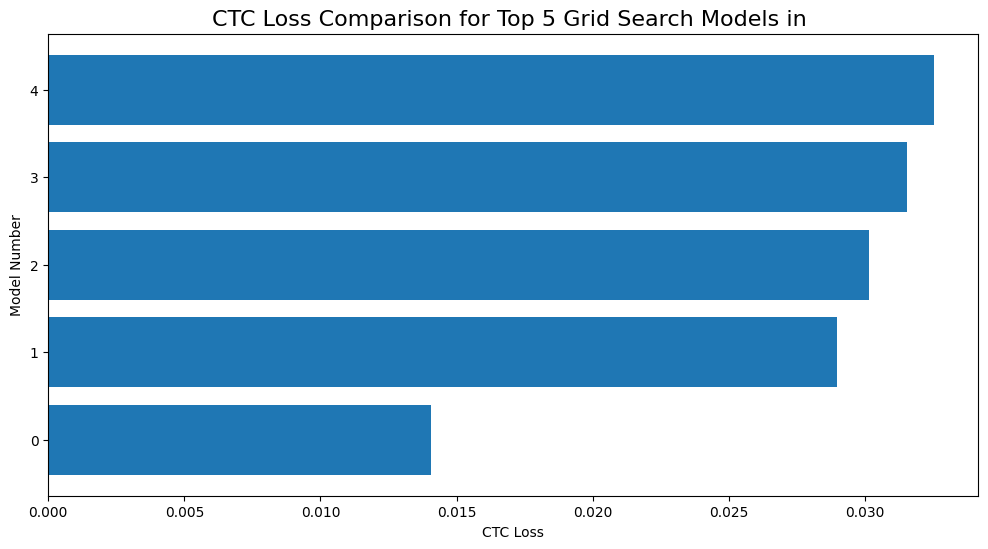

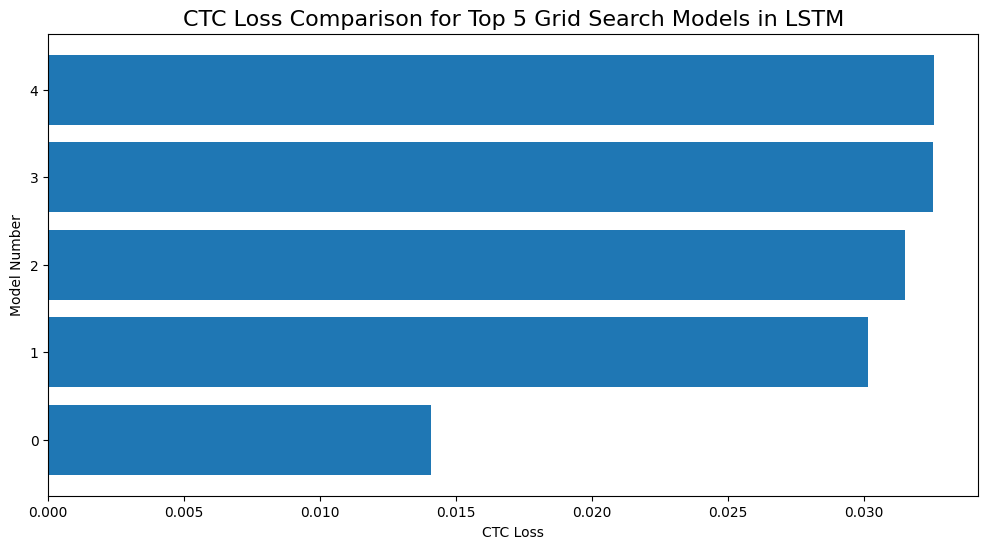

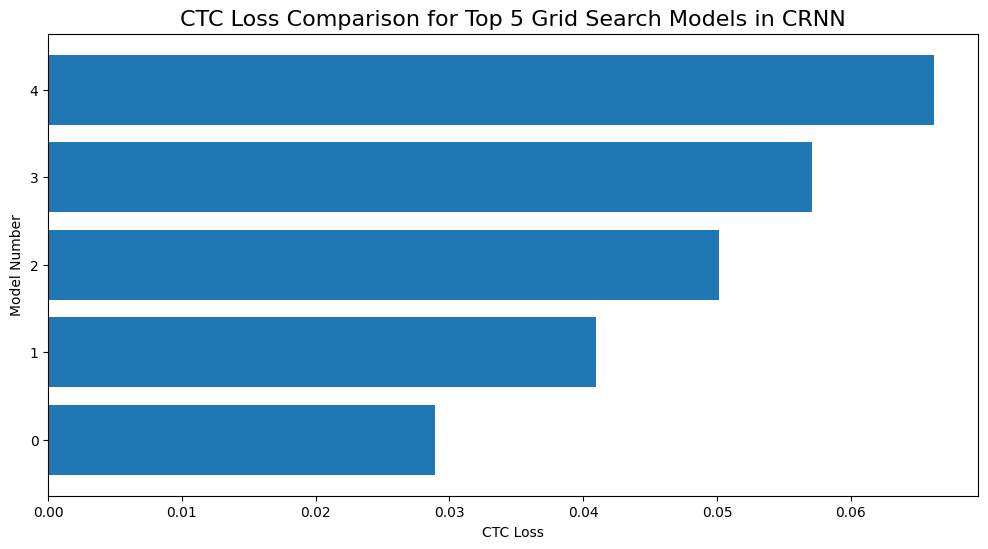

In [34]:
import numpy as np
from utils import split_and_insert_newline_list 
import matplotlib.pyplot as plt

def plot_bar_chart_top_5(numerical_top_models, model_filter='', metric="test_loss"):
    model_number_top_5 = [item["id"] for idx, item in numerical_top_models.items()]
    model_scores_top_5 = [item[metric] for idx, item in numerical_top_models.items()]

    # Create a horizontal bar plot for all metrics
    # Update fig size
    plt.figure(figsize=(12, 6), dpi=100)

    plt.barh(model_number_top_5, model_scores_top_5)  # Horizontal bar plot

    plt.xlabel('CTC Loss')  # Adjust label
    plt.ylabel('Model Number')  # Adjust label
    plt.title(f'CTC Loss Comparison for Top 5 Grid Search Models in {model_filter}', fontsize=16)  # Adjust title font size

    # Customize font size for model names
    plt.yticks(fontsize=10)

    plt.show()

plot_bar_chart_top_5(numerical_top_models, metric="val_loss")
plot_bar_chart_top_5(numerical_top_models_lstm, model_filter="LSTM", metric="val_loss")
plot_bar_chart_top_5(numerical_top_models_crnn, model_filter="CRNN", metric="val_loss")


## Plot CTC loss and CER metric to file

In [4]:
try:
    # Try if trainers are defined after training run
    for model_name, trainer in trainers.items():
        main_model_name = model_name.split('-', 1)[0]
        # Get model paths
        base_path = f'models/{main_model_name}/{model_name}/'
        
        print(f"Saving Loss Plot for model: {model_name}")

        # Plot the trained model
        plot_metric(model_name=model_name, train_metric_per_epoch=trainer.metrics["train_loss"], val_metric_per_epoch=trainer.metrics["val_loss"], figure_evaluation_dir=f"{base_path}", metric_name="CTC Loss")
        plot_metric(model_name=model_name, train_metric_per_epoch=trainer.metrics["train_cer"], val_metric_per_epoch=trainer.metrics["val_cer"], figure_evaluation_dir=f"{base_path}", metric_name="CER")
except:
    # Otherwise work with metrics loaded from file
    for model_name, metrics in grid_search_metrics.items():
        main_model_name = model_name.split('-', 1)[0]
        # Get model paths
        base_path = f'models/{main_model_name}/{model_name}/'
        
        print(f"Saving Plots for model: {model_name}")

        # Plot the trained model
        plot_metric(model_name=model_name, train_metric_per_epoch=metrics["train_loss"], val_metric_per_epoch=metrics["val_loss"], figure_evaluation_dir=f"{base_path}", metric_name="CTC Loss")
        plot_metric(model_name=model_name, train_metric_per_epoch=metrics["train_cer"], val_metric_per_epoch=metrics["val_cer"], figure_evaluation_dir=f"{base_path}", metric_name="CER")


Saving Plots for model: lstm_cnn-adam_w_no_scheduler_G128__L2__H4__W32__LR0_01__BS64__BSV64
Saving Plots for model: lstm_cnn-adam_w_exponential_lr_G128__L2__H4__W32__LR0_01__BS64__BSV64
Saving Plots for model: lstm_cnn-adam_w_regulise_no_scheduler_G128__L2__H4__W32__LR0_01__BS64__BSV64
Saving Plots for model: lstm_cnn-adam_w_regulise_exponential_lr_G128__L2__H4__W32__LR0_01__BS64__BSV64
Saving Plots for model: crnn-adam_w_no_scheduler_G128__L2__H4__W32__LR0_01__BS64__BSV64
Saving Plots for model: crnn-adam_w_exponential_lr_G128__L2__H4__W32__LR0_01__BS64__BSV64
Saving Plots for model: crnn-adam_w_regulise_no_scheduler_G128__L2__H4__W32__LR0_01__BS64__BSV64
Saving Plots for model: crnn-adam_w_regulise_exponential_lr_G128__L2__H4__W32__LR0_01__BS64__BSV64
Saving Plots for model: lstm_cnn-adam_w_no_scheduler_G128__L2__H4__W32__LR0_01__BS128__BSV64
Saving Plots for model: lstm_cnn-adam_w_exponential_lr_G128__L2__H4__W32__LR0_01__BS128__BSV64
Saving Plots for model: lstm_cnn-adam_w_regulise

/Users/leonremke/Documents/GIT_REPOS/UNI/neural_networks_seminar/benchmarking_emnist/evaluation/metric.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 6), dpi=100)


Saving Plots for model: lstm_cnn-adam_w_regulise_exponential_lr_G128__L2__H4__W32__LR0_01__BS128__BSV64
Saving Plots for model: crnn-adam_w_no_scheduler_G128__L2__H4__W32__LR0_01__BS128__BSV64
Saving Plots for model: crnn-adam_w_exponential_lr_G128__L2__H4__W32__LR0_01__BS128__BSV64
Saving Plots for model: crnn-adam_w_regulise_no_scheduler_G128__L2__H4__W32__LR0_01__BS128__BSV64
Saving Plots for model: crnn-adam_w_regulise_exponential_lr_G128__L2__H4__W32__LR0_01__BS128__BSV64
Saving Plots for model: lstm_cnn-adam_w_no_scheduler_G128__L2__H4__W32__LR0_001__BS64__BSV64
Saving Plots for model: lstm_cnn-adam_w_exponential_lr_G128__L2__H4__W32__LR0_001__BS64__BSV64
Saving Plots for model: lstm_cnn-adam_w_regulise_no_scheduler_G128__L2__H4__W32__LR0_001__BS64__BSV64
Saving Plots for model: lstm_cnn-adam_w_regulise_exponential_lr_G128__L2__H4__W32__LR0_001__BS64__BSV64
Saving Plots for model: crnn-adam_w_no_scheduler_G128__L2__H4__W32__LR0_001__BS64__BSV64
Saving Plots for model: crnn-adam_w

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

## Plot CTC loss and CER metric to file for top 5 models

In [36]:
def plot_top_n_metric_curves(top_models_dict, top_n_metrics, model_filter=''):
    model_ids = []
    model_training_losses = []
    model_val_losses = []
    model_training_cers = []
    model_val_cers = []
    # Otherwise work with metrics loaded from file
    for model_name, metrics in top_n_metrics.items():
        model_id = top_models_dict[model_name]["id"]
        model_ids.append(model_id)
        # Add best losses to list
        model_training_losses.append(metrics["train_loss"])
        model_val_losses.append(metrics["val_loss"])
        # Add cers for best losses to list
        model_training_cers.append(metrics["train_cer"])
        model_val_cers.append(metrics["val_cer"])

    # Get model paths
    if model_filter == '':
        base_path = f'models/'
    else:
        main_model_name = model_name.split('-', 1)[0]
        base_path = f'models/{main_model_name}/'

    # Plot the trained model
    plot_multiple_metrics(
        model_names=model_ids, 
        train_metrics_list=model_training_losses, 
        val_metrics_list=model_val_losses, 
        figure_evaluation_dir=base_path,
        metric_name="CTC Loss",
        model_filter=model_filter
    )

    plot_multiple_metrics(
        model_names=model_ids, 
        train_metrics_list=model_training_cers, 
        val_metrics_list=model_val_cers, 
        figure_evaluation_dir=base_path,
        metric_name="CER",
        model_filter=model_filter
    )
numerical_top_models
plot_top_n_metric_curves(numerical_top_models, top_5_metrics)
plot_top_n_metric_curves(numerical_top_models_lstm, top_5_metrics_lstm, model_filter="lstm_cnn")
plot_top_n_metric_curves(numerical_top_models_crnn, top_5_metrics_crnn, model_filter="crnn")

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [5]:
# Load models from disk for all trainers for testing
for model_name, trainer in trainers.items():
    main_model_name = model_name.split('-', 1)[0]
    # Get model paths
    base_path = f'models/{main_model_name}/{model_name}/'
    load_path = base_path + "model.pth"
    trainer.load_model(load_path)

Testing model lstm_cnn-adam_w_regulise_no_scheduler_G128__L2__H4__W32__LR0_001__BS128__BSV64


100%|██████████| 1/1 [00:00<00:00, 136.15it/s]

Test Predictions --> Loss: 7.931292930152267e-05; Correct: 1/1 = 1.0000; Average CER Score: 0.0


Test Sample: 1
Gold Label: [6 8 9 5 9]
Model Output: [6 8 9 5 9]


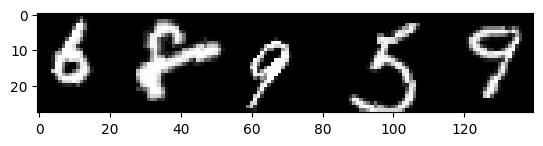


####################################################################################################

Testing model crnn-adam_w_no_scheduler_G256__L2__H4__W32__LR0_001__BS64__BSV64


100%|██████████| 1/1 [00:00<00:00, 66.69it/s]

Test Predictions --> Loss: 3.149698257446289; Correct: 0/1 = 0.0000; Average CER Score: 0.2


Test Sample: 1
Gold Label: [6 2 6 5 6]
Model Output: [6 2 6 5 6]


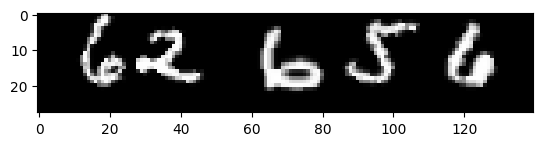


####################################################################################################

Testing model lstm_cnn-adam_w_regulise_exponential_lr_G128__L2__H4__W32__LR0_001__BS64__BSV64


100%|██████████| 1/1 [00:00<00:00, 146.52it/s]

Test Predictions --> Loss: 1.4316855413198937e-05; Correct: 1/1 = 1.0000; Average CER Score: 0.0
Test Sample: 1
Gold Label: [4 3 1 4 8]
Model Output: [4 3 1 4 8]


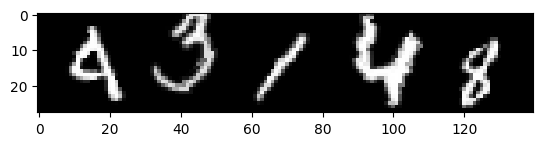


####################################################################################################

Testing model lstm_cnn-adam_w_no_scheduler_G256__L2__H4__W32__LR0_001__BS64__BSV64


100%|██████████| 1/1 [00:00<00:00, 116.08it/s]

Test Predictions --> Loss: 3.3656208515167236; Correct: 0/1 = 0.0000; Average CER Score: 0.2


Test Sample: 1
Gold Label: [1 5 0 9 0]
Model Output: [1 5 0 9 0]


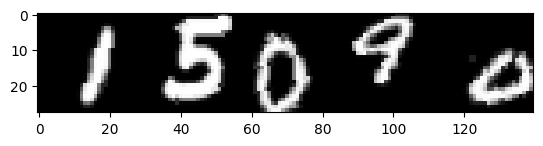


####################################################################################################

Testing model lstm_cnn-adam_w_no_scheduler_G128__L2__H4__W32__LR0_001__BS64__BSV64


100%|██████████| 1/1 [00:00<00:00, 147.80it/s]

Test Predictions --> Loss: 1.4316855413198937e-05; Correct: 1/1 = 1.0000; Average CER Score: 0.0
Test Sample: 1
Gold Label: [0 4 8 2 4]
Model Output: [0 4 8 2 4]


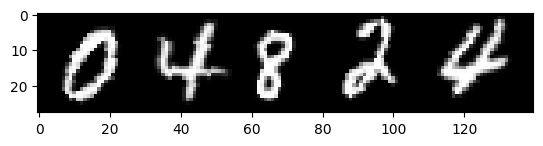


####################################################################################################



In [22]:
# Run test for top_model_names with plot
for model_name in top_model_names:
    print(f"Testing model {model_name}")

    # Plot the trained model
    trainers[model_name].test(plot_n=1, plot=True)
    print("\n" + 100*"#" + "\n")